In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = False
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-preprocess-enable_aug-False-enable_aug3-False-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

189419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

189419
189419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


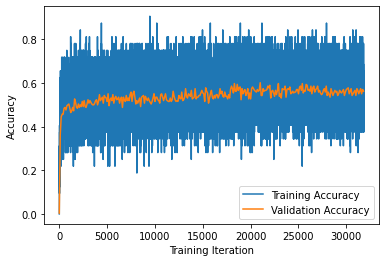

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.181 Validation Loss: 2.175 Accuracy: 0.086 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.179 Validation Loss: 2.175 Accuracy: 0.062 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.178 Validation Loss: 2.175 Accuracy: 0.060 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.176 Validation Loss: 2.175 Accuracy: 0.061 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.174 Validation Loss: 2.175 Accuracy: 0.070 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.173 Validation Loss: 2.175 Accuracy: 0.072 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.170 Validation Loss: 2.175 Accuracy: 0.076 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.168 Validation Loss: 2.175 Accuracy: 0.083 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.167 Validation Loss: 2.175 Accuracy: 0.089 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.164 Validation Loss: 2.175 Accuracy: 0.091 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.163 Validation Loss: 2.175 Accuracy: 0.095 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.161 Validation Loss: 2.175 Accuracy: 0.105 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.159 Validation Loss: 2.175 Accuracy: 0.109 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.157 Validation Loss: 2.175 Accuracy: 0.116 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.155 Validation Loss: 2.175 Accuracy: 0.121 Validation Accuracy: 0.064:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 0 Iteration: 14 Loss: 2.155 Validation Loss: 2.175 Accuracy: 0.121 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 15 Loss: 2.153 Validation Loss: 2.175 Accuracy: 0.130 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 16 Loss: 2.152 Validation Loss: 2.175 Accuracy: 0.138 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 17 Loss: 2.150 Validation Loss: 2.175 Accuracy: 0.149 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 18 Loss: 2.148 Validation Loss: 2.175 Accuracy: 0.163 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 19 Loss: 2.146 Validation Loss: 2.175 Accuracy: 0.182 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 20 Loss: 2.142 Validation Loss: 2.175 Accuracy: 0.208 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 21 Loss: 2.138 Validation Loss: 2.175 Accuracy: 0.235 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 22 Loss: 2.134 Validation Loss: 2.175 Accuracy: 0.259 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 23 Loss: 2.130 Validation Loss: 2.175 Accuracy: 0.284 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 24 Loss: 2.127 Validation Loss: 2.175 Accuracy: 0.310 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 25 Loss: 2.123 Validation Loss: 2.175 Accuracy: 0.336 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 26 Loss: 2.120 Validation Loss: 2.175 Accuracy: 0.365 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 27 Loss: 2.116 Validation Loss: 2.175 Accuracy: 0.382 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 28 Loss: 2.113 Validation Loss: 2.175 Accuracy: 0.402 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 29 Loss: 2.110 Validation Loss: 2.175 Accuracy: 0.423 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 30 Loss: 2.106 Validation Loss: 2.175 Accuracy: 0.443 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 31 Loss: 2.102 Validation Loss: 2.175 Accuracy: 0.456 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 32 Loss: 2.098 Validation Loss: 2.175 Accuracy: 0.470 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 33 Loss: 2.095 Validation Loss: 2.175 Accuracy: 0.475 Validation Accuracy: 0.064:   1%|          | 15/1480 [00:00<00:09, 147.80it/s]

Epoch: 0 Iteration: 33 Loss: 2.095 Validation Loss: 2.175 Accuracy: 0.475 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 34 Loss: 2.091 Validation Loss: 2.175 Accuracy: 0.484 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 35 Loss: 2.088 Validation Loss: 2.175 Accuracy: 0.491 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 36 Loss: 2.084 Validation Loss: 2.175 Accuracy: 0.497 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 37 Loss: 2.081 Validation Loss: 2.175 Accuracy: 0.512 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 38 Loss: 2.076 Validation Loss: 2.175 Accuracy: 0.527 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 39 Loss: 2.073 Validation Loss: 2.175 Accuracy: 0.533 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 40 Loss: 2.070 Validation Loss: 2.175 Accuracy: 0.527 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 41 Loss: 2.069 Validation Loss: 2.175 Accuracy: 0.516 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 42 Loss: 2.064 Validation Loss: 2.175 Accuracy: 0.529 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 43 Loss: 2.061 Validation Loss: 2.175 Accuracy: 0.539 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 44 Loss: 2.057 Validation Loss: 2.175 Accuracy: 0.543 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 45 Loss: 2.055 Validation Loss: 2.175 Accuracy: 0.541 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 46 Loss: 2.051 Validation Loss: 2.175 Accuracy: 0.541 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 47 Loss: 2.048 Validation Loss: 2.175 Accuracy: 0.545 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 48 Loss: 2.043 Validation Loss: 2.175 Accuracy: 0.547 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 49 Loss: 2.039 Validation Loss: 2.175 Accuracy: 0.550 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 50 Loss: 2.035 Validation Loss: 2.175 Accuracy: 0.553 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 51 Loss: 2.032 Validation Loss: 2.175 Accuracy: 0.573 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 52 Loss: 2.028 Validation Loss: 2.175 Accuracy: 0.579 Validation Accuracy: 0.064:   2%|▏         | 34/1480 [00:00<00:08, 169.18it/s]

Epoch: 0 Iteration: 52 Loss: 2.028 Validation Loss: 2.175 Accuracy: 0.579 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 53 Loss: 2.024 Validation Loss: 2.175 Accuracy: 0.591 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 54 Loss: 2.020 Validation Loss: 2.175 Accuracy: 0.593 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 55 Loss: 2.016 Validation Loss: 2.175 Accuracy: 0.609 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 56 Loss: 2.013 Validation Loss: 2.175 Accuracy: 0.609 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 57 Loss: 2.010 Validation Loss: 2.175 Accuracy: 0.608 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 58 Loss: 2.006 Validation Loss: 2.175 Accuracy: 0.605 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 59 Loss: 2.003 Validation Loss: 2.175 Accuracy: 0.595 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 60 Loss: 1.997 Validation Loss: 2.175 Accuracy: 0.600 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 61 Loss: 1.992 Validation Loss: 2.175 Accuracy: 0.598 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 62 Loss: 1.988 Validation Loss: 2.175 Accuracy: 0.593 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 63 Loss: 1.985 Validation Loss: 2.175 Accuracy: 0.588 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 64 Loss: 1.982 Validation Loss: 2.175 Accuracy: 0.596 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 65 Loss: 1.976 Validation Loss: 2.175 Accuracy: 0.598 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 66 Loss: 1.973 Validation Loss: 2.175 Accuracy: 0.602 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 67 Loss: 1.970 Validation Loss: 2.175 Accuracy: 0.595 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 68 Loss: 1.968 Validation Loss: 2.175 Accuracy: 0.591 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 69 Loss: 1.964 Validation Loss: 2.175 Accuracy: 0.600 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 70 Loss: 1.961 Validation Loss: 2.175 Accuracy: 0.596 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 71 Loss: 1.957 Validation Loss: 2.175 Accuracy: 0.600 Validation Accuracy: 0.064:   4%|▎         | 53/1480 [00:00<00:08, 176.10it/s]

Epoch: 0 Iteration: 71 Loss: 1.957 Validation Loss: 2.175 Accuracy: 0.600 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 72 Loss: 1.953 Validation Loss: 2.175 Accuracy: 0.596 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 73 Loss: 1.951 Validation Loss: 2.175 Accuracy: 0.588 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 74 Loss: 1.948 Validation Loss: 2.175 Accuracy: 0.575 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 75 Loss: 1.946 Validation Loss: 2.175 Accuracy: 0.570 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 76 Loss: 1.942 Validation Loss: 2.175 Accuracy: 0.574 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 77 Loss: 1.939 Validation Loss: 2.175 Accuracy: 0.584 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 78 Loss: 1.937 Validation Loss: 2.175 Accuracy: 0.583 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 79 Loss: 1.933 Validation Loss: 2.175 Accuracy: 0.578 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 80 Loss: 1.931 Validation Loss: 2.175 Accuracy: 0.581 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 81 Loss: 1.926 Validation Loss: 2.175 Accuracy: 0.571 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 82 Loss: 1.924 Validation Loss: 2.175 Accuracy: 0.573 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 83 Loss: 1.921 Validation Loss: 2.175 Accuracy: 0.573 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 84 Loss: 1.917 Validation Loss: 2.175 Accuracy: 0.581 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 85 Loss: 1.913 Validation Loss: 2.175 Accuracy: 0.585 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 86 Loss: 1.910 Validation Loss: 2.175 Accuracy: 0.583 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 87 Loss: 1.906 Validation Loss: 2.175 Accuracy: 0.573 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 88 Loss: 1.902 Validation Loss: 2.175 Accuracy: 0.568 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 89 Loss: 1.899 Validation Loss: 2.175 Accuracy: 0.580 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 90 Loss: 1.895 Validation Loss: 2.175 Accuracy: 0.584 Validation Accuracy: 0.064:   5%|▍         | 72/1480 [00:00<00:07, 180.47it/s]

Epoch: 0 Iteration: 90 Loss: 1.895 Validation Loss: 2.175 Accuracy: 0.584 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 91 Loss: 1.891 Validation Loss: 2.175 Accuracy: 0.593 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 92 Loss: 1.889 Validation Loss: 2.175 Accuracy: 0.585 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 93 Loss: 1.885 Validation Loss: 2.175 Accuracy: 0.598 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 94 Loss: 1.879 Validation Loss: 2.175 Accuracy: 0.600 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 95 Loss: 1.876 Validation Loss: 2.175 Accuracy: 0.596 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 96 Loss: 1.872 Validation Loss: 2.175 Accuracy: 0.588 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 97 Loss: 1.869 Validation Loss: 2.175 Accuracy: 0.604 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 98 Loss: 1.865 Validation Loss: 2.175 Accuracy: 0.611 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 99 Loss: 1.859 Validation Loss: 2.175 Accuracy: 0.609 Validation Accuracy: 0.064:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 100 Loss: 1.857 Validation Loss: 1.821 Accuracy: 0.607 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 101 Loss: 1.854 Validation Loss: 1.821 Accuracy: 0.604 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 102 Loss: 1.851 Validation Loss: 1.821 Accuracy: 0.620 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 103 Loss: 1.846 Validation Loss: 1.821 Accuracy: 0.618 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 104 Loss: 1.843 Validation Loss: 1.821 Accuracy: 0.618 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 105 Loss: 1.840 Validation Loss: 1.821 Accuracy: 0.620 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 106 Loss: 1.836 Validation Loss: 1.821 Accuracy: 0.627 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 107 Loss: 1.833 Validation Loss: 1.821 Accuracy: 0.614 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 108 Loss: 1.830 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 109 Loss: 1.827 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:   6%|▌         | 91/1480 [00:00<00:07, 181.70it/s]

Epoch: 0 Iteration: 109 Loss: 1.827 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 110 Loss: 1.823 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 111 Loss: 1.822 Validation Loss: 1.821 Accuracy: 0.608 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 112 Loss: 1.818 Validation Loss: 1.821 Accuracy: 0.605 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 113 Loss: 1.813 Validation Loss: 1.821 Accuracy: 0.601 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 114 Loss: 1.812 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 115 Loss: 1.808 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 116 Loss: 1.805 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 117 Loss: 1.800 Validation Loss: 1.821 Accuracy: 0.605 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 118 Loss: 1.797 Validation Loss: 1.821 Accuracy: 0.602 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 119 Loss: 1.795 Validation Loss: 1.821 Accuracy: 0.598 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 120 Loss: 1.791 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 121 Loss: 1.786 Validation Loss: 1.821 Accuracy: 0.600 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 122 Loss: 1.781 Validation Loss: 1.821 Accuracy: 0.600 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 123 Loss: 1.778 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 124 Loss: 1.774 Validation Loss: 1.821 Accuracy: 0.604 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 125 Loss: 1.770 Validation Loss: 1.821 Accuracy: 0.605 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 126 Loss: 1.767 Validation Loss: 1.821 Accuracy: 0.607 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 127 Loss: 1.761 Validation Loss: 1.821 Accuracy: 0.606 Validation Accuracy: 0.349:   7%|▋         | 110/1480 [00:00<00:07, 177.63it/s]

Epoch: 0 Iteration: 127 Loss: 1.761 Validation Loss: 1.821 Accuracy: 0.606 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 128 Loss: 1.756 Validation Loss: 1.821 Accuracy: 0.606 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 129 Loss: 1.752 Validation Loss: 1.821 Accuracy: 0.608 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 130 Loss: 1.748 Validation Loss: 1.821 Accuracy: 0.613 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 131 Loss: 1.744 Validation Loss: 1.821 Accuracy: 0.605 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 132 Loss: 1.741 Validation Loss: 1.821 Accuracy: 0.604 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 133 Loss: 1.737 Validation Loss: 1.821 Accuracy: 0.607 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 134 Loss: 1.734 Validation Loss: 1.821 Accuracy: 0.600 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 135 Loss: 1.728 Validation Loss: 1.821 Accuracy: 0.594 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 136 Loss: 1.724 Validation Loss: 1.821 Accuracy: 0.592 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 137 Loss: 1.723 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 138 Loss: 1.719 Validation Loss: 1.821 Accuracy: 0.596 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 139 Loss: 1.716 Validation Loss: 1.821 Accuracy: 0.590 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 140 Loss: 1.714 Validation Loss: 1.821 Accuracy: 0.581 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 141 Loss: 1.712 Validation Loss: 1.821 Accuracy: 0.587 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 142 Loss: 1.708 Validation Loss: 1.821 Accuracy: 0.585 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 143 Loss: 1.706 Validation Loss: 1.821 Accuracy: 0.585 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 144 Loss: 1.701 Validation Loss: 1.821 Accuracy: 0.587 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 145 Loss: 1.696 Validation Loss: 1.821 Accuracy: 0.593 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 146 Loss: 1.691 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:   9%|▊         | 128/1480 [00:00<00:07, 178.35it/s]

Epoch: 0 Iteration: 146 Loss: 1.691 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 147 Loss: 1.690 Validation Loss: 1.821 Accuracy: 0.591 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 148 Loss: 1.686 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 149 Loss: 1.683 Validation Loss: 1.821 Accuracy: 0.594 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 150 Loss: 1.678 Validation Loss: 1.821 Accuracy: 0.605 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 151 Loss: 1.672 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 152 Loss: 1.671 Validation Loss: 1.821 Accuracy: 0.609 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 153 Loss: 1.670 Validation Loss: 1.821 Accuracy: 0.612 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 154 Loss: 1.664 Validation Loss: 1.821 Accuracy: 0.614 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 155 Loss: 1.661 Validation Loss: 1.821 Accuracy: 0.613 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 156 Loss: 1.658 Validation Loss: 1.821 Accuracy: 0.608 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 157 Loss: 1.654 Validation Loss: 1.821 Accuracy: 0.604 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 158 Loss: 1.652 Validation Loss: 1.821 Accuracy: 0.606 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 159 Loss: 1.647 Validation Loss: 1.821 Accuracy: 0.612 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 160 Loss: 1.642 Validation Loss: 1.821 Accuracy: 0.613 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 161 Loss: 1.639 Validation Loss: 1.821 Accuracy: 0.611 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 162 Loss: 1.635 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 163 Loss: 1.631 Validation Loss: 1.821 Accuracy: 0.619 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 164 Loss: 1.626 Validation Loss: 1.821 Accuracy: 0.629 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 165 Loss: 1.624 Validation Loss: 1.821 Accuracy: 0.630 Validation Accuracy: 0.349:  10%|▉         | 147/1480 [00:00<00:07, 179.23it/s]

Epoch: 0 Iteration: 165 Loss: 1.624 Validation Loss: 1.821 Accuracy: 0.630 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 166 Loss: 1.621 Validation Loss: 1.821 Accuracy: 0.642 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 167 Loss: 1.616 Validation Loss: 1.821 Accuracy: 0.644 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 168 Loss: 1.613 Validation Loss: 1.821 Accuracy: 0.639 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 169 Loss: 1.606 Validation Loss: 1.821 Accuracy: 0.638 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 170 Loss: 1.604 Validation Loss: 1.821 Accuracy: 0.627 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 171 Loss: 1.603 Validation Loss: 1.821 Accuracy: 0.622 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 172 Loss: 1.594 Validation Loss: 1.821 Accuracy: 0.621 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 173 Loss: 1.587 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 174 Loss: 1.587 Validation Loss: 1.821 Accuracy: 0.602 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 175 Loss: 1.582 Validation Loss: 1.821 Accuracy: 0.600 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 176 Loss: 1.576 Validation Loss: 1.821 Accuracy: 0.590 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 177 Loss: 1.571 Validation Loss: 1.821 Accuracy: 0.594 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:00<00:07, 179.84it/s]

Epoch: 0 Iteration: 178 Loss: 1.568 Validation Loss: 1.821 Accuracy: 0.593 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:01<00:07, 179.84it/s]

Epoch: 0 Iteration: 179 Loss: 1.566 Validation Loss: 1.821 Accuracy: 0.590 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:01<00:07, 179.84it/s]

Epoch: 0 Iteration: 180 Loss: 1.562 Validation Loss: 1.821 Accuracy: 0.593 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:01<00:07, 179.84it/s]

Epoch: 0 Iteration: 181 Loss: 1.556 Validation Loss: 1.821 Accuracy: 0.595 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:01<00:07, 179.84it/s]

Epoch: 0 Iteration: 182 Loss: 1.554 Validation Loss: 1.821 Accuracy: 0.592 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:01<00:07, 179.84it/s]

Epoch: 0 Iteration: 183 Loss: 1.550 Validation Loss: 1.821 Accuracy: 0.591 Validation Accuracy: 0.349:  11%|█         | 166/1480 [00:01<00:07, 179.84it/s]

Epoch: 0 Iteration: 183 Loss: 1.550 Validation Loss: 1.821 Accuracy: 0.591 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 184 Loss: 1.549 Validation Loss: 1.821 Accuracy: 0.591 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 185 Loss: 1.546 Validation Loss: 1.821 Accuracy: 0.591 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 186 Loss: 1.542 Validation Loss: 1.821 Accuracy: 0.601 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 187 Loss: 1.539 Validation Loss: 1.821 Accuracy: 0.597 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 188 Loss: 1.536 Validation Loss: 1.821 Accuracy: 0.602 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 189 Loss: 1.539 Validation Loss: 1.821 Accuracy: 0.605 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 190 Loss: 1.538 Validation Loss: 1.821 Accuracy: 0.607 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 191 Loss: 1.533 Validation Loss: 1.821 Accuracy: 0.609 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 192 Loss: 1.533 Validation Loss: 1.821 Accuracy: 0.616 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 193 Loss: 1.530 Validation Loss: 1.821 Accuracy: 0.618 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 194 Loss: 1.523 Validation Loss: 1.821 Accuracy: 0.632 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 195 Loss: 1.517 Validation Loss: 1.821 Accuracy: 0.634 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 196 Loss: 1.514 Validation Loss: 1.821 Accuracy: 0.638 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 197 Loss: 1.513 Validation Loss: 1.821 Accuracy: 0.640 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 198 Loss: 1.504 Validation Loss: 1.821 Accuracy: 0.641 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 199 Loss: 1.503 Validation Loss: 1.821 Accuracy: 0.636 Validation Accuracy: 0.349:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 200 Loss: 1.501 Validation Loss: 1.460 Accuracy: 0.634 Validation Accuracy: 0.445:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 201 Loss: 1.499 Validation Loss: 1.460 Accuracy: 0.634 Validation Accuracy: 0.445:  12%|█▏        | 184/1480 [00:01<00:07, 179.31it/s]

Epoch: 0 Iteration: 201 Loss: 1.499 Validation Loss: 1.460 Accuracy: 0.634 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 202 Loss: 1.495 Validation Loss: 1.460 Accuracy: 0.634 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 203 Loss: 1.492 Validation Loss: 1.460 Accuracy: 0.637 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 204 Loss: 1.487 Validation Loss: 1.460 Accuracy: 0.635 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 205 Loss: 1.480 Validation Loss: 1.460 Accuracy: 0.629 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 206 Loss: 1.479 Validation Loss: 1.460 Accuracy: 0.614 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 207 Loss: 1.476 Validation Loss: 1.460 Accuracy: 0.618 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 208 Loss: 1.475 Validation Loss: 1.460 Accuracy: 0.616 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 209 Loss: 1.468 Validation Loss: 1.460 Accuracy: 0.620 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 210 Loss: 1.461 Validation Loss: 1.460 Accuracy: 0.624 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 211 Loss: 1.455 Validation Loss: 1.460 Accuracy: 0.629 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 212 Loss: 1.455 Validation Loss: 1.460 Accuracy: 0.621 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 213 Loss: 1.452 Validation Loss: 1.460 Accuracy: 0.617 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 214 Loss: 1.452 Validation Loss: 1.460 Accuracy: 0.603 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 215 Loss: 1.449 Validation Loss: 1.460 Accuracy: 0.615 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 216 Loss: 1.447 Validation Loss: 1.460 Accuracy: 0.620 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 217 Loss: 1.441 Validation Loss: 1.460 Accuracy: 0.620 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 218 Loss: 1.441 Validation Loss: 1.460 Accuracy: 0.620 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 219 Loss: 1.435 Validation Loss: 1.460 Accuracy: 0.627 Validation Accuracy: 0.445:  14%|█▎        | 202/1480 [00:01<00:07, 171.19it/s]

Epoch: 0 Iteration: 219 Loss: 1.435 Validation Loss: 1.460 Accuracy: 0.627 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 220 Loss: 1.428 Validation Loss: 1.460 Accuracy: 0.635 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 221 Loss: 1.425 Validation Loss: 1.460 Accuracy: 0.634 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 222 Loss: 1.422 Validation Loss: 1.460 Accuracy: 0.638 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 223 Loss: 1.419 Validation Loss: 1.460 Accuracy: 0.638 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 224 Loss: 1.415 Validation Loss: 1.460 Accuracy: 0.652 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 225 Loss: 1.414 Validation Loss: 1.460 Accuracy: 0.643 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 226 Loss: 1.410 Validation Loss: 1.460 Accuracy: 0.641 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 227 Loss: 1.406 Validation Loss: 1.460 Accuracy: 0.638 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 228 Loss: 1.403 Validation Loss: 1.460 Accuracy: 0.637 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 229 Loss: 1.400 Validation Loss: 1.460 Accuracy: 0.637 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 230 Loss: 1.401 Validation Loss: 1.460 Accuracy: 0.630 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 231 Loss: 1.398 Validation Loss: 1.460 Accuracy: 0.625 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 232 Loss: 1.393 Validation Loss: 1.460 Accuracy: 0.628 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 233 Loss: 1.390 Validation Loss: 1.460 Accuracy: 0.641 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 234 Loss: 1.389 Validation Loss: 1.460 Accuracy: 0.635 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 235 Loss: 1.388 Validation Loss: 1.460 Accuracy: 0.628 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 236 Loss: 1.384 Validation Loss: 1.460 Accuracy: 0.630 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 237 Loss: 1.385 Validation Loss: 1.460 Accuracy: 0.623 Validation Accuracy: 0.445:  15%|█▍        | 220/1480 [00:01<00:07, 173.09it/s]

Epoch: 0 Iteration: 237 Loss: 1.385 Validation Loss: 1.460 Accuracy: 0.623 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 238 Loss: 1.379 Validation Loss: 1.460 Accuracy: 0.629 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 239 Loss: 1.374 Validation Loss: 1.460 Accuracy: 0.624 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 240 Loss: 1.372 Validation Loss: 1.460 Accuracy: 0.620 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 241 Loss: 1.370 Validation Loss: 1.460 Accuracy: 0.623 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 242 Loss: 1.366 Validation Loss: 1.460 Accuracy: 0.619 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 243 Loss: 1.362 Validation Loss: 1.460 Accuracy: 0.606 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 244 Loss: 1.360 Validation Loss: 1.460 Accuracy: 0.608 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 245 Loss: 1.357 Validation Loss: 1.460 Accuracy: 0.617 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 246 Loss: 1.357 Validation Loss: 1.460 Accuracy: 0.609 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 247 Loss: 1.354 Validation Loss: 1.460 Accuracy: 0.620 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 248 Loss: 1.347 Validation Loss: 1.460 Accuracy: 0.623 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 249 Loss: 1.346 Validation Loss: 1.460 Accuracy: 0.620 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 250 Loss: 1.341 Validation Loss: 1.460 Accuracy: 0.614 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 251 Loss: 1.341 Validation Loss: 1.460 Accuracy: 0.613 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 252 Loss: 1.336 Validation Loss: 1.460 Accuracy: 0.624 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 253 Loss: 1.335 Validation Loss: 1.460 Accuracy: 0.629 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 254 Loss: 1.331 Validation Loss: 1.460 Accuracy: 0.626 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 255 Loss: 1.329 Validation Loss: 1.460 Accuracy: 0.629 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 256 Loss: 1.328 Validation Loss: 1.460 Accuracy: 0.644 Validation Accuracy: 0.445:  16%|█▌        | 238/1480 [00:01<00:07, 174.94it/s]

Epoch: 0 Iteration: 256 Loss: 1.328 Validation Loss: 1.460 Accuracy: 0.644 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 257 Loss: 1.322 Validation Loss: 1.460 Accuracy: 0.640 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 258 Loss: 1.321 Validation Loss: 1.460 Accuracy: 0.637 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 259 Loss: 1.319 Validation Loss: 1.460 Accuracy: 0.641 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 260 Loss: 1.319 Validation Loss: 1.460 Accuracy: 0.652 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 261 Loss: 1.315 Validation Loss: 1.460 Accuracy: 0.660 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 262 Loss: 1.311 Validation Loss: 1.460 Accuracy: 0.655 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 263 Loss: 1.306 Validation Loss: 1.460 Accuracy: 0.660 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 264 Loss: 1.307 Validation Loss: 1.460 Accuracy: 0.659 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 265 Loss: 1.305 Validation Loss: 1.460 Accuracy: 0.653 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 266 Loss: 1.298 Validation Loss: 1.460 Accuracy: 0.652 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 267 Loss: 1.293 Validation Loss: 1.460 Accuracy: 0.655 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 268 Loss: 1.292 Validation Loss: 1.460 Accuracy: 0.662 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 269 Loss: 1.288 Validation Loss: 1.460 Accuracy: 0.656 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 270 Loss: 1.286 Validation Loss: 1.460 Accuracy: 0.652 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 271 Loss: 1.282 Validation Loss: 1.460 Accuracy: 0.645 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 272 Loss: 1.279 Validation Loss: 1.460 Accuracy: 0.653 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 273 Loss: 1.274 Validation Loss: 1.460 Accuracy: 0.648 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 274 Loss: 1.270 Validation Loss: 1.460 Accuracy: 0.658 Validation Accuracy: 0.445:  17%|█▋        | 257/1480 [00:01<00:06, 178.55it/s]

Epoch: 0 Iteration: 274 Loss: 1.270 Validation Loss: 1.460 Accuracy: 0.658 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 275 Loss: 1.267 Validation Loss: 1.460 Accuracy: 0.662 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 276 Loss: 1.263 Validation Loss: 1.460 Accuracy: 0.666 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 277 Loss: 1.263 Validation Loss: 1.460 Accuracy: 0.658 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 278 Loss: 1.260 Validation Loss: 1.460 Accuracy: 0.658 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 279 Loss: 1.260 Validation Loss: 1.460 Accuracy: 0.666 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 280 Loss: 1.256 Validation Loss: 1.460 Accuracy: 0.666 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 281 Loss: 1.252 Validation Loss: 1.460 Accuracy: 0.669 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 282 Loss: 1.253 Validation Loss: 1.460 Accuracy: 0.655 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 283 Loss: 1.248 Validation Loss: 1.460 Accuracy: 0.659 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 284 Loss: 1.241 Validation Loss: 1.460 Accuracy: 0.657 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 285 Loss: 1.241 Validation Loss: 1.460 Accuracy: 0.655 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 286 Loss: 1.242 Validation Loss: 1.460 Accuracy: 0.651 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 287 Loss: 1.243 Validation Loss: 1.460 Accuracy: 0.656 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 288 Loss: 1.240 Validation Loss: 1.460 Accuracy: 0.646 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 289 Loss: 1.236 Validation Loss: 1.460 Accuracy: 0.648 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 290 Loss: 1.232 Validation Loss: 1.460 Accuracy: 0.648 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 291 Loss: 1.228 Validation Loss: 1.460 Accuracy: 0.651 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 292 Loss: 1.228 Validation Loss: 1.460 Accuracy: 0.652 Validation Accuracy: 0.445:  19%|█▊        | 275/1480 [00:01<00:06, 173.15it/s]

Epoch: 0 Iteration: 292 Loss: 1.228 Validation Loss: 1.460 Accuracy: 0.652 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 293 Loss: 1.225 Validation Loss: 1.460 Accuracy: 0.652 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 294 Loss: 1.222 Validation Loss: 1.460 Accuracy: 0.655 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 295 Loss: 1.219 Validation Loss: 1.460 Accuracy: 0.663 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 296 Loss: 1.217 Validation Loss: 1.460 Accuracy: 0.662 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 297 Loss: 1.214 Validation Loss: 1.460 Accuracy: 0.659 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 298 Loss: 1.213 Validation Loss: 1.460 Accuracy: 0.651 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 299 Loss: 1.207 Validation Loss: 1.460 Accuracy: 0.651 Validation Accuracy: 0.445:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 300 Loss: 1.204 Validation Loss: 1.181 Accuracy: 0.655 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 301 Loss: 1.202 Validation Loss: 1.181 Accuracy: 0.660 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 302 Loss: 1.199 Validation Loss: 1.181 Accuracy: 0.666 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 303 Loss: 1.199 Validation Loss: 1.181 Accuracy: 0.671 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 304 Loss: 1.197 Validation Loss: 1.181 Accuracy: 0.666 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 305 Loss: 1.194 Validation Loss: 1.181 Accuracy: 0.659 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 306 Loss: 1.193 Validation Loss: 1.181 Accuracy: 0.659 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 307 Loss: 1.186 Validation Loss: 1.181 Accuracy: 0.671 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 308 Loss: 1.182 Validation Loss: 1.181 Accuracy: 0.683 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 309 Loss: 1.179 Validation Loss: 1.181 Accuracy: 0.687 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 310 Loss: 1.180 Validation Loss: 1.181 Accuracy: 0.677 Validation Accuracy: 0.499:  20%|█▉        | 293/1480 [00:01<00:06, 173.96it/s]

Epoch: 0 Iteration: 310 Loss: 1.180 Validation Loss: 1.181 Accuracy: 0.677 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 311 Loss: 1.179 Validation Loss: 1.181 Accuracy: 0.669 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 312 Loss: 1.176 Validation Loss: 1.181 Accuracy: 0.670 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 313 Loss: 1.173 Validation Loss: 1.181 Accuracy: 0.666 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 314 Loss: 1.172 Validation Loss: 1.181 Accuracy: 0.667 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 315 Loss: 1.170 Validation Loss: 1.181 Accuracy: 0.668 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 316 Loss: 1.168 Validation Loss: 1.181 Accuracy: 0.667 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 317 Loss: 1.164 Validation Loss: 1.181 Accuracy: 0.655 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 318 Loss: 1.160 Validation Loss: 1.181 Accuracy: 0.659 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 319 Loss: 1.158 Validation Loss: 1.181 Accuracy: 0.655 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 320 Loss: 1.158 Validation Loss: 1.181 Accuracy: 0.662 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 321 Loss: 1.156 Validation Loss: 1.181 Accuracy: 0.666 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 322 Loss: 1.155 Validation Loss: 1.181 Accuracy: 0.659 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 323 Loss: 1.154 Validation Loss: 1.181 Accuracy: 0.653 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 324 Loss: 1.152 Validation Loss: 1.181 Accuracy: 0.645 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 325 Loss: 1.144 Validation Loss: 1.181 Accuracy: 0.647 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 326 Loss: 1.136 Validation Loss: 1.181 Accuracy: 0.650 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 327 Loss: 1.137 Validation Loss: 1.181 Accuracy: 0.660 Validation Accuracy: 0.499:  21%|██        | 311/1480 [00:01<00:06, 168.42it/s]

Epoch: 0 Iteration: 327 Loss: 1.137 Validation Loss: 1.181 Accuracy: 0.660 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 328 Loss: 1.135 Validation Loss: 1.181 Accuracy: 0.667 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 329 Loss: 1.135 Validation Loss: 1.181 Accuracy: 0.672 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 330 Loss: 1.127 Validation Loss: 1.181 Accuracy: 0.677 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 331 Loss: 1.121 Validation Loss: 1.181 Accuracy: 0.680 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 332 Loss: 1.120 Validation Loss: 1.181 Accuracy: 0.684 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 333 Loss: 1.117 Validation Loss: 1.181 Accuracy: 0.695 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 334 Loss: 1.115 Validation Loss: 1.181 Accuracy: 0.701 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 335 Loss: 1.112 Validation Loss: 1.181 Accuracy: 0.702 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 336 Loss: 1.114 Validation Loss: 1.181 Accuracy: 0.698 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 337 Loss: 1.115 Validation Loss: 1.181 Accuracy: 0.692 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 338 Loss: 1.112 Validation Loss: 1.181 Accuracy: 0.688 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 339 Loss: 1.110 Validation Loss: 1.181 Accuracy: 0.682 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 340 Loss: 1.109 Validation Loss: 1.181 Accuracy: 0.679 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 341 Loss: 1.105 Validation Loss: 1.181 Accuracy: 0.682 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 342 Loss: 1.101 Validation Loss: 1.181 Accuracy: 0.680 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 343 Loss: 1.102 Validation Loss: 1.181 Accuracy: 0.672 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 344 Loss: 1.098 Validation Loss: 1.181 Accuracy: 0.680 Validation Accuracy: 0.499:  22%|██▏       | 328/1480 [00:01<00:06, 166.06it/s]

Epoch: 0 Iteration: 344 Loss: 1.098 Validation Loss: 1.181 Accuracy: 0.680 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:01<00:06, 164.41it/s]

Epoch: 0 Iteration: 345 Loss: 1.099 Validation Loss: 1.181 Accuracy: 0.680 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 346 Loss: 1.105 Validation Loss: 1.181 Accuracy: 0.675 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 347 Loss: 1.107 Validation Loss: 1.181 Accuracy: 0.673 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 348 Loss: 1.106 Validation Loss: 1.181 Accuracy: 0.668 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 349 Loss: 1.110 Validation Loss: 1.181 Accuracy: 0.656 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 350 Loss: 1.111 Validation Loss: 1.181 Accuracy: 0.657 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 351 Loss: 1.110 Validation Loss: 1.181 Accuracy: 0.653 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 352 Loss: 1.105 Validation Loss: 1.181 Accuracy: 0.660 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 353 Loss: 1.104 Validation Loss: 1.181 Accuracy: 0.660 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 354 Loss: 1.104 Validation Loss: 1.181 Accuracy: 0.644 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 355 Loss: 1.099 Validation Loss: 1.181 Accuracy: 0.652 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 356 Loss: 1.096 Validation Loss: 1.181 Accuracy: 0.658 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 357 Loss: 1.088 Validation Loss: 1.181 Accuracy: 0.666 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 358 Loss: 1.085 Validation Loss: 1.181 Accuracy: 0.671 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 359 Loss: 1.087 Validation Loss: 1.181 Accuracy: 0.683 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 360 Loss: 1.085 Validation Loss: 1.181 Accuracy: 0.681 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 361 Loss: 1.086 Validation Loss: 1.181 Accuracy: 0.674 Validation Accuracy: 0.499:  23%|██▎       | 345/1480 [00:02<00:06, 164.41it/s]

Epoch: 0 Iteration: 361 Loss: 1.086 Validation Loss: 1.181 Accuracy: 0.674 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 362 Loss: 1.082 Validation Loss: 1.181 Accuracy: 0.673 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 363 Loss: 1.072 Validation Loss: 1.181 Accuracy: 0.686 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 364 Loss: 1.071 Validation Loss: 1.181 Accuracy: 0.696 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 365 Loss: 1.072 Validation Loss: 1.181 Accuracy: 0.681 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 366 Loss: 1.062 Validation Loss: 1.181 Accuracy: 0.691 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 367 Loss: 1.059 Validation Loss: 1.181 Accuracy: 0.687 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 368 Loss: 1.061 Validation Loss: 1.181 Accuracy: 0.674 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 369 Loss: 1.059 Validation Loss: 1.181 Accuracy: 0.662 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 370 Loss: 1.055 Validation Loss: 1.181 Accuracy: 0.671 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 371 Loss: 1.054 Validation Loss: 1.181 Accuracy: 0.681 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 372 Loss: 1.049 Validation Loss: 1.181 Accuracy: 0.686 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 373 Loss: 1.047 Validation Loss: 1.181 Accuracy: 0.678 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 374 Loss: 1.042 Validation Loss: 1.181 Accuracy: 0.675 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 375 Loss: 1.046 Validation Loss: 1.181 Accuracy: 0.683 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 376 Loss: 1.043 Validation Loss: 1.181 Accuracy: 0.678 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 377 Loss: 1.043 Validation Loss: 1.181 Accuracy: 0.682 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 378 Loss: 1.041 Validation Loss: 1.181 Accuracy: 0.691 Validation Accuracy: 0.499:  24%|██▍       | 362/1480 [00:02<00:06, 160.84it/s]

Epoch: 0 Iteration: 378 Loss: 1.041 Validation Loss: 1.181 Accuracy: 0.691 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 379 Loss: 1.037 Validation Loss: 1.181 Accuracy: 0.704 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 380 Loss: 1.032 Validation Loss: 1.181 Accuracy: 0.702 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 381 Loss: 1.030 Validation Loss: 1.181 Accuracy: 0.692 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 382 Loss: 1.030 Validation Loss: 1.181 Accuracy: 0.682 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 383 Loss: 1.037 Validation Loss: 1.181 Accuracy: 0.673 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 384 Loss: 1.033 Validation Loss: 1.181 Accuracy: 0.677 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 385 Loss: 1.030 Validation Loss: 1.181 Accuracy: 0.674 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 386 Loss: 1.029 Validation Loss: 1.181 Accuracy: 0.677 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 387 Loss: 1.023 Validation Loss: 1.181 Accuracy: 0.680 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 388 Loss: 1.021 Validation Loss: 1.181 Accuracy: 0.674 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 389 Loss: 1.018 Validation Loss: 1.181 Accuracy: 0.669 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 390 Loss: 1.023 Validation Loss: 1.181 Accuracy: 0.666 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 391 Loss: 1.023 Validation Loss: 1.181 Accuracy: 0.671 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 392 Loss: 1.027 Validation Loss: 1.181 Accuracy: 0.672 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 393 Loss: 1.025 Validation Loss: 1.181 Accuracy: 0.684 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 394 Loss: 1.020 Validation Loss: 1.181 Accuracy: 0.684 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 395 Loss: 1.018 Validation Loss: 1.181 Accuracy: 0.676 Validation Accuracy: 0.499:  26%|██▌       | 379/1480 [00:02<00:06, 161.42it/s]

Epoch: 0 Iteration: 395 Loss: 1.018 Validation Loss: 1.181 Accuracy: 0.676 Validation Accuracy: 0.499:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 396 Loss: 1.017 Validation Loss: 1.181 Accuracy: 0.670 Validation Accuracy: 0.499:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 397 Loss: 1.017 Validation Loss: 1.181 Accuracy: 0.667 Validation Accuracy: 0.499:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 398 Loss: 1.014 Validation Loss: 1.181 Accuracy: 0.675 Validation Accuracy: 0.499:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 399 Loss: 1.012 Validation Loss: 1.181 Accuracy: 0.684 Validation Accuracy: 0.499:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 400 Loss: 1.011 Validation Loss: 1.009 Accuracy: 0.681 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 401 Loss: 1.014 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 402 Loss: 1.015 Validation Loss: 1.009 Accuracy: 0.678 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 403 Loss: 1.013 Validation Loss: 1.009 Accuracy: 0.673 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 404 Loss: 1.012 Validation Loss: 1.009 Accuracy: 0.672 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 405 Loss: 1.014 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 406 Loss: 1.015 Validation Loss: 1.009 Accuracy: 0.678 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 407 Loss: 1.014 Validation Loss: 1.009 Accuracy: 0.682 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 408 Loss: 1.010 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 409 Loss: 1.001 Validation Loss: 1.009 Accuracy: 0.680 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 410 Loss: 0.998 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 411 Loss: 0.996 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 412 Loss: 0.995 Validation Loss: 1.009 Accuracy: 0.680 Validation Accuracy: 0.533:  27%|██▋       | 396/1480 [00:02<00:06, 161.83it/s]

Epoch: 0 Iteration: 412 Loss: 0.995 Validation Loss: 1.009 Accuracy: 0.680 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 413 Loss: 0.995 Validation Loss: 1.009 Accuracy: 0.684 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 414 Loss: 0.998 Validation Loss: 1.009 Accuracy: 0.686 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 415 Loss: 0.997 Validation Loss: 1.009 Accuracy: 0.692 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 416 Loss: 0.992 Validation Loss: 1.009 Accuracy: 0.691 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 417 Loss: 0.991 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 418 Loss: 0.993 Validation Loss: 1.009 Accuracy: 0.694 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 419 Loss: 0.992 Validation Loss: 1.009 Accuracy: 0.684 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 420 Loss: 0.993 Validation Loss: 1.009 Accuracy: 0.684 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 421 Loss: 0.986 Validation Loss: 1.009 Accuracy: 0.687 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 422 Loss: 0.981 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 423 Loss: 0.978 Validation Loss: 1.009 Accuracy: 0.681 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 424 Loss: 0.985 Validation Loss: 1.009 Accuracy: 0.673 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 425 Loss: 0.983 Validation Loss: 1.009 Accuracy: 0.667 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 426 Loss: 0.982 Validation Loss: 1.009 Accuracy: 0.668 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 427 Loss: 0.984 Validation Loss: 1.009 Accuracy: 0.660 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 428 Loss: 0.982 Validation Loss: 1.009 Accuracy: 0.652 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 429 Loss: 0.983 Validation Loss: 1.009 Accuracy: 0.658 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 430 Loss: 0.982 Validation Loss: 1.009 Accuracy: 0.656 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 431 Loss: 0.983 Validation Loss: 1.009 Accuracy: 0.656 Validation Accuracy: 0.533:  28%|██▊       | 413/1480 [00:02<00:06, 158.58it/s]

Epoch: 0 Iteration: 431 Loss: 0.983 Validation Loss: 1.009 Accuracy: 0.656 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 432 Loss: 0.985 Validation Loss: 1.009 Accuracy: 0.652 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 433 Loss: 0.982 Validation Loss: 1.009 Accuracy: 0.655 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 434 Loss: 0.985 Validation Loss: 1.009 Accuracy: 0.662 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 435 Loss: 0.983 Validation Loss: 1.009 Accuracy: 0.674 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 436 Loss: 0.982 Validation Loss: 1.009 Accuracy: 0.683 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 437 Loss: 0.975 Validation Loss: 1.009 Accuracy: 0.685 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 438 Loss: 0.973 Validation Loss: 1.009 Accuracy: 0.694 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 439 Loss: 0.978 Validation Loss: 1.009 Accuracy: 0.683 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 440 Loss: 0.973 Validation Loss: 1.009 Accuracy: 0.691 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 441 Loss: 0.974 Validation Loss: 1.009 Accuracy: 0.695 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 442 Loss: 0.978 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 443 Loss: 0.974 Validation Loss: 1.009 Accuracy: 0.691 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 444 Loss: 0.964 Validation Loss: 1.009 Accuracy: 0.694 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 445 Loss: 0.962 Validation Loss: 1.009 Accuracy: 0.690 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 446 Loss: 0.966 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 447 Loss: 0.964 Validation Loss: 1.009 Accuracy: 0.684 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 448 Loss: 0.966 Validation Loss: 1.009 Accuracy: 0.678 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 449 Loss: 0.964 Validation Loss: 1.009 Accuracy: 0.691 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 450 Loss: 0.960 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  29%|██▉       | 432/1480 [00:02<00:06, 165.46it/s]

Epoch: 0 Iteration: 450 Loss: 0.960 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 451 Loss: 0.955 Validation Loss: 1.009 Accuracy: 0.690 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 452 Loss: 0.947 Validation Loss: 1.009 Accuracy: 0.702 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 453 Loss: 0.948 Validation Loss: 1.009 Accuracy: 0.705 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 454 Loss: 0.940 Validation Loss: 1.009 Accuracy: 0.707 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 455 Loss: 0.940 Validation Loss: 1.009 Accuracy: 0.703 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 456 Loss: 0.941 Validation Loss: 1.009 Accuracy: 0.706 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 457 Loss: 0.942 Validation Loss: 1.009 Accuracy: 0.702 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 458 Loss: 0.942 Validation Loss: 1.009 Accuracy: 0.705 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 459 Loss: 0.937 Validation Loss: 1.009 Accuracy: 0.695 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 460 Loss: 0.935 Validation Loss: 1.009 Accuracy: 0.704 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 461 Loss: 0.939 Validation Loss: 1.009 Accuracy: 0.692 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 462 Loss: 0.932 Validation Loss: 1.009 Accuracy: 0.689 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 463 Loss: 0.936 Validation Loss: 1.009 Accuracy: 0.679 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 464 Loss: 0.938 Validation Loss: 1.009 Accuracy: 0.672 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 465 Loss: 0.939 Validation Loss: 1.009 Accuracy: 0.667 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 466 Loss: 0.929 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 467 Loss: 0.929 Validation Loss: 1.009 Accuracy: 0.675 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 468 Loss: 0.922 Validation Loss: 1.009 Accuracy: 0.675 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 469 Loss: 0.925 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  30%|███       | 451/1480 [00:02<00:06, 170.27it/s]

Epoch: 0 Iteration: 469 Loss: 0.925 Validation Loss: 1.009 Accuracy: 0.677 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 470 Loss: 0.921 Validation Loss: 1.009 Accuracy: 0.675 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 471 Loss: 0.919 Validation Loss: 1.009 Accuracy: 0.686 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 472 Loss: 0.921 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 473 Loss: 0.918 Validation Loss: 1.009 Accuracy: 0.694 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 474 Loss: 0.921 Validation Loss: 1.009 Accuracy: 0.696 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 475 Loss: 0.920 Validation Loss: 1.009 Accuracy: 0.702 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 476 Loss: 0.916 Validation Loss: 1.009 Accuracy: 0.696 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 477 Loss: 0.919 Validation Loss: 1.009 Accuracy: 0.696 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 478 Loss: 0.918 Validation Loss: 1.009 Accuracy: 0.694 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 479 Loss: 0.917 Validation Loss: 1.009 Accuracy: 0.695 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 480 Loss: 0.919 Validation Loss: 1.009 Accuracy: 0.691 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 481 Loss: 0.910 Validation Loss: 1.009 Accuracy: 0.692 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 482 Loss: 0.910 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 483 Loss: 0.908 Validation Loss: 1.009 Accuracy: 0.684 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 484 Loss: 0.907 Validation Loss: 1.009 Accuracy: 0.686 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 485 Loss: 0.902 Validation Loss: 1.009 Accuracy: 0.686 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 486 Loss: 0.901 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 487 Loss: 0.897 Validation Loss: 1.009 Accuracy: 0.691 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 488 Loss: 0.899 Validation Loss: 1.009 Accuracy: 0.692 Validation Accuracy: 0.533:  32%|███▏      | 470/1480 [00:02<00:05, 173.43it/s]

Epoch: 0 Iteration: 488 Loss: 0.899 Validation Loss: 1.009 Accuracy: 0.692 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 489 Loss: 0.901 Validation Loss: 1.009 Accuracy: 0.688 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 490 Loss: 0.903 Validation Loss: 1.009 Accuracy: 0.686 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 491 Loss: 0.908 Validation Loss: 1.009 Accuracy: 0.678 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 492 Loss: 0.917 Validation Loss: 1.009 Accuracy: 0.666 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 493 Loss: 0.919 Validation Loss: 1.009 Accuracy: 0.671 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 494 Loss: 0.915 Validation Loss: 1.009 Accuracy: 0.673 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 495 Loss: 0.913 Validation Loss: 1.009 Accuracy: 0.672 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 496 Loss: 0.915 Validation Loss: 1.009 Accuracy: 0.662 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 497 Loss: 0.910 Validation Loss: 1.009 Accuracy: 0.664 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 498 Loss: 0.912 Validation Loss: 1.009 Accuracy: 0.658 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 499 Loss: 0.910 Validation Loss: 1.009 Accuracy: 0.662 Validation Accuracy: 0.533:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 500 Loss: 0.910 Validation Loss: 0.907 Accuracy: 0.665 Validation Accuracy: 0.558:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 501 Loss: 0.914 Validation Loss: 0.907 Accuracy: 0.666 Validation Accuracy: 0.558:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 502 Loss: 0.912 Validation Loss: 0.907 Accuracy: 0.684 Validation Accuracy: 0.558:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 503 Loss: 0.912 Validation Loss: 0.907 Accuracy: 0.684 Validation Accuracy: 0.558:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 504 Loss: 0.911 Validation Loss: 0.907 Accuracy: 0.678 Validation Accuracy: 0.558:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 505 Loss: 0.911 Validation Loss: 0.907 Accuracy: 0.676 Validation Accuracy: 0.558:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 506 Loss: 0.918 Validation Loss: 0.907 Accuracy: 0.676 Validation Accuracy: 0.558:  33%|███▎      | 489/1480 [00:02<00:05, 175.83it/s]

Epoch: 0 Iteration: 506 Loss: 0.918 Validation Loss: 0.907 Accuracy: 0.676 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 507 Loss: 0.925 Validation Loss: 0.907 Accuracy: 0.670 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 508 Loss: 0.924 Validation Loss: 0.907 Accuracy: 0.671 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 509 Loss: 0.919 Validation Loss: 0.907 Accuracy: 0.675 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 510 Loss: 0.914 Validation Loss: 0.907 Accuracy: 0.677 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 511 Loss: 0.906 Validation Loss: 0.907 Accuracy: 0.684 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 512 Loss: 0.900 Validation Loss: 0.907 Accuracy: 0.676 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 513 Loss: 0.903 Validation Loss: 0.907 Accuracy: 0.672 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 514 Loss: 0.905 Validation Loss: 0.907 Accuracy: 0.671 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:02<00:05, 173.39it/s]

Epoch: 0 Iteration: 515 Loss: 0.904 Validation Loss: 0.907 Accuracy: 0.674 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 516 Loss: 0.899 Validation Loss: 0.907 Accuracy: 0.685 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 517 Loss: 0.899 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 518 Loss: 0.896 Validation Loss: 0.907 Accuracy: 0.698 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 519 Loss: 0.896 Validation Loss: 0.907 Accuracy: 0.701 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 520 Loss: 0.894 Validation Loss: 0.907 Accuracy: 0.697 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 521 Loss: 0.892 Validation Loss: 0.907 Accuracy: 0.691 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 522 Loss: 0.890 Validation Loss: 0.907 Accuracy: 0.700 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 523 Loss: 0.885 Validation Loss: 0.907 Accuracy: 0.705 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 524 Loss: 0.884 Validation Loss: 0.907 Accuracy: 0.705 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 525 Loss: 0.881 Validation Loss: 0.907 Accuracy: 0.703 Validation Accuracy: 0.558:  34%|███▍      | 507/1480 [00:03<00:05, 173.39it/s]

Epoch: 0 Iteration: 525 Loss: 0.881 Validation Loss: 0.907 Accuracy: 0.703 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 526 Loss: 0.876 Validation Loss: 0.907 Accuracy: 0.698 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 527 Loss: 0.872 Validation Loss: 0.907 Accuracy: 0.689 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 528 Loss: 0.869 Validation Loss: 0.907 Accuracy: 0.683 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 529 Loss: 0.868 Validation Loss: 0.907 Accuracy: 0.681 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 530 Loss: 0.871 Validation Loss: 0.907 Accuracy: 0.685 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 531 Loss: 0.872 Validation Loss: 0.907 Accuracy: 0.693 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 532 Loss: 0.874 Validation Loss: 0.907 Accuracy: 0.682 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 533 Loss: 0.862 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 534 Loss: 0.860 Validation Loss: 0.907 Accuracy: 0.691 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 535 Loss: 0.861 Validation Loss: 0.907 Accuracy: 0.694 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 536 Loss: 0.862 Validation Loss: 0.907 Accuracy: 0.693 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 537 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.701 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 538 Loss: 0.863 Validation Loss: 0.907 Accuracy: 0.702 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 539 Loss: 0.864 Validation Loss: 0.907 Accuracy: 0.698 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 540 Loss: 0.861 Validation Loss: 0.907 Accuracy: 0.699 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 541 Loss: 0.865 Validation Loss: 0.907 Accuracy: 0.685 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 542 Loss: 0.868 Validation Loss: 0.907 Accuracy: 0.694 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 543 Loss: 0.872 Validation Loss: 0.907 Accuracy: 0.684 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 544 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.689 Validation Accuracy: 0.558:  36%|███▌      | 526/1480 [00:03<00:05, 176.08it/s]

Epoch: 0 Iteration: 544 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.689 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 545 Loss: 0.868 Validation Loss: 0.907 Accuracy: 0.687 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 546 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.690 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 547 Loss: 0.862 Validation Loss: 0.907 Accuracy: 0.692 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 548 Loss: 0.864 Validation Loss: 0.907 Accuracy: 0.695 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 549 Loss: 0.862 Validation Loss: 0.907 Accuracy: 0.698 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 550 Loss: 0.863 Validation Loss: 0.907 Accuracy: 0.698 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 551 Loss: 0.864 Validation Loss: 0.907 Accuracy: 0.704 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 552 Loss: 0.867 Validation Loss: 0.907 Accuracy: 0.691 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 553 Loss: 0.872 Validation Loss: 0.907 Accuracy: 0.698 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 554 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.696 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 555 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.694 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 556 Loss: 0.870 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 557 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 558 Loss: 0.867 Validation Loss: 0.907 Accuracy: 0.680 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 559 Loss: 0.865 Validation Loss: 0.907 Accuracy: 0.678 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 560 Loss: 0.870 Validation Loss: 0.907 Accuracy: 0.671 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 561 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.671 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 562 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.675 Validation Accuracy: 0.558:  37%|███▋      | 545/1480 [00:03<00:05, 178.53it/s]

Epoch: 0 Iteration: 562 Loss: 0.866 Validation Loss: 0.907 Accuracy: 0.675 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 563 Loss: 0.865 Validation Loss: 0.907 Accuracy: 0.670 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 564 Loss: 0.865 Validation Loss: 0.907 Accuracy: 0.673 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 565 Loss: 0.865 Validation Loss: 0.907 Accuracy: 0.678 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 566 Loss: 0.868 Validation Loss: 0.907 Accuracy: 0.684 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 567 Loss: 0.871 Validation Loss: 0.907 Accuracy: 0.677 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 568 Loss: 0.869 Validation Loss: 0.907 Accuracy: 0.679 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 569 Loss: 0.869 Validation Loss: 0.907 Accuracy: 0.681 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 570 Loss: 0.868 Validation Loss: 0.907 Accuracy: 0.687 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 571 Loss: 0.867 Validation Loss: 0.907 Accuracy: 0.683 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 572 Loss: 0.856 Validation Loss: 0.907 Accuracy: 0.690 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 573 Loss: 0.855 Validation Loss: 0.907 Accuracy: 0.692 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 574 Loss: 0.857 Validation Loss: 0.907 Accuracy: 0.689 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 575 Loss: 0.857 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 576 Loss: 0.854 Validation Loss: 0.907 Accuracy: 0.684 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 577 Loss: 0.854 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 578 Loss: 0.856 Validation Loss: 0.907 Accuracy: 0.687 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 579 Loss: 0.854 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 580 Loss: 0.851 Validation Loss: 0.907 Accuracy: 0.691 Validation Accuracy: 0.558:  38%|███▊      | 563/1480 [00:03<00:05, 175.32it/s]

Epoch: 0 Iteration: 580 Loss: 0.851 Validation Loss: 0.907 Accuracy: 0.691 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 581 Loss: 0.858 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 582 Loss: 0.855 Validation Loss: 0.907 Accuracy: 0.691 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 583 Loss: 0.855 Validation Loss: 0.907 Accuracy: 0.692 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 584 Loss: 0.862 Validation Loss: 0.907 Accuracy: 0.684 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 585 Loss: 0.861 Validation Loss: 0.907 Accuracy: 0.687 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 586 Loss: 0.861 Validation Loss: 0.907 Accuracy: 0.688 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 587 Loss: 0.853 Validation Loss: 0.907 Accuracy: 0.697 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 588 Loss: 0.850 Validation Loss: 0.907 Accuracy: 0.705 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 589 Loss: 0.849 Validation Loss: 0.907 Accuracy: 0.709 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 590 Loss: 0.846 Validation Loss: 0.907 Accuracy: 0.714 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 591 Loss: 0.845 Validation Loss: 0.907 Accuracy: 0.717 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 592 Loss: 0.844 Validation Loss: 0.907 Accuracy: 0.714 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 593 Loss: 0.842 Validation Loss: 0.907 Accuracy: 0.713 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 594 Loss: 0.845 Validation Loss: 0.907 Accuracy: 0.723 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 595 Loss: 0.844 Validation Loss: 0.907 Accuracy: 0.718 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 596 Loss: 0.845 Validation Loss: 0.907 Accuracy: 0.712 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 597 Loss: 0.845 Validation Loss: 0.907 Accuracy: 0.704 Validation Accuracy: 0.558:  39%|███▉      | 581/1480 [00:03<00:05, 167.50it/s]

Epoch: 0 Iteration: 597 Loss: 0.845 Validation Loss: 0.907 Accuracy: 0.704 Validation Accuracy: 0.558:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 598 Loss: 0.839 Validation Loss: 0.907 Accuracy: 0.703 Validation Accuracy: 0.558:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 599 Loss: 0.838 Validation Loss: 0.907 Accuracy: 0.692 Validation Accuracy: 0.558:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 600 Loss: 0.833 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 601 Loss: 0.820 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 602 Loss: 0.824 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 603 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 604 Loss: 0.822 Validation Loss: 0.848 Accuracy: 0.683 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 605 Loss: 0.822 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 606 Loss: 0.827 Validation Loss: 0.848 Accuracy: 0.682 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 607 Loss: 0.829 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 608 Loss: 0.839 Validation Loss: 0.848 Accuracy: 0.674 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 609 Loss: 0.846 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 610 Loss: 0.848 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 611 Loss: 0.847 Validation Loss: 0.848 Accuracy: 0.668 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 612 Loss: 0.849 Validation Loss: 0.848 Accuracy: 0.664 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 613 Loss: 0.848 Validation Loss: 0.848 Accuracy: 0.663 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 614 Loss: 0.846 Validation Loss: 0.848 Accuracy: 0.666 Validation Accuracy: 0.576:  40%|████      | 598/1480 [00:03<00:05, 161.16it/s]

Epoch: 0 Iteration: 614 Loss: 0.846 Validation Loss: 0.848 Accuracy: 0.666 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 615 Loss: 0.846 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 616 Loss: 0.847 Validation Loss: 0.848 Accuracy: 0.671 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 617 Loss: 0.843 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 618 Loss: 0.845 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 619 Loss: 0.848 Validation Loss: 0.848 Accuracy: 0.690 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 620 Loss: 0.846 Validation Loss: 0.848 Accuracy: 0.696 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 621 Loss: 0.848 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 622 Loss: 0.848 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 623 Loss: 0.844 Validation Loss: 0.848 Accuracy: 0.701 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 624 Loss: 0.844 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 625 Loss: 0.836 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 626 Loss: 0.829 Validation Loss: 0.848 Accuracy: 0.702 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 627 Loss: 0.830 Validation Loss: 0.848 Accuracy: 0.694 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 628 Loss: 0.826 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 629 Loss: 0.820 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 630 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.694 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 631 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.576:  42%|████▏     | 615/1480 [00:03<00:05, 153.96it/s]

Epoch: 0 Iteration: 631 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 632 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.698 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 633 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 634 Loss: 0.819 Validation Loss: 0.848 Accuracy: 0.697 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 635 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 636 Loss: 0.810 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 637 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 638 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.697 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 639 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 640 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 641 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 642 Loss: 0.810 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 643 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 644 Loss: 0.813 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 645 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 646 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 647 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 648 Loss: 0.813 Validation Loss: 0.848 Accuracy: 0.678 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 649 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 650 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.576:  43%|████▎     | 632/1480 [00:03<00:05, 156.44it/s]

Epoch: 0 Iteration: 650 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 651 Loss: 0.820 Validation Loss: 0.848 Accuracy: 0.677 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 652 Loss: 0.825 Validation Loss: 0.848 Accuracy: 0.670 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 653 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.671 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 654 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.674 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 655 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.667 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 656 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.666 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 657 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.662 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 658 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.671 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 659 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 660 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.671 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 661 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 662 Loss: 0.819 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 663 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.691 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 664 Loss: 0.809 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 665 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 666 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.704 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 667 Loss: 0.810 Validation Loss: 0.848 Accuracy: 0.703 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 668 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.693 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 669 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.690 Validation Accuracy: 0.576:  44%|████▍     | 651/1480 [00:03<00:05, 163.49it/s]

Epoch: 0 Iteration: 669 Loss: 0.814 Validation Loss: 0.848 Accuracy: 0.690 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 670 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 671 Loss: 0.815 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 672 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.685 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 673 Loss: 0.811 Validation Loss: 0.848 Accuracy: 0.689 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 674 Loss: 0.812 Validation Loss: 0.848 Accuracy: 0.678 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 675 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.694 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 676 Loss: 0.806 Validation Loss: 0.848 Accuracy: 0.678 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 677 Loss: 0.802 Validation Loss: 0.848 Accuracy: 0.684 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 678 Loss: 0.805 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 679 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.679 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:03<00:04, 168.51it/s]

Epoch: 0 Iteration: 680 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 681 Loss: 0.807 Validation Loss: 0.848 Accuracy: 0.679 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 682 Loss: 0.806 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 683 Loss: 0.808 Validation Loss: 0.848 Accuracy: 0.673 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 684 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 685 Loss: 0.821 Validation Loss: 0.848 Accuracy: 0.660 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 686 Loss: 0.825 Validation Loss: 0.848 Accuracy: 0.666 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 687 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.664 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 688 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.665 Validation Accuracy: 0.576:  45%|████▌     | 670/1480 [00:04<00:04, 168.51it/s]

Epoch: 0 Iteration: 688 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.665 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 689 Loss: 0.816 Validation Loss: 0.848 Accuracy: 0.678 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 690 Loss: 0.817 Validation Loss: 0.848 Accuracy: 0.681 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 691 Loss: 0.813 Validation Loss: 0.848 Accuracy: 0.675 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 692 Loss: 0.813 Validation Loss: 0.848 Accuracy: 0.676 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 693 Loss: 0.817 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 694 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.680 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 695 Loss: 0.823 Validation Loss: 0.848 Accuracy: 0.686 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 696 Loss: 0.817 Validation Loss: 0.848 Accuracy: 0.695 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 697 Loss: 0.820 Validation Loss: 0.848 Accuracy: 0.692 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 698 Loss: 0.817 Validation Loss: 0.848 Accuracy: 0.688 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 699 Loss: 0.818 Validation Loss: 0.848 Accuracy: 0.679 Validation Accuracy: 0.576:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 700 Loss: 0.822 Validation Loss: 0.813 Accuracy: 0.677 Validation Accuracy: 0.590:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 701 Loss: 0.817 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 702 Loss: 0.810 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 703 Loss: 0.811 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.590:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 704 Loss: 0.809 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.590:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 705 Loss: 0.805 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 706 Loss: 0.802 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.590:  47%|████▋     | 689/1480 [00:04<00:04, 172.48it/s]

Epoch: 0 Iteration: 706 Loss: 0.802 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 707 Loss: 0.799 Validation Loss: 0.813 Accuracy: 0.698 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 708 Loss: 0.793 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 709 Loss: 0.790 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 710 Loss: 0.785 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 711 Loss: 0.781 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 712 Loss: 0.782 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 713 Loss: 0.778 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 714 Loss: 0.775 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 715 Loss: 0.777 Validation Loss: 0.813 Accuracy: 0.711 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 716 Loss: 0.782 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 717 Loss: 0.782 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 718 Loss: 0.781 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 719 Loss: 0.781 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 720 Loss: 0.783 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 721 Loss: 0.781 Validation Loss: 0.813 Accuracy: 0.689 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 722 Loss: 0.789 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 723 Loss: 0.786 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 724 Loss: 0.782 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.590:  48%|████▊     | 707/1480 [00:04<00:04, 170.48it/s]

Epoch: 0 Iteration: 724 Loss: 0.782 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 725 Loss: 0.782 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 726 Loss: 0.784 Validation Loss: 0.813 Accuracy: 0.684 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 727 Loss: 0.785 Validation Loss: 0.813 Accuracy: 0.687 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 728 Loss: 0.785 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 729 Loss: 0.790 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 730 Loss: 0.788 Validation Loss: 0.813 Accuracy: 0.683 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 731 Loss: 0.791 Validation Loss: 0.813 Accuracy: 0.681 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 732 Loss: 0.788 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 733 Loss: 0.791 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 734 Loss: 0.790 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 735 Loss: 0.787 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 736 Loss: 0.784 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 737 Loss: 0.777 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 738 Loss: 0.778 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 739 Loss: 0.776 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 740 Loss: 0.774 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 741 Loss: 0.781 Validation Loss: 0.813 Accuracy: 0.688 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 742 Loss: 0.778 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 743 Loss: 0.777 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  49%|████▉     | 725/1480 [00:04<00:04, 169.98it/s]

Epoch: 0 Iteration: 743 Loss: 0.777 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 744 Loss: 0.778 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 745 Loss: 0.776 Validation Loss: 0.813 Accuracy: 0.703 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 746 Loss: 0.773 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 747 Loss: 0.767 Validation Loss: 0.813 Accuracy: 0.708 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 748 Loss: 0.768 Validation Loss: 0.813 Accuracy: 0.701 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 749 Loss: 0.772 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 750 Loss: 0.779 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 751 Loss: 0.781 Validation Loss: 0.813 Accuracy: 0.699 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 752 Loss: 0.777 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 753 Loss: 0.778 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 754 Loss: 0.780 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 755 Loss: 0.777 Validation Loss: 0.813 Accuracy: 0.685 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 756 Loss: 0.779 Validation Loss: 0.813 Accuracy: 0.682 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 757 Loss: 0.781 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 758 Loss: 0.779 Validation Loss: 0.813 Accuracy: 0.680 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 759 Loss: 0.774 Validation Loss: 0.813 Accuracy: 0.686 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 760 Loss: 0.770 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 761 Loss: 0.768 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.590:  50%|█████     | 744/1480 [00:04<00:04, 174.42it/s]

Epoch: 0 Iteration: 761 Loss: 0.768 Validation Loss: 0.813 Accuracy: 0.696 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 762 Loss: 0.764 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 763 Loss: 0.760 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 764 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 765 Loss: 0.759 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 766 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.717 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 767 Loss: 0.761 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 768 Loss: 0.758 Validation Loss: 0.813 Accuracy: 0.728 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 769 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.720 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 770 Loss: 0.756 Validation Loss: 0.813 Accuracy: 0.716 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 771 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.722 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 772 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.715 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 773 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.705 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 774 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.712 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 775 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.713 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 776 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 777 Loss: 0.747 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 778 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 779 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.590:  51%|█████▏    | 762/1480 [00:04<00:04, 171.97it/s]

Epoch: 0 Iteration: 779 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.709 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 780 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.714 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 781 Loss: 0.750 Validation Loss: 0.813 Accuracy: 0.704 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 782 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.706 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 783 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.710 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 784 Loss: 0.753 Validation Loss: 0.813 Accuracy: 0.700 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 785 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 786 Loss: 0.754 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 787 Loss: 0.757 Validation Loss: 0.813 Accuracy: 0.695 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 788 Loss: 0.755 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 789 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 790 Loss: 0.742 Validation Loss: 0.813 Accuracy: 0.692 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 791 Loss: 0.745 Validation Loss: 0.813 Accuracy: 0.694 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 792 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.693 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 793 Loss: 0.741 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 794 Loss: 0.740 Validation Loss: 0.813 Accuracy: 0.702 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 795 Loss: 0.745 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 796 Loss: 0.743 Validation Loss: 0.813 Accuracy: 0.697 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 797 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.590:  53%|█████▎    | 780/1480 [00:04<00:04, 170.10it/s]

Epoch: 0 Iteration: 797 Loss: 0.746 Validation Loss: 0.813 Accuracy: 0.690 Validation Accuracy: 0.590:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 798 Loss: 0.749 Validation Loss: 0.813 Accuracy: 0.691 Validation Accuracy: 0.590:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 799 Loss: 0.752 Validation Loss: 0.813 Accuracy: 0.678 Validation Accuracy: 0.590:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 800 Loss: 0.758 Validation Loss: 0.787 Accuracy: 0.676 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 801 Loss: 0.758 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 802 Loss: 0.758 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 803 Loss: 0.765 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 804 Loss: 0.760 Validation Loss: 0.787 Accuracy: 0.674 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 805 Loss: 0.758 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 806 Loss: 0.758 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 807 Loss: 0.762 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 808 Loss: 0.769 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 809 Loss: 0.772 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 810 Loss: 0.776 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 811 Loss: 0.771 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 812 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 813 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 814 Loss: 0.773 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.600:  54%|█████▍    | 798/1480 [00:04<00:04, 169.08it/s]

Epoch: 0 Iteration: 814 Loss: 0.773 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 815 Loss: 0.774 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 816 Loss: 0.771 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 817 Loss: 0.769 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 818 Loss: 0.763 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 819 Loss: 0.768 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 820 Loss: 0.766 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 821 Loss: 0.766 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 822 Loss: 0.768 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 823 Loss: 0.760 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 824 Loss: 0.763 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 825 Loss: 0.768 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 826 Loss: 0.767 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 827 Loss: 0.762 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 828 Loss: 0.762 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 829 Loss: 0.769 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 830 Loss: 0.771 Validation Loss: 0.787 Accuracy: 0.691 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 831 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 832 Loss: 0.772 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 833 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  55%|█████▌    | 815/1480 [00:04<00:03, 166.62it/s]

Epoch: 0 Iteration: 833 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 834 Loss: 0.766 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 835 Loss: 0.767 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 836 Loss: 0.768 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 837 Loss: 0.767 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 838 Loss: 0.769 Validation Loss: 0.787 Accuracy: 0.697 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 839 Loss: 0.763 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 840 Loss: 0.762 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 841 Loss: 0.759 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 842 Loss: 0.763 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 843 Loss: 0.767 Validation Loss: 0.787 Accuracy: 0.686 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 844 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.678 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 845 Loss: 0.769 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 846 Loss: 0.772 Validation Loss: 0.787 Accuracy: 0.679 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 847 Loss: 0.774 Validation Loss: 0.787 Accuracy: 0.673 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 848 Loss: 0.773 Validation Loss: 0.787 Accuracy: 0.667 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 849 Loss: 0.772 Validation Loss: 0.787 Accuracy: 0.659 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 850 Loss: 0.766 Validation Loss: 0.787 Accuracy: 0.672 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 851 Loss: 0.772 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 852 Loss: 0.773 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.600:  56%|█████▋    | 834/1480 [00:04<00:03, 172.17it/s]

Epoch: 0 Iteration: 852 Loss: 0.773 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:04<00:03, 176.21it/s]

Epoch: 0 Iteration: 853 Loss: 0.779 Validation Loss: 0.787 Accuracy: 0.670 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 854 Loss: 0.788 Validation Loss: 0.787 Accuracy: 0.671 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 855 Loss: 0.786 Validation Loss: 0.787 Accuracy: 0.669 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 856 Loss: 0.785 Validation Loss: 0.787 Accuracy: 0.677 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 857 Loss: 0.786 Validation Loss: 0.787 Accuracy: 0.682 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 858 Loss: 0.786 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 859 Loss: 0.786 Validation Loss: 0.787 Accuracy: 0.689 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 860 Loss: 0.785 Validation Loss: 0.787 Accuracy: 0.680 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 861 Loss: 0.791 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 862 Loss: 0.791 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 863 Loss: 0.792 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 864 Loss: 0.784 Validation Loss: 0.787 Accuracy: 0.687 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 865 Loss: 0.784 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 866 Loss: 0.781 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 867 Loss: 0.780 Validation Loss: 0.787 Accuracy: 0.685 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 868 Loss: 0.781 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 869 Loss: 0.776 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 870 Loss: 0.781 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 871 Loss: 0.776 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.600:  58%|█████▊    | 853/1480 [00:05<00:03, 176.21it/s]

Epoch: 0 Iteration: 871 Loss: 0.776 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 872 Loss: 0.777 Validation Loss: 0.787 Accuracy: 0.701 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 873 Loss: 0.771 Validation Loss: 0.787 Accuracy: 0.698 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 874 Loss: 0.766 Validation Loss: 0.787 Accuracy: 0.700 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 875 Loss: 0.764 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 876 Loss: 0.766 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 877 Loss: 0.768 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 878 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.690 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 879 Loss: 0.770 Validation Loss: 0.787 Accuracy: 0.692 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 880 Loss: 0.769 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 881 Loss: 0.767 Validation Loss: 0.787 Accuracy: 0.684 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 882 Loss: 0.760 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 883 Loss: 0.762 Validation Loss: 0.787 Accuracy: 0.681 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 884 Loss: 0.759 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 885 Loss: 0.755 Validation Loss: 0.787 Accuracy: 0.683 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 886 Loss: 0.750 Validation Loss: 0.787 Accuracy: 0.688 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 887 Loss: 0.749 Validation Loss: 0.787 Accuracy: 0.694 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 888 Loss: 0.742 Validation Loss: 0.787 Accuracy: 0.699 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 889 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.695 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 890 Loss: 0.743 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.600:  59%|█████▉    | 872/1480 [00:05<00:03, 178.41it/s]

Epoch: 0 Iteration: 890 Loss: 0.743 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 891 Loss: 0.747 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 892 Loss: 0.745 Validation Loss: 0.787 Accuracy: 0.704 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 893 Loss: 0.747 Validation Loss: 0.787 Accuracy: 0.710 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 894 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 895 Loss: 0.747 Validation Loss: 0.787 Accuracy: 0.706 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 896 Loss: 0.748 Validation Loss: 0.787 Accuracy: 0.705 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 897 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.702 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 898 Loss: 0.745 Validation Loss: 0.787 Accuracy: 0.693 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 899 Loss: 0.746 Validation Loss: 0.787 Accuracy: 0.696 Validation Accuracy: 0.600:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 900 Loss: 0.745 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 901 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 902 Loss: 0.745 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 903 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 904 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 905 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.670 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 906 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 907 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 908 Loss: 0.758 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 909 Loss: 0.749 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.609:  60%|██████    | 891/1480 [00:05<00:03, 180.06it/s]

Epoch: 0 Iteration: 909 Loss: 0.749 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 910 Loss: 0.750 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 911 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 912 Loss: 0.749 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 913 Loss: 0.748 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 914 Loss: 0.743 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 915 Loss: 0.746 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 916 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 917 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 918 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 919 Loss: 0.743 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 920 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 921 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.704 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 922 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 923 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 924 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 925 Loss: 0.732 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 926 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 927 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.609:  61%|██████▏   | 910/1480 [00:05<00:03, 175.39it/s]

Epoch: 0 Iteration: 927 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 928 Loss: 0.730 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 929 Loss: 0.733 Validation Loss: 0.774 Accuracy: 0.716 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 930 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.713 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 931 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 932 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 933 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.700 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 934 Loss: 0.740 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 935 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 936 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 937 Loss: 0.743 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 938 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 939 Loss: 0.735 Validation Loss: 0.774 Accuracy: 0.701 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 940 Loss: 0.739 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 941 Loss: 0.745 Validation Loss: 0.774 Accuracy: 0.703 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 942 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.709 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 943 Loss: 0.744 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 944 Loss: 0.748 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 945 Loss: 0.748 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 946 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.609:  63%|██████▎   | 928/1480 [00:05<00:03, 175.53it/s]

Epoch: 0 Iteration: 946 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 947 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 948 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 949 Loss: 0.758 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 950 Loss: 0.748 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 951 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 952 Loss: 0.751 Validation Loss: 0.774 Accuracy: 0.680 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 953 Loss: 0.750 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 954 Loss: 0.756 Validation Loss: 0.774 Accuracy: 0.694 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 955 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 956 Loss: 0.758 Validation Loss: 0.774 Accuracy: 0.685 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 957 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 958 Loss: 0.760 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 959 Loss: 0.758 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 960 Loss: 0.751 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 961 Loss: 0.752 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 962 Loss: 0.762 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 963 Loss: 0.758 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 964 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.609:  64%|██████▍   | 947/1480 [00:05<00:03, 177.19it/s]

Epoch: 0 Iteration: 964 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 965 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.705 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 966 Loss: 0.742 Validation Loss: 0.774 Accuracy: 0.712 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 967 Loss: 0.746 Validation Loss: 0.774 Accuracy: 0.702 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 968 Loss: 0.747 Validation Loss: 0.774 Accuracy: 0.698 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 969 Loss: 0.747 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 970 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.672 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 971 Loss: 0.747 Validation Loss: 0.774 Accuracy: 0.668 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 972 Loss: 0.746 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 973 Loss: 0.744 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 974 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 975 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.676 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 976 Loss: 0.736 Validation Loss: 0.774 Accuracy: 0.677 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 977 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.671 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 978 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.679 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 979 Loss: 0.744 Validation Loss: 0.774 Accuracy: 0.684 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 980 Loss: 0.753 Validation Loss: 0.774 Accuracy: 0.691 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 981 Loss: 0.756 Validation Loss: 0.774 Accuracy: 0.683 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 982 Loss: 0.750 Validation Loss: 0.774 Accuracy: 0.681 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 983 Loss: 0.743 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.609:  65%|██████▌   | 965/1480 [00:05<00:02, 177.67it/s]

Epoch: 0 Iteration: 983 Loss: 0.743 Validation Loss: 0.774 Accuracy: 0.682 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 984 Loss: 0.749 Validation Loss: 0.774 Accuracy: 0.689 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 985 Loss: 0.755 Validation Loss: 0.774 Accuracy: 0.686 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 986 Loss: 0.754 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 987 Loss: 0.746 Validation Loss: 0.774 Accuracy: 0.708 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 988 Loss: 0.743 Validation Loss: 0.774 Accuracy: 0.707 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 989 Loss: 0.741 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 990 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.710 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 991 Loss: 0.734 Validation Loss: 0.774 Accuracy: 0.720 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 992 Loss: 0.737 Validation Loss: 0.774 Accuracy: 0.714 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 993 Loss: 0.738 Validation Loss: 0.774 Accuracy: 0.706 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 994 Loss: 0.744 Validation Loss: 0.774 Accuracy: 0.695 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 995 Loss: 0.749 Validation Loss: 0.774 Accuracy: 0.699 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 996 Loss: 0.755 Validation Loss: 0.774 Accuracy: 0.697 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 997 Loss: 0.748 Validation Loss: 0.774 Accuracy: 0.688 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 998 Loss: 0.744 Validation Loss: 0.774 Accuracy: 0.690 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 999 Loss: 0.744 Validation Loss: 0.774 Accuracy: 0.687 Validation Accuracy: 0.609:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 1000 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.689 Validation Accuracy: 0.671:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 1001 Loss: 0.733 Validation Loss: 0.759 Accuracy: 0.687 Validation Accuracy: 0.671:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 1002 Loss: 0.727 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.671:  66%|██████▋   | 984/1480 [00:05<00:02, 180.86it/s]

Epoch: 0 Iteration: 1002 Loss: 0.727 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1003 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.704 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1004 Loss: 0.728 Validation Loss: 0.759 Accuracy: 0.720 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1005 Loss: 0.727 Validation Loss: 0.759 Accuracy: 0.717 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1006 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.723 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1007 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.720 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1008 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.717 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1009 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.713 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1010 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.712 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1011 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.715 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1012 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.713 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1013 Loss: 0.737 Validation Loss: 0.759 Accuracy: 0.707 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1014 Loss: 0.733 Validation Loss: 0.759 Accuracy: 0.703 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1015 Loss: 0.724 Validation Loss: 0.759 Accuracy: 0.711 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1016 Loss: 0.718 Validation Loss: 0.759 Accuracy: 0.714 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1017 Loss: 0.721 Validation Loss: 0.759 Accuracy: 0.718 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1018 Loss: 0.717 Validation Loss: 0.759 Accuracy: 0.722 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1019 Loss: 0.720 Validation Loss: 0.759 Accuracy: 0.723 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1020 Loss: 0.721 Validation Loss: 0.759 Accuracy: 0.723 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1021 Loss: 0.722 Validation Loss: 0.759 Accuracy: 0.722 Validation Accuracy: 0.671:  68%|██████▊   | 1003/1480 [00:05<00:02, 178.68it/s]

Epoch: 0 Iteration: 1021 Loss: 0.722 Validation Loss: 0.759 Accuracy: 0.722 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1022 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.724 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1023 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.723 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1024 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.710 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1025 Loss: 0.724 Validation Loss: 0.759 Accuracy: 0.707 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1026 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1027 Loss: 0.734 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1028 Loss: 0.736 Validation Loss: 0.759 Accuracy: 0.685 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1029 Loss: 0.732 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1030 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1031 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1032 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1033 Loss: 0.724 Validation Loss: 0.759 Accuracy: 0.690 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:05<00:02, 181.63it/s]

Epoch: 0 Iteration: 1034 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.702 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:06<00:02, 181.63it/s]

Epoch: 0 Iteration: 1035 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.696 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:06<00:02, 181.63it/s]

Epoch: 0 Iteration: 1036 Loss: 0.727 Validation Loss: 0.759 Accuracy: 0.705 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:06<00:02, 181.63it/s]

Epoch: 0 Iteration: 1037 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.715 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:06<00:02, 181.63it/s]

Epoch: 0 Iteration: 1038 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.715 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:06<00:02, 181.63it/s]

Epoch: 0 Iteration: 1039 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.714 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:06<00:02, 181.63it/s]

Epoch: 0 Iteration: 1040 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.713 Validation Accuracy: 0.671:  69%|██████▉   | 1022/1480 [00:06<00:02, 181.63it/s]

Epoch: 0 Iteration: 1040 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.713 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1041 Loss: 0.733 Validation Loss: 0.759 Accuracy: 0.712 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1042 Loss: 0.734 Validation Loss: 0.759 Accuracy: 0.717 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1043 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.716 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1044 Loss: 0.728 Validation Loss: 0.759 Accuracy: 0.712 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1045 Loss: 0.736 Validation Loss: 0.759 Accuracy: 0.708 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1046 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.711 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1047 Loss: 0.720 Validation Loss: 0.759 Accuracy: 0.704 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1048 Loss: 0.717 Validation Loss: 0.759 Accuracy: 0.705 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1049 Loss: 0.707 Validation Loss: 0.759 Accuracy: 0.712 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1050 Loss: 0.706 Validation Loss: 0.759 Accuracy: 0.709 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1051 Loss: 0.708 Validation Loss: 0.759 Accuracy: 0.711 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1052 Loss: 0.708 Validation Loss: 0.759 Accuracy: 0.705 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1053 Loss: 0.713 Validation Loss: 0.759 Accuracy: 0.699 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1054 Loss: 0.716 Validation Loss: 0.759 Accuracy: 0.701 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1055 Loss: 0.708 Validation Loss: 0.759 Accuracy: 0.718 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1056 Loss: 0.706 Validation Loss: 0.759 Accuracy: 0.715 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1057 Loss: 0.714 Validation Loss: 0.759 Accuracy: 0.711 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1058 Loss: 0.708 Validation Loss: 0.759 Accuracy: 0.711 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1059 Loss: 0.705 Validation Loss: 0.759 Accuracy: 0.712 Validation Accuracy: 0.671:  70%|███████   | 1041/1480 [00:06<00:02, 183.68it/s]

Epoch: 0 Iteration: 1059 Loss: 0.705 Validation Loss: 0.759 Accuracy: 0.712 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1060 Loss: 0.706 Validation Loss: 0.759 Accuracy: 0.716 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1061 Loss: 0.704 Validation Loss: 0.759 Accuracy: 0.714 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1062 Loss: 0.707 Validation Loss: 0.759 Accuracy: 0.714 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1063 Loss: 0.713 Validation Loss: 0.759 Accuracy: 0.716 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1064 Loss: 0.711 Validation Loss: 0.759 Accuracy: 0.716 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1065 Loss: 0.703 Validation Loss: 0.759 Accuracy: 0.715 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1066 Loss: 0.706 Validation Loss: 0.759 Accuracy: 0.705 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1067 Loss: 0.708 Validation Loss: 0.759 Accuracy: 0.705 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1068 Loss: 0.710 Validation Loss: 0.759 Accuracy: 0.699 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1069 Loss: 0.720 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1070 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.682 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1071 Loss: 0.726 Validation Loss: 0.759 Accuracy: 0.687 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1072 Loss: 0.720 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1073 Loss: 0.720 Validation Loss: 0.759 Accuracy: 0.690 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1074 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.692 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1075 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.684 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1076 Loss: 0.735 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1077 Loss: 0.738 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1078 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.692 Validation Accuracy: 0.671:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.29it/s]

Epoch: 0 Iteration: 1078 Loss: 0.742 Validation Loss: 0.759 Accuracy: 0.692 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1079 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1080 Loss: 0.740 Validation Loss: 0.759 Accuracy: 0.704 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1081 Loss: 0.734 Validation Loss: 0.759 Accuracy: 0.702 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1082 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.699 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1083 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.696 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1084 Loss: 0.725 Validation Loss: 0.759 Accuracy: 0.695 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1085 Loss: 0.730 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1086 Loss: 0.726 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1087 Loss: 0.724 Validation Loss: 0.759 Accuracy: 0.705 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1088 Loss: 0.728 Validation Loss: 0.759 Accuracy: 0.704 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1089 Loss: 0.723 Validation Loss: 0.759 Accuracy: 0.703 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1090 Loss: 0.715 Validation Loss: 0.759 Accuracy: 0.703 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1091 Loss: 0.718 Validation Loss: 0.759 Accuracy: 0.698 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1092 Loss: 0.726 Validation Loss: 0.759 Accuracy: 0.692 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1093 Loss: 0.731 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1094 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.693 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1095 Loss: 0.729 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1096 Loss: 0.724 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1097 Loss: 0.716 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.23it/s]

Epoch: 0 Iteration: 1097 Loss: 0.716 Validation Loss: 0.759 Accuracy: 0.688 Validation Accuracy: 0.671:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1098 Loss: 0.717 Validation Loss: 0.759 Accuracy: 0.691 Validation Accuracy: 0.671:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1099 Loss: 0.719 Validation Loss: 0.759 Accuracy: 0.694 Validation Accuracy: 0.671:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1100 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1101 Loss: 0.718 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1102 Loss: 0.726 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1103 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1104 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1105 Loss: 0.732 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1106 Loss: 0.728 Validation Loss: 0.752 Accuracy: 0.717 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1107 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.718 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1108 Loss: 0.728 Validation Loss: 0.752 Accuracy: 0.719 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1109 Loss: 0.729 Validation Loss: 0.752 Accuracy: 0.712 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1110 Loss: 0.732 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1111 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1112 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1113 Loss: 0.729 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1114 Loss: 0.731 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1115 Loss: 0.727 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1116 Loss: 0.733 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.676:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.77it/s]

Epoch: 0 Iteration: 1116 Loss: 0.733 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1117 Loss: 0.736 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1118 Loss: 0.736 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1119 Loss: 0.735 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1120 Loss: 0.732 Validation Loss: 0.752 Accuracy: 0.682 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1121 Loss: 0.737 Validation Loss: 0.752 Accuracy: 0.681 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1122 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1123 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.693 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1124 Loss: 0.733 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1125 Loss: 0.730 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1126 Loss: 0.734 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1127 Loss: 0.738 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1128 Loss: 0.735 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1129 Loss: 0.737 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1130 Loss: 0.733 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1131 Loss: 0.727 Validation Loss: 0.752 Accuracy: 0.717 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1132 Loss: 0.728 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1133 Loss: 0.729 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1134 Loss: 0.722 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1135 Loss: 0.723 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.676:  75%|███████▌  | 1117/1480 [00:06<00:01, 183.02it/s]

Epoch: 0 Iteration: 1135 Loss: 0.723 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1136 Loss: 0.721 Validation Loss: 0.752 Accuracy: 0.711 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1137 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.715 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1138 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1139 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1140 Loss: 0.710 Validation Loss: 0.752 Accuracy: 0.718 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1141 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.719 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1142 Loss: 0.707 Validation Loss: 0.752 Accuracy: 0.722 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1143 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.726 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1144 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.723 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1145 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1146 Loss: 0.705 Validation Loss: 0.752 Accuracy: 0.710 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1147 Loss: 0.708 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1148 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1149 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.705 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1150 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.700 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1151 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1152 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.693 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1153 Loss: 0.707 Validation Loss: 0.752 Accuracy: 0.690 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1154 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.676:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.70it/s]

Epoch: 0 Iteration: 1154 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.692 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1155 Loss: 0.707 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1156 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1157 Loss: 0.710 Validation Loss: 0.752 Accuracy: 0.713 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1158 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1159 Loss: 0.710 Validation Loss: 0.752 Accuracy: 0.708 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1160 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.715 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1161 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.719 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1162 Loss: 0.718 Validation Loss: 0.752 Accuracy: 0.716 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1163 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.718 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1164 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.721 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1165 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.717 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1166 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.712 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1167 Loss: 0.710 Validation Loss: 0.752 Accuracy: 0.706 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1168 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1169 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.697 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1170 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1171 Loss: 0.719 Validation Loss: 0.752 Accuracy: 0.677 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1172 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.685 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1173 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.676:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.89it/s]

Epoch: 0 Iteration: 1173 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1174 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.684 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1175 Loss: 0.722 Validation Loss: 0.752 Accuracy: 0.678 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1176 Loss: 0.722 Validation Loss: 0.752 Accuracy: 0.681 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1177 Loss: 0.720 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1178 Loss: 0.720 Validation Loss: 0.752 Accuracy: 0.697 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1179 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1180 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.709 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1181 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1182 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.701 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1183 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.695 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1184 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.699 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1185 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.707 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1186 Loss: 0.714 Validation Loss: 0.752 Accuracy: 0.702 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1187 Loss: 0.713 Validation Loss: 0.752 Accuracy: 0.698 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1188 Loss: 0.706 Validation Loss: 0.752 Accuracy: 0.696 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1189 Loss: 0.708 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1190 Loss: 0.709 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1191 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1192 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.676:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.75it/s]

Epoch: 0 Iteration: 1192 Loss: 0.704 Validation Loss: 0.752 Accuracy: 0.691 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1193 Loss: 0.711 Validation Loss: 0.752 Accuracy: 0.687 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1194 Loss: 0.719 Validation Loss: 0.752 Accuracy: 0.679 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1195 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.675 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1196 Loss: 0.712 Validation Loss: 0.752 Accuracy: 0.680 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1197 Loss: 0.717 Validation Loss: 0.752 Accuracy: 0.679 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1198 Loss: 0.716 Validation Loss: 0.752 Accuracy: 0.678 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1199 Loss: 0.715 Validation Loss: 0.752 Accuracy: 0.688 Validation Accuracy: 0.676:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1200 Loss: 0.725 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1201 Loss: 0.724 Validation Loss: 0.745 Accuracy: 0.690 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1202 Loss: 0.725 Validation Loss: 0.745 Accuracy: 0.693 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1203 Loss: 0.726 Validation Loss: 0.745 Accuracy: 0.694 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1204 Loss: 0.724 Validation Loss: 0.745 Accuracy: 0.705 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1205 Loss: 0.729 Validation Loss: 0.745 Accuracy: 0.696 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1206 Loss: 0.728 Validation Loss: 0.745 Accuracy: 0.689 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1207 Loss: 0.727 Validation Loss: 0.745 Accuracy: 0.699 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1208 Loss: 0.731 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1209 Loss: 0.733 Validation Loss: 0.745 Accuracy: 0.692 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1210 Loss: 0.730 Validation Loss: 0.745 Accuracy: 0.693 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1211 Loss: 0.738 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  81%|████████  | 1193/1480 [00:06<00:01, 187.55it/s]

Epoch: 0 Iteration: 1211 Loss: 0.738 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1212 Loss: 0.733 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1213 Loss: 0.729 Validation Loss: 0.745 Accuracy: 0.705 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1214 Loss: 0.721 Validation Loss: 0.745 Accuracy: 0.698 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1215 Loss: 0.717 Validation Loss: 0.745 Accuracy: 0.715 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1216 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.721 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1217 Loss: 0.706 Validation Loss: 0.745 Accuracy: 0.717 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1218 Loss: 0.704 Validation Loss: 0.745 Accuracy: 0.727 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:06<00:01, 183.73it/s]

Epoch: 0 Iteration: 1219 Loss: 0.708 Validation Loss: 0.745 Accuracy: 0.721 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1220 Loss: 0.702 Validation Loss: 0.745 Accuracy: 0.726 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1221 Loss: 0.701 Validation Loss: 0.745 Accuracy: 0.724 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1222 Loss: 0.705 Validation Loss: 0.745 Accuracy: 0.714 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1223 Loss: 0.700 Validation Loss: 0.745 Accuracy: 0.709 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1224 Loss: 0.702 Validation Loss: 0.745 Accuracy: 0.708 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1225 Loss: 0.694 Validation Loss: 0.745 Accuracy: 0.704 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1226 Loss: 0.695 Validation Loss: 0.745 Accuracy: 0.699 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1227 Loss: 0.695 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1228 Loss: 0.693 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1229 Loss: 0.688 Validation Loss: 0.745 Accuracy: 0.699 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1230 Loss: 0.682 Validation Loss: 0.745 Accuracy: 0.698 Validation Accuracy: 0.680:  82%|████████▏ | 1212/1480 [00:07<00:01, 183.73it/s]

Epoch: 0 Iteration: 1230 Loss: 0.682 Validation Loss: 0.745 Accuracy: 0.698 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1231 Loss: 0.680 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1232 Loss: 0.683 Validation Loss: 0.745 Accuracy: 0.708 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1233 Loss: 0.683 Validation Loss: 0.745 Accuracy: 0.707 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1234 Loss: 0.689 Validation Loss: 0.745 Accuracy: 0.702 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1235 Loss: 0.693 Validation Loss: 0.745 Accuracy: 0.704 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1236 Loss: 0.698 Validation Loss: 0.745 Accuracy: 0.705 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1237 Loss: 0.697 Validation Loss: 0.745 Accuracy: 0.707 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1238 Loss: 0.701 Validation Loss: 0.745 Accuracy: 0.702 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1239 Loss: 0.700 Validation Loss: 0.745 Accuracy: 0.695 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1240 Loss: 0.701 Validation Loss: 0.745 Accuracy: 0.689 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1241 Loss: 0.700 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1242 Loss: 0.698 Validation Loss: 0.745 Accuracy: 0.684 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1243 Loss: 0.704 Validation Loss: 0.745 Accuracy: 0.679 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1244 Loss: 0.709 Validation Loss: 0.745 Accuracy: 0.689 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1245 Loss: 0.707 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1246 Loss: 0.711 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1247 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.690 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1248 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.694 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1249 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.696 Validation Accuracy: 0.680:  83%|████████▎ | 1231/1480 [00:07<00:01, 185.33it/s]

Epoch: 0 Iteration: 1249 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.696 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1250 Loss: 0.716 Validation Loss: 0.745 Accuracy: 0.701 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1251 Loss: 0.717 Validation Loss: 0.745 Accuracy: 0.705 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1252 Loss: 0.717 Validation Loss: 0.745 Accuracy: 0.713 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1253 Loss: 0.720 Validation Loss: 0.745 Accuracy: 0.716 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1254 Loss: 0.711 Validation Loss: 0.745 Accuracy: 0.715 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1255 Loss: 0.714 Validation Loss: 0.745 Accuracy: 0.708 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1256 Loss: 0.718 Validation Loss: 0.745 Accuracy: 0.705 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1257 Loss: 0.724 Validation Loss: 0.745 Accuracy: 0.706 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1258 Loss: 0.721 Validation Loss: 0.745 Accuracy: 0.705 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1259 Loss: 0.718 Validation Loss: 0.745 Accuracy: 0.705 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1260 Loss: 0.721 Validation Loss: 0.745 Accuracy: 0.698 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1261 Loss: 0.723 Validation Loss: 0.745 Accuracy: 0.694 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1262 Loss: 0.721 Validation Loss: 0.745 Accuracy: 0.686 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1263 Loss: 0.716 Validation Loss: 0.745 Accuracy: 0.685 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1264 Loss: 0.713 Validation Loss: 0.745 Accuracy: 0.679 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1265 Loss: 0.714 Validation Loss: 0.745 Accuracy: 0.688 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1266 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.697 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1267 Loss: 0.714 Validation Loss: 0.745 Accuracy: 0.692 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1268 Loss: 0.715 Validation Loss: 0.745 Accuracy: 0.690 Validation Accuracy: 0.680:  84%|████████▍ | 1250/1480 [00:07<00:01, 186.64it/s]

Epoch: 0 Iteration: 1268 Loss: 0.715 Validation Loss: 0.745 Accuracy: 0.690 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1269 Loss: 0.715 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1270 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.699 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1271 Loss: 0.708 Validation Loss: 0.745 Accuracy: 0.701 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1272 Loss: 0.709 Validation Loss: 0.745 Accuracy: 0.698 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1273 Loss: 0.708 Validation Loss: 0.745 Accuracy: 0.702 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1274 Loss: 0.711 Validation Loss: 0.745 Accuracy: 0.707 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1275 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.698 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1276 Loss: 0.713 Validation Loss: 0.745 Accuracy: 0.691 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1277 Loss: 0.707 Validation Loss: 0.745 Accuracy: 0.699 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1278 Loss: 0.708 Validation Loss: 0.745 Accuracy: 0.700 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1279 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.700 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1280 Loss: 0.707 Validation Loss: 0.745 Accuracy: 0.699 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1281 Loss: 0.709 Validation Loss: 0.745 Accuracy: 0.698 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1282 Loss: 0.709 Validation Loss: 0.745 Accuracy: 0.700 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1283 Loss: 0.710 Validation Loss: 0.745 Accuracy: 0.702 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1284 Loss: 0.711 Validation Loss: 0.745 Accuracy: 0.700 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1285 Loss: 0.710 Validation Loss: 0.745 Accuracy: 0.703 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1286 Loss: 0.713 Validation Loss: 0.745 Accuracy: 0.697 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1287 Loss: 0.704 Validation Loss: 0.745 Accuracy: 0.697 Validation Accuracy: 0.680:  86%|████████▌ | 1269/1480 [00:07<00:01, 187.36it/s]

Epoch: 0 Iteration: 1287 Loss: 0.704 Validation Loss: 0.745 Accuracy: 0.697 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1288 Loss: 0.707 Validation Loss: 0.745 Accuracy: 0.692 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1289 Loss: 0.712 Validation Loss: 0.745 Accuracy: 0.692 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1290 Loss: 0.717 Validation Loss: 0.745 Accuracy: 0.684 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1291 Loss: 0.716 Validation Loss: 0.745 Accuracy: 0.690 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1292 Loss: 0.718 Validation Loss: 0.745 Accuracy: 0.688 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1293 Loss: 0.721 Validation Loss: 0.745 Accuracy: 0.681 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1294 Loss: 0.723 Validation Loss: 0.745 Accuracy: 0.686 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1295 Loss: 0.720 Validation Loss: 0.745 Accuracy: 0.684 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1296 Loss: 0.721 Validation Loss: 0.745 Accuracy: 0.687 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1297 Loss: 0.725 Validation Loss: 0.745 Accuracy: 0.680 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1298 Loss: 0.727 Validation Loss: 0.745 Accuracy: 0.683 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1299 Loss: 0.722 Validation Loss: 0.745 Accuracy: 0.685 Validation Accuracy: 0.680:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1300 Loss: 0.720 Validation Loss: 0.738 Accuracy: 0.696 Validation Accuracy: 0.683:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1301 Loss: 0.721 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.683:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1302 Loss: 0.718 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.683:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1303 Loss: 0.713 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.683:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1304 Loss: 0.716 Validation Loss: 0.738 Accuracy: 0.696 Validation Accuracy: 0.683:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1305 Loss: 0.714 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.683:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1306 Loss: 0.714 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.683:  87%|████████▋ | 1288/1480 [00:07<00:01, 188.03it/s]

Epoch: 0 Iteration: 1306 Loss: 0.714 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1307 Loss: 0.721 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1308 Loss: 0.722 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1309 Loss: 0.725 Validation Loss: 0.738 Accuracy: 0.698 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1310 Loss: 0.723 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1311 Loss: 0.720 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1312 Loss: 0.726 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1313 Loss: 0.722 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1314 Loss: 0.719 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1315 Loss: 0.722 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1316 Loss: 0.712 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1317 Loss: 0.711 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1318 Loss: 0.711 Validation Loss: 0.738 Accuracy: 0.696 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1319 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1320 Loss: 0.716 Validation Loss: 0.738 Accuracy: 0.706 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1321 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1322 Loss: 0.711 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1323 Loss: 0.718 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1324 Loss: 0.713 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1325 Loss: 0.716 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.683:  88%|████████▊ | 1307/1480 [00:07<00:00, 180.31it/s]

Epoch: 0 Iteration: 1325 Loss: 0.716 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1326 Loss: 0.713 Validation Loss: 0.738 Accuracy: 0.696 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1327 Loss: 0.714 Validation Loss: 0.738 Accuracy: 0.696 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1328 Loss: 0.705 Validation Loss: 0.738 Accuracy: 0.697 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1329 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.686 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1330 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1331 Loss: 0.711 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1332 Loss: 0.709 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1333 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1334 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1335 Loss: 0.714 Validation Loss: 0.738 Accuracy: 0.684 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1336 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1337 Loss: 0.719 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1338 Loss: 0.717 Validation Loss: 0.738 Accuracy: 0.688 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1339 Loss: 0.718 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1340 Loss: 0.722 Validation Loss: 0.738 Accuracy: 0.694 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1341 Loss: 0.726 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1342 Loss: 0.729 Validation Loss: 0.738 Accuracy: 0.695 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1343 Loss: 0.728 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1344 Loss: 0.728 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  90%|████████▉ | 1326/1480 [00:07<00:00, 182.85it/s]

Epoch: 0 Iteration: 1344 Loss: 0.728 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1345 Loss: 0.736 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1346 Loss: 0.735 Validation Loss: 0.738 Accuracy: 0.689 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1347 Loss: 0.739 Validation Loss: 0.738 Accuracy: 0.680 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1348 Loss: 0.740 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1349 Loss: 0.736 Validation Loss: 0.738 Accuracy: 0.682 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1350 Loss: 0.734 Validation Loss: 0.738 Accuracy: 0.685 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1351 Loss: 0.726 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1352 Loss: 0.719 Validation Loss: 0.738 Accuracy: 0.693 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1353 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.687 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1354 Loss: 0.714 Validation Loss: 0.738 Accuracy: 0.691 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1355 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1356 Loss: 0.716 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1357 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1358 Loss: 0.717 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1359 Loss: 0.718 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1360 Loss: 0.718 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1361 Loss: 0.715 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1362 Loss: 0.710 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1363 Loss: 0.717 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  91%|█████████ | 1345/1480 [00:07<00:00, 184.42it/s]

Epoch: 0 Iteration: 1363 Loss: 0.717 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1364 Loss: 0.717 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1365 Loss: 0.708 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1366 Loss: 0.706 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1367 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1368 Loss: 0.694 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1369 Loss: 0.697 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1370 Loss: 0.698 Validation Loss: 0.738 Accuracy: 0.717 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1371 Loss: 0.701 Validation Loss: 0.738 Accuracy: 0.714 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1372 Loss: 0.704 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1373 Loss: 0.704 Validation Loss: 0.738 Accuracy: 0.720 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1374 Loss: 0.702 Validation Loss: 0.738 Accuracy: 0.715 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1375 Loss: 0.700 Validation Loss: 0.738 Accuracy: 0.708 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1376 Loss: 0.702 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1377 Loss: 0.700 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1378 Loss: 0.696 Validation Loss: 0.738 Accuracy: 0.705 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1379 Loss: 0.696 Validation Loss: 0.738 Accuracy: 0.703 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1380 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1381 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.702 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1382 Loss: 0.697 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.683:  92%|█████████▏| 1364/1480 [00:07<00:00, 185.42it/s]

Epoch: 0 Iteration: 1382 Loss: 0.697 Validation Loss: 0.738 Accuracy: 0.701 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1383 Loss: 0.687 Validation Loss: 0.738 Accuracy: 0.707 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1384 Loss: 0.683 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1385 Loss: 0.688 Validation Loss: 0.738 Accuracy: 0.712 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1386 Loss: 0.695 Validation Loss: 0.738 Accuracy: 0.711 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1387 Loss: 0.707 Validation Loss: 0.738 Accuracy: 0.699 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1388 Loss: 0.704 Validation Loss: 0.738 Accuracy: 0.700 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1389 Loss: 0.703 Validation Loss: 0.738 Accuracy: 0.704 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1390 Loss: 0.699 Validation Loss: 0.738 Accuracy: 0.709 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1391 Loss: 0.697 Validation Loss: 0.738 Accuracy: 0.710 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1392 Loss: 0.693 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1393 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.713 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1394 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1395 Loss: 0.691 Validation Loss: 0.738 Accuracy: 0.716 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1396 Loss: 0.686 Validation Loss: 0.738 Accuracy: 0.727 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1397 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.733 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1398 Loss: 0.692 Validation Loss: 0.738 Accuracy: 0.723 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1399 Loss: 0.689 Validation Loss: 0.738 Accuracy: 0.719 Validation Accuracy: 0.683:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1400 Loss: 0.689 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.684:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1401 Loss: 0.688 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.684:  93%|█████████▎| 1383/1480 [00:07<00:00, 186.10it/s]

Epoch: 0 Iteration: 1401 Loss: 0.688 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:07<00:00, 179.53it/s]

Epoch: 0 Iteration: 1402 Loss: 0.688 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:07<00:00, 179.53it/s]

Epoch: 0 Iteration: 1403 Loss: 0.689 Validation Loss: 0.740 Accuracy: 0.706 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1404 Loss: 0.690 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1405 Loss: 0.690 Validation Loss: 0.740 Accuracy: 0.699 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1406 Loss: 0.683 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1407 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.692 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1408 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.696 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1409 Loss: 0.676 Validation Loss: 0.740 Accuracy: 0.703 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1410 Loss: 0.681 Validation Loss: 0.740 Accuracy: 0.707 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1411 Loss: 0.683 Validation Loss: 0.740 Accuracy: 0.704 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1412 Loss: 0.684 Validation Loss: 0.740 Accuracy: 0.710 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1413 Loss: 0.688 Validation Loss: 0.740 Accuracy: 0.707 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1414 Loss: 0.689 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1415 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.715 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1416 Loss: 0.698 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1417 Loss: 0.697 Validation Loss: 0.740 Accuracy: 0.715 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1418 Loss: 0.693 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1419 Loss: 0.695 Validation Loss: 0.740 Accuracy: 0.707 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1420 Loss: 0.694 Validation Loss: 0.740 Accuracy: 0.706 Validation Accuracy: 0.684:  95%|█████████▍| 1402/1480 [00:08<00:00, 179.53it/s]

Epoch: 0 Iteration: 1420 Loss: 0.694 Validation Loss: 0.740 Accuracy: 0.706 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1421 Loss: 0.698 Validation Loss: 0.740 Accuracy: 0.705 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1422 Loss: 0.695 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1423 Loss: 0.698 Validation Loss: 0.740 Accuracy: 0.705 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1424 Loss: 0.696 Validation Loss: 0.740 Accuracy: 0.701 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1425 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.707 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1426 Loss: 0.697 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1427 Loss: 0.694 Validation Loss: 0.740 Accuracy: 0.701 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1428 Loss: 0.699 Validation Loss: 0.740 Accuracy: 0.696 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1429 Loss: 0.707 Validation Loss: 0.740 Accuracy: 0.700 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1430 Loss: 0.707 Validation Loss: 0.740 Accuracy: 0.695 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1431 Loss: 0.710 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1432 Loss: 0.721 Validation Loss: 0.740 Accuracy: 0.677 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1433 Loss: 0.718 Validation Loss: 0.740 Accuracy: 0.670 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1434 Loss: 0.720 Validation Loss: 0.740 Accuracy: 0.673 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1435 Loss: 0.717 Validation Loss: 0.740 Accuracy: 0.670 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1436 Loss: 0.718 Validation Loss: 0.740 Accuracy: 0.673 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1437 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.672 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1438 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.680 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1439 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.683 Validation Accuracy: 0.684:  96%|█████████▌| 1421/1480 [00:08<00:00, 181.91it/s]

Epoch: 0 Iteration: 1439 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.683 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1440 Loss: 0.715 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1441 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1442 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.708 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1443 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.710 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1444 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.706 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1445 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.699 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1446 Loss: 0.720 Validation Loss: 0.740 Accuracy: 0.698 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1447 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1448 Loss: 0.724 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1449 Loss: 0.720 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1450 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.689 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1451 Loss: 0.713 Validation Loss: 0.740 Accuracy: 0.698 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1452 Loss: 0.705 Validation Loss: 0.740 Accuracy: 0.695 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1453 Loss: 0.708 Validation Loss: 0.740 Accuracy: 0.696 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1454 Loss: 0.711 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1455 Loss: 0.710 Validation Loss: 0.740 Accuracy: 0.698 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1456 Loss: 0.707 Validation Loss: 0.740 Accuracy: 0.701 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1457 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1458 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.697 Validation Accuracy: 0.684:  97%|█████████▋| 1440/1480 [00:08<00:00, 183.65it/s]

Epoch: 0 Iteration: 1458 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.697 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1459 Loss: 0.720 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1460 Loss: 0.725 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1461 Loss: 0.717 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1462 Loss: 0.720 Validation Loss: 0.740 Accuracy: 0.684 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1463 Loss: 0.717 Validation Loss: 0.740 Accuracy: 0.684 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1464 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1465 Loss: 0.716 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1466 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.684 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1467 Loss: 0.719 Validation Loss: 0.740 Accuracy: 0.693 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1468 Loss: 0.714 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1469 Loss: 0.715 Validation Loss: 0.740 Accuracy: 0.695 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1470 Loss: 0.722 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1471 Loss: 0.715 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1472 Loss: 0.714 Validation Loss: 0.740 Accuracy: 0.701 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1473 Loss: 0.712 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1474 Loss: 0.710 Validation Loss: 0.740 Accuracy: 0.696 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1475 Loss: 0.712 Validation Loss: 0.740 Accuracy: 0.695 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1476 Loss: 0.712 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1477 Loss: 0.703 Validation Loss: 0.740 Accuracy: 0.704 Validation Accuracy: 0.684:  99%|█████████▊| 1459/1480 [00:08<00:00, 184.33it/s]

Epoch: 0 Iteration: 1477 Loss: 0.703 Validation Loss: 0.740 Accuracy: 0.704 Validation Accuracy: 0.684: 100%|█████████▉| 1478/1480 [00:08<00:00, 185.53it/s]

Epoch: 0 Iteration: 1478 Loss: 0.714 Validation Loss: 0.740 Accuracy: 0.698 Validation Accuracy: 0.684: 100%|█████████▉| 1478/1480 [00:08<00:00, 185.53it/s]

Epoch: 0 Iteration: 1479 Loss: 0.713 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.684: 100%|█████████▉| 1478/1480 [00:08<00:00, 185.53it/s]

Epoch: 0 Iteration: 1479 Loss: 0.713 Validation Loss: 0.740 Accuracy: 0.694 Validation Accuracy: 0.684: 100%|██████████| 1480/1480 [00:08<00:00, 175.99it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.714 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.694 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.697 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.726 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.732 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.731 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.734 Validation Loss: 0.735 Accuracy: 0.697 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.731 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.726 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 14 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 15 Loss: 0.728 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 16 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.685:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 1 Iteration: 17 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 18 Loss: 0.711 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 19 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 20 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 21 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 22 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 23 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 24 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 25 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 26 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 27 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 28 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 29 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 30 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.722 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 31 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 32 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 33 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 34 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 35 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 36 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.685:   1%|          | 18/1480 [00:00<00:08, 173.83it/s]

Epoch: 1 Iteration: 36 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 37 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 38 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 39 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 40 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 41 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 42 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 43 Loss: 0.721 Validation Loss: 0.735 Accuracy: 0.681 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 44 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 45 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 46 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.683 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 47 Loss: 0.717 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 48 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 49 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 50 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 51 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 52 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 53 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 54 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 55 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.685:   2%|▎         | 37/1480 [00:00<00:07, 183.05it/s]

Epoch: 1 Iteration: 55 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 56 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 57 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.725 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 58 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 59 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.719 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 60 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 61 Loss: 0.693 Validation Loss: 0.735 Accuracy: 0.717 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 62 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 63 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.729 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 64 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 65 Loss: 0.688 Validation Loss: 0.735 Accuracy: 0.719 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 66 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 67 Loss: 0.681 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 68 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 69 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 70 Loss: 0.694 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 71 Loss: 0.687 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 72 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 73 Loss: 0.690 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 74 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.685:   4%|▍         | 56/1480 [00:00<00:07, 183.96it/s]

Epoch: 1 Iteration: 74 Loss: 0.698 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 75 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.703 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 76 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 77 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 78 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 79 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 80 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 81 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 82 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 83 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 84 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 85 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 86 Loss: 0.704 Validation Loss: 0.735 Accuracy: 0.712 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 87 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 88 Loss: 0.713 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 89 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 90 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 91 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 92 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 93 Loss: 0.721 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.685:   5%|▌         | 75/1480 [00:00<00:07, 184.90it/s]

Epoch: 1 Iteration: 93 Loss: 0.721 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 94 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 95 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.681 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 96 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.683 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 97 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 98 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.699 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 99 Loss: 0.705 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.685:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 100 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 101 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.703 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 102 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 103 Loss: 0.706 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 104 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 105 Loss: 0.697 Validation Loss: 0.733 Accuracy: 0.721 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 106 Loss: 0.693 Validation Loss: 0.733 Accuracy: 0.726 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 107 Loss: 0.691 Validation Loss: 0.733 Accuracy: 0.719 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 108 Loss: 0.690 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 109 Loss: 0.686 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 110 Loss: 0.688 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 111 Loss: 0.685 Validation Loss: 0.733 Accuracy: 0.722 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 112 Loss: 0.676 Validation Loss: 0.733 Accuracy: 0.721 Validation Accuracy: 0.684:   6%|▋         | 94/1480 [00:00<00:07, 184.96it/s]

Epoch: 1 Iteration: 112 Loss: 0.676 Validation Loss: 0.733 Accuracy: 0.721 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 113 Loss: 0.675 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 114 Loss: 0.679 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 115 Loss: 0.674 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 116 Loss: 0.676 Validation Loss: 0.733 Accuracy: 0.704 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 117 Loss: 0.678 Validation Loss: 0.733 Accuracy: 0.706 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 118 Loss: 0.682 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 119 Loss: 0.681 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 120 Loss: 0.684 Validation Loss: 0.733 Accuracy: 0.691 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 121 Loss: 0.687 Validation Loss: 0.733 Accuracy: 0.699 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 122 Loss: 0.687 Validation Loss: 0.733 Accuracy: 0.704 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 123 Loss: 0.683 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 124 Loss: 0.691 Validation Loss: 0.733 Accuracy: 0.707 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 125 Loss: 0.690 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 126 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 127 Loss: 0.695 Validation Loss: 0.733 Accuracy: 0.719 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 128 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.719 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 129 Loss: 0.701 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 130 Loss: 0.701 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 131 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.684:   8%|▊         | 113/1480 [00:00<00:07, 180.57it/s]

Epoch: 1 Iteration: 131 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 132 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 133 Loss: 0.692 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 134 Loss: 0.688 Validation Loss: 0.733 Accuracy: 0.714 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 135 Loss: 0.686 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 136 Loss: 0.684 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 137 Loss: 0.685 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 138 Loss: 0.679 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 139 Loss: 0.677 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 140 Loss: 0.671 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 141 Loss: 0.668 Validation Loss: 0.733 Accuracy: 0.726 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 142 Loss: 0.671 Validation Loss: 0.733 Accuracy: 0.722 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 143 Loss: 0.677 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 144 Loss: 0.674 Validation Loss: 0.733 Accuracy: 0.711 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 145 Loss: 0.688 Validation Loss: 0.733 Accuracy: 0.701 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 146 Loss: 0.686 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 147 Loss: 0.684 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 148 Loss: 0.681 Validation Loss: 0.733 Accuracy: 0.700 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 149 Loss: 0.676 Validation Loss: 0.733 Accuracy: 0.701 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 150 Loss: 0.680 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.684:   9%|▉         | 132/1480 [00:00<00:07, 182.36it/s]

Epoch: 1 Iteration: 150 Loss: 0.680 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 151 Loss: 0.685 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 152 Loss: 0.690 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 153 Loss: 0.698 Validation Loss: 0.733 Accuracy: 0.684 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 154 Loss: 0.701 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 155 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 156 Loss: 0.706 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 157 Loss: 0.704 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 158 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 159 Loss: 0.704 Validation Loss: 0.733 Accuracy: 0.701 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 160 Loss: 0.704 Validation Loss: 0.733 Accuracy: 0.704 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 161 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 162 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.719 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 163 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 164 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 165 Loss: 0.697 Validation Loss: 0.733 Accuracy: 0.706 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 166 Loss: 0.693 Validation Loss: 0.733 Accuracy: 0.709 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 167 Loss: 0.700 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 168 Loss: 0.706 Validation Loss: 0.733 Accuracy: 0.705 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 169 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.684:  10%|█         | 151/1480 [00:00<00:07, 182.81it/s]

Epoch: 1 Iteration: 169 Loss: 0.708 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 170 Loss: 0.702 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 171 Loss: 0.699 Validation Loss: 0.733 Accuracy: 0.702 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 172 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.686 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 173 Loss: 0.706 Validation Loss: 0.733 Accuracy: 0.687 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 174 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 175 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 176 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 177 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.690 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 178 Loss: 0.707 Validation Loss: 0.733 Accuracy: 0.693 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 179 Loss: 0.711 Validation Loss: 0.733 Accuracy: 0.699 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 180 Loss: 0.714 Validation Loss: 0.733 Accuracy: 0.688 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 181 Loss: 0.717 Validation Loss: 0.733 Accuracy: 0.679 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 182 Loss: 0.723 Validation Loss: 0.733 Accuracy: 0.685 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:00<00:07, 184.02it/s]

Epoch: 1 Iteration: 183 Loss: 0.717 Validation Loss: 0.733 Accuracy: 0.693 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:01<00:07, 184.02it/s]

Epoch: 1 Iteration: 184 Loss: 0.709 Validation Loss: 0.733 Accuracy: 0.692 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:01<00:07, 184.02it/s]

Epoch: 1 Iteration: 185 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.698 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:01<00:07, 184.02it/s]

Epoch: 1 Iteration: 186 Loss: 0.706 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:01<00:07, 184.02it/s]

Epoch: 1 Iteration: 187 Loss: 0.703 Validation Loss: 0.733 Accuracy: 0.693 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:01<00:07, 184.02it/s]

Epoch: 1 Iteration: 188 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.684:  11%|█▏        | 170/1480 [00:01<00:07, 184.02it/s]

Epoch: 1 Iteration: 188 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.697 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 189 Loss: 0.696 Validation Loss: 0.733 Accuracy: 0.694 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 190 Loss: 0.705 Validation Loss: 0.733 Accuracy: 0.695 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 191 Loss: 0.699 Validation Loss: 0.733 Accuracy: 0.710 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 192 Loss: 0.686 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 193 Loss: 0.683 Validation Loss: 0.733 Accuracy: 0.713 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 194 Loss: 0.678 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 195 Loss: 0.675 Validation Loss: 0.733 Accuracy: 0.715 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 196 Loss: 0.675 Validation Loss: 0.733 Accuracy: 0.716 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 197 Loss: 0.677 Validation Loss: 0.733 Accuracy: 0.720 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 198 Loss: 0.676 Validation Loss: 0.733 Accuracy: 0.722 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 199 Loss: 0.680 Validation Loss: 0.733 Accuracy: 0.723 Validation Accuracy: 0.684:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 200 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.734 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 201 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 202 Loss: 0.676 Validation Loss: 0.735 Accuracy: 0.720 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 203 Loss: 0.672 Validation Loss: 0.735 Accuracy: 0.727 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 204 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 205 Loss: 0.683 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 206 Loss: 0.678 Validation Loss: 0.735 Accuracy: 0.723 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 207 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.683:  13%|█▎        | 189/1480 [00:01<00:07, 183.61it/s]

Epoch: 1 Iteration: 207 Loss: 0.684 Validation Loss: 0.735 Accuracy: 0.721 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 208 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 209 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 210 Loss: 0.686 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 211 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.710 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 212 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 213 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.706 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 214 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 215 Loss: 0.692 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 216 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 217 Loss: 0.697 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 218 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 219 Loss: 0.700 Validation Loss: 0.735 Accuracy: 0.694 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 220 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.682 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 221 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.681 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 222 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 223 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 224 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.678 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 225 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.683:  14%|█▍        | 208/1480 [00:01<00:07, 177.37it/s]

Epoch: 1 Iteration: 225 Loss: 0.710 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 226 Loss: 0.709 Validation Loss: 0.735 Accuracy: 0.683 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 227 Loss: 0.707 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 228 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 229 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.704 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 230 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 231 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 232 Loss: 0.699 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 233 Loss: 0.706 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 234 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.711 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 235 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 236 Loss: 0.730 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 237 Loss: 0.728 Validation Loss: 0.735 Accuracy: 0.677 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 238 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.673 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 239 Loss: 0.728 Validation Loss: 0.735 Accuracy: 0.666 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 240 Loss: 0.733 Validation Loss: 0.735 Accuracy: 0.659 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 241 Loss: 0.733 Validation Loss: 0.735 Accuracy: 0.656 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 242 Loss: 0.737 Validation Loss: 0.735 Accuracy: 0.651 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 243 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.653 Validation Accuracy: 0.683:  15%|█▌        | 226/1480 [00:01<00:07, 177.43it/s]

Epoch: 1 Iteration: 243 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.653 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 244 Loss: 0.737 Validation Loss: 0.735 Accuracy: 0.649 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 245 Loss: 0.736 Validation Loss: 0.735 Accuracy: 0.655 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 246 Loss: 0.743 Validation Loss: 0.735 Accuracy: 0.669 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 247 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.675 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 248 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.673 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 249 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.679 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 250 Loss: 0.738 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 251 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 252 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 253 Loss: 0.740 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 254 Loss: 0.742 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 255 Loss: 0.741 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 256 Loss: 0.729 Validation Loss: 0.735 Accuracy: 0.687 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 257 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.688 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 258 Loss: 0.733 Validation Loss: 0.735 Accuracy: 0.680 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 259 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.682 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 260 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.686 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 261 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.685 Validation Accuracy: 0.683:  16%|█▋        | 244/1480 [00:01<00:06, 177.82it/s]

Epoch: 1 Iteration: 261 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.685 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 262 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.685 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 263 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 264 Loss: 0.716 Validation Loss: 0.735 Accuracy: 0.690 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 265 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.684 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 266 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.683 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 267 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.681 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 268 Loss: 0.729 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 269 Loss: 0.731 Validation Loss: 0.735 Accuracy: 0.692 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 270 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 271 Loss: 0.723 Validation Loss: 0.735 Accuracy: 0.695 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 272 Loss: 0.726 Validation Loss: 0.735 Accuracy: 0.694 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 273 Loss: 0.723 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 274 Loss: 0.726 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 275 Loss: 0.723 Validation Loss: 0.735 Accuracy: 0.705 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 276 Loss: 0.727 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 277 Loss: 0.725 Validation Loss: 0.735 Accuracy: 0.701 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 278 Loss: 0.720 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 279 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 280 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.683:  18%|█▊        | 262/1480 [00:01<00:06, 175.28it/s]

Epoch: 1 Iteration: 280 Loss: 0.724 Validation Loss: 0.735 Accuracy: 0.689 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 281 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.693 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 282 Loss: 0.718 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 283 Loss: 0.722 Validation Loss: 0.735 Accuracy: 0.691 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 284 Loss: 0.723 Validation Loss: 0.735 Accuracy: 0.698 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 285 Loss: 0.712 Validation Loss: 0.735 Accuracy: 0.696 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 286 Loss: 0.715 Validation Loss: 0.735 Accuracy: 0.700 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 287 Loss: 0.708 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 288 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 289 Loss: 0.701 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 290 Loss: 0.702 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 291 Loss: 0.703 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 292 Loss: 0.696 Validation Loss: 0.735 Accuracy: 0.709 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 293 Loss: 0.695 Validation Loss: 0.735 Accuracy: 0.718 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 294 Loss: 0.689 Validation Loss: 0.735 Accuracy: 0.716 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 295 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.714 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 296 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.713 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 297 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.707 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 298 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.683:  19%|█▉        | 281/1480 [00:01<00:06, 177.08it/s]

Epoch: 1 Iteration: 298 Loss: 0.685 Validation Loss: 0.735 Accuracy: 0.708 Validation Accuracy: 0.683:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 299 Loss: 0.691 Validation Loss: 0.735 Accuracy: 0.702 Validation Accuracy: 0.683:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 300 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 301 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 302 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 303 Loss: 0.668 Validation Loss: 0.731 Accuracy: 0.712 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 304 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 305 Loss: 0.672 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 306 Loss: 0.670 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 307 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 308 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 309 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 310 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 311 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 312 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 313 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 314 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.693 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 315 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.691 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 316 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.684:  20%|██        | 299/1480 [00:01<00:06, 177.69it/s]

Epoch: 1 Iteration: 316 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.695 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 317 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 318 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.700 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 319 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 320 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.699 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 321 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 322 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 323 Loss: 0.699 Validation Loss: 0.731 Accuracy: 0.703 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 324 Loss: 0.701 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 325 Loss: 0.705 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 326 Loss: 0.700 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 327 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 328 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 329 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 330 Loss: 0.693 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 331 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 332 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 333 Loss: 0.683 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 334 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 335 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.684:  21%|██▏       | 317/1480 [00:01<00:06, 174.69it/s]

Epoch: 1 Iteration: 335 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.726 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 336 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.722 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 337 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 338 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 339 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.714 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 340 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 341 Loss: 0.681 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 342 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 343 Loss: 0.684 Validation Loss: 0.731 Accuracy: 0.722 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 344 Loss: 0.678 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 345 Loss: 0.680 Validation Loss: 0.731 Accuracy: 0.719 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 346 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.717 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 347 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 348 Loss: 0.696 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 349 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 350 Loss: 0.697 Validation Loss: 0.731 Accuracy: 0.707 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 351 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.698 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 352 Loss: 0.719 Validation Loss: 0.731 Accuracy: 0.687 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 353 Loss: 0.720 Validation Loss: 0.731 Accuracy: 0.682 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 354 Loss: 0.719 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.684:  23%|██▎       | 336/1480 [00:01<00:06, 177.43it/s]

Epoch: 1 Iteration: 354 Loss: 0.719 Validation Loss: 0.731 Accuracy: 0.684 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:01<00:06, 178.69it/s]

Epoch: 1 Iteration: 355 Loss: 0.723 Validation Loss: 0.731 Accuracy: 0.679 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:01<00:06, 178.69it/s]

Epoch: 1 Iteration: 356 Loss: 0.722 Validation Loss: 0.731 Accuracy: 0.679 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:01<00:06, 178.69it/s]

Epoch: 1 Iteration: 357 Loss: 0.721 Validation Loss: 0.731 Accuracy: 0.676 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:01<00:06, 178.69it/s]

Epoch: 1 Iteration: 358 Loss: 0.724 Validation Loss: 0.731 Accuracy: 0.667 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:01<00:06, 178.69it/s]

Epoch: 1 Iteration: 359 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.673 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 360 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.683 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 361 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.685 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 362 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 363 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 364 Loss: 0.721 Validation Loss: 0.731 Accuracy: 0.697 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 365 Loss: 0.717 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 366 Loss: 0.713 Validation Loss: 0.731 Accuracy: 0.702 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 367 Loss: 0.718 Validation Loss: 0.731 Accuracy: 0.696 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 368 Loss: 0.711 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 369 Loss: 0.713 Validation Loss: 0.731 Accuracy: 0.706 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 370 Loss: 0.708 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 371 Loss: 0.699 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 372 Loss: 0.695 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 373 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  24%|██▍       | 355/1480 [00:02<00:06, 178.69it/s]

Epoch: 1 Iteration: 373 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 374 Loss: 0.702 Validation Loss: 0.731 Accuracy: 0.704 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 375 Loss: 0.698 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 376 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 377 Loss: 0.691 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 378 Loss: 0.689 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 379 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.708 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 380 Loss: 0.694 Validation Loss: 0.731 Accuracy: 0.705 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 381 Loss: 0.692 Validation Loss: 0.731 Accuracy: 0.701 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 382 Loss: 0.690 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 383 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.713 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 384 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 385 Loss: 0.679 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 386 Loss: 0.686 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 387 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.710 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 388 Loss: 0.685 Validation Loss: 0.731 Accuracy: 0.709 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 389 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.711 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 390 Loss: 0.687 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 391 Loss: 0.688 Validation Loss: 0.731 Accuracy: 0.721 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 392 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.684:  25%|██▌       | 374/1480 [00:02<00:06, 179.63it/s]

Epoch: 1 Iteration: 392 Loss: 0.682 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 393 Loss: 0.676 Validation Loss: 0.731 Accuracy: 0.720 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 394 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.716 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 395 Loss: 0.671 Validation Loss: 0.731 Accuracy: 0.723 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 396 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.734 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 397 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.740 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 398 Loss: 0.673 Validation Loss: 0.731 Accuracy: 0.738 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 399 Loss: 0.677 Validation Loss: 0.731 Accuracy: 0.736 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 400 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 401 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.729 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 402 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.729 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 403 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 404 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 405 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 406 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 407 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 408 Loss: 0.678 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 409 Loss: 0.673 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 410 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 411 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.684:  27%|██▋       | 393/1480 [00:02<00:06, 180.11it/s]

Epoch: 1 Iteration: 411 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 412 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 413 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 414 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 415 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.724 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 416 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 417 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 418 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 419 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.730 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 420 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.726 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 421 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.726 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 422 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 423 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.731 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 424 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.732 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 425 Loss: 0.661 Validation Loss: 0.727 Accuracy: 0.737 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 426 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.733 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 427 Loss: 0.663 Validation Loss: 0.727 Accuracy: 0.737 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 428 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 429 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.722 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 430 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.684:  28%|██▊       | 412/1480 [00:02<00:06, 176.21it/s]

Epoch: 1 Iteration: 430 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.721 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 431 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.726 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 432 Loss: 0.670 Validation Loss: 0.727 Accuracy: 0.728 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 433 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 434 Loss: 0.677 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 435 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 436 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 437 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 438 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 439 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 440 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 441 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 442 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 443 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 444 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 445 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 446 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 447 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.718 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 448 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 449 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  29%|██▉       | 431/1480 [00:02<00:05, 177.95it/s]

Epoch: 1 Iteration: 449 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 450 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 451 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 452 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 453 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 454 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 455 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 456 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 457 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 458 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 459 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 460 Loss: 0.703 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 461 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 462 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 463 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 464 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 465 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 466 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 467 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 468 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.684:  30%|███       | 450/1480 [00:02<00:05, 179.15it/s]

Epoch: 1 Iteration: 468 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 469 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 470 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 471 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 472 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 473 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 474 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 475 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 476 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 477 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 478 Loss: 0.682 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 479 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.711 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 480 Loss: 0.679 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 481 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 482 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 483 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 484 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 485 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 486 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 487 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.684:  32%|███▏      | 469/1480 [00:02<00:05, 179.74it/s]

Epoch: 1 Iteration: 487 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 488 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 489 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 490 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 491 Loss: 0.696 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 492 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 493 Loss: 0.691 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 494 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 495 Loss: 0.698 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 496 Loss: 0.699 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 497 Loss: 0.702 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 498 Loss: 0.703 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 499 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.684:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 500 Loss: 0.711 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.682:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 501 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.707 Validation Accuracy: 0.682:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 502 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 503 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.690 Validation Accuracy: 0.682:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 504 Loss: 0.703 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.682:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 505 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.684 Validation Accuracy: 0.682:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 506 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.682:  33%|███▎      | 488/1480 [00:02<00:05, 180.15it/s]

Epoch: 1 Iteration: 506 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 507 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 508 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.690 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 509 Loss: 0.708 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 510 Loss: 0.714 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 511 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 512 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.689 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 513 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.690 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 514 Loss: 0.711 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 515 Loss: 0.713 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 516 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 517 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 518 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.691 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 519 Loss: 0.711 Validation Loss: 0.727 Accuracy: 0.687 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 520 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 521 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.688 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 522 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 523 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 524 Loss: 0.709 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 525 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  34%|███▍      | 507/1480 [00:02<00:05, 176.39it/s]

Epoch: 1 Iteration: 525 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 526 Loss: 0.704 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 527 Loss: 0.710 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 528 Loss: 0.713 Validation Loss: 0.727 Accuracy: 0.699 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 529 Loss: 0.712 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 530 Loss: 0.705 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 531 Loss: 0.706 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 532 Loss: 0.701 Validation Loss: 0.727 Accuracy: 0.708 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 533 Loss: 0.700 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 534 Loss: 0.697 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 535 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 536 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:02<00:05, 178.05it/s]

Epoch: 1 Iteration: 537 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 538 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.724 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 539 Loss: 0.693 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 540 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.723 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 541 Loss: 0.685 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 542 Loss: 0.683 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 543 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.734 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 544 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.741 Validation Accuracy: 0.682:  36%|███▌      | 526/1480 [00:03<00:05, 178.05it/s]

Epoch: 1 Iteration: 544 Loss: 0.672 Validation Loss: 0.727 Accuracy: 0.741 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 545 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.742 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 546 Loss: 0.663 Validation Loss: 0.727 Accuracy: 0.747 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 547 Loss: 0.657 Validation Loss: 0.727 Accuracy: 0.746 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 548 Loss: 0.659 Validation Loss: 0.727 Accuracy: 0.740 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 549 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.741 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 550 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.735 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 551 Loss: 0.664 Validation Loss: 0.727 Accuracy: 0.727 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 552 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.737 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 553 Loss: 0.661 Validation Loss: 0.727 Accuracy: 0.730 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 554 Loss: 0.661 Validation Loss: 0.727 Accuracy: 0.719 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 555 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 556 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 557 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.702 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 558 Loss: 0.665 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 559 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.714 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 560 Loss: 0.658 Validation Loss: 0.727 Accuracy: 0.724 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 561 Loss: 0.659 Validation Loss: 0.727 Accuracy: 0.730 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 562 Loss: 0.660 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.682:  37%|███▋      | 545/1480 [00:03<00:05, 178.94it/s]

Epoch: 1 Iteration: 562 Loss: 0.660 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 563 Loss: 0.662 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 564 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 565 Loss: 0.676 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 566 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 567 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.704 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 568 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 569 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 570 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.692 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 571 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.693 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 572 Loss: 0.666 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 573 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 574 Loss: 0.667 Validation Loss: 0.727 Accuracy: 0.717 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 575 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.709 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 576 Loss: 0.671 Validation Loss: 0.727 Accuracy: 0.716 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 577 Loss: 0.668 Validation Loss: 0.727 Accuracy: 0.725 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 578 Loss: 0.669 Validation Loss: 0.727 Accuracy: 0.726 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 579 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.720 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 580 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.682:  38%|███▊      | 563/1480 [00:03<00:05, 179.23it/s]

Epoch: 1 Iteration: 580 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.710 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 581 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.713 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 582 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 583 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.696 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 584 Loss: 0.687 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 585 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 586 Loss: 0.680 Validation Loss: 0.727 Accuracy: 0.701 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 587 Loss: 0.675 Validation Loss: 0.727 Accuracy: 0.700 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 588 Loss: 0.674 Validation Loss: 0.727 Accuracy: 0.697 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 589 Loss: 0.681 Validation Loss: 0.727 Accuracy: 0.695 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 590 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.703 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 591 Loss: 0.688 Validation Loss: 0.727 Accuracy: 0.698 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 592 Loss: 0.686 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 593 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 594 Loss: 0.692 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 595 Loss: 0.689 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 596 Loss: 0.690 Validation Loss: 0.727 Accuracy: 0.706 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 597 Loss: 0.694 Validation Loss: 0.727 Accuracy: 0.705 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 598 Loss: 0.695 Validation Loss: 0.727 Accuracy: 0.712 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 599 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.733 Validation Accuracy: 0.682:  39%|███▉      | 581/1480 [00:03<00:05, 176.43it/s]

Epoch: 1 Iteration: 599 Loss: 0.684 Validation Loss: 0.727 Accuracy: 0.733 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 600 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 601 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.729 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 602 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 603 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 604 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 605 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 606 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 607 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 608 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 609 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 610 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 611 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 612 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 613 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 614 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 615 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 616 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 617 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.682:  41%|████      | 600/1480 [00:03<00:04, 177.82it/s]

Epoch: 1 Iteration: 617 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 618 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 619 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 620 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 621 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 622 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 623 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 624 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 625 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 626 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 627 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 628 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 629 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 630 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.726 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 631 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 632 Loss: 0.692 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 633 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 634 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 635 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 636 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  42%|████▏     | 618/1480 [00:03<00:04, 174.73it/s]

Epoch: 1 Iteration: 636 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 637 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 638 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 639 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 640 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 641 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 642 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 643 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 644 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 645 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 646 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 647 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 648 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 649 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 650 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 651 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 652 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 653 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 654 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 655 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  43%|████▎     | 637/1480 [00:03<00:04, 177.22it/s]

Epoch: 1 Iteration: 655 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 656 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 657 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 658 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 659 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 660 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 661 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 662 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 663 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 664 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 665 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 666 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 667 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 668 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 669 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 670 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 671 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 672 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 673 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.682:  44%|████▍     | 656/1480 [00:03<00:04, 179.70it/s]

Epoch: 1 Iteration: 673 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 674 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 675 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 676 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 677 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 678 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 679 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 680 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 681 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 682 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 683 Loss: 0.674 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 684 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 685 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 686 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 687 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 688 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 689 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 690 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 691 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 692 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.682:  46%|████▌     | 674/1480 [00:03<00:04, 177.48it/s]

Epoch: 1 Iteration: 692 Loss: 0.663 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 693 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 694 Loss: 0.664 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 695 Loss: 0.666 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 696 Loss: 0.669 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 697 Loss: 0.673 Validation Loss: 0.726 Accuracy: 0.718 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 698 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 699 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 700 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 701 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 702 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 703 Loss: 0.684 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 704 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 705 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 706 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 707 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 708 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 709 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 710 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.683:  47%|████▋     | 693/1480 [00:03<00:04, 179.35it/s]

Epoch: 1 Iteration: 710 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.685 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:03<00:04, 176.32it/s]

Epoch: 1 Iteration: 711 Loss: 0.700 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:03<00:04, 176.32it/s]

Epoch: 1 Iteration: 712 Loss: 0.703 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:03<00:04, 176.32it/s]

Epoch: 1 Iteration: 713 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.689 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:03<00:04, 176.32it/s]

Epoch: 1 Iteration: 714 Loss: 0.709 Validation Loss: 0.722 Accuracy: 0.683 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:03<00:04, 176.32it/s]

Epoch: 1 Iteration: 715 Loss: 0.707 Validation Loss: 0.722 Accuracy: 0.684 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 716 Loss: 0.708 Validation Loss: 0.722 Accuracy: 0.686 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 717 Loss: 0.704 Validation Loss: 0.722 Accuracy: 0.690 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 718 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 719 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 720 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.724 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 721 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 722 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.716 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 723 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.721 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 724 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.729 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 725 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 726 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 727 Loss: 0.678 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 728 Loss: 0.670 Validation Loss: 0.722 Accuracy: 0.728 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 729 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.683:  48%|████▊     | 711/1480 [00:04<00:04, 176.32it/s]

Epoch: 1 Iteration: 729 Loss: 0.666 Validation Loss: 0.722 Accuracy: 0.718 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 730 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.726 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 731 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 732 Loss: 0.660 Validation Loss: 0.722 Accuracy: 0.739 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 733 Loss: 0.656 Validation Loss: 0.722 Accuracy: 0.738 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 734 Loss: 0.655 Validation Loss: 0.722 Accuracy: 0.732 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 735 Loss: 0.651 Validation Loss: 0.722 Accuracy: 0.733 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 736 Loss: 0.650 Validation Loss: 0.722 Accuracy: 0.730 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 737 Loss: 0.655 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 738 Loss: 0.654 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 739 Loss: 0.659 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 740 Loss: 0.662 Validation Loss: 0.722 Accuracy: 0.722 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 741 Loss: 0.668 Validation Loss: 0.722 Accuracy: 0.710 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 742 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 743 Loss: 0.667 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 744 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.700 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 745 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 746 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.701 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 747 Loss: 0.683 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 748 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.683:  49%|████▉     | 730/1480 [00:04<00:04, 178.48it/s]

Epoch: 1 Iteration: 748 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 749 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 750 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 751 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 752 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 753 Loss: 0.695 Validation Loss: 0.722 Accuracy: 0.713 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 754 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.717 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 755 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 756 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 757 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 758 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.708 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 759 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 760 Loss: 0.689 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 761 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 762 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 763 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 764 Loss: 0.686 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 765 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 766 Loss: 0.687 Validation Loss: 0.722 Accuracy: 0.707 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 767 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.683:  51%|█████     | 749/1480 [00:04<00:04, 180.07it/s]

Epoch: 1 Iteration: 767 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 768 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.695 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 769 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.692 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 770 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 771 Loss: 0.690 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 772 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.691 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 773 Loss: 0.697 Validation Loss: 0.722 Accuracy: 0.694 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 774 Loss: 0.699 Validation Loss: 0.722 Accuracy: 0.698 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 775 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.703 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 776 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 777 Loss: 0.696 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 778 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.706 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 779 Loss: 0.698 Validation Loss: 0.722 Accuracy: 0.705 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 780 Loss: 0.701 Validation Loss: 0.722 Accuracy: 0.711 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 781 Loss: 0.691 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 782 Loss: 0.694 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 783 Loss: 0.692 Validation Loss: 0.722 Accuracy: 0.714 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 784 Loss: 0.693 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 785 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 786 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  52%|█████▏    | 768/1480 [00:04<00:03, 181.29it/s]

Epoch: 1 Iteration: 786 Loss: 0.688 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 787 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 788 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 789 Loss: 0.677 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 790 Loss: 0.676 Validation Loss: 0.722 Accuracy: 0.727 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 791 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.719 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 792 Loss: 0.673 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 793 Loss: 0.675 Validation Loss: 0.722 Accuracy: 0.725 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 794 Loss: 0.679 Validation Loss: 0.722 Accuracy: 0.723 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 795 Loss: 0.685 Validation Loss: 0.722 Accuracy: 0.715 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 796 Loss: 0.681 Validation Loss: 0.722 Accuracy: 0.712 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 797 Loss: 0.680 Validation Loss: 0.722 Accuracy: 0.702 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 798 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.704 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 799 Loss: 0.682 Validation Loss: 0.722 Accuracy: 0.709 Validation Accuracy: 0.683:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 800 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.682:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 801 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.682:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 802 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.700 Validation Accuracy: 0.682:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 803 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 804 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 805 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  53%|█████▎    | 787/1480 [00:04<00:03, 182.00it/s]

Epoch: 1 Iteration: 805 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 806 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.728 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 807 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.737 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 808 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.734 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 809 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.730 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 810 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.731 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 811 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.731 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 812 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.725 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 813 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 814 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 815 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.722 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 816 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 817 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 818 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 819 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 820 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 821 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 822 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 823 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 824 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  54%|█████▍    | 806/1480 [00:04<00:03, 178.64it/s]

Epoch: 1 Iteration: 824 Loss: 0.696 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 825 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 826 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 827 Loss: 0.713 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 828 Loss: 0.706 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 829 Loss: 0.708 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 830 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 831 Loss: 0.709 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 832 Loss: 0.705 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 833 Loss: 0.704 Validation Loss: 0.726 Accuracy: 0.699 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 834 Loss: 0.700 Validation Loss: 0.726 Accuracy: 0.704 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 835 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 836 Loss: 0.697 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 837 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 838 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 839 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 840 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 841 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 842 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 843 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  56%|█████▌    | 825/1480 [00:04<00:03, 180.15it/s]

Epoch: 1 Iteration: 843 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 844 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 845 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 846 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.703 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 847 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.709 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 848 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 849 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 850 Loss: 0.681 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 851 Loss: 0.676 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 852 Loss: 0.671 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 853 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 854 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.707 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 855 Loss: 0.687 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 856 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 857 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 858 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.710 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 859 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 860 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 861 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 862 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  57%|█████▋    | 844/1480 [00:04<00:03, 181.26it/s]

Epoch: 1 Iteration: 862 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 863 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 864 Loss: 0.685 Validation Loss: 0.726 Accuracy: 0.711 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 865 Loss: 0.679 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 866 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 867 Loss: 0.678 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 868 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 869 Loss: 0.682 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 870 Loss: 0.677 Validation Loss: 0.726 Accuracy: 0.719 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 871 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.716 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 872 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 873 Loss: 0.675 Validation Loss: 0.726 Accuracy: 0.727 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 874 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.733 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 875 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 876 Loss: 0.672 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 877 Loss: 0.665 Validation Loss: 0.726 Accuracy: 0.715 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 878 Loss: 0.670 Validation Loss: 0.726 Accuracy: 0.714 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 879 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.706 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 880 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.713 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 881 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  58%|█████▊    | 863/1480 [00:04<00:03, 182.02it/s]

Epoch: 1 Iteration: 881 Loss: 0.688 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 882 Loss: 0.689 Validation Loss: 0.726 Accuracy: 0.702 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 883 Loss: 0.684 Validation Loss: 0.726 Accuracy: 0.698 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 884 Loss: 0.683 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 885 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 886 Loss: 0.693 Validation Loss: 0.726 Accuracy: 0.697 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 887 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.690 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 888 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.691 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 889 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.705 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 890 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.695 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 891 Loss: 0.686 Validation Loss: 0.726 Accuracy: 0.708 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 892 Loss: 0.690 Validation Loss: 0.726 Accuracy: 0.712 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 893 Loss: 0.691 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 894 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 895 Loss: 0.698 Validation Loss: 0.726 Accuracy: 0.721 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 896 Loss: 0.694 Validation Loss: 0.726 Accuracy: 0.720 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:04<00:03, 182.47it/s]

Epoch: 1 Iteration: 897 Loss: 0.701 Validation Loss: 0.726 Accuracy: 0.717 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:05<00:03, 182.47it/s]

Epoch: 1 Iteration: 898 Loss: 0.695 Validation Loss: 0.726 Accuracy: 0.723 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:05<00:03, 182.47it/s]

Epoch: 1 Iteration: 899 Loss: 0.680 Validation Loss: 0.726 Accuracy: 0.724 Validation Accuracy: 0.682:  60%|█████▉    | 882/1480 [00:05<00:03, 182.47it/s]

Epoch: 1 Iteration: 900 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.683:  60%|█████▉    | 882/1480 [00:05<00:03, 182.47it/s]

Epoch: 1 Iteration: 900 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 901 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 902 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 903 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 904 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 905 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 906 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.726 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 907 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 908 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 909 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 910 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 911 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.690 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 912 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 913 Loss: 0.686 Validation Loss: 0.721 Accuracy: 0.675 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 914 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.670 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 915 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.662 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 916 Loss: 0.693 Validation Loss: 0.721 Accuracy: 0.660 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 917 Loss: 0.700 Validation Loss: 0.721 Accuracy: 0.654 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 918 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.662 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 919 Loss: 0.708 Validation Loss: 0.721 Accuracy: 0.666 Validation Accuracy: 0.683:  61%|██████    | 901/1480 [00:05<00:03, 178.90it/s]

Epoch: 1 Iteration: 919 Loss: 0.708 Validation Loss: 0.721 Accuracy: 0.666 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 920 Loss: 0.714 Validation Loss: 0.721 Accuracy: 0.668 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 921 Loss: 0.716 Validation Loss: 0.721 Accuracy: 0.674 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 922 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.666 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 923 Loss: 0.730 Validation Loss: 0.721 Accuracy: 0.668 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 924 Loss: 0.730 Validation Loss: 0.721 Accuracy: 0.673 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 925 Loss: 0.732 Validation Loss: 0.721 Accuracy: 0.683 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 926 Loss: 0.730 Validation Loss: 0.721 Accuracy: 0.686 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 927 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.691 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 928 Loss: 0.733 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 929 Loss: 0.731 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 930 Loss: 0.724 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 931 Loss: 0.719 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 932 Loss: 0.718 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 933 Loss: 0.718 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 934 Loss: 0.711 Validation Loss: 0.721 Accuracy: 0.723 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 935 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 936 Loss: 0.709 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 937 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.714 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 938 Loss: 0.701 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.683:  62%|██████▏   | 920/1480 [00:05<00:03, 180.02it/s]

Epoch: 1 Iteration: 938 Loss: 0.701 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 939 Loss: 0.707 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 940 Loss: 0.700 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 941 Loss: 0.701 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 942 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 943 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 944 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.692 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 945 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.693 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 946 Loss: 0.695 Validation Loss: 0.721 Accuracy: 0.698 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 947 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.700 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 948 Loss: 0.684 Validation Loss: 0.721 Accuracy: 0.703 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 949 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 950 Loss: 0.692 Validation Loss: 0.721 Accuracy: 0.707 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 951 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 952 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 953 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 954 Loss: 0.690 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 955 Loss: 0.689 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 956 Loss: 0.688 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 957 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.683:  63%|██████▎   | 939/1480 [00:05<00:02, 180.89it/s]

Epoch: 1 Iteration: 957 Loss: 0.682 Validation Loss: 0.721 Accuracy: 0.706 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 958 Loss: 0.685 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 959 Loss: 0.681 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 960 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 961 Loss: 0.672 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 962 Loss: 0.674 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 963 Loss: 0.673 Validation Loss: 0.721 Accuracy: 0.689 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 964 Loss: 0.676 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 965 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.686 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 966 Loss: 0.679 Validation Loss: 0.721 Accuracy: 0.688 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 967 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.697 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 968 Loss: 0.675 Validation Loss: 0.721 Accuracy: 0.701 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 969 Loss: 0.668 Validation Loss: 0.721 Accuracy: 0.705 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 970 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.702 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 971 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 972 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 973 Loss: 0.664 Validation Loss: 0.721 Accuracy: 0.727 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 974 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.724 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 975 Loss: 0.666 Validation Loss: 0.721 Accuracy: 0.729 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 976 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.683:  65%|██████▍   | 958/1480 [00:05<00:02, 177.80it/s]

Epoch: 1 Iteration: 976 Loss: 0.663 Validation Loss: 0.721 Accuracy: 0.734 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 977 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.722 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 978 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 979 Loss: 0.661 Validation Loss: 0.721 Accuracy: 0.725 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 980 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 981 Loss: 0.671 Validation Loss: 0.721 Accuracy: 0.713 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 982 Loss: 0.670 Validation Loss: 0.721 Accuracy: 0.711 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 983 Loss: 0.665 Validation Loss: 0.721 Accuracy: 0.709 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 984 Loss: 0.662 Validation Loss: 0.721 Accuracy: 0.720 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 985 Loss: 0.657 Validation Loss: 0.721 Accuracy: 0.717 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 986 Loss: 0.659 Validation Loss: 0.721 Accuracy: 0.716 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 987 Loss: 0.667 Validation Loss: 0.721 Accuracy: 0.718 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 988 Loss: 0.669 Validation Loss: 0.721 Accuracy: 0.719 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 989 Loss: 0.678 Validation Loss: 0.721 Accuracy: 0.704 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 990 Loss: 0.683 Validation Loss: 0.721 Accuracy: 0.699 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 991 Loss: 0.691 Validation Loss: 0.721 Accuracy: 0.695 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 992 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.696 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 993 Loss: 0.697 Validation Loss: 0.721 Accuracy: 0.694 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 994 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.684 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 995 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.683:  66%|██████▌   | 977/1480 [00:05<00:02, 179.48it/s]

Epoch: 1 Iteration: 995 Loss: 0.699 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 996 Loss: 0.698 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 997 Loss: 0.694 Validation Loss: 0.721 Accuracy: 0.680 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 998 Loss: 0.701 Validation Loss: 0.721 Accuracy: 0.674 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 999 Loss: 0.705 Validation Loss: 0.721 Accuracy: 0.681 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1000 Loss: 0.705 Validation Loss: 0.720 Accuracy: 0.684 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1001 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1002 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1003 Loss: 0.703 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1004 Loss: 0.709 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1005 Loss: 0.709 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1006 Loss: 0.709 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1007 Loss: 0.706 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1008 Loss: 0.706 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1009 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1010 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1011 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1012 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1013 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1014 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  67%|██████▋   | 996/1480 [00:05<00:02, 181.12it/s]

Epoch: 1 Iteration: 1014 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1015 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1016 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1017 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1018 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1019 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1020 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1021 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1022 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1023 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1024 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1025 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1026 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1027 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1028 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1029 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1030 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1031 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1032 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1033 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  69%|██████▊   | 1015/1480 [00:05<00:02, 177.71it/s]

Epoch: 1 Iteration: 1033 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1034 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1035 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1036 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1037 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1038 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1039 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1040 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1041 Loss: 0.657 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1042 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1043 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1044 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1045 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1046 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1047 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1048 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1049 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1050 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1051 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1052 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  70%|██████▉   | 1034/1480 [00:05<00:02, 180.03it/s]

Epoch: 1 Iteration: 1052 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1053 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1054 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1055 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1056 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1057 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1058 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1059 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1060 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1061 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1062 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.739 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1063 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1064 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1065 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1066 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1067 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1068 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1069 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1070 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1071 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  71%|███████   | 1053/1480 [00:05<00:02, 180.63it/s]

Epoch: 1 Iteration: 1071 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:05<00:02, 182.12it/s]

Epoch: 1 Iteration: 1072 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:05<00:02, 182.12it/s]

Epoch: 1 Iteration: 1073 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:05<00:02, 182.12it/s]

Epoch: 1 Iteration: 1074 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:05<00:02, 182.12it/s]

Epoch: 1 Iteration: 1075 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:05<00:02, 182.12it/s]

Epoch: 1 Iteration: 1076 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:05<00:02, 182.12it/s]

Epoch: 1 Iteration: 1077 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1078 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1079 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1080 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1081 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1082 Loss: 0.707 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1083 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1084 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1085 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1086 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1087 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1088 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1089 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1090 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  72%|███████▏  | 1072/1480 [00:06<00:02, 182.12it/s]

Epoch: 1 Iteration: 1090 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1091 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1092 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1093 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1094 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1095 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1096 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1097 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1098 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1099 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1100 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1101 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1102 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1103 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1104 Loss: 0.661 Validation Loss: 0.720 Accuracy: 0.728 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1105 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1106 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1107 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1108 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1109 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  74%|███████▎  | 1091/1480 [00:06<00:02, 182.96it/s]

Epoch: 1 Iteration: 1109 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1110 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1111 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1112 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1113 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1114 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.687 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1115 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1116 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1117 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1118 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1119 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1120 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1121 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1122 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1123 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1124 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1125 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1126 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1127 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1128 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  75%|███████▌  | 1110/1480 [00:06<00:02, 179.49it/s]

Epoch: 1 Iteration: 1128 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1129 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1130 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1131 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1132 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1133 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1134 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1135 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1136 Loss: 0.706 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1137 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1138 Loss: 0.706 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1139 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1140 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1141 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1142 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1143 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1144 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1145 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1146 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1147 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  76%|███████▋  | 1129/1480 [00:06<00:01, 181.37it/s]

Epoch: 1 Iteration: 1147 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1148 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1149 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1150 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1151 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1152 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1153 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1154 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1155 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1156 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1157 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1158 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1159 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1160 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1161 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1162 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1163 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1164 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1165 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1166 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  78%|███████▊  | 1148/1480 [00:06<00:01, 182.77it/s]

Epoch: 1 Iteration: 1166 Loss: 0.663 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1167 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1168 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1169 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1170 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1171 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1172 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1173 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1174 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1175 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1176 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1177 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1178 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1179 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1180 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1181 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1182 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1183 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1184 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1185 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  79%|███████▉  | 1167/1480 [00:06<00:01, 183.56it/s]

Epoch: 1 Iteration: 1185 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1186 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.687 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1187 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1188 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1189 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1190 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1191 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1192 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1193 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1194 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1195 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1196 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1197 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1198 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1199 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1200 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1201 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1202 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1203 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1204 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  80%|████████  | 1186/1480 [00:06<00:01, 182.31it/s]

Epoch: 1 Iteration: 1204 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1205 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1206 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1207 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1208 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1209 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1210 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1211 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1212 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1213 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1214 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1215 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1216 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1217 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1218 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1219 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1220 Loss: 0.688 Validation Loss: 0.720 Accuracy: 0.707 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1221 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1222 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1223 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  81%|████████▏ | 1205/1480 [00:06<00:01, 176.92it/s]

Epoch: 1 Iteration: 1223 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1224 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1225 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1226 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1227 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1228 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1229 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1230 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1231 Loss: 0.671 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1232 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1233 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1234 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1235 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1236 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1237 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1238 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1239 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1240 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1241 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1242 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  83%|████████▎ | 1224/1480 [00:06<00:01, 178.29it/s]

Epoch: 1 Iteration: 1242 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1243 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.690 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1244 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1245 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1246 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1247 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1248 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1249 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1250 Loss: 0.705 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1251 Loss: 0.709 Validation Loss: 0.720 Accuracy: 0.708 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1252 Loss: 0.708 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1253 Loss: 0.706 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1254 Loss: 0.708 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1255 Loss: 0.712 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1256 Loss: 0.710 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:06<00:01, 180.14it/s]

Epoch: 1 Iteration: 1257 Loss: 0.707 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:07<00:01, 180.14it/s]

Epoch: 1 Iteration: 1258 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:07<00:01, 180.14it/s]

Epoch: 1 Iteration: 1259 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:07<00:01, 180.14it/s]

Epoch: 1 Iteration: 1260 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:07<00:01, 180.14it/s]

Epoch: 1 Iteration: 1261 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  84%|████████▍ | 1243/1480 [00:07<00:01, 180.14it/s]

Epoch: 1 Iteration: 1261 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1262 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1263 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1264 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1265 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.710 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1266 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1267 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.715 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1268 Loss: 0.704 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1269 Loss: 0.710 Validation Loss: 0.720 Accuracy: 0.712 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1270 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1271 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1272 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1273 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1274 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1275 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1276 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1277 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1278 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1279 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1280 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  85%|████████▌ | 1262/1480 [00:07<00:01, 181.45it/s]

Epoch: 1 Iteration: 1280 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1281 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1282 Loss: 0.707 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1283 Loss: 0.703 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1284 Loss: 0.706 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1285 Loss: 0.707 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1286 Loss: 0.706 Validation Loss: 0.720 Accuracy: 0.689 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1287 Loss: 0.713 Validation Loss: 0.720 Accuracy: 0.691 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1288 Loss: 0.708 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1289 Loss: 0.702 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1290 Loss: 0.707 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1291 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1292 Loss: 0.696 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1293 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1294 Loss: 0.691 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1295 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1296 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1297 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1298 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1299 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  87%|████████▋ | 1281/1480 [00:07<00:01, 181.08it/s]

Epoch: 1 Iteration: 1299 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1300 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1301 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1302 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1303 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1304 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1305 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1306 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1307 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1308 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1309 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1310 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1311 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1312 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1313 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1314 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1315 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1316 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1317 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1318 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.683:  88%|████████▊ | 1300/1480 [00:07<00:00, 180.34it/s]

Epoch: 1 Iteration: 1318 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1319 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1320 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1321 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1322 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1323 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1324 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1325 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1326 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1327 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1328 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1329 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1330 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1331 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1332 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1333 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1334 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1335 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1336 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.683:  89%|████████▉ | 1319/1480 [00:07<00:00, 175.74it/s]

Epoch: 1 Iteration: 1336 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1337 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1338 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1339 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1340 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1341 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1342 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1343 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1344 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1345 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1346 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1347 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1348 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1349 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1350 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1351 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1352 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1353 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1354 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.683:  90%|█████████ | 1337/1480 [00:07<00:00, 173.94it/s]

Epoch: 1 Iteration: 1354 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1355 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1356 Loss: 0.694 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1357 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.685 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1358 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1359 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1360 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1361 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1362 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1363 Loss: 0.696 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1364 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1365 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1366 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1367 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1368 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1369 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1370 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1371 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1372 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  92%|█████████▏| 1355/1480 [00:07<00:00, 175.60it/s]

Epoch: 1 Iteration: 1372 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1373 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1374 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1375 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1376 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1377 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1378 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1379 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1380 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1381 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1382 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1383 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1384 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1385 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1386 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1387 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1388 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1389 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1390 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.683:  93%|█████████▎| 1373/1480 [00:07<00:00, 175.61it/s]

Epoch: 1 Iteration: 1390 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1391 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1392 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1393 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1394 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1395 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1396 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1397 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1398 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1399 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.683:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1400 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.732 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1401 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1402 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.732 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1403 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1404 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1405 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1406 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1407 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1408 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.684:  94%|█████████▍| 1391/1480 [00:07<00:00, 175.25it/s]

Epoch: 1 Iteration: 1408 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1409 Loss: 0.661 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1410 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.723 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1411 Loss: 0.655 Validation Loss: 0.716 Accuracy: 0.729 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1412 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1413 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1414 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1415 Loss: 0.657 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1416 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1417 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1418 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1419 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1420 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1421 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1422 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.691 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1423 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1424 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1425 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1426 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.684:  95%|█████████▌| 1409/1480 [00:07<00:00, 171.78it/s]

Epoch: 1 Iteration: 1426 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:07<00:00, 174.00it/s]

Epoch: 1 Iteration: 1427 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:07<00:00, 174.00it/s]

Epoch: 1 Iteration: 1428 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:07<00:00, 174.00it/s]

Epoch: 1 Iteration: 1429 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:07<00:00, 174.00it/s]

Epoch: 1 Iteration: 1430 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:07<00:00, 174.00it/s]

Epoch: 1 Iteration: 1431 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1432 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.726 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1433 Loss: 0.660 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1434 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.721 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1435 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1436 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.724 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1437 Loss: 0.662 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1438 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.719 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1439 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1440 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1441 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1442 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1443 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1444 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1445 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.684:  96%|█████████▋| 1427/1480 [00:08<00:00, 174.00it/s]

Epoch: 1 Iteration: 1445 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1446 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1447 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1448 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1449 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1450 Loss: 0.688 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1451 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1452 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1453 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1454 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1455 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1456 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1457 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1458 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1459 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1460 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1461 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1462 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1463 Loss: 0.667 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1464 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.684:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.95it/s]

Epoch: 1 Iteration: 1464 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1465 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1466 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1467 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1468 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1469 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1470 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1471 Loss: 0.658 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1472 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1473 Loss: 0.663 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1474 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1475 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1476 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1477 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1478 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1479 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.684:  99%|█████████▉| 1465/1480 [00:08<00:00, 178.55it/s]

Epoch: 1 Iteration: 1479 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.684: 100%|██████████| 1480/1480 [00:08<00:00, 179.10it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.677 Validation Loss: 0.717 Accuracy: 0.707 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.692 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.697 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.685 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.686:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 2 Iteration: 15 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 16 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 17 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 18 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.717 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 19 Loss: 0.675 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 20 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 21 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 22 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 23 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 24 Loss: 0.670 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 25 Loss: 0.667 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 26 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 27 Loss: 0.671 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 28 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 29 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 30 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 31 Loss: 0.665 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 32 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.721 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 33 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 34 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.686:   1%|          | 16/1480 [00:00<00:09, 155.55it/s]

Epoch: 2 Iteration: 34 Loss: 0.668 Validation Loss: 0.717 Accuracy: 0.715 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 35 Loss: 0.664 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 36 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 37 Loss: 0.669 Validation Loss: 0.717 Accuracy: 0.719 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 38 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.726 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 39 Loss: 0.672 Validation Loss: 0.717 Accuracy: 0.722 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 40 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 41 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 42 Loss: 0.674 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 43 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 44 Loss: 0.678 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 45 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 46 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.702 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 47 Loss: 0.676 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 48 Loss: 0.673 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 49 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 50 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 51 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 52 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.686:   2%|▏         | 35/1480 [00:00<00:08, 171.37it/s]

Epoch: 2 Iteration: 52 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.696 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 53 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 54 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.700 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 55 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.699 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 56 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 57 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 58 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 59 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 60 Loss: 0.683 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 61 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.698 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 62 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 63 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.691 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 64 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 65 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.694 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 66 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.683 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 67 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.690 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 68 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 69 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 70 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.686:   4%|▎         | 53/1480 [00:00<00:08, 167.46it/s]

Epoch: 2 Iteration: 70 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 71 Loss: 0.681 Validation Loss: 0.717 Accuracy: 0.708 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 72 Loss: 0.684 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 73 Loss: 0.682 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 74 Loss: 0.680 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 75 Loss: 0.679 Validation Loss: 0.717 Accuracy: 0.720 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 76 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.723 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 77 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 78 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 79 Loss: 0.696 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 80 Loss: 0.696 Validation Loss: 0.717 Accuracy: 0.704 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 81 Loss: 0.695 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 82 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 83 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.709 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 84 Loss: 0.698 Validation Loss: 0.717 Accuracy: 0.705 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 85 Loss: 0.696 Validation Loss: 0.717 Accuracy: 0.701 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 86 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.706 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 87 Loss: 0.687 Validation Loss: 0.717 Accuracy: 0.716 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 88 Loss: 0.686 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 89 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.686:   5%|▍         | 71/1480 [00:00<00:08, 169.24it/s]

Epoch: 2 Iteration: 89 Loss: 0.691 Validation Loss: 0.717 Accuracy: 0.714 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 90 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.712 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 91 Loss: 0.692 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 92 Loss: 0.688 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 93 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.710 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 94 Loss: 0.694 Validation Loss: 0.717 Accuracy: 0.718 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 95 Loss: 0.698 Validation Loss: 0.717 Accuracy: 0.713 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 96 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.711 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 97 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.703 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 98 Loss: 0.693 Validation Loss: 0.717 Accuracy: 0.693 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 99 Loss: 0.689 Validation Loss: 0.717 Accuracy: 0.695 Validation Accuracy: 0.686:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 100 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 101 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 102 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 103 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 104 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 105 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.678 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 106 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 107 Loss: 0.697 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.687:   6%|▌         | 90/1480 [00:00<00:07, 174.63it/s]

Epoch: 2 Iteration: 107 Loss: 0.697 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 108 Loss: 0.698 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 109 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.691 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 110 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 111 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 112 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 113 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 114 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 115 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 116 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 117 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 118 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 119 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 120 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 121 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 122 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 123 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 124 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 125 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.687:   7%|▋         | 108/1480 [00:00<00:08, 169.40it/s]

Epoch: 2 Iteration: 125 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 126 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 127 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 128 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 129 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 130 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 131 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 132 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 133 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 134 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 135 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 136 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 137 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 138 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 139 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 140 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 141 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 142 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 143 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 144 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.687:   9%|▊         | 126/1480 [00:00<00:07, 171.88it/s]

Epoch: 2 Iteration: 144 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 145 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 146 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 147 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 148 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 149 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 150 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 151 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 152 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 153 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 154 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 155 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 156 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 157 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 158 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 159 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 160 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 161 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 162 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 163 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.687:  10%|▉         | 145/1480 [00:00<00:07, 174.82it/s]

Epoch: 2 Iteration: 163 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 164 Loss: 0.701 Validation Loss: 0.715 Accuracy: 0.697 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 165 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 166 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 167 Loss: 0.714 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 168 Loss: 0.719 Validation Loss: 0.715 Accuracy: 0.684 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 169 Loss: 0.715 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 170 Loss: 0.709 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 171 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.676 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 172 Loss: 0.706 Validation Loss: 0.715 Accuracy: 0.685 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:00<00:07, 176.89it/s]

Epoch: 2 Iteration: 173 Loss: 0.701 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 174 Loss: 0.702 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 175 Loss: 0.695 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 176 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 177 Loss: 0.699 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 178 Loss: 0.704 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 179 Loss: 0.708 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 180 Loss: 0.703 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 181 Loss: 0.707 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 182 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.687:  11%|█         | 164/1480 [00:01<00:07, 176.89it/s]

Epoch: 2 Iteration: 182 Loss: 0.700 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 183 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 184 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 185 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 186 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 187 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 188 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 189 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 190 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 191 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 192 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 193 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 194 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 195 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 196 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 197 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 198 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 199 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.687:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 200 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.688:  12%|█▏        | 183/1480 [00:01<00:07, 177.98it/s]

Epoch: 2 Iteration: 200 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 201 Loss: 0.663 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 202 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 203 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 204 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 205 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 206 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 207 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 208 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 209 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 210 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 211 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 212 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.701 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 213 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 214 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 215 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 216 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 217 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 218 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.688:  14%|█▎        | 201/1480 [00:01<00:07, 174.11it/s]

Epoch: 2 Iteration: 218 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 219 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 220 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 221 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 222 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 223 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.719 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 224 Loss: 0.682 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 225 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 226 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 227 Loss: 0.687 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 228 Loss: 0.689 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 229 Loss: 0.683 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 230 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 231 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.726 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 232 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.728 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 233 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 234 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 235 Loss: 0.677 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 236 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.688:  15%|█▍        | 219/1480 [00:01<00:07, 174.82it/s]

Epoch: 2 Iteration: 236 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 237 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 238 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 239 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 240 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.715 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 241 Loss: 0.665 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 242 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 243 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.720 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 244 Loss: 0.673 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 245 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 246 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 247 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.716 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 248 Loss: 0.668 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 249 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 250 Loss: 0.670 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 251 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.724 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 252 Loss: 0.672 Validation Loss: 0.714 Accuracy: 0.727 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 253 Loss: 0.669 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 254 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.688:  16%|█▌        | 237/1480 [00:01<00:07, 175.09it/s]

Epoch: 2 Iteration: 254 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.729 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 255 Loss: 0.667 Validation Loss: 0.714 Accuracy: 0.725 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 256 Loss: 0.662 Validation Loss: 0.714 Accuracy: 0.734 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 257 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.735 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 258 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.741 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 259 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 260 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.739 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 261 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.742 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 262 Loss: 0.657 Validation Loss: 0.714 Accuracy: 0.740 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 263 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.731 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 264 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.733 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 265 Loss: 0.651 Validation Loss: 0.714 Accuracy: 0.738 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 266 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.730 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 267 Loss: 0.654 Validation Loss: 0.714 Accuracy: 0.723 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 268 Loss: 0.656 Validation Loss: 0.714 Accuracy: 0.713 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 269 Loss: 0.658 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 270 Loss: 0.660 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 271 Loss: 0.661 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 272 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.688:  17%|█▋        | 255/1480 [00:01<00:06, 175.39it/s]

Epoch: 2 Iteration: 272 Loss: 0.659 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 273 Loss: 0.664 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 274 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 275 Loss: 0.666 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 276 Loss: 0.674 Validation Loss: 0.714 Accuracy: 0.702 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 277 Loss: 0.688 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 278 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.690 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 279 Loss: 0.686 Validation Loss: 0.714 Accuracy: 0.703 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 280 Loss: 0.678 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 281 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 282 Loss: 0.680 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 283 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 284 Loss: 0.685 Validation Loss: 0.714 Accuracy: 0.705 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 285 Loss: 0.697 Validation Loss: 0.714 Accuracy: 0.698 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 286 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.704 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 287 Loss: 0.692 Validation Loss: 0.714 Accuracy: 0.714 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 288 Loss: 0.693 Validation Loss: 0.714 Accuracy: 0.708 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 289 Loss: 0.694 Validation Loss: 0.714 Accuracy: 0.696 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 290 Loss: 0.699 Validation Loss: 0.714 Accuracy: 0.682 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 291 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.688:  18%|█▊        | 273/1480 [00:01<00:06, 175.32it/s]

Epoch: 2 Iteration: 291 Loss: 0.691 Validation Loss: 0.714 Accuracy: 0.693 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 292 Loss: 0.690 Validation Loss: 0.714 Accuracy: 0.700 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 293 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.706 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 294 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.699 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 295 Loss: 0.684 Validation Loss: 0.714 Accuracy: 0.709 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 296 Loss: 0.679 Validation Loss: 0.714 Accuracy: 0.710 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 297 Loss: 0.671 Validation Loss: 0.714 Accuracy: 0.712 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 298 Loss: 0.676 Validation Loss: 0.714 Accuracy: 0.711 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 299 Loss: 0.681 Validation Loss: 0.714 Accuracy: 0.717 Validation Accuracy: 0.688:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 300 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 301 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 302 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 303 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 304 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 305 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 306 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 307 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 308 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 309 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.689:  20%|█▉        | 292/1480 [00:01<00:06, 176.83it/s]

Epoch: 2 Iteration: 309 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 310 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 311 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 312 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 313 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 314 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 315 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 316 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 317 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 318 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.692 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 319 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 320 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 321 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 322 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 323 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 324 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 325 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 326 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 327 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.689:  21%|██        | 310/1480 [00:01<00:06, 173.24it/s]

Epoch: 2 Iteration: 327 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 328 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 329 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 330 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 331 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 332 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 333 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 334 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 335 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 336 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.749 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 337 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.750 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 338 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.751 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 339 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.744 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 340 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 341 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 342 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.735 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 343 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 344 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 345 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.689:  22%|██▏       | 328/1480 [00:01<00:06, 175.14it/s]

Epoch: 2 Iteration: 345 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:01<00:06, 175.50it/s]

Epoch: 2 Iteration: 346 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:01<00:06, 175.50it/s]

Epoch: 2 Iteration: 347 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:01<00:06, 175.50it/s]

Epoch: 2 Iteration: 348 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 349 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 350 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 351 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 352 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 353 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 354 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 355 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 356 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 357 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 358 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 359 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 360 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 361 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 362 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 363 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 364 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.689:  23%|██▎       | 346/1480 [00:02<00:06, 175.50it/s]

Epoch: 2 Iteration: 364 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 365 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 366 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 367 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 368 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 369 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 370 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 371 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 372 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 373 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 374 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 375 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 376 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 377 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 378 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 379 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 380 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 381 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 382 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 383 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.689:  25%|██▍       | 365/1480 [00:02<00:06, 177.43it/s]

Epoch: 2 Iteration: 383 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 384 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 385 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 386 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 387 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 388 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 389 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 390 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 391 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.699 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 392 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 393 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 394 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 395 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 396 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 397 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 398 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 399 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 400 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 401 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.689:  26%|██▌       | 384/1480 [00:02<00:06, 179.44it/s]

Epoch: 2 Iteration: 401 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 402 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 403 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 404 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 405 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 406 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 407 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 408 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 409 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 410 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 411 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 412 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 413 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 414 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 415 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 416 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 417 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 418 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 419 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 420 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.689:  27%|██▋       | 402/1480 [00:02<00:06, 176.49it/s]

Epoch: 2 Iteration: 420 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 421 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 422 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 423 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 424 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 425 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 426 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 427 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 428 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 429 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 430 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 431 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 432 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 433 Loss: 0.691 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 434 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 435 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 436 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 437 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 438 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 439 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.689:  28%|██▊       | 421/1480 [00:02<00:05, 179.07it/s]

Epoch: 2 Iteration: 439 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 440 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 441 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 442 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 443 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 444 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 445 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 446 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 447 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 448 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 449 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 450 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 451 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 452 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 453 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 454 Loss: 0.652 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 455 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 456 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 457 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 458 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.689:  30%|██▉       | 440/1480 [00:02<00:05, 180.53it/s]

Epoch: 2 Iteration: 458 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 459 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 460 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 461 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 462 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 463 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 464 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 465 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 466 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 467 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 468 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 469 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 470 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 471 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 472 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 473 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 474 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 475 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 476 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 477 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.689:  31%|███       | 459/1480 [00:02<00:05, 181.81it/s]

Epoch: 2 Iteration: 477 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 478 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 479 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 480 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 481 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 482 Loss: 0.650 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 483 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 484 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 485 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 486 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 487 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 488 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 489 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 490 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 491 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 492 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 493 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 494 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 495 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 496 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.689:  32%|███▏      | 478/1480 [00:02<00:05, 182.23it/s]

Epoch: 2 Iteration: 496 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.689:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 497 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.689:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 498 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.689:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 499 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.689:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 500 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 501 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 502 Loss: 0.682 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 503 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 504 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 505 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 506 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 507 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 508 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 509 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 510 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 511 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 512 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 513 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 514 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 515 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.691:  34%|███▎      | 497/1480 [00:02<00:05, 183.01it/s]

Epoch: 2 Iteration: 515 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 516 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 517 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 518 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 519 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 520 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 521 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 522 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 523 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 524 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 525 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 526 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 527 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 528 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:02<00:05, 179.05it/s]

Epoch: 2 Iteration: 529 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:03<00:05, 179.05it/s]

Epoch: 2 Iteration: 530 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:03<00:05, 179.05it/s]

Epoch: 2 Iteration: 531 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:03<00:05, 179.05it/s]

Epoch: 2 Iteration: 532 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:03<00:05, 179.05it/s]

Epoch: 2 Iteration: 533 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:03<00:05, 179.05it/s]

Epoch: 2 Iteration: 534 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.691:  35%|███▍      | 516/1480 [00:03<00:05, 179.05it/s]

Epoch: 2 Iteration: 534 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 535 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 536 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 537 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 538 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 539 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 540 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 541 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 542 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 543 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.687 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 544 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 545 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 546 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.701 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 547 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 548 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.700 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 549 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 550 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 551 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 552 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 553 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.691:  36%|███▌      | 535/1480 [00:03<00:05, 180.89it/s]

Epoch: 2 Iteration: 553 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 554 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 555 Loss: 0.690 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 556 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 557 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 558 Loss: 0.689 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 559 Loss: 0.687 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 560 Loss: 0.685 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 561 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.681 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 562 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.683 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 563 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.683 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 564 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.686 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 565 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 566 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.688 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 567 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.699 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 568 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 569 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 570 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 571 Loss: 0.671 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 572 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.691:  37%|███▋      | 554/1480 [00:03<00:05, 181.62it/s]

Epoch: 2 Iteration: 572 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 573 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 574 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 575 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 576 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 577 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 578 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 579 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 580 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 581 Loss: 0.667 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 582 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 583 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.731 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 584 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 585 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 586 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 587 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 588 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.733 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 589 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.742 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 590 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 591 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.691:  39%|███▊      | 573/1480 [00:03<00:04, 182.60it/s]

Epoch: 2 Iteration: 591 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 592 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 593 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 594 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 595 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 596 Loss: 0.664 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 597 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 598 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 599 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.702 Validation Accuracy: 0.691:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 600 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 601 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 602 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 603 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 604 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 605 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 606 Loss: 0.699 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 607 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 608 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.693 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 609 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.693:  40%|████      | 592/1480 [00:03<00:04, 179.51it/s]

Epoch: 2 Iteration: 609 Loss: 0.698 Validation Loss: 0.716 Accuracy: 0.690 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 610 Loss: 0.692 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 611 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 612 Loss: 0.693 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 613 Loss: 0.695 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 614 Loss: 0.703 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 615 Loss: 0.700 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 616 Loss: 0.694 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 617 Loss: 0.704 Validation Loss: 0.716 Accuracy: 0.696 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 618 Loss: 0.697 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 619 Loss: 0.696 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 620 Loss: 0.690 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 621 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 622 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 623 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.708 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 624 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 625 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 626 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 627 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  41%|████      | 610/1480 [00:03<00:05, 173.68it/s]

Epoch: 2 Iteration: 627 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 628 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 629 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 630 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 631 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 632 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 633 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 634 Loss: 0.651 Validation Loss: 0.716 Accuracy: 0.722 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 635 Loss: 0.659 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 636 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 637 Loss: 0.664 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 638 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 639 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.711 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 640 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 641 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 642 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 643 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 644 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 645 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 646 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  42%|████▏     | 628/1480 [00:03<00:04, 171.90it/s]

Epoch: 2 Iteration: 646 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 647 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 648 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 649 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.718 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 650 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.728 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 651 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.727 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 652 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 653 Loss: 0.683 Validation Loss: 0.716 Accuracy: 0.715 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 654 Loss: 0.691 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 655 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 656 Loss: 0.679 Validation Loss: 0.716 Accuracy: 0.704 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 657 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 658 Loss: 0.686 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 659 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.697 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 660 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.694 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 661 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.692 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 662 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.695 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 663 Loss: 0.678 Validation Loss: 0.716 Accuracy: 0.699 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 664 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 665 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  44%|████▎     | 647/1480 [00:03<00:04, 174.97it/s]

Epoch: 2 Iteration: 665 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.707 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 666 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 667 Loss: 0.677 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 668 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 669 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.698 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 670 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 671 Loss: 0.687 Validation Loss: 0.716 Accuracy: 0.701 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 672 Loss: 0.684 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 673 Loss: 0.681 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 674 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 675 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 676 Loss: 0.675 Validation Loss: 0.716 Accuracy: 0.702 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 677 Loss: 0.674 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 678 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 679 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 680 Loss: 0.671 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 681 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 682 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 683 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  45%|████▌     | 666/1480 [00:03<00:04, 177.81it/s]

Epoch: 2 Iteration: 683 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 684 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.700 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 685 Loss: 0.685 Validation Loss: 0.716 Accuracy: 0.703 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 686 Loss: 0.689 Validation Loss: 0.716 Accuracy: 0.705 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 687 Loss: 0.680 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 688 Loss: 0.676 Validation Loss: 0.716 Accuracy: 0.716 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 689 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 690 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.720 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 691 Loss: 0.669 Validation Loss: 0.716 Accuracy: 0.713 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 692 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 693 Loss: 0.668 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 694 Loss: 0.673 Validation Loss: 0.716 Accuracy: 0.714 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 695 Loss: 0.670 Validation Loss: 0.716 Accuracy: 0.717 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 696 Loss: 0.672 Validation Loss: 0.716 Accuracy: 0.710 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 697 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.706 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 698 Loss: 0.665 Validation Loss: 0.716 Accuracy: 0.709 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 699 Loss: 0.666 Validation Loss: 0.716 Accuracy: 0.712 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 700 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 701 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  46%|████▌     | 684/1480 [00:03<00:04, 176.07it/s]

Epoch: 2 Iteration: 701 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:03<00:04, 170.70it/s]

Epoch: 2 Iteration: 702 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:03<00:04, 170.70it/s]

Epoch: 2 Iteration: 703 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 704 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 705 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.690 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 706 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 707 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 708 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 709 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 710 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 711 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 712 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 713 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 714 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 715 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 716 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 717 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 718 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 719 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  47%|████▋     | 702/1480 [00:04<00:04, 170.70it/s]

Epoch: 2 Iteration: 719 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 720 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 721 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 722 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 723 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 724 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 725 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 726 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.696 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 727 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 728 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 729 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 730 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 731 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 732 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 733 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 734 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 735 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 736 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 737 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  49%|████▊     | 720/1480 [00:04<00:04, 173.02it/s]

Epoch: 2 Iteration: 737 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 738 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 739 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 740 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.701 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 741 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 742 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.699 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 743 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 744 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 745 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 746 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 747 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 748 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 749 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 750 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 751 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 752 Loss: 0.649 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 753 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 754 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.737 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 755 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.693:  50%|████▉     | 738/1480 [00:04<00:04, 173.69it/s]

Epoch: 2 Iteration: 755 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 756 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 757 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 758 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 759 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 760 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 761 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 762 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 763 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 764 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 765 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 766 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 767 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 768 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 769 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 770 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 771 Loss: 0.692 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 772 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 773 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.693:  51%|█████     | 756/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 773 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 774 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 775 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 776 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 777 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 778 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 779 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 780 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 781 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 782 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 783 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 784 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 785 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 786 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 787 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 788 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 789 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 790 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 791 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.693:  52%|█████▏    | 774/1480 [00:04<00:04, 173.55it/s]

Epoch: 2 Iteration: 791 Loss: 0.673 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 792 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.692 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 793 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.687 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 794 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.681 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 795 Loss: 0.693 Validation Loss: 0.713 Accuracy: 0.682 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 796 Loss: 0.689 Validation Loss: 0.713 Accuracy: 0.680 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 797 Loss: 0.694 Validation Loss: 0.713 Accuracy: 0.677 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 798 Loss: 0.698 Validation Loss: 0.713 Accuracy: 0.679 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 799 Loss: 0.701 Validation Loss: 0.713 Accuracy: 0.680 Validation Accuracy: 0.693:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 800 Loss: 0.701 Validation Loss: 0.712 Accuracy: 0.682 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 801 Loss: 0.704 Validation Loss: 0.712 Accuracy: 0.684 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 802 Loss: 0.704 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 803 Loss: 0.710 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 804 Loss: 0.711 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 805 Loss: 0.710 Validation Loss: 0.712 Accuracy: 0.693 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 806 Loss: 0.708 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 807 Loss: 0.704 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 808 Loss: 0.703 Validation Loss: 0.712 Accuracy: 0.700 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 809 Loss: 0.698 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  54%|█████▎    | 792/1480 [00:04<00:03, 174.75it/s]

Epoch: 2 Iteration: 809 Loss: 0.698 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 810 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 811 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 812 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 813 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 814 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 815 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 816 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 817 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 818 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 819 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 820 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 821 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 822 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 823 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 824 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 825 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 826 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 827 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 828 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  55%|█████▍    | 810/1480 [00:04<00:03, 173.98it/s]

Epoch: 2 Iteration: 828 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 829 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 830 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 831 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.689 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 832 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.690 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 833 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.679 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 834 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 835 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.675 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 836 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.674 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 837 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 838 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.687 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 839 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 840 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 841 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 842 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 843 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 844 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 845 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 846 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.747 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 847 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.694:  56%|█████▌    | 829/1480 [00:04<00:03, 178.52it/s]

Epoch: 2 Iteration: 847 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 848 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 849 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 850 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 851 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 852 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 853 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 854 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 855 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 856 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.701 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 857 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 858 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 859 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 860 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 861 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 862 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 863 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 864 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 865 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 866 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  57%|█████▋    | 848/1480 [00:04<00:03, 181.83it/s]

Epoch: 2 Iteration: 866 Loss: 0.691 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 867 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 868 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 869 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 870 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 871 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 872 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 873 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 874 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.686 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 875 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 876 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 877 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 878 Loss: 0.694 Validation Loss: 0.712 Accuracy: 0.695 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 879 Loss: 0.700 Validation Loss: 0.712 Accuracy: 0.688 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 880 Loss: 0.703 Validation Loss: 0.712 Accuracy: 0.680 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 881 Loss: 0.701 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 882 Loss: 0.695 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:04<00:03, 184.14it/s]

Epoch: 2 Iteration: 883 Loss: 0.699 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:05<00:03, 184.14it/s]

Epoch: 2 Iteration: 884 Loss: 0.705 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:05<00:03, 184.14it/s]

Epoch: 2 Iteration: 885 Loss: 0.702 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.694:  59%|█████▊    | 867/1480 [00:05<00:03, 184.14it/s]

Epoch: 2 Iteration: 885 Loss: 0.702 Validation Loss: 0.712 Accuracy: 0.691 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 886 Loss: 0.699 Validation Loss: 0.712 Accuracy: 0.694 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 887 Loss: 0.705 Validation Loss: 0.712 Accuracy: 0.698 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 888 Loss: 0.707 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 889 Loss: 0.712 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 890 Loss: 0.703 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 891 Loss: 0.698 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 892 Loss: 0.695 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 893 Loss: 0.688 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 894 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 895 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 896 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 897 Loss: 0.687 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 898 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 899 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.712 Validation Accuracy: 0.694:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 900 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 901 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.695:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 902 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.695:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 903 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.692 Validation Accuracy: 0.695:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 904 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  60%|█████▉    | 886/1480 [00:05<00:03, 181.87it/s]

Epoch: 2 Iteration: 904 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 905 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.688 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 906 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 907 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 908 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 909 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 910 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 911 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 912 Loss: 0.661 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 913 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 914 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 915 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 916 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 917 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 918 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 919 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 920 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 921 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 922 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  61%|██████    | 905/1480 [00:05<00:03, 175.14it/s]

Epoch: 2 Iteration: 922 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 923 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 924 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 925 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 926 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.737 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 927 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.732 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 928 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 929 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 930 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 931 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 932 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 933 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 934 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 935 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 936 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 937 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 938 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 939 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 940 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 941 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  62%|██████▏   | 923/1480 [00:05<00:03, 175.92it/s]

Epoch: 2 Iteration: 941 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 942 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 943 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 944 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 945 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 946 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.728 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 947 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.731 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 948 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 949 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.737 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 950 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 951 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 952 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 953 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 954 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 955 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 956 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 957 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 958 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 959 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 960 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  64%|██████▎   | 942/1480 [00:05<00:02, 179.34it/s]

Epoch: 2 Iteration: 960 Loss: 0.659 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 961 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 962 Loss: 0.672 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 963 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 964 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 965 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 966 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 967 Loss: 0.670 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 968 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 969 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 970 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 971 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.717 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 972 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 973 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 974 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 975 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 976 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 977 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 978 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 979 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  65%|██████▍   | 961/1480 [00:05<00:02, 180.39it/s]

Epoch: 2 Iteration: 979 Loss: 0.667 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 980 Loss: 0.665 Validation Loss: 0.711 Accuracy: 0.738 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 981 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.745 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 982 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.745 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 983 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.749 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 984 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.746 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 985 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.746 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 986 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.741 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 987 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.735 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 988 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.733 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 989 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 990 Loss: 0.643 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 991 Loss: 0.641 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 992 Loss: 0.646 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 993 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 994 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 995 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 996 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 997 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 998 Loss: 0.655 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 999 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  66%|██████▌   | 980/1480 [00:05<00:02, 182.93it/s]

Epoch: 2 Iteration: 999 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1000 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1001 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1002 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1003 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1004 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1005 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1006 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1007 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1008 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1009 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1010 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1011 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1012 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1013 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1014 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1015 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1016 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.697 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1017 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1018 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.695:  68%|██████▊   | 1000/1480 [00:05<00:02, 185.24it/s]

Epoch: 2 Iteration: 1018 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1019 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1020 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1021 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1022 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1023 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1024 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1025 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1026 Loss: 0.680 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1027 Loss: 0.678 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1028 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1029 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1030 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1031 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1032 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1033 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1034 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1035 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1036 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1037 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1038 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  69%|██████▉   | 1019/1480 [00:05<00:02, 181.92it/s]

Epoch: 2 Iteration: 1038 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1039 Loss: 0.684 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1040 Loss: 0.681 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1041 Loss: 0.682 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1042 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1043 Loss: 0.672 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1044 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1045 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1046 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1047 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1048 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1049 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1050 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1051 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1052 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1053 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1054 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1055 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1056 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.742 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1057 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.695:  70%|███████   | 1039/1480 [00:05<00:02, 184.45it/s]

Epoch: 2 Iteration: 1057 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.745 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:05<00:02, 182.18it/s]

Epoch: 2 Iteration: 1058 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:05<00:02, 182.18it/s]

Epoch: 2 Iteration: 1059 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.736 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:05<00:02, 182.18it/s]

Epoch: 2 Iteration: 1060 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:05<00:02, 182.18it/s]

Epoch: 2 Iteration: 1061 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:05<00:02, 182.18it/s]

Epoch: 2 Iteration: 1062 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:05<00:02, 182.18it/s]

Epoch: 2 Iteration: 1063 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1064 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1065 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1066 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1067 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1068 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1069 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1070 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1071 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1072 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1073 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1074 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1075 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1076 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  71%|███████▏  | 1058/1480 [00:06<00:02, 182.18it/s]

Epoch: 2 Iteration: 1076 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1077 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1078 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1079 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1080 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1081 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1082 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1083 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1084 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1085 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1086 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1087 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1088 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1089 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1090 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1091 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.713 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1092 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1093 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1094 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1095 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  73%|███████▎  | 1077/1480 [00:06<00:02, 181.01it/s]

Epoch: 2 Iteration: 1095 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1096 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1097 Loss: 0.671 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1098 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1099 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.695:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1100 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1101 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1102 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1103 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1104 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1105 Loss: 0.681 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1106 Loss: 0.689 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1107 Loss: 0.690 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1108 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1109 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1110 Loss: 0.685 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1111 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1112 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1113 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1114 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  74%|███████▍  | 1096/1480 [00:06<00:02, 182.77it/s]

Epoch: 2 Iteration: 1114 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1115 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1116 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1117 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1118 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1119 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1120 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1121 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1122 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1123 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1124 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1125 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.696 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1126 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1127 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1128 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1129 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1130 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1131 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1132 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  75%|███████▌  | 1115/1480 [00:06<00:02, 177.34it/s]

Epoch: 2 Iteration: 1132 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1133 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1134 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1135 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1136 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1137 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1138 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1139 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.710 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1140 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1141 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1142 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1143 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1144 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.697 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1145 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1146 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1147 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1148 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1149 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1150 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1151 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  77%|███████▋  | 1133/1480 [00:06<00:01, 176.56it/s]

Epoch: 2 Iteration: 1151 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1152 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1153 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1154 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1155 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1156 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1157 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1158 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1159 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1160 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1161 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1162 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1163 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1164 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1165 Loss: 0.651 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1166 Loss: 0.646 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1167 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1168 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1169 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1170 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  78%|███████▊  | 1152/1480 [00:06<00:01, 178.90it/s]

Epoch: 2 Iteration: 1170 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1171 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1172 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1173 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1174 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1175 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1176 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1177 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1178 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1179 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1180 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1181 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.713 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1182 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.704 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1183 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1184 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1185 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1186 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1187 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1188 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1189 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  79%|███████▉  | 1171/1480 [00:06<00:01, 181.08it/s]

Epoch: 2 Iteration: 1189 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1190 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1191 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1192 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1193 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1194 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1195 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1196 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1197 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1198 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1199 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.714 Validation Accuracy: 0.696:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1200 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1201 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1202 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1203 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1204 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1205 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1206 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1207 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1208 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  80%|████████  | 1190/1480 [00:06<00:01, 181.13it/s]

Epoch: 2 Iteration: 1208 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1209 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1210 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1211 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1212 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1213 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1214 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1215 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1216 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1217 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1218 Loss: 0.646 Validation Loss: 0.710 Accuracy: 0.747 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1219 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.759 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1220 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.747 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1221 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.743 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1222 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.745 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1223 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.749 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1224 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.740 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1225 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.742 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1226 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.697:  82%|████████▏ | 1209/1480 [00:06<00:01, 172.72it/s]

Epoch: 2 Iteration: 1226 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1227 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1228 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1229 Loss: 0.639 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1230 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1231 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.731 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1232 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1233 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1234 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1235 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1236 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1237 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1238 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:06<00:01, 173.01it/s]

Epoch: 2 Iteration: 1239 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:07<00:01, 173.01it/s]

Epoch: 2 Iteration: 1240 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:07<00:01, 173.01it/s]

Epoch: 2 Iteration: 1241 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:07<00:01, 173.01it/s]

Epoch: 2 Iteration: 1242 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:07<00:01, 173.01it/s]

Epoch: 2 Iteration: 1243 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:07<00:01, 173.01it/s]

Epoch: 2 Iteration: 1244 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  83%|████████▎ | 1227/1480 [00:07<00:01, 173.01it/s]

Epoch: 2 Iteration: 1244 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1245 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1246 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1247 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1248 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1249 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1250 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1251 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1252 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1253 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1254 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1255 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1256 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1257 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1258 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1259 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1260 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1261 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1262 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  84%|████████▍ | 1245/1480 [00:07<00:01, 173.32it/s]

Epoch: 2 Iteration: 1262 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1263 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1264 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1265 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1266 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1267 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1268 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1269 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1270 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1271 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1272 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1273 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1274 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1275 Loss: 0.692 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1276 Loss: 0.692 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1277 Loss: 0.692 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1278 Loss: 0.692 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1279 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.697 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1280 Loss: 0.690 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.697:  85%|████████▌ | 1263/1480 [00:07<00:01, 174.00it/s]

Epoch: 2 Iteration: 1280 Loss: 0.690 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1281 Loss: 0.695 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1282 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1283 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1284 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1285 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1286 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1287 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1288 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1289 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1290 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1291 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1292 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1293 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1294 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1295 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1296 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1297 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1298 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  87%|████████▋ | 1281/1480 [00:07<00:01, 173.96it/s]

Epoch: 2 Iteration: 1298 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.697:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1299 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.697:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1300 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.715 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1301 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1302 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1303 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1304 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.714 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1305 Loss: 0.646 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1306 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.709 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1307 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.708 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1308 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1309 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.705 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1310 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.710 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1311 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1312 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1313 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1314 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1315 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1316 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.698:  88%|████████▊ | 1299/1480 [00:07<00:01, 173.35it/s]

Epoch: 2 Iteration: 1316 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1317 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1318 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1319 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.741 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1320 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1321 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.743 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1322 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.739 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1323 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.740 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1324 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1325 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1326 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.731 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1327 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.729 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1328 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1329 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1330 Loss: 0.654 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1331 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1332 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1333 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.698:  89%|████████▉ | 1317/1480 [00:07<00:00, 169.40it/s]

Epoch: 2 Iteration: 1333 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.717 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1334 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1335 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1336 Loss: 0.657 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1337 Loss: 0.655 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1338 Loss: 0.661 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1339 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1340 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.730 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1341 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1342 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1343 Loss: 0.653 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1344 Loss: 0.648 Validation Loss: 0.713 Accuracy: 0.733 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1345 Loss: 0.645 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1346 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1347 Loss: 0.650 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1348 Loss: 0.651 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1349 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1350 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.698:  90%|█████████ | 1334/1480 [00:07<00:00, 168.63it/s]

Epoch: 2 Iteration: 1350 Loss: 0.656 Validation Loss: 0.713 Accuracy: 0.723 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1351 Loss: 0.658 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1352 Loss: 0.659 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1353 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1354 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.711 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1355 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.712 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1356 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.707 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1357 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1358 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1359 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.702 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1360 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1361 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1362 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1363 Loss: 0.686 Validation Loss: 0.713 Accuracy: 0.689 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1364 Loss: 0.690 Validation Loss: 0.713 Accuracy: 0.691 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1365 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.693 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1366 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.703 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1367 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.698:  91%|█████████▏| 1351/1480 [00:07<00:00, 168.95it/s]

Epoch: 2 Iteration: 1367 Loss: 0.687 Validation Loss: 0.713 Accuracy: 0.704 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1368 Loss: 0.691 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1369 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.700 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1370 Loss: 0.683 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1371 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1372 Loss: 0.676 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1373 Loss: 0.677 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1374 Loss: 0.675 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1375 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.727 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1376 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1377 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.726 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1378 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.735 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1379 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.732 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1380 Loss: 0.664 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1381 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.721 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1382 Loss: 0.670 Validation Loss: 0.713 Accuracy: 0.722 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1383 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1384 Loss: 0.660 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1385 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.698:  92%|█████████▏| 1368/1480 [00:07<00:00, 168.17it/s]

Epoch: 2 Iteration: 1385 Loss: 0.652 Validation Loss: 0.713 Accuracy: 0.734 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1386 Loss: 0.662 Validation Loss: 0.713 Accuracy: 0.728 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1387 Loss: 0.665 Validation Loss: 0.713 Accuracy: 0.720 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1388 Loss: 0.663 Validation Loss: 0.713 Accuracy: 0.716 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1389 Loss: 0.667 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1390 Loss: 0.666 Validation Loss: 0.713 Accuracy: 0.724 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1391 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.725 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1392 Loss: 0.668 Validation Loss: 0.713 Accuracy: 0.719 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1393 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.718 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1394 Loss: 0.669 Validation Loss: 0.713 Accuracy: 0.706 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1395 Loss: 0.674 Validation Loss: 0.713 Accuracy: 0.694 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1396 Loss: 0.679 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1397 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.698 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1398 Loss: 0.688 Validation Loss: 0.713 Accuracy: 0.695 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1399 Loss: 0.685 Validation Loss: 0.713 Accuracy: 0.690 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1400 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.687 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1401 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.685 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1402 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1403 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.698:  94%|█████████▎| 1386/1480 [00:07<00:00, 170.16it/s]

Epoch: 2 Iteration: 1403 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.680 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:07<00:00, 168.01it/s]

Epoch: 2 Iteration: 1404 Loss: 0.693 Validation Loss: 0.709 Accuracy: 0.684 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:07<00:00, 168.01it/s]

Epoch: 2 Iteration: 1405 Loss: 0.700 Validation Loss: 0.709 Accuracy: 0.691 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:07<00:00, 168.01it/s]

Epoch: 2 Iteration: 1406 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.697 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:07<00:00, 168.01it/s]

Epoch: 2 Iteration: 1407 Loss: 0.692 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:07<00:00, 168.01it/s]

Epoch: 2 Iteration: 1408 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1409 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1410 Loss: 0.691 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1411 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1412 Loss: 0.690 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1413 Loss: 0.689 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1414 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1415 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1416 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1417 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1418 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1419 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1420 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1421 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  95%|█████████▍| 1404/1480 [00:08<00:00, 168.01it/s]

Epoch: 2 Iteration: 1421 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1422 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1423 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1424 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1425 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1426 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1427 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1428 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1429 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1430 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1431 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1432 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1433 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1434 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1435 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1436 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1437 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1438 Loss: 0.660 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1439 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:  96%|█████████▌| 1422/1480 [00:08<00:00, 170.04it/s]

Epoch: 2 Iteration: 1439 Loss: 0.662 Validation Loss: 0.709 Accuracy: 0.704 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1440 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.695 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1441 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1442 Loss: 0.665 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1443 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1444 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1445 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1446 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.702 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1447 Loss: 0.682 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1448 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.701 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1449 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1450 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1451 Loss: 0.689 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1452 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1453 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1454 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.714 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1455 Loss: 0.685 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1456 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1457 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1458 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  97%|█████████▋| 1440/1480 [00:08<00:00, 171.39it/s]

Epoch: 2 Iteration: 1458 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1459 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1460 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1461 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1462 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1463 Loss: 0.656 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1464 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1465 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1466 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1467 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.739 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1468 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.738 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1469 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1470 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1471 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1472 Loss: 0.635 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1473 Loss: 0.636 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1474 Loss: 0.638 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1475 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1476 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.715 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1477 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.698:  99%|█████████▊| 1459/1480 [00:08<00:00, 174.50it/s]

Epoch: 2 Iteration: 1477 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.707 Validation Accuracy: 0.698: 100%|█████████▉| 1478/1480 [00:08<00:00, 177.33it/s]

Epoch: 2 Iteration: 1478 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.698: 100%|█████████▉| 1478/1480 [00:08<00:00, 177.33it/s]

Epoch: 2 Iteration: 1479 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.698: 100%|█████████▉| 1478/1480 [00:08<00:00, 177.33it/s]

Epoch: 2 Iteration: 1479 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.698: 100%|██████████| 1480/1480 [00:08<00:00, 176.24it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.658 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.730 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 13 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 14 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.698:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 3 Iteration: 15 Loss: 0.657 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 16 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 17 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 18 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 19 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 20 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 21 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.693 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 22 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 23 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 24 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 25 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 26 Loss: 0.697 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 27 Loss: 0.697 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 28 Loss: 0.698 Validation Loss: 0.710 Accuracy: 0.688 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 29 Loss: 0.696 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 30 Loss: 0.698 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 31 Loss: 0.697 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 32 Loss: 0.697 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 33 Loss: 0.700 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.698:   1%|          | 16/1480 [00:00<00:09, 157.39it/s]

Epoch: 3 Iteration: 33 Loss: 0.700 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 34 Loss: 0.700 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 35 Loss: 0.696 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 36 Loss: 0.688 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 37 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 38 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 39 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 40 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 41 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 42 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 43 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 44 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 45 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 46 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 47 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 48 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 49 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 50 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 51 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.698:   2%|▏         | 34/1480 [00:00<00:08, 166.32it/s]

Epoch: 3 Iteration: 51 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 52 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 53 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 54 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 55 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 56 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 57 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.728 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 58 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 59 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.725 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 60 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 61 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 62 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 63 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 64 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 65 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 66 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 67 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 68 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 69 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.698:   4%|▎         | 52/1480 [00:00<00:08, 170.55it/s]

Epoch: 3 Iteration: 69 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 70 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 71 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 72 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 73 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 74 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 75 Loss: 0.678 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 76 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 77 Loss: 0.690 Validation Loss: 0.710 Accuracy: 0.696 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 78 Loss: 0.684 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 79 Loss: 0.688 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 80 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 81 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 82 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 83 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 84 Loss: 0.691 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 85 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 86 Loss: 0.696 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.698:   5%|▍         | 70/1480 [00:00<00:08, 169.49it/s]

Epoch: 3 Iteration: 86 Loss: 0.696 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 87 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 88 Loss: 0.701 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 89 Loss: 0.708 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 90 Loss: 0.695 Validation Loss: 0.710 Accuracy: 0.703 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 91 Loss: 0.690 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 92 Loss: 0.685 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 93 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 94 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 95 Loss: 0.682 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 96 Loss: 0.681 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 97 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 98 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 99 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.698:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 100 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.699:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 101 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 102 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.699:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 103 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:   6%|▌         | 87/1480 [00:00<00:08, 168.01it/s]

Epoch: 3 Iteration: 103 Loss: 0.680 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 104 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 105 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 106 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 107 Loss: 0.676 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 108 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 109 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 110 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.692 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 111 Loss: 0.660 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 112 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 113 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 114 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 115 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 116 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 117 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 118 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 119 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 120 Loss: 0.665 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 121 Loss: 0.653 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 122 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.699:   7%|▋         | 104/1480 [00:00<00:08, 164.66it/s]

Epoch: 3 Iteration: 122 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.705 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 123 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 124 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 125 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 126 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 127 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.729 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 128 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 129 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 130 Loss: 0.655 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 131 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 132 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 133 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 134 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 135 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 136 Loss: 0.652 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 137 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 138 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 139 Loss: 0.637 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 140 Loss: 0.634 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 141 Loss: 0.638 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.699:   8%|▊         | 123/1480 [00:00<00:07, 171.08it/s]

Epoch: 3 Iteration: 141 Loss: 0.638 Validation Loss: 0.710 Accuracy: 0.733 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 142 Loss: 0.636 Validation Loss: 0.710 Accuracy: 0.734 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 143 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 144 Loss: 0.640 Validation Loss: 0.710 Accuracy: 0.741 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 145 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.738 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 146 Loss: 0.643 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 147 Loss: 0.644 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 148 Loss: 0.642 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 149 Loss: 0.645 Validation Loss: 0.710 Accuracy: 0.713 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 150 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 151 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 152 Loss: 0.648 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 153 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 154 Loss: 0.641 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 155 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 156 Loss: 0.659 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 157 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.706 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 158 Loss: 0.674 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 159 Loss: 0.679 Validation Loss: 0.710 Accuracy: 0.698 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 160 Loss: 0.689 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.699:  10%|▉         | 142/1480 [00:00<00:07, 174.21it/s]

Epoch: 3 Iteration: 160 Loss: 0.689 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 161 Loss: 0.693 Validation Loss: 0.710 Accuracy: 0.699 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 162 Loss: 0.694 Validation Loss: 0.710 Accuracy: 0.695 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 163 Loss: 0.686 Validation Loss: 0.710 Accuracy: 0.700 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 164 Loss: 0.689 Validation Loss: 0.710 Accuracy: 0.687 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 165 Loss: 0.687 Validation Loss: 0.710 Accuracy: 0.691 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 166 Loss: 0.690 Validation Loss: 0.710 Accuracy: 0.690 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 167 Loss: 0.683 Validation Loss: 0.710 Accuracy: 0.704 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 168 Loss: 0.677 Validation Loss: 0.710 Accuracy: 0.715 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 169 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.718 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 170 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 171 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:00<00:07, 176.53it/s]

Epoch: 3 Iteration: 172 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.727 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:01<00:07, 176.53it/s]

Epoch: 3 Iteration: 173 Loss: 0.664 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:01<00:07, 176.53it/s]

Epoch: 3 Iteration: 174 Loss: 0.672 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:01<00:07, 176.53it/s]

Epoch: 3 Iteration: 175 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:01<00:07, 176.53it/s]

Epoch: 3 Iteration: 176 Loss: 0.667 Validation Loss: 0.710 Accuracy: 0.721 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:01<00:07, 176.53it/s]

Epoch: 3 Iteration: 177 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.724 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:01<00:07, 176.53it/s]

Epoch: 3 Iteration: 178 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  11%|█         | 161/1480 [00:01<00:07, 176.53it/s]

Epoch: 3 Iteration: 178 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.723 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 179 Loss: 0.661 Validation Loss: 0.710 Accuracy: 0.720 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 180 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.709 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 181 Loss: 0.654 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 182 Loss: 0.650 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 183 Loss: 0.651 Validation Loss: 0.710 Accuracy: 0.707 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 184 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.710 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 185 Loss: 0.647 Validation Loss: 0.710 Accuracy: 0.716 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 186 Loss: 0.649 Validation Loss: 0.710 Accuracy: 0.714 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 187 Loss: 0.656 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 188 Loss: 0.662 Validation Loss: 0.710 Accuracy: 0.701 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 189 Loss: 0.669 Validation Loss: 0.710 Accuracy: 0.702 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 190 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.708 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 191 Loss: 0.666 Validation Loss: 0.710 Accuracy: 0.719 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 192 Loss: 0.670 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 193 Loss: 0.673 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 194 Loss: 0.675 Validation Loss: 0.710 Accuracy: 0.711 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 195 Loss: 0.671 Validation Loss: 0.710 Accuracy: 0.712 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 196 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  12%|█▏        | 179/1480 [00:01<00:07, 177.43it/s]

Epoch: 3 Iteration: 196 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.717 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 197 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 198 Loss: 0.668 Validation Loss: 0.710 Accuracy: 0.722 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 199 Loss: 0.663 Validation Loss: 0.710 Accuracy: 0.726 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 200 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 201 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 202 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 203 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 204 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 205 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 206 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 207 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 208 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 209 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 210 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 211 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 212 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 213 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 214 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  13%|█▎        | 197/1480 [00:01<00:07, 177.69it/s]

Epoch: 3 Iteration: 214 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 215 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 216 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 217 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 218 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 219 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 220 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 221 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 222 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 223 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 224 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 225 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 226 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 227 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 228 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 229 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 230 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 231 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 232 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 233 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.699:  15%|█▍        | 215/1480 [00:01<00:07, 172.16it/s]

Epoch: 3 Iteration: 233 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 234 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 235 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 236 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 237 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 238 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 239 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 240 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 241 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 242 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 243 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 244 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 245 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 246 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 247 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 248 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 249 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 250 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 251 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 252 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  16%|█▌        | 234/1480 [00:01<00:07, 174.65it/s]

Epoch: 3 Iteration: 252 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 253 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 254 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 255 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 256 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 257 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 258 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 259 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 260 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 261 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 262 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 263 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 264 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 265 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 266 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 267 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 268 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 269 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 270 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 271 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  17%|█▋        | 253/1480 [00:01<00:06, 176.58it/s]

Epoch: 3 Iteration: 271 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 272 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 273 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 274 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 275 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 276 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 277 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 278 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 279 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 280 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 281 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 282 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 283 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 284 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 285 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 286 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 287 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 288 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 289 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  18%|█▊        | 272/1480 [00:01<00:06, 177.89it/s]

Epoch: 3 Iteration: 289 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 290 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 291 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 292 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 293 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 294 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 295 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 296 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 297 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 298 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 299 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.699:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 300 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 301 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 302 Loss: 0.642 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 303 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 304 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 305 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 306 Loss: 0.648 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 307 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  20%|█▉        | 290/1480 [00:01<00:06, 178.42it/s]

Epoch: 3 Iteration: 307 Loss: 0.650 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 308 Loss: 0.645 Validation Loss: 0.711 Accuracy: 0.722 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 309 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.715 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 310 Loss: 0.647 Validation Loss: 0.711 Accuracy: 0.718 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 311 Loss: 0.644 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 312 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.724 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 313 Loss: 0.657 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 314 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 315 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 316 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 317 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 318 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 319 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.701 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 320 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 321 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.675 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 322 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.677 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 323 Loss: 0.706 Validation Loss: 0.711 Accuracy: 0.682 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 324 Loss: 0.695 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 325 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.700:  21%|██        | 308/1480 [00:01<00:06, 173.70it/s]

Epoch: 3 Iteration: 325 Loss: 0.698 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 326 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.694 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 327 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 328 Loss: 0.702 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 329 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 330 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 331 Loss: 0.711 Validation Loss: 0.711 Accuracy: 0.723 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 332 Loss: 0.710 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 333 Loss: 0.707 Validation Loss: 0.711 Accuracy: 0.719 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 334 Loss: 0.705 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 335 Loss: 0.699 Validation Loss: 0.711 Accuracy: 0.716 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 336 Loss: 0.694 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 337 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 338 Loss: 0.696 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 339 Loss: 0.692 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 340 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 341 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 342 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 343 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.700:  22%|██▏       | 326/1480 [00:01<00:06, 174.53it/s]

Epoch: 3 Iteration: 343 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:01<00:06, 173.95it/s]

Epoch: 3 Iteration: 344 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:01<00:06, 173.95it/s]

Epoch: 3 Iteration: 345 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:01<00:06, 173.95it/s]

Epoch: 3 Iteration: 346 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 347 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 348 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.697 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 349 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.700 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 350 Loss: 0.673 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 351 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.695 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 352 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 353 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.689 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 354 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.690 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 355 Loss: 0.677 Validation Loss: 0.711 Accuracy: 0.691 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 356 Loss: 0.679 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 357 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.699 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 358 Loss: 0.675 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 359 Loss: 0.668 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 360 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 361 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.700:  23%|██▎       | 344/1480 [00:02<00:06, 173.95it/s]

Epoch: 3 Iteration: 361 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.721 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 362 Loss: 0.669 Validation Loss: 0.711 Accuracy: 0.725 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 363 Loss: 0.671 Validation Loss: 0.711 Accuracy: 0.727 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 364 Loss: 0.666 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 365 Loss: 0.662 Validation Loss: 0.711 Accuracy: 0.740 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 366 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.737 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 367 Loss: 0.663 Validation Loss: 0.711 Accuracy: 0.736 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 368 Loss: 0.660 Validation Loss: 0.711 Accuracy: 0.734 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 369 Loss: 0.658 Validation Loss: 0.711 Accuracy: 0.730 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 370 Loss: 0.652 Validation Loss: 0.711 Accuracy: 0.726 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 371 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 372 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 373 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.710 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 374 Loss: 0.649 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 375 Loss: 0.651 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 376 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 377 Loss: 0.654 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 378 Loss: 0.653 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 379 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.700:  24%|██▍       | 362/1480 [00:02<00:06, 174.34it/s]

Epoch: 3 Iteration: 379 Loss: 0.656 Validation Loss: 0.711 Accuracy: 0.706 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 380 Loss: 0.664 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 381 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 382 Loss: 0.676 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 383 Loss: 0.674 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 384 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 385 Loss: 0.680 Validation Loss: 0.711 Accuracy: 0.711 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 386 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 387 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 388 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.698 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 389 Loss: 0.688 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 390 Loss: 0.690 Validation Loss: 0.711 Accuracy: 0.702 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 391 Loss: 0.683 Validation Loss: 0.711 Accuracy: 0.709 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 392 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.707 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 393 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.708 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 394 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.705 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 395 Loss: 0.684 Validation Loss: 0.711 Accuracy: 0.704 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 396 Loss: 0.681 Validation Loss: 0.711 Accuracy: 0.703 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 397 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  26%|██▌       | 380/1480 [00:02<00:06, 173.80it/s]

Epoch: 3 Iteration: 397 Loss: 0.678 Validation Loss: 0.711 Accuracy: 0.713 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 398 Loss: 0.686 Validation Loss: 0.711 Accuracy: 0.712 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 399 Loss: 0.682 Validation Loss: 0.711 Accuracy: 0.720 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 400 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 401 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 402 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 403 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 404 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 405 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 406 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 407 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 408 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 409 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 410 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 411 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 412 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 413 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 414 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 415 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  27%|██▋       | 398/1480 [00:02<00:06, 173.91it/s]

Epoch: 3 Iteration: 415 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 416 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 417 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 418 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 419 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 420 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 421 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 422 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 423 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 424 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 425 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 426 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 427 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 428 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 429 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 430 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 431 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 432 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.700:  28%|██▊       | 416/1480 [00:02<00:06, 168.31it/s]

Epoch: 3 Iteration: 432 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 433 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 434 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 435 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 436 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 437 Loss: 0.686 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 438 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 439 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 440 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 441 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 442 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 443 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 444 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 445 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 446 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 447 Loss: 0.688 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 448 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 449 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 450 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  29%|██▉       | 433/1480 [00:02<00:06, 168.01it/s]

Epoch: 3 Iteration: 450 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 451 Loss: 0.685 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 452 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 453 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 454 Loss: 0.691 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 455 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 456 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 457 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 458 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 459 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 460 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 461 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 462 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 463 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 464 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 465 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 466 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 467 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 468 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  30%|███       | 451/1480 [00:02<00:06, 168.94it/s]

Epoch: 3 Iteration: 468 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 469 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 470 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 471 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 472 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 473 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 474 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 475 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 476 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 477 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 478 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 479 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 480 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 481 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 482 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 483 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 484 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 485 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 486 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.700:  32%|███▏      | 469/1480 [00:02<00:05, 170.30it/s]

Epoch: 3 Iteration: 486 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 487 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 488 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 489 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.688 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 490 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 491 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 492 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 493 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 494 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 495 Loss: 0.695 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 496 Loss: 0.689 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 497 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 498 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 499 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.700:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 500 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 501 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 502 Loss: 0.680 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 503 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 504 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  33%|███▎      | 487/1480 [00:02<00:05, 171.22it/s]

Epoch: 3 Iteration: 504 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 505 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 506 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 507 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 508 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 509 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 510 Loss: 0.683 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 511 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 512 Loss: 0.667 Validation Loss: 0.709 Accuracy: 0.706 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 513 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 514 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 515 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:02<00:05, 168.83it/s]

Epoch: 3 Iteration: 516 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:03<00:05, 168.83it/s]

Epoch: 3 Iteration: 517 Loss: 0.679 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:03<00:05, 168.83it/s]

Epoch: 3 Iteration: 518 Loss: 0.678 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:03<00:05, 168.83it/s]

Epoch: 3 Iteration: 519 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.736 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:03<00:05, 168.83it/s]

Epoch: 3 Iteration: 520 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:03<00:05, 168.83it/s]

Epoch: 3 Iteration: 521 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.733 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:03<00:05, 168.83it/s]

Epoch: 3 Iteration: 522 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  34%|███▍      | 505/1480 [00:03<00:05, 168.83it/s]

Epoch: 3 Iteration: 522 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 523 Loss: 0.668 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 524 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 525 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 526 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 527 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 528 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 529 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 530 Loss: 0.647 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 531 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.725 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 532 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 533 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 534 Loss: 0.649 Validation Loss: 0.709 Accuracy: 0.735 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 535 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 536 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 537 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 538 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 539 Loss: 0.666 Validation Loss: 0.709 Accuracy: 0.711 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 540 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  35%|███▌      | 523/1480 [00:03<00:05, 170.73it/s]

Epoch: 3 Iteration: 540 Loss: 0.670 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 541 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 542 Loss: 0.671 Validation Loss: 0.709 Accuracy: 0.712 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 543 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 544 Loss: 0.669 Validation Loss: 0.709 Accuracy: 0.703 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 545 Loss: 0.686 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 546 Loss: 0.695 Validation Loss: 0.709 Accuracy: 0.692 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 547 Loss: 0.688 Validation Loss: 0.709 Accuracy: 0.696 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 548 Loss: 0.687 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 549 Loss: 0.676 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 550 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.708 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 551 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 552 Loss: 0.674 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 553 Loss: 0.673 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 554 Loss: 0.677 Validation Loss: 0.709 Accuracy: 0.717 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 555 Loss: 0.675 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 556 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 557 Loss: 0.684 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 558 Loss: 0.691 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:  37%|███▋      | 541/1480 [00:03<00:05, 172.20it/s]

Epoch: 3 Iteration: 558 Loss: 0.691 Validation Loss: 0.709 Accuracy: 0.700 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 559 Loss: 0.681 Validation Loss: 0.709 Accuracy: 0.698 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 560 Loss: 0.672 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 561 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 562 Loss: 0.661 Validation Loss: 0.709 Accuracy: 0.709 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 563 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.705 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 564 Loss: 0.663 Validation Loss: 0.709 Accuracy: 0.710 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 565 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 566 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.716 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 567 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 568 Loss: 0.654 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 569 Loss: 0.659 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 570 Loss: 0.655 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 571 Loss: 0.658 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 572 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.726 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 573 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.732 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 574 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.734 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 575 Loss: 0.652 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 576 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  38%|███▊      | 559/1480 [00:03<00:05, 173.76it/s]

Epoch: 3 Iteration: 576 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 577 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 578 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 579 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 580 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 581 Loss: 0.651 Validation Loss: 0.709 Accuracy: 0.722 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 582 Loss: 0.653 Validation Loss: 0.709 Accuracy: 0.718 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 583 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 584 Loss: 0.646 Validation Loss: 0.709 Accuracy: 0.713 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 585 Loss: 0.648 Validation Loss: 0.709 Accuracy: 0.719 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 586 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.721 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 587 Loss: 0.637 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 588 Loss: 0.641 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 589 Loss: 0.642 Validation Loss: 0.709 Accuracy: 0.723 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 590 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.720 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 591 Loss: 0.643 Validation Loss: 0.709 Accuracy: 0.728 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 592 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 593 Loss: 0.645 Validation Loss: 0.709 Accuracy: 0.729 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 594 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  39%|███▉      | 577/1480 [00:03<00:05, 172.77it/s]

Epoch: 3 Iteration: 594 Loss: 0.650 Validation Loss: 0.709 Accuracy: 0.724 Validation Accuracy: 0.701:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 595 Loss: 0.644 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 596 Loss: 0.639 Validation Loss: 0.709 Accuracy: 0.727 Validation Accuracy: 0.701:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 597 Loss: 0.631 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 598 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.730 Validation Accuracy: 0.701:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 599 Loss: 0.640 Validation Loss: 0.709 Accuracy: 0.731 Validation Accuracy: 0.701:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 600 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 601 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 602 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 603 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 604 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 605 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 606 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 607 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 608 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 609 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 610 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 611 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 612 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|████      | 595/1480 [00:03<00:05, 172.94it/s]

Epoch: 3 Iteration: 612 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 613 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 614 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 615 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 616 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 617 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 618 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 619 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 620 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 621 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 622 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 623 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 624 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 625 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 626 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 627 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 628 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 629 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 630 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  41%|████▏     | 613/1480 [00:03<00:05, 169.52it/s]

Epoch: 3 Iteration: 630 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 631 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 632 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 633 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 634 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 635 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 636 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 637 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 638 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 639 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 640 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 641 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 642 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 643 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 644 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 645 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 646 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 647 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 648 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 649 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  43%|████▎     | 631/1480 [00:03<00:04, 171.14it/s]

Epoch: 3 Iteration: 649 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 650 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 651 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 652 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 653 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 654 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 655 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 656 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 657 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 658 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 659 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 660 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 661 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 662 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 663 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 664 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 665 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 666 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 667 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.700:  44%|████▍     | 650/1480 [00:03<00:04, 174.00it/s]

Epoch: 3 Iteration: 667 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 668 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.694 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 669 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 670 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.693 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 671 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 672 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 673 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 674 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 675 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 676 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 677 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 678 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 679 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 680 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 681 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 682 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 683 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 684 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 685 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.700:  45%|████▌     | 668/1480 [00:03<00:04, 175.52it/s]

Epoch: 3 Iteration: 685 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:03<00:04, 175.98it/s]

Epoch: 3 Iteration: 686 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.692 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:03<00:04, 175.98it/s]

Epoch: 3 Iteration: 687 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.691 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:03<00:04, 175.98it/s]

Epoch: 3 Iteration: 688 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.696 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:03<00:04, 175.98it/s]

Epoch: 3 Iteration: 689 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:03<00:04, 175.98it/s]

Epoch: 3 Iteration: 690 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:03<00:04, 175.98it/s]

Epoch: 3 Iteration: 691 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 692 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 693 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 694 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 695 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 696 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 697 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 698 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 699 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.700:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 700 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.701:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 701 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 702 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.701:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 703 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.701:  46%|████▋     | 686/1480 [00:04<00:04, 175.98it/s]

Epoch: 3 Iteration: 703 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 704 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 705 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 706 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 707 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 708 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 709 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 710 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 711 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 712 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 713 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 714 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 715 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 716 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 717 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 718 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 719 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 720 Loss: 0.629 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 721 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.701:  48%|████▊     | 704/1480 [00:04<00:04, 172.27it/s]

Epoch: 3 Iteration: 721 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 722 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 723 Loss: 0.636 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 724 Loss: 0.638 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 725 Loss: 0.637 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 726 Loss: 0.632 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 727 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 728 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 729 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 730 Loss: 0.643 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 731 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 732 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 733 Loss: 0.648 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 734 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 735 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 736 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 737 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 738 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 739 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  49%|████▉     | 722/1480 [00:04<00:04, 174.15it/s]

Epoch: 3 Iteration: 739 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 740 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 741 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 742 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 743 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 744 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 745 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 746 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 747 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 748 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 749 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 750 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 751 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 752 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 753 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 754 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 755 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 756 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 757 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  50%|█████     | 740/1480 [00:04<00:04, 175.36it/s]

Epoch: 3 Iteration: 757 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 758 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 759 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 760 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 761 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 762 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 763 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 764 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 765 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 766 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 767 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 768 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 769 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 770 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 771 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 772 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 773 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 774 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 775 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.701:  51%|█████     | 758/1480 [00:04<00:04, 175.12it/s]

Epoch: 3 Iteration: 775 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 776 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 777 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.707 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 778 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 779 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 780 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 781 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 782 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 783 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 784 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 785 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 786 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 787 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 788 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 789 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 790 Loss: 0.685 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 791 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 792 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 793 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.701:  52%|█████▏    | 776/1480 [00:04<00:03, 176.15it/s]

Epoch: 3 Iteration: 793 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.701:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 794 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.701:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 795 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.697 Validation Accuracy: 0.701:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 796 Loss: 0.687 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.701:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 797 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.701:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 798 Loss: 0.688 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.701:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 799 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.701:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 800 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 801 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 802 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 803 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 804 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 805 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 806 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 807 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 808 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 809 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 810 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 811 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 175.53it/s]

Epoch: 3 Iteration: 811 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 812 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 813 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 814 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 815 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 816 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 817 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 818 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 819 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 820 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 821 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 822 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 823 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 824 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 825 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 826 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 827 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 828 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 829 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  55%|█████▍    | 812/1480 [00:04<00:03, 170.95it/s]

Epoch: 3 Iteration: 829 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 830 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 831 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 832 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 833 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 834 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 835 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 836 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 837 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 838 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 839 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 840 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 841 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 842 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 843 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 844 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 845 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 846 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 847 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  56%|█████▌    | 830/1480 [00:04<00:03, 166.32it/s]

Epoch: 3 Iteration: 847 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 848 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 849 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 850 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 851 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 852 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 853 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 854 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 855 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 856 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 857 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 858 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 859 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 860 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 861 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:04<00:03, 168.71it/s]

Epoch: 3 Iteration: 862 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:05<00:03, 168.71it/s]

Epoch: 3 Iteration: 863 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:05<00:03, 168.71it/s]

Epoch: 3 Iteration: 864 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:05<00:03, 168.71it/s]

Epoch: 3 Iteration: 865 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.700:  57%|█████▋    | 848/1480 [00:05<00:03, 168.71it/s]

Epoch: 3 Iteration: 865 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 866 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 867 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 868 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 869 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 870 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 871 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 872 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 873 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 874 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 875 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 876 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 877 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 878 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 879 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 880 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 881 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 882 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 883 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  59%|█████▊    | 866/1480 [00:05<00:03, 170.87it/s]

Epoch: 3 Iteration: 883 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 884 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 885 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 886 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 887 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.732 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 888 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 889 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 890 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 891 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 892 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 893 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 894 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 895 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 896 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 897 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 898 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 899 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.700:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 900 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 901 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.699:  60%|█████▉    | 884/1480 [00:05<00:03, 172.15it/s]

Epoch: 3 Iteration: 901 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 902 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 903 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 904 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 905 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 906 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 907 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 908 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 909 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 910 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 911 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 912 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 913 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 914 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 915 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 916 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 917 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 918 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 919 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  61%|██████    | 902/1480 [00:05<00:03, 169.56it/s]

Epoch: 3 Iteration: 919 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 920 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 921 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 922 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 923 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 924 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 925 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 926 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 927 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 928 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 929 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 930 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 931 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 932 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 933 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 934 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 935 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 936 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 937 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.699:  62%|██████▏   | 920/1480 [00:05<00:03, 171.27it/s]

Epoch: 3 Iteration: 937 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 938 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 939 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 940 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 941 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 942 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 943 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 944 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 945 Loss: 0.676 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 946 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 947 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 948 Loss: 0.683 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 949 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.689 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 950 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 951 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 952 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 953 Loss: 0.684 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 954 Loss: 0.693 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 955 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.699:  63%|██████▎   | 938/1480 [00:05<00:03, 171.31it/s]

Epoch: 3 Iteration: 955 Loss: 0.695 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 956 Loss: 0.685 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 957 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 958 Loss: 0.689 Validation Loss: 0.706 Accuracy: 0.711 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 959 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 960 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 961 Loss: 0.692 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 962 Loss: 0.694 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 963 Loss: 0.687 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 964 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 965 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 966 Loss: 0.681 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 967 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 968 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 969 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 970 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 971 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 972 Loss: 0.671 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 973 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.699:  65%|██████▍   | 956/1480 [00:05<00:03, 173.01it/s]

Epoch: 3 Iteration: 973 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 974 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 975 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 976 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 977 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 978 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 979 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 980 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 981 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 982 Loss: 0.652 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 983 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 984 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 985 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 986 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 987 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.714 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 988 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 989 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 990 Loss: 0.655 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 991 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.699:  66%|██████▌   | 974/1480 [00:05<00:02, 174.29it/s]

Epoch: 3 Iteration: 991 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 992 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 993 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 994 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 995 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 996 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 997 Loss: 0.647 Validation Loss: 0.706 Accuracy: 0.724 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 998 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 999 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.699:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1000 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1001 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1002 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1003 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1004 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1005 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1006 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1007 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1008 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1009 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  67%|██████▋   | 992/1480 [00:05<00:02, 175.43it/s]

Epoch: 3 Iteration: 1009 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1010 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1011 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1012 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1013 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1014 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1015 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1016 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1017 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.749 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1018 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.751 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1019 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.750 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1020 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.756 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1021 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.759 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1022 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.750 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1023 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1024 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1025 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1026 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1027 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:  68%|██████▊   | 1010/1480 [00:05<00:02, 171.21it/s]

Epoch: 3 Iteration: 1027 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1028 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1029 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1030 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1031 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1032 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1033 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1034 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:05<00:02, 172.15it/s]

Epoch: 3 Iteration: 1035 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1036 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1037 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1038 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1039 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1040 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1041 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1042 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1043 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1044 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1045 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  69%|██████▉   | 1028/1480 [00:06<00:02, 172.15it/s]

Epoch: 3 Iteration: 1045 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1046 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1047 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1048 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1049 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1050 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1051 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1052 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1053 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1054 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1055 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1056 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1057 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1058 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1059 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1060 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1061 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1062 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1063 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1064 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  71%|███████   | 1046/1480 [00:06<00:02, 174.12it/s]

Epoch: 3 Iteration: 1064 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1065 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1066 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1067 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1068 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1069 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1070 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1071 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1072 Loss: 0.681 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1073 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1074 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1075 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1076 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1077 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1078 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1079 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1080 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1081 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1082 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1083 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.698:  72%|███████▏  | 1065/1480 [00:06<00:02, 176.10it/s]

Epoch: 3 Iteration: 1083 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1084 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1085 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1086 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1087 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1088 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1089 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1090 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1091 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1092 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1093 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1094 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1095 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1096 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1097 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1098 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1099 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1100 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1101 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  73%|███████▎  | 1084/1480 [00:06<00:02, 177.72it/s]

Epoch: 3 Iteration: 1101 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1102 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1103 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1104 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1105 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1106 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.750 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1107 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.756 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1108 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1109 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.755 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1110 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1111 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1112 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1113 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1114 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1115 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1116 Loss: 0.627 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1117 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1118 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1119 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:  74%|███████▍  | 1102/1480 [00:06<00:02, 174.35it/s]

Epoch: 3 Iteration: 1119 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1120 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1121 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1122 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1123 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1124 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1125 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1126 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1127 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1128 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1129 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1130 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1131 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1132 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1133 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1134 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1135 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1136 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1137 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  76%|███████▌  | 1120/1480 [00:06<00:02, 173.65it/s]

Epoch: 3 Iteration: 1137 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1138 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1139 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.706 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1140 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1141 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1142 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1143 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1144 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1145 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1146 Loss: 0.684 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1147 Loss: 0.690 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1148 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1149 Loss: 0.692 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1150 Loss: 0.696 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1151 Loss: 0.694 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1152 Loss: 0.698 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1153 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1154 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  77%|███████▋  | 1138/1480 [00:06<00:02, 169.20it/s]

Epoch: 3 Iteration: 1154 Loss: 0.693 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1155 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1156 Loss: 0.683 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1157 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1158 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1159 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1160 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1161 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1162 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1163 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1164 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1165 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1166 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1167 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1168 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1169 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1170 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1171 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:  78%|███████▊  | 1155/1480 [00:06<00:01, 166.47it/s]

Epoch: 3 Iteration: 1171 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1172 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1173 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1174 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1175 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1176 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1177 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1178 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1179 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1180 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1181 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1182 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1183 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1184 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1185 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1186 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1187 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1188 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:  79%|███████▉  | 1172/1480 [00:06<00:01, 164.63it/s]

Epoch: 3 Iteration: 1188 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1189 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1190 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1191 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1192 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1193 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1194 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1195 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1196 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1197 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1198 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1199 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1200 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:06<00:01, 163.88it/s]

Epoch: 3 Iteration: 1201 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:07<00:01, 163.88it/s]

Epoch: 3 Iteration: 1202 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:07<00:01, 163.88it/s]

Epoch: 3 Iteration: 1203 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:07<00:01, 163.88it/s]

Epoch: 3 Iteration: 1204 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:07<00:01, 163.88it/s]

Epoch: 3 Iteration: 1205 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.698:  80%|████████  | 1189/1480 [00:07<00:01, 163.88it/s]

Epoch: 3 Iteration: 1205 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1206 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1207 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1208 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1209 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1210 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1211 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1212 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1213 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1214 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.690 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1215 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.685 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1216 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.683 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1217 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.680 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1218 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.692 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1219 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1220 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1221 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1222 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  81%|████████▏ | 1206/1480 [00:07<00:01, 160.27it/s]

Epoch: 3 Iteration: 1222 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1223 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1224 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1225 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1226 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1227 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1228 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1229 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1230 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1231 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1232 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1233 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.731 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1234 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.722 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1235 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1236 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1237 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1238 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1239 Loss: 0.657 Validation Loss: 0.708 Accuracy: 0.733 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1240 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.698:  83%|████████▎ | 1223/1480 [00:07<00:01, 162.48it/s]

Epoch: 3 Iteration: 1240 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1241 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1242 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1243 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1244 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1245 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1246 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1247 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1248 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1249 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1250 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1251 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1252 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1253 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1254 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1255 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1256 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1257 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1258 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  84%|████████▍ | 1241/1480 [00:07<00:01, 165.34it/s]

Epoch: 3 Iteration: 1258 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1259 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1260 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.732 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1261 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1262 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1263 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1264 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1265 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1266 Loss: 0.666 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1267 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1268 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1269 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1270 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1271 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1272 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1273 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1274 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1275 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1276 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.698:  85%|████████▌ | 1259/1480 [00:07<00:01, 167.83it/s]

Epoch: 3 Iteration: 1276 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.729 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1277 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1278 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1279 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1280 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1281 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1282 Loss: 0.664 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1283 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1284 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1285 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1286 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.691 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1287 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.694 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1288 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.693 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1289 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.698 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1290 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.696 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1291 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1292 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.710 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1293 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  86%|████████▋ | 1277/1480 [00:07<00:01, 169.28it/s]

Epoch: 3 Iteration: 1293 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.698:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1294 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.698:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1295 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.698:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1296 Loss: 0.676 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.698:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1297 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1298 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.698:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1299 Loss: 0.672 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.698:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1300 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1301 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1302 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1303 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1304 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1305 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1306 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1307 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1308 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1309 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1310 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  87%|████████▋ | 1294/1480 [00:07<00:01, 169.20it/s]

Epoch: 3 Iteration: 1310 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1311 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1312 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.682 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1313 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.684 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1314 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.690 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1315 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.697 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1316 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1317 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1318 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1319 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1320 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1321 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1322 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1323 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1324 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1325 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1326 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1327 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.697:  89%|████████▊ | 1311/1480 [00:07<00:01, 165.33it/s]

Epoch: 3 Iteration: 1327 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.752 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1328 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1329 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1330 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1331 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1332 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1333 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1334 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1335 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1336 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1337 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1338 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1339 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1340 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1341 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1342 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1343 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1344 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  90%|████████▉ | 1328/1480 [00:07<00:00, 166.27it/s]

Epoch: 3 Iteration: 1344 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1345 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1346 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1347 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1348 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1349 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1350 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1351 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1352 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1353 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1354 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1355 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1356 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1357 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1358 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1359 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1360 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1361 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  91%|█████████ | 1345/1480 [00:07<00:00, 166.43it/s]

Epoch: 3 Iteration: 1361 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1362 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1363 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1364 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1365 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1366 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1367 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1368 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:07<00:00, 165.59it/s]

Epoch: 3 Iteration: 1369 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1370 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1371 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1372 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1373 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1374 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1375 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1376 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1377 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1378 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  92%|█████████▏| 1362/1480 [00:08<00:00, 165.59it/s]

Epoch: 3 Iteration: 1378 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1379 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1380 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1381 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1382 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1383 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1384 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1385 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1386 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1387 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1388 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1389 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1390 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1391 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1392 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1393 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1394 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1395 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1396 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.697:  93%|█████████▎| 1379/1480 [00:08<00:00, 166.39it/s]

Epoch: 3 Iteration: 1396 Loss: 0.666 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1397 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1398 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1399 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1400 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.735 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1401 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.737 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1402 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.731 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1403 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.733 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1404 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1405 Loss: 0.657 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1406 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1407 Loss: 0.656 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1408 Loss: 0.659 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1409 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1410 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1411 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1412 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1413 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  94%|█████████▍| 1397/1480 [00:08<00:00, 167.75it/s]

Epoch: 3 Iteration: 1413 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1414 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1415 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1416 Loss: 0.669 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1417 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.721 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1418 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1419 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.726 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1420 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.723 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1421 Loss: 0.658 Validation Loss: 0.706 Accuracy: 0.729 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1422 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.740 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1423 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1424 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.738 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1425 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.739 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1426 Loss: 0.633 Validation Loss: 0.706 Accuracy: 0.753 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1427 Loss: 0.644 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1428 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.745 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1429 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.744 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1430 Loss: 0.642 Validation Loss: 0.706 Accuracy: 0.743 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1431 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  96%|█████████▌| 1414/1480 [00:08<00:00, 164.20it/s]

Epoch: 3 Iteration: 1431 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1432 Loss: 0.646 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1433 Loss: 0.648 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1434 Loss: 0.639 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1435 Loss: 0.641 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1436 Loss: 0.638 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1437 Loss: 0.640 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1438 Loss: 0.643 Validation Loss: 0.706 Accuracy: 0.715 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1439 Loss: 0.650 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1440 Loss: 0.649 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1441 Loss: 0.653 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1442 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1443 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1444 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1445 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.709 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1446 Loss: 0.678 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1447 Loss: 0.674 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1448 Loss: 0.673 Validation Loss: 0.706 Accuracy: 0.704 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1449 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1450 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  97%|█████████▋| 1432/1480 [00:08<00:00, 166.31it/s]

Epoch: 3 Iteration: 1450 Loss: 0.670 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1451 Loss: 0.666 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1452 Loss: 0.672 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1453 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.722 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1454 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.718 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1455 Loss: 0.677 Validation Loss: 0.706 Accuracy: 0.708 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1456 Loss: 0.679 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1457 Loss: 0.686 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1458 Loss: 0.690 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1459 Loss: 0.682 Validation Loss: 0.706 Accuracy: 0.710 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1460 Loss: 0.680 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1461 Loss: 0.675 Validation Loss: 0.706 Accuracy: 0.712 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1462 Loss: 0.668 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1463 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1464 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.725 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1465 Loss: 0.660 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1466 Loss: 0.663 Validation Loss: 0.706 Accuracy: 0.728 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1467 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1468 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.730 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1469 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.697:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.13it/s]

Epoch: 3 Iteration: 1469 Loss: 0.662 Validation Loss: 0.706 Accuracy: 0.736 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1470 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.734 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1471 Loss: 0.665 Validation Loss: 0.706 Accuracy: 0.727 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1472 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.719 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1473 Loss: 0.667 Validation Loss: 0.706 Accuracy: 0.717 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1474 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.720 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1475 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1476 Loss: 0.664 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1477 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.713 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1478 Loss: 0.654 Validation Loss: 0.706 Accuracy: 0.716 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1479 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697:  99%|█████████▉| 1470/1480 [00:08<00:00, 174.51it/s]

Epoch: 3 Iteration: 1479 Loss: 0.661 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.697: 100%|██████████| 1480/1480 [00:08<00:00, 171.36it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 15 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.697:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 4 Iteration: 16 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 17 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 18 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 19 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 20 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 21 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 22 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 23 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 24 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 25 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 26 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 27 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 28 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 29 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 30 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 31 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 32 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 33 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 34 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 35 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   1%|          | 17/1480 [00:00<00:08, 167.83it/s]

Epoch: 4 Iteration: 35 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 36 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 37 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 38 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 39 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 40 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 41 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 42 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 43 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 44 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 45 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 46 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 47 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 48 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 49 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 50 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 51 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 52 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 53 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 54 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.697:   2%|▏         | 36/1480 [00:00<00:08, 176.88it/s]

Epoch: 4 Iteration: 54 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 55 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 56 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 57 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 58 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 59 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 60 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 61 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 62 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 63 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 64 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 65 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 66 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 67 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 68 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 69 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 70 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 71 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 72 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 73 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:   4%|▎         | 55/1480 [00:00<00:07, 179.80it/s]

Epoch: 4 Iteration: 73 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 74 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 75 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 76 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 77 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 78 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 79 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 80 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 81 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 82 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 83 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 84 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 85 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 86 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 87 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 88 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 89 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 90 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 91 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 92 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.697:   5%|▌         | 74/1480 [00:00<00:07, 181.07it/s]

Epoch: 4 Iteration: 92 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 93 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 94 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 95 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 96 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 97 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 98 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 99 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 100 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 101 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 102 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 103 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 104 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 105 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 106 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 107 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 108 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 109 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 110 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 111 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.697:   6%|▋         | 93/1480 [00:00<00:07, 181.90it/s]

Epoch: 4 Iteration: 111 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 112 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 113 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 114 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 115 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 116 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 117 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 118 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 119 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 120 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 121 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 122 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 123 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 124 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 125 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 126 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 127 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 128 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 129 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 130 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   8%|▊         | 112/1480 [00:00<00:07, 177.45it/s]

Epoch: 4 Iteration: 130 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 131 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 132 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 133 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 134 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 135 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 136 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 137 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 138 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 139 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 140 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 141 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 142 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 143 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 144 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 145 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 146 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 147 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 148 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.682 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 149 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.697:   9%|▉         | 131/1480 [00:00<00:07, 178.56it/s]

Epoch: 4 Iteration: 149 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 150 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 151 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 152 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 153 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 154 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 155 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 156 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 157 Loss: 0.692 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 158 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 159 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 160 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 161 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 162 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 163 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 164 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 165 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 166 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 167 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.697:  10%|█         | 150/1480 [00:00<00:07, 179.82it/s]

Epoch: 4 Iteration: 167 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 168 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 169 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 170 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 171 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 172 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 173 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 174 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 175 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 176 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 177 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:00<00:07, 179.47it/s]

Epoch: 4 Iteration: 178 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 179 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 180 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 181 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 182 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 183 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 184 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 185 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:  11%|█▏        | 168/1480 [00:01<00:07, 179.47it/s]

Epoch: 4 Iteration: 185 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 186 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 187 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 188 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 189 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 190 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 191 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 192 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 193 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 194 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 195 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 196 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 197 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 198 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 199 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 200 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 201 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 202 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.698 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 203 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.697:  13%|█▎        | 186/1480 [00:01<00:07, 178.73it/s]

Epoch: 4 Iteration: 203 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.700 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 204 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.699 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 205 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 206 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 207 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 208 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 209 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 210 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 211 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 212 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 213 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 214 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 215 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 216 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 217 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 218 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 219 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.714 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 220 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 221 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 222 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  14%|█▍        | 204/1480 [00:01<00:07, 175.01it/s]

Epoch: 4 Iteration: 222 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 223 Loss: 0.631 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 224 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 225 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 226 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 227 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 228 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 229 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 230 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 231 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 232 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 233 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 234 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 235 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 236 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 237 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 238 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 239 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 240 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 241 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  15%|█▌        | 223/1480 [00:01<00:07, 177.08it/s]

Epoch: 4 Iteration: 241 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 242 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 243 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 244 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 245 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 246 Loss: 0.668 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 247 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 248 Loss: 0.676 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 249 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 250 Loss: 0.675 Validation Loss: 0.707 Accuracy: 0.736 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 251 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 252 Loss: 0.678 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 253 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 254 Loss: 0.682 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 255 Loss: 0.687 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 256 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 257 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 258 Loss: 0.680 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 259 Loss: 0.679 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 260 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  16%|█▋        | 242/1480 [00:01<00:06, 178.44it/s]

Epoch: 4 Iteration: 260 Loss: 0.677 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 261 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 262 Loss: 0.669 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 263 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 264 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 265 Loss: 0.674 Validation Loss: 0.707 Accuracy: 0.746 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 266 Loss: 0.671 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 267 Loss: 0.672 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 268 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 269 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 270 Loss: 0.667 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 271 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 272 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.715 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 273 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 274 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.695 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 275 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 276 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 277 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 278 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 279 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.697:  18%|█▊        | 261/1480 [00:01<00:06, 179.57it/s]

Epoch: 4 Iteration: 279 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.701 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 280 Loss: 0.661 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 281 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 282 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 283 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 284 Loss: 0.673 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 285 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 286 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 287 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 288 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 289 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 290 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.740 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 291 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.742 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 292 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 293 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 294 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 295 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 296 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 297 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 298 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  19%|█▉        | 280/1480 [00:01<00:06, 180.31it/s]

Epoch: 4 Iteration: 298 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.697:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 299 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.697:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 300 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 301 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 302 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 303 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 304 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 305 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 306 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 307 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 308 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 309 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 310 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 311 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 312 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 313 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 314 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 315 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 316 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 317 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.698:  20%|██        | 299/1480 [00:01<00:06, 180.79it/s]

Epoch: 4 Iteration: 317 Loss: 0.627 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 318 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 319 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 320 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 321 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 322 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 323 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 324 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 325 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 326 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 327 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 328 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 329 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 330 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 331 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 332 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 333 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 334 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 335 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 336 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  21%|██▏       | 318/1480 [00:01<00:06, 176.61it/s]

Epoch: 4 Iteration: 336 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 337 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 338 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 339 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 340 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 341 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 342 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 343 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 344 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 345 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 346 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 347 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 348 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 349 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 350 Loss: 0.631 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 351 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 352 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 353 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 354 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 355 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  23%|██▎       | 337/1480 [00:01<00:06, 178.15it/s]

Epoch: 4 Iteration: 355 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:01<00:06, 179.30it/s]

Epoch: 4 Iteration: 356 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:01<00:06, 179.30it/s]

Epoch: 4 Iteration: 357 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 358 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 359 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 360 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 361 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 362 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 363 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 364 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 365 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 366 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 367 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 368 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 369 Loss: 0.695 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 370 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 371 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 372 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 373 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.698:  24%|██▍       | 356/1480 [00:02<00:06, 179.30it/s]

Epoch: 4 Iteration: 373 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 374 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 375 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 376 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 377 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 378 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 379 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 380 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 381 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 382 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 383 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 384 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 385 Loss: 0.697 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 386 Loss: 0.693 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 387 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 388 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 389 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 390 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 391 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.698:  25%|██▌       | 374/1480 [00:02<00:06, 176.43it/s]

Epoch: 4 Iteration: 391 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 392 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 393 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 394 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 395 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 396 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 397 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 398 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 399 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.698:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 400 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 401 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 402 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 403 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 404 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.672 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 405 Loss: 0.685 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 406 Loss: 0.691 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 407 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 408 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.679 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 409 Loss: 0.695 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.699:  26%|██▋       | 392/1480 [00:02<00:06, 176.11it/s]

Epoch: 4 Iteration: 409 Loss: 0.695 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 410 Loss: 0.696 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 411 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 412 Loss: 0.690 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 413 Loss: 0.689 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 414 Loss: 0.686 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 415 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 416 Loss: 0.675 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 417 Loss: 0.671 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 418 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 419 Loss: 0.670 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 420 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 421 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 422 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 423 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 424 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 425 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 426 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 427 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 428 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  28%|██▊       | 410/1480 [00:02<00:06, 173.12it/s]

Epoch: 4 Iteration: 428 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 429 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 430 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 431 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 432 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 433 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 434 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 435 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 436 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.733 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 437 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 438 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 439 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 440 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 441 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 442 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 443 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 444 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 445 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 446 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 447 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.699:  29%|██▉       | 429/1480 [00:02<00:05, 175.32it/s]

Epoch: 4 Iteration: 447 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 448 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 449 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 450 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 451 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 452 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 453 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 454 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 455 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 456 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 457 Loss: 0.668 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 458 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 459 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 460 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 461 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 462 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 463 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 464 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 465 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:  30%|███       | 448/1480 [00:02<00:05, 177.63it/s]

Epoch: 4 Iteration: 465 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 466 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 467 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 468 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 469 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 470 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 471 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 472 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 473 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.736 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 474 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 475 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 476 Loss: 0.639 Validation Loss: 0.705 Accuracy: 0.744 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 477 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 478 Loss: 0.634 Validation Loss: 0.705 Accuracy: 0.746 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 479 Loss: 0.633 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 480 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 481 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 482 Loss: 0.626 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 483 Loss: 0.628 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 484 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.699:  31%|███▏      | 466/1480 [00:02<00:05, 175.13it/s]

Epoch: 4 Iteration: 484 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 485 Loss: 0.616 Validation Loss: 0.705 Accuracy: 0.743 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 486 Loss: 0.620 Validation Loss: 0.705 Accuracy: 0.737 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 487 Loss: 0.622 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 488 Loss: 0.622 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 489 Loss: 0.624 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 490 Loss: 0.625 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 491 Loss: 0.631 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 492 Loss: 0.630 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 493 Loss: 0.635 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 494 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 495 Loss: 0.640 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 496 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 497 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 498 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 499 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.699:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 500 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 501 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 502 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.700:  33%|███▎      | 485/1480 [00:02<00:05, 177.04it/s]

Epoch: 4 Iteration: 502 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 503 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 504 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.746 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 505 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 506 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 507 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 508 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 509 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 510 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 511 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 512 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 513 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 514 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 515 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 516 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 517 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 518 Loss: 0.690 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 519 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 520 Loss: 0.685 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 521 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.700:  34%|███▍      | 503/1480 [00:02<00:05, 174.09it/s]

Epoch: 4 Iteration: 521 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 522 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 523 Loss: 0.689 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 524 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 525 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 526 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 527 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 528 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 529 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 530 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 531 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:02<00:05, 176.50it/s]

Epoch: 4 Iteration: 532 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 533 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 534 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 535 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 536 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 537 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 538 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 539 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  35%|███▌      | 522/1480 [00:03<00:05, 176.50it/s]

Epoch: 4 Iteration: 539 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 540 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 541 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 542 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 543 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 544 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 545 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 546 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 547 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 548 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 549 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 550 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 551 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 552 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 553 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 554 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 555 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 556 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 557 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.700:  36%|███▋      | 540/1480 [00:03<00:05, 176.41it/s]

Epoch: 4 Iteration: 557 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 558 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.687 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 559 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 560 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 561 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 562 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 563 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 564 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.692 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 565 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 566 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 567 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 568 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 569 Loss: 0.688 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 570 Loss: 0.684 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 571 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 572 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 573 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 574 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 575 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.700:  38%|███▊      | 558/1480 [00:03<00:05, 176.49it/s]

Epoch: 4 Iteration: 575 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 576 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 577 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 578 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 579 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 580 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 581 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 582 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 583 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 584 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 585 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 586 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 587 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 588 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 589 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 590 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 591 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 592 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 593 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  39%|███▉      | 576/1480 [00:03<00:05, 171.16it/s]

Epoch: 4 Iteration: 593 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 594 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.700:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 595 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 596 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 597 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 598 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 599 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 600 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 601 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.729 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 602 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 603 Loss: 0.662 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 604 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 605 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 606 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 607 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 608 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 609 Loss: 0.659 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 610 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:  40%|████      | 594/1480 [00:03<00:05, 168.20it/s]

Epoch: 4 Iteration: 610 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 611 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.726 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 612 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 613 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 614 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 615 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 616 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.734 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 617 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.732 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 618 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.730 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 619 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 620 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 621 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 622 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 623 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 624 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 625 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 626 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 627 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  41%|████▏     | 611/1480 [00:03<00:05, 162.22it/s]

Epoch: 4 Iteration: 627 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 628 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 629 Loss: 0.658 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 630 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 631 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 632 Loss: 0.656 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 633 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.724 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 634 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.722 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 635 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 636 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 637 Loss: 0.666 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 638 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 639 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.719 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 640 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 641 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 642 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 643 Loss: 0.650 Validation Loss: 0.705 Accuracy: 0.715 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 644 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  42%|████▏     | 628/1480 [00:03<00:05, 162.16it/s]

Epoch: 4 Iteration: 644 Loss: 0.654 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 645 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.714 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 646 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 647 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.707 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 648 Loss: 0.663 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 649 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 650 Loss: 0.667 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 651 Loss: 0.661 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 652 Loss: 0.657 Validation Loss: 0.705 Accuracy: 0.717 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 653 Loss: 0.660 Validation Loss: 0.705 Accuracy: 0.718 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 654 Loss: 0.651 Validation Loss: 0.705 Accuracy: 0.728 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 655 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.725 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 656 Loss: 0.652 Validation Loss: 0.705 Accuracy: 0.735 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 657 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.740 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 658 Loss: 0.636 Validation Loss: 0.705 Accuracy: 0.742 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 659 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 660 Loss: 0.645 Validation Loss: 0.705 Accuracy: 0.745 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 661 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.701:  44%|████▎     | 645/1480 [00:03<00:05, 162.12it/s]

Epoch: 4 Iteration: 661 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.738 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 662 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.739 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 663 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.741 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 664 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.731 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 665 Loss: 0.649 Validation Loss: 0.705 Accuracy: 0.727 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 666 Loss: 0.641 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 667 Loss: 0.637 Validation Loss: 0.705 Accuracy: 0.720 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 668 Loss: 0.642 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 669 Loss: 0.647 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 670 Loss: 0.646 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 671 Loss: 0.653 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 672 Loss: 0.655 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 673 Loss: 0.648 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 674 Loss: 0.665 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 675 Loss: 0.673 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 676 Loss: 0.678 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 677 Loss: 0.681 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 678 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 679 Loss: 0.693 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 680 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.701:  45%|████▍     | 662/1480 [00:03<00:05, 163.40it/s]

Epoch: 4 Iteration: 680 Loss: 0.694 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 681 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 682 Loss: 0.698 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 683 Loss: 0.701 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 684 Loss: 0.705 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 685 Loss: 0.701 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 686 Loss: 0.702 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 687 Loss: 0.704 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 688 Loss: 0.701 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 689 Loss: 0.698 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 690 Loss: 0.692 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 691 Loss: 0.696 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 692 Loss: 0.701 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 693 Loss: 0.709 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 694 Loss: 0.697 Validation Loss: 0.705 Accuracy: 0.712 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 695 Loss: 0.687 Validation Loss: 0.705 Accuracy: 0.716 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 696 Loss: 0.684 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 697 Loss: 0.679 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 698 Loss: 0.669 Validation Loss: 0.705 Accuracy: 0.721 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:03<00:04, 169.51it/s]

Epoch: 4 Iteration: 699 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  46%|████▌     | 681/1480 [00:04<00:04, 169.51it/s]

Epoch: 4 Iteration: 699 Loss: 0.664 Validation Loss: 0.705 Accuracy: 0.723 Validation Accuracy: 0.701:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 700 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 701 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 702 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 703 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 704 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 705 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 706 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 707 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 708 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 709 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 710 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 711 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 712 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 713 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 714 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 715 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 716 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 717 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  47%|████▋     | 700/1480 [00:04<00:04, 174.27it/s]

Epoch: 4 Iteration: 717 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 718 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 719 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 720 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 721 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 722 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 723 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 724 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 725 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 726 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 727 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 728 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 729 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 730 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 731 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 732 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 733 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 734 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 735 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 736 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  49%|████▊     | 718/1480 [00:04<00:04, 172.43it/s]

Epoch: 4 Iteration: 736 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 737 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 738 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 739 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 740 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 741 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.686 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 742 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 743 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 744 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 745 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 746 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 747 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 748 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 749 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 750 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 751 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 752 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 753 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 754 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 755 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  50%|████▉     | 737/1480 [00:04<00:04, 176.53it/s]

Epoch: 4 Iteration: 755 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 756 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 757 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 758 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 759 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 760 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 761 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 762 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 763 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 764 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 765 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 766 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 767 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 768 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 769 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 770 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 771 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 772 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 773 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 774 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  51%|█████     | 756/1480 [00:04<00:04, 180.02it/s]

Epoch: 4 Iteration: 774 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 775 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 776 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 777 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 778 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 779 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 780 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 781 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 782 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 783 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 784 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 785 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 786 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 787 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 788 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 789 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 790 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 791 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 792 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 793 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.700:  52%|█████▏    | 775/1480 [00:04<00:03, 182.53it/s]

Epoch: 4 Iteration: 793 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 794 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 795 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 796 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 797 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 798 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 799 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 800 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 801 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 802 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.728 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 803 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 804 Loss: 0.641 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 805 Loss: 0.635 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 806 Loss: 0.634 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 807 Loss: 0.639 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 808 Loss: 0.642 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 809 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 810 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 811 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 812 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  54%|█████▎    | 794/1480 [00:04<00:03, 184.13it/s]

Epoch: 4 Iteration: 812 Loss: 0.645 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 813 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 814 Loss: 0.655 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 815 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 816 Loss: 0.663 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 817 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.705 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 818 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 819 Loss: 0.658 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 820 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 821 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 822 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 823 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.695 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 824 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.702 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 825 Loss: 0.689 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 826 Loss: 0.689 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 827 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 828 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.703 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 829 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 830 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 831 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  55%|█████▍    | 813/1480 [00:04<00:03, 180.66it/s]

Epoch: 4 Iteration: 831 Loss: 0.678 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 832 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 833 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.740 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 834 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.737 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 835 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 836 Loss: 0.675 Validation Loss: 0.708 Accuracy: 0.724 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 837 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 838 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.734 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 839 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 840 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 841 Loss: 0.661 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 842 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 843 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 844 Loss: 0.660 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 845 Loss: 0.667 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 846 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 847 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.717 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 848 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 849 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 850 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  56%|█████▌    | 832/1480 [00:04<00:03, 182.68it/s]

Epoch: 4 Iteration: 850 Loss: 0.674 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 851 Loss: 0.669 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 852 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 853 Loss: 0.685 Validation Loss: 0.708 Accuracy: 0.706 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 854 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.701 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 855 Loss: 0.668 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 856 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 857 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 858 Loss: 0.670 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 859 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 860 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 861 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 862 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 863 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.718 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 864 Loss: 0.683 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 865 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.708 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 866 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 867 Loss: 0.697 Validation Loss: 0.708 Accuracy: 0.699 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 868 Loss: 0.689 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 869 Loss: 0.693 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.700:  57%|█████▊    | 851/1480 [00:04<00:03, 184.07it/s]

Epoch: 4 Iteration: 869 Loss: 0.693 Validation Loss: 0.708 Accuracy: 0.700 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 870 Loss: 0.698 Validation Loss: 0.708 Accuracy: 0.704 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 871 Loss: 0.695 Validation Loss: 0.708 Accuracy: 0.709 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 872 Loss: 0.686 Validation Loss: 0.708 Accuracy: 0.714 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 873 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.719 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 874 Loss: 0.680 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 875 Loss: 0.684 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 876 Loss: 0.687 Validation Loss: 0.708 Accuracy: 0.742 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 877 Loss: 0.690 Validation Loss: 0.708 Accuracy: 0.741 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 878 Loss: 0.692 Validation Loss: 0.708 Accuracy: 0.736 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 879 Loss: 0.682 Validation Loss: 0.708 Accuracy: 0.748 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 880 Loss: 0.681 Validation Loss: 0.708 Accuracy: 0.742 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 881 Loss: 0.679 Validation Loss: 0.708 Accuracy: 0.738 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 882 Loss: 0.677 Validation Loss: 0.708 Accuracy: 0.727 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:04<00:03, 185.11it/s]

Epoch: 4 Iteration: 883 Loss: 0.673 Validation Loss: 0.708 Accuracy: 0.725 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:05<00:03, 185.11it/s]

Epoch: 4 Iteration: 884 Loss: 0.671 Validation Loss: 0.708 Accuracy: 0.723 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:05<00:03, 185.11it/s]

Epoch: 4 Iteration: 885 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:05<00:03, 185.11it/s]

Epoch: 4 Iteration: 886 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:05<00:03, 185.11it/s]

Epoch: 4 Iteration: 887 Loss: 0.649 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:05<00:03, 185.11it/s]

Epoch: 4 Iteration: 888 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  59%|█████▉    | 870/1480 [00:05<00:03, 185.11it/s]

Epoch: 4 Iteration: 888 Loss: 0.652 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 889 Loss: 0.646 Validation Loss: 0.708 Accuracy: 0.712 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 890 Loss: 0.647 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 891 Loss: 0.653 Validation Loss: 0.708 Accuracy: 0.713 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 892 Loss: 0.656 Validation Loss: 0.708 Accuracy: 0.720 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 893 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 894 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.711 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 895 Loss: 0.665 Validation Loss: 0.708 Accuracy: 0.716 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 896 Loss: 0.662 Validation Loss: 0.708 Accuracy: 0.721 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 897 Loss: 0.654 Validation Loss: 0.708 Accuracy: 0.726 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 898 Loss: 0.651 Validation Loss: 0.708 Accuracy: 0.730 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 899 Loss: 0.659 Validation Loss: 0.708 Accuracy: 0.715 Validation Accuracy: 0.700:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 900 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 901 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 902 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 903 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 904 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 905 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 906 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.694 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 907 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.701:  60%|██████    | 889/1480 [00:05<00:03, 185.75it/s]

Epoch: 4 Iteration: 907 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 908 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 909 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 910 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 911 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 912 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 913 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 914 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 915 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 916 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 917 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 918 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.735 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 919 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 920 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.745 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 921 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 922 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.742 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 923 Loss: 0.635 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 924 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 925 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.737 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 926 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.747 Validation Accuracy: 0.701:  61%|██████▏   | 908/1480 [00:05<00:03, 180.30it/s]

Epoch: 4 Iteration: 926 Loss: 0.632 Validation Loss: 0.702 Accuracy: 0.747 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 927 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 928 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 929 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 930 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 931 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 932 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 933 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 934 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 935 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 936 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 937 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 938 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 939 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 940 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 941 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 942 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.698 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 943 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 944 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.700 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 945 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.701:  63%|██████▎   | 927/1480 [00:05<00:03, 179.82it/s]

Epoch: 4 Iteration: 945 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 946 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 947 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 948 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 949 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 950 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 951 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 952 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 953 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 954 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 955 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 956 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 957 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 958 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 959 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 960 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 961 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 962 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 963 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 964 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.701:  64%|██████▍   | 946/1480 [00:05<00:02, 182.30it/s]

Epoch: 4 Iteration: 964 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 965 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 966 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 967 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 968 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 969 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 970 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 971 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 972 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 973 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.737 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 974 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 975 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.735 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 976 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.744 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 977 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 978 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 979 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.728 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 980 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 981 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 982 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.733 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 983 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.701:  65%|██████▌   | 965/1480 [00:05<00:02, 183.94it/s]

Epoch: 4 Iteration: 983 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 984 Loss: 0.637 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 985 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 986 Loss: 0.638 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 987 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 988 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 989 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 990 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 991 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 992 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 993 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 994 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 995 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 996 Loss: 0.645 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 997 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 998 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 999 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 1000 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 1001 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 1002 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.701:  66%|██████▋   | 984/1480 [00:05<00:02, 185.12it/s]

Epoch: 4 Iteration: 1002 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1003 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1004 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1005 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1006 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1007 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1008 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1009 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1010 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1011 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1012 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1013 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1014 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1015 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1016 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1017 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1018 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1019 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1020 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1021 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.701:  68%|██████▊   | 1003/1480 [00:05<00:02, 181.10it/s]

Epoch: 4 Iteration: 1021 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1022 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1023 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1024 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1025 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1026 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1027 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1028 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1029 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1030 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1031 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1032 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1033 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1034 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1035 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1036 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1037 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1038 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1039 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1040 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.701:  69%|██████▉   | 1022/1480 [00:05<00:02, 183.02it/s]

Epoch: 4 Iteration: 1040 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1041 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1042 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1043 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1044 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1045 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1046 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1047 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1048 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1049 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1050 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1051 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1052 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1053 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1054 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1055 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1056 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1057 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1058 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1059 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.701:  70%|███████   | 1041/1480 [00:05<00:02, 184.52it/s]

Epoch: 4 Iteration: 1059 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:05<00:02, 185.32it/s]

Epoch: 4 Iteration: 1060 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:05<00:02, 185.32it/s]

Epoch: 4 Iteration: 1061 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:05<00:02, 185.32it/s]

Epoch: 4 Iteration: 1062 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:05<00:02, 185.32it/s]

Epoch: 4 Iteration: 1063 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:05<00:02, 185.32it/s]

Epoch: 4 Iteration: 1064 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:05<00:02, 185.32it/s]

Epoch: 4 Iteration: 1065 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:05<00:02, 185.32it/s]

Epoch: 4 Iteration: 1066 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1067 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1068 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1069 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1070 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1071 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1072 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1073 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1074 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1075 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1076 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1077 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1078 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.701:  72%|███████▏  | 1060/1480 [00:06<00:02, 185.32it/s]

Epoch: 4 Iteration: 1078 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1079 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1080 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1081 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1082 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1083 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1084 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1085 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1086 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1087 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1088 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1089 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1090 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1091 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1092 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1093 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1094 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1095 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1096 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1097 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.701:  73%|███████▎  | 1079/1480 [00:06<00:02, 186.01it/s]

Epoch: 4 Iteration: 1097 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1098 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1099 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1100 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1101 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1102 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1103 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1104 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1105 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1106 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1107 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1108 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1109 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1110 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1111 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1112 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1113 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1114 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1115 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1116 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  74%|███████▍  | 1098/1480 [00:06<00:02, 186.41it/s]

Epoch: 4 Iteration: 1116 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1117 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1118 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1119 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1120 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1121 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1122 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1123 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1124 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1125 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1126 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1127 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1128 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1129 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1130 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1131 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.715 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1132 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1133 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1134 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.697 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1135 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.701:  75%|███████▌  | 1117/1480 [00:06<00:01, 182.45it/s]

Epoch: 4 Iteration: 1135 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.696 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1136 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1137 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.692 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1138 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.682 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1139 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.686 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1140 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.687 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1141 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.682 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1142 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1143 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1144 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1145 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1146 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1147 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1148 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1149 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1150 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1151 Loss: 0.669 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1152 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1153 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1154 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  77%|███████▋  | 1136/1480 [00:06<00:01, 184.08it/s]

Epoch: 4 Iteration: 1154 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1155 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1156 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1157 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1158 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1159 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1160 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1161 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1162 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1163 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1164 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1165 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1166 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1167 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1168 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1169 Loss: 0.633 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1170 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1171 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1172 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1173 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.701:  78%|███████▊  | 1155/1480 [00:06<00:01, 185.37it/s]

Epoch: 4 Iteration: 1173 Loss: 0.628 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1174 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1175 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1176 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.738 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1177 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1178 Loss: 0.638 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1179 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1180 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1181 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1182 Loss: 0.636 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1183 Loss: 0.637 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1184 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1185 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1186 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1187 Loss: 0.657 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1188 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1189 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1190 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1191 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1192 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.701:  79%|███████▉  | 1174/1480 [00:06<00:01, 186.13it/s]

Epoch: 4 Iteration: 1192 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1193 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.706 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1194 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1195 Loss: 0.671 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1196 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1197 Loss: 0.666 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1198 Loss: 0.675 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1199 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.701:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1200 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1201 Loss: 0.686 Validation Loss: 0.702 Accuracy: 0.697 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1202 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1203 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1204 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1205 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1206 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1207 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1208 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1209 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1210 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1211 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:  81%|████████  | 1193/1480 [00:06<00:01, 186.70it/s]

Epoch: 4 Iteration: 1211 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1212 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1213 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1214 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1215 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1216 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1217 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1218 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1219 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1220 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1221 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1222 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1223 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1224 Loss: 0.685 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1225 Loss: 0.684 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1226 Loss: 0.687 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1227 Loss: 0.689 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1228 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1229 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1230 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:  82%|████████▏ | 1212/1480 [00:06<00:01, 182.50it/s]

Epoch: 4 Iteration: 1230 Loss: 0.683 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1231 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1232 Loss: 0.676 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1233 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1234 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1235 Loss: 0.680 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1236 Loss: 0.682 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1237 Loss: 0.684 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1238 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1239 Loss: 0.678 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1240 Loss: 0.672 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1241 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1242 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1243 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.737 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1244 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1245 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1246 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1247 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1248 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1249 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  83%|████████▎ | 1231/1480 [00:06<00:01, 184.20it/s]

Epoch: 4 Iteration: 1249 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1250 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.706 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:06<00:01, 185.24it/s]

Epoch: 4 Iteration: 1251 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1252 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1253 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1254 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1255 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1256 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1257 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1258 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1259 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1260 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1261 Loss: 0.674 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1262 Loss: 0.675 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1263 Loss: 0.679 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1264 Loss: 0.681 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1265 Loss: 0.684 Validation Loss: 0.702 Accuracy: 0.703 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1266 Loss: 0.677 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1267 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1268 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  84%|████████▍ | 1250/1480 [00:07<00:01, 185.24it/s]

Epoch: 4 Iteration: 1268 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1269 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1270 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1271 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1272 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1273 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1274 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1275 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1276 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1277 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1278 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1279 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1280 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1281 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1282 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1283 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1284 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.702 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1285 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1286 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1287 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:  86%|████████▌ | 1269/1480 [00:07<00:01, 185.91it/s]

Epoch: 4 Iteration: 1287 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1288 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1289 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1290 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1291 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1292 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1293 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1294 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1295 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1296 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1297 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1298 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1299 Loss: 0.667 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1300 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1301 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1302 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1303 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1304 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.701:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1305 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1306 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  87%|████████▋ | 1288/1480 [00:07<00:01, 185.99it/s]

Epoch: 4 Iteration: 1306 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1307 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1308 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1309 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1310 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1311 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1312 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1313 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1314 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1315 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1316 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1317 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1318 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1319 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1320 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1321 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1322 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1323 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1324 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  88%|████████▊ | 1307/1480 [00:07<00:00, 176.39it/s]

Epoch: 4 Iteration: 1324 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1325 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1326 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1327 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1328 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1329 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1330 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1331 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1332 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1333 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1334 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1335 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1336 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1337 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1338 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1339 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1340 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1341 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1342 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  90%|████████▉ | 1325/1480 [00:07<00:00, 176.32it/s]

Epoch: 4 Iteration: 1342 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1343 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1344 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1345 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1346 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1347 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1348 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1349 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1350 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1351 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1352 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1353 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1354 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1355 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1356 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1357 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1358 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1359 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1360 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  91%|█████████ | 1343/1480 [00:07<00:00, 176.81it/s]

Epoch: 4 Iteration: 1360 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1361 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1362 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1363 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1364 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1365 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1366 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1367 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1368 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1369 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1370 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1371 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1372 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1373 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1374 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1375 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1376 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1377 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1378 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  92%|█████████▏| 1361/1480 [00:07<00:00, 176.64it/s]

Epoch: 4 Iteration: 1378 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1379 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1380 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1381 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1382 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1383 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1384 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1385 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1386 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1387 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1388 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1389 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1390 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1391 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1392 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1393 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1394 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1395 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1396 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  93%|█████████▎| 1379/1480 [00:07<00:00, 175.99it/s]

Epoch: 4 Iteration: 1396 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1397 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1398 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1399 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1400 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1401 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1402 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1403 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1404 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1405 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1406 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1407 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1408 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1409 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1410 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1411 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1412 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1413 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1414 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  94%|█████████▍| 1397/1480 [00:07<00:00, 174.97it/s]

Epoch: 4 Iteration: 1414 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1415 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1416 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1417 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1418 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1419 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1420 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1421 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1422 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1423 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1424 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.748 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:07<00:00, 170.76it/s]

Epoch: 4 Iteration: 1425 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1426 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1427 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1428 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.754 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1429 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1430 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1431 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1432 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.701:  96%|█████████▌| 1415/1480 [00:08<00:00, 170.76it/s]

Epoch: 4 Iteration: 1432 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1433 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1434 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1435 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1436 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1437 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1438 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1439 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1440 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1441 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1442 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1443 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1444 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1445 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1446 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1447 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1448 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1449 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1450 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.701:  97%|█████████▋| 1433/1480 [00:08<00:00, 172.32it/s]

Epoch: 4 Iteration: 1450 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1451 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1452 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1453 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1454 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1455 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1456 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1457 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1458 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1459 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1460 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1461 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1462 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1463 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1464 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1465 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1466 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1467 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1468 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  98%|█████████▊| 1451/1480 [00:08<00:00, 171.05it/s]

Epoch: 4 Iteration: 1468 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1469 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1470 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1471 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1472 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1473 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1474 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1475 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1476 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1477 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1478 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1479 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.701:  99%|█████████▉| 1469/1480 [00:08<00:00, 171.80it/s]

Epoch: 4 Iteration: 1479 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.701: 100%|██████████| 1480/1480 [00:08<00:00, 178.08it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.668 Validation Loss: 0.702 Accuracy: 0.718 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.666 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.663 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.704 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.707 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.671 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.669 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 5 Iteration: 16 Loss: 0.673 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 17 Loss: 0.670 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 18 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 19 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 20 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.735 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 21 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 22 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 23 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 24 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 25 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 26 Loss: 0.662 Validation Loss: 0.702 Accuracy: 0.711 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 27 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 28 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 29 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 30 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 31 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.705 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 32 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 33 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 34 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 35 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:   1%|          | 17/1480 [00:00<00:08, 169.01it/s]

Epoch: 5 Iteration: 35 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.721 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 36 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 37 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 38 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.722 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 39 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.714 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 40 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 41 Loss: 0.661 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 42 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 43 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 44 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 45 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 46 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 47 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.716 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 48 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.712 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 49 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.720 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 50 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 51 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 52 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 53 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.732 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 54 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.700:   2%|▏         | 36/1480 [00:00<00:08, 179.33it/s]

Epoch: 5 Iteration: 54 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 55 Loss: 0.652 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 56 Loss: 0.657 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 57 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.717 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 58 Loss: 0.665 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 59 Loss: 0.664 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 60 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.709 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 61 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.710 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 62 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.708 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 63 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.713 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 64 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 65 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 66 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.730 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 67 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 68 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.746 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 69 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 70 Loss: 0.654 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 71 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.740 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 72 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.743 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 73 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.700:   4%|▎         | 55/1480 [00:00<00:07, 180.35it/s]

Epoch: 5 Iteration: 73 Loss: 0.650 Validation Loss: 0.702 Accuracy: 0.739 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 74 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.731 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 75 Loss: 0.651 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 76 Loss: 0.643 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 77 Loss: 0.640 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 78 Loss: 0.631 Validation Loss: 0.702 Accuracy: 0.725 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 79 Loss: 0.633 Validation Loss: 0.702 Accuracy: 0.726 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 80 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 81 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 82 Loss: 0.653 Validation Loss: 0.702 Accuracy: 0.715 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 83 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.719 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 84 Loss: 0.656 Validation Loss: 0.702 Accuracy: 0.724 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 85 Loss: 0.658 Validation Loss: 0.702 Accuracy: 0.727 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 86 Loss: 0.659 Validation Loss: 0.702 Accuracy: 0.723 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 87 Loss: 0.655 Validation Loss: 0.702 Accuracy: 0.734 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 88 Loss: 0.660 Validation Loss: 0.702 Accuracy: 0.729 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 89 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 90 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.748 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 91 Loss: 0.636 Validation Loss: 0.702 Accuracy: 0.746 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 92 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.700:   5%|▌         | 74/1480 [00:00<00:07, 181.00it/s]

Epoch: 5 Iteration: 92 Loss: 0.641 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 93 Loss: 0.646 Validation Loss: 0.702 Accuracy: 0.753 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 94 Loss: 0.642 Validation Loss: 0.702 Accuracy: 0.750 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 95 Loss: 0.639 Validation Loss: 0.702 Accuracy: 0.753 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 96 Loss: 0.644 Validation Loss: 0.702 Accuracy: 0.752 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 97 Loss: 0.648 Validation Loss: 0.702 Accuracy: 0.738 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 98 Loss: 0.649 Validation Loss: 0.702 Accuracy: 0.747 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 99 Loss: 0.647 Validation Loss: 0.702 Accuracy: 0.741 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 100 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 101 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 102 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 103 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 104 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 105 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 106 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 107 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 108 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 109 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 110 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 111 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.700:   6%|▋         | 93/1480 [00:00<00:07, 182.61it/s]

Epoch: 5 Iteration: 111 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 112 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.687 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 113 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.684 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 114 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 115 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.688 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 116 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.682 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 117 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.683 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 118 Loss: 0.690 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 119 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.689 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 120 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 121 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 122 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 123 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 124 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 125 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 126 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 127 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 128 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 129 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 130 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.700:   8%|▊         | 112/1480 [00:00<00:07, 178.44it/s]

Epoch: 5 Iteration: 130 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 131 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 132 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 133 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 134 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 135 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 136 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 137 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 138 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 139 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 140 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 141 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 142 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 143 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 144 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 145 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 146 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 147 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 148 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 149 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.700:   9%|▉         | 131/1480 [00:00<00:07, 180.83it/s]

Epoch: 5 Iteration: 149 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 150 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 151 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 152 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 153 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 154 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 155 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 156 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 157 Loss: 0.619 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 158 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 159 Loss: 0.619 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 160 Loss: 0.624 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 161 Loss: 0.621 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 162 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 163 Loss: 0.623 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 164 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 165 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 166 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 167 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 168 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.700:  10%|█         | 150/1480 [00:00<00:07, 182.23it/s]

Epoch: 5 Iteration: 168 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 169 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 170 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 171 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 172 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 173 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 174 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 175 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 176 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 177 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 178 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 179 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:00<00:07, 183.38it/s]

Epoch: 5 Iteration: 180 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 181 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 182 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 183 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 184 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 185 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 186 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 187 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.700:  11%|█▏        | 169/1480 [00:01<00:07, 183.38it/s]

Epoch: 5 Iteration: 187 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 188 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 189 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 190 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 191 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 192 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 193 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 194 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 195 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 196 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 197 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 198 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 199 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 200 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 201 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 202 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 203 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 204 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 205 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 206 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  13%|█▎        | 188/1480 [00:01<00:07, 180.43it/s]

Epoch: 5 Iteration: 206 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 207 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 208 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 209 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 210 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 211 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 212 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 213 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 214 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 215 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 216 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 217 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 218 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 219 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 220 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 221 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 222 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 223 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 224 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.700:  14%|█▍        | 207/1480 [00:01<00:07, 177.06it/s]

Epoch: 5 Iteration: 224 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 225 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 226 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 227 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 228 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 229 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 230 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 231 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 232 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 233 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 234 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 235 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 236 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 237 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 238 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 239 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 240 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 241 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 242 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.700:  15%|█▌        | 225/1480 [00:01<00:07, 173.64it/s]

Epoch: 5 Iteration: 242 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 243 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 244 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 245 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 246 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 247 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 248 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 249 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 250 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 251 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 252 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 253 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 254 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 255 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 256 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 257 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 258 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 259 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 260 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.700:  16%|█▋        | 243/1480 [00:01<00:07, 171.15it/s]

Epoch: 5 Iteration: 260 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 261 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 262 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 263 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 264 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 265 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 266 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 267 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 268 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 269 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 270 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 271 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 272 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 273 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 274 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 275 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 276 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 277 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  18%|█▊        | 261/1480 [00:01<00:07, 169.46it/s]

Epoch: 5 Iteration: 277 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 278 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 279 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 280 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 281 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 282 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 283 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 284 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 285 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 286 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 287 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 288 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 289 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 290 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 291 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 292 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 293 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 294 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.700:  19%|█▉        | 278/1480 [00:01<00:07, 168.60it/s]

Epoch: 5 Iteration: 294 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 295 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 296 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 297 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 298 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 299 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 300 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 301 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 302 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 303 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 304 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 305 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.744 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 306 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 307 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 308 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 309 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.752 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 310 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.750 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 311 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.700:  20%|█▉        | 295/1480 [00:01<00:07, 168.40it/s]

Epoch: 5 Iteration: 311 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 312 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 313 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 314 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 315 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 316 Loss: 0.637 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 317 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 318 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 319 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 320 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 321 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 322 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 323 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 324 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 325 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 326 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 327 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 328 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  21%|██        | 312/1480 [00:01<00:07, 164.93it/s]

Epoch: 5 Iteration: 328 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 329 Loss: 0.683 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 330 Loss: 0.685 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 331 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 332 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 333 Loss: 0.681 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 334 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 335 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 336 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 337 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 338 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 339 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 340 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 341 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 342 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 343 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 344 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 345 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.700:  22%|██▏       | 329/1480 [00:01<00:06, 165.67it/s]

Epoch: 5 Iteration: 345 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:01<00:06, 165.51it/s]

Epoch: 5 Iteration: 346 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 347 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 348 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 349 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 350 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 351 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 352 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 353 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 354 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 355 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 356 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 357 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 358 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 359 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 360 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 361 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 362 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.700:  23%|██▎       | 346/1480 [00:02<00:06, 165.51it/s]

Epoch: 5 Iteration: 362 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 363 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 364 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 365 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 366 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 367 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 368 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 369 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 370 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 371 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 372 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 373 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 374 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 375 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 376 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 377 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 378 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 379 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 380 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 381 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  25%|██▍       | 363/1480 [00:02<00:06, 165.63it/s]

Epoch: 5 Iteration: 381 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 382 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 383 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 384 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 385 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 386 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 387 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 388 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 389 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 390 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 391 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 392 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 393 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 394 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 395 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 396 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 397 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 398 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 399 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 400 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  26%|██▌       | 382/1480 [00:02<00:06, 171.59it/s]

Epoch: 5 Iteration: 400 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 401 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 402 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 403 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 404 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 405 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 406 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 407 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 408 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 409 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 410 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 411 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 412 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 413 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 414 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 415 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 416 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 417 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 418 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.700:  27%|██▋       | 401/1480 [00:02<00:06, 171.80it/s]

Epoch: 5 Iteration: 418 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 419 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 420 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 421 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 422 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 423 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 424 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.703 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 425 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 426 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 427 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 428 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 429 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 430 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 431 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 432 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 433 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 434 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 435 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 436 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.700:  28%|██▊       | 419/1480 [00:02<00:06, 174.02it/s]

Epoch: 5 Iteration: 436 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 437 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 438 Loss: 0.670 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 439 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 440 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 441 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 442 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 443 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 444 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 445 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 446 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 447 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 448 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 449 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 450 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 451 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 452 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 453 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 454 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.700:  30%|██▉       | 437/1480 [00:02<00:06, 171.75it/s]

Epoch: 5 Iteration: 454 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 455 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 456 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 457 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 458 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 459 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 460 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 461 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 462 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 463 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 464 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 465 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 466 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 467 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 468 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 469 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 470 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 471 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.700:  31%|███       | 455/1480 [00:02<00:06, 169.78it/s]

Epoch: 5 Iteration: 471 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 472 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 473 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 474 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 475 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 476 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 477 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 478 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.691 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 479 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 480 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.681 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 481 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.678 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 482 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.682 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 483 Loss: 0.679 Validation Loss: 0.701 Accuracy: 0.677 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 484 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.688 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 485 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 486 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 487 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 488 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 489 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.700:  32%|███▏      | 472/1480 [00:02<00:05, 168.58it/s]

Epoch: 5 Iteration: 489 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 490 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 491 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 492 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 493 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 494 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 495 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 496 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 497 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 498 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 499 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 500 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 501 Loss: 0.626 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 502 Loss: 0.631 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 503 Loss: 0.632 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 504 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 505 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 506 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 507 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.700:  33%|███▎      | 490/1480 [00:02<00:05, 170.46it/s]

Epoch: 5 Iteration: 507 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 508 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 509 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 510 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 511 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 512 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 513 Loss: 0.647 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 514 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 515 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 516 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 517 Loss: 0.658 Validation Loss: 0.703 Accuracy: 0.726 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:02<00:05, 168.41it/s]

Epoch: 5 Iteration: 518 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 519 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 520 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 521 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 522 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 523 Loss: 0.659 Validation Loss: 0.703 Accuracy: 0.703 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 524 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 525 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.700:  34%|███▍      | 508/1480 [00:03<00:05, 168.41it/s]

Epoch: 5 Iteration: 525 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 526 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.700 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 527 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 528 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 529 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 530 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 531 Loss: 0.652 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 532 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 533 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 534 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 535 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 536 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 537 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 538 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.722 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 539 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.728 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 540 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.734 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 541 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 542 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 543 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.700:  36%|███▌      | 526/1480 [00:03<00:05, 170.16it/s]

Epoch: 5 Iteration: 543 Loss: 0.634 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 544 Loss: 0.639 Validation Loss: 0.703 Accuracy: 0.719 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 545 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 546 Loss: 0.641 Validation Loss: 0.703 Accuracy: 0.724 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 547 Loss: 0.635 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 548 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 549 Loss: 0.646 Validation Loss: 0.703 Accuracy: 0.721 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 550 Loss: 0.648 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 551 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.713 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 552 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 553 Loss: 0.649 Validation Loss: 0.703 Accuracy: 0.712 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 554 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 555 Loss: 0.654 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 556 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 557 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 558 Loss: 0.653 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 559 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 560 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.723 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 561 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.700:  37%|███▋      | 544/1480 [00:03<00:05, 171.49it/s]

Epoch: 5 Iteration: 561 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 562 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 563 Loss: 0.660 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 564 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 565 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.718 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 566 Loss: 0.664 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 567 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.714 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 568 Loss: 0.681 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 569 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 570 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.711 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 571 Loss: 0.677 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 572 Loss: 0.672 Validation Loss: 0.703 Accuracy: 0.717 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 573 Loss: 0.676 Validation Loss: 0.703 Accuracy: 0.708 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 574 Loss: 0.674 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 575 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.709 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 576 Loss: 0.683 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 577 Loss: 0.679 Validation Loss: 0.703 Accuracy: 0.707 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 578 Loss: 0.685 Validation Loss: 0.703 Accuracy: 0.705 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 579 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.700:  38%|███▊      | 562/1480 [00:03<00:05, 173.66it/s]

Epoch: 5 Iteration: 579 Loss: 0.682 Validation Loss: 0.703 Accuracy: 0.710 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 580 Loss: 0.684 Validation Loss: 0.703 Accuracy: 0.704 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 581 Loss: 0.686 Validation Loss: 0.703 Accuracy: 0.699 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 582 Loss: 0.680 Validation Loss: 0.703 Accuracy: 0.701 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 583 Loss: 0.678 Validation Loss: 0.703 Accuracy: 0.702 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 584 Loss: 0.673 Validation Loss: 0.703 Accuracy: 0.694 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 585 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.716 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 586 Loss: 0.670 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 587 Loss: 0.665 Validation Loss: 0.703 Accuracy: 0.720 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 588 Loss: 0.655 Validation Loss: 0.703 Accuracy: 0.729 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 589 Loss: 0.651 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 590 Loss: 0.650 Validation Loss: 0.703 Accuracy: 0.732 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 591 Loss: 0.656 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 592 Loss: 0.662 Validation Loss: 0.703 Accuracy: 0.727 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 593 Loss: 0.661 Validation Loss: 0.703 Accuracy: 0.725 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 594 Loss: 0.663 Validation Loss: 0.703 Accuracy: 0.730 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 595 Loss: 0.643 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 596 Loss: 0.640 Validation Loss: 0.703 Accuracy: 0.731 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 597 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.700:  39%|███▉      | 580/1480 [00:03<00:05, 175.24it/s]

Epoch: 5 Iteration: 597 Loss: 0.642 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 598 Loss: 0.644 Validation Loss: 0.703 Accuracy: 0.733 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 599 Loss: 0.645 Validation Loss: 0.703 Accuracy: 0.735 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 600 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 601 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 602 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 603 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 604 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 605 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 606 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 607 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 608 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 609 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 610 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 611 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 612 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 613 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 614 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 615 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  40%|████      | 598/1480 [00:03<00:05, 173.63it/s]

Epoch: 5 Iteration: 615 Loss: 0.633 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 616 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 617 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 618 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 619 Loss: 0.637 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 620 Loss: 0.634 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 621 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 622 Loss: 0.638 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 623 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 624 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 625 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 626 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 627 Loss: 0.625 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 628 Loss: 0.617 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 629 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 630 Loss: 0.623 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 631 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 632 Loss: 0.624 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 633 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.700:  42%|████▏     | 616/1480 [00:03<00:05, 172.13it/s]

Epoch: 5 Iteration: 633 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 634 Loss: 0.628 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 635 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 636 Loss: 0.636 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 637 Loss: 0.635 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 638 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 639 Loss: 0.626 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 640 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 641 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 642 Loss: 0.632 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 643 Loss: 0.630 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 644 Loss: 0.629 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 645 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 646 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 647 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 648 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 649 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 650 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 651 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.700:  43%|████▎     | 634/1480 [00:03<00:04, 174.31it/s]

Epoch: 5 Iteration: 651 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 652 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 653 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 654 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 655 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 656 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 657 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 658 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 659 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 660 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 661 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 662 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 663 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 664 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 665 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 666 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 667 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 668 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 669 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 670 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  44%|████▍     | 652/1480 [00:03<00:04, 175.75it/s]

Epoch: 5 Iteration: 670 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 671 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 672 Loss: 0.676 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 673 Loss: 0.677 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 674 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 675 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 676 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 677 Loss: 0.672 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 678 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 679 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 680 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 681 Loss: 0.674 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 682 Loss: 0.675 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 683 Loss: 0.686 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 684 Loss: 0.681 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 685 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 686 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 687 Loss: 0.671 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 688 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  45%|████▌     | 671/1480 [00:03<00:04, 178.47it/s]

Epoch: 5 Iteration: 688 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:03<00:04, 177.79it/s]

Epoch: 5 Iteration: 689 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:03<00:04, 177.79it/s]

Epoch: 5 Iteration: 690 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:03<00:04, 177.79it/s]

Epoch: 5 Iteration: 691 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:03<00:04, 177.79it/s]

Epoch: 5 Iteration: 692 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:03<00:04, 177.79it/s]

Epoch: 5 Iteration: 693 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:03<00:04, 177.79it/s]

Epoch: 5 Iteration: 694 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 695 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 696 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 697 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 698 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 699 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.700:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 700 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.701:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 701 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 702 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.701:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 703 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.701:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 704 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.701:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 705 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 706 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  47%|████▋     | 689/1480 [00:04<00:04, 177.79it/s]

Epoch: 5 Iteration: 706 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 707 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 708 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 709 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 710 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 711 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 712 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 713 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 714 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 715 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 716 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 717 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 718 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 719 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 720 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 721 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 722 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 723 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 724 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.701:  48%|████▊     | 707/1480 [00:04<00:04, 172.67it/s]

Epoch: 5 Iteration: 724 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 725 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 726 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 727 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 728 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 729 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 730 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 731 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 732 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 733 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 734 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 735 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 736 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 737 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 738 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 739 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 740 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 741 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 742 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  49%|████▉     | 725/1480 [00:04<00:04, 172.55it/s]

Epoch: 5 Iteration: 742 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 743 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 744 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 745 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 746 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 747 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 748 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 749 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 750 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 751 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 752 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 753 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 754 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 755 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 756 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 757 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 758 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 759 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 760 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.701:  50%|█████     | 743/1480 [00:04<00:04, 172.51it/s]

Epoch: 5 Iteration: 760 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 761 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 762 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 763 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 764 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 765 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 766 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 767 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 768 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 769 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 770 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 771 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 772 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 773 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 774 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 775 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 776 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 777 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 778 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  51%|█████▏    | 761/1480 [00:04<00:04, 172.37it/s]

Epoch: 5 Iteration: 778 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 779 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 780 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 781 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 782 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 783 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 784 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 785 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 786 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 787 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 788 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 789 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.690 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 790 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 791 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 792 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 793 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 794 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 795 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 796 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  53%|█████▎    | 779/1480 [00:04<00:04, 172.78it/s]

Epoch: 5 Iteration: 796 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 797 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 798 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 799 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 800 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 801 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.747 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 802 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.748 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 803 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.742 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 804 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.749 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 805 Loss: 0.625 Validation Loss: 0.701 Accuracy: 0.745 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 806 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 807 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 808 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 809 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 810 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 811 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 812 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 813 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 814 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.701:  54%|█████▍    | 797/1480 [00:04<00:03, 172.69it/s]

Epoch: 5 Iteration: 814 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 815 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 816 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 817 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 818 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 819 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 820 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 821 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 822 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 823 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 824 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.690 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 825 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 826 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 827 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 828 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 829 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 830 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 831 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 832 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.701:  55%|█████▌    | 815/1480 [00:04<00:03, 168.68it/s]

Epoch: 5 Iteration: 832 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 833 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 834 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 835 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 836 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 837 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 838 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 839 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 840 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 841 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 842 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 843 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 844 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 845 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 846 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 847 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 848 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 849 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 850 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.701:  56%|█████▋    | 833/1480 [00:04<00:03, 170.03it/s]

Epoch: 5 Iteration: 850 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 851 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 852 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 853 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 854 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 855 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 856 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 857 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 858 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 859 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 860 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 861 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 862 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 863 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:04<00:03, 170.78it/s]

Epoch: 5 Iteration: 864 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:05<00:03, 170.78it/s]

Epoch: 5 Iteration: 865 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:05<00:03, 170.78it/s]

Epoch: 5 Iteration: 866 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:05<00:03, 170.78it/s]

Epoch: 5 Iteration: 867 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:05<00:03, 170.78it/s]

Epoch: 5 Iteration: 868 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.701:  57%|█████▊    | 851/1480 [00:05<00:03, 170.78it/s]

Epoch: 5 Iteration: 868 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 869 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 870 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 871 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 872 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 873 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 874 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 875 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 876 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 877 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 878 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 879 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 880 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 881 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 882 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 883 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 884 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 885 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 886 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.701:  59%|█████▊    | 869/1480 [00:05<00:03, 171.33it/s]

Epoch: 5 Iteration: 886 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 887 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 888 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 889 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 890 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 891 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 892 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 893 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 894 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 895 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 896 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 897 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 898 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 899 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.701:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 900 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.702:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 901 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.702:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 902 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 903 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.702:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 904 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  60%|█████▉    | 887/1480 [00:05<00:03, 171.81it/s]

Epoch: 5 Iteration: 904 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 905 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 906 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 907 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 908 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 909 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 910 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 911 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 912 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 913 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 914 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 915 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 916 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 917 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 918 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 919 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 920 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 921 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 922 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  61%|██████    | 905/1480 [00:05<00:03, 168.14it/s]

Epoch: 5 Iteration: 922 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 923 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 924 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 925 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 926 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 927 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 928 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 929 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 930 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 931 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 932 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 933 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 934 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 935 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 936 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 937 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 938 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 939 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 940 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  62%|██████▏   | 923/1480 [00:05<00:03, 171.31it/s]

Epoch: 5 Iteration: 940 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 941 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 942 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 943 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 944 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 945 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 946 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 947 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 948 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 949 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 950 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 951 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 952 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 953 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 954 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 955 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 956 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 957 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 958 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  64%|██████▎   | 941/1480 [00:05<00:03, 172.94it/s]

Epoch: 5 Iteration: 958 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 959 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 960 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 961 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 962 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 963 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 964 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 965 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 966 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 967 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 968 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 969 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 970 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 971 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 972 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 973 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 974 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 975 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 976 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.702:  65%|██████▍   | 959/1480 [00:05<00:02, 174.42it/s]

Epoch: 5 Iteration: 976 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 977 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 978 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 979 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 980 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 981 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 982 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 983 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 984 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 985 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 986 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 987 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 988 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 989 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 990 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 991 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 992 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 993 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 994 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  66%|██████▌   | 977/1480 [00:05<00:02, 175.40it/s]

Epoch: 5 Iteration: 994 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 995 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 996 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 997 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 998 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 999 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1000 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1001 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1002 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1003 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1004 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1005 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1006 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1007 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1008 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1009 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1010 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1011 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1012 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.702:  67%|██████▋   | 995/1480 [00:05<00:02, 175.62it/s]

Epoch: 5 Iteration: 1012 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1013 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1014 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1015 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1016 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1017 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1018 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1019 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1020 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1021 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1022 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1023 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1024 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1025 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1026 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1027 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1028 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1029 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  68%|██████▊   | 1013/1480 [00:05<00:02, 168.57it/s]

Epoch: 5 Iteration: 1029 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:05<00:02, 167.06it/s]

Epoch: 5 Iteration: 1030 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:05<00:02, 167.06it/s]

Epoch: 5 Iteration: 1031 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:05<00:02, 167.06it/s]

Epoch: 5 Iteration: 1032 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:05<00:02, 167.06it/s]

Epoch: 5 Iteration: 1033 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:05<00:02, 167.06it/s]

Epoch: 5 Iteration: 1034 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:05<00:02, 167.06it/s]

Epoch: 5 Iteration: 1035 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1036 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1037 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1038 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1039 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1040 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1041 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1042 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1043 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1044 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1045 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1046 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1047 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1048 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.702:  70%|██████▉   | 1030/1480 [00:06<00:02, 167.06it/s]

Epoch: 5 Iteration: 1048 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1049 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1050 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1051 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1052 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1053 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1054 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1055 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1056 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1057 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1058 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1059 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1060 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1061 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1062 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1063 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1064 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1065 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1066 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1067 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1068 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.702:  71%|███████   | 1049/1480 [00:06<00:02, 171.84it/s]

Epoch: 5 Iteration: 1068 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1069 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1070 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1071 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1072 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1073 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1074 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1075 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1076 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1077 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1078 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1079 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1080 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1081 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1082 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1083 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1084 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1085 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1086 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1087 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1088 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.702:  72%|███████▏  | 1069/1480 [00:06<00:02, 177.41it/s]

Epoch: 5 Iteration: 1088 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1089 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.753 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1090 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1091 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.754 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1092 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1093 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1094 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1095 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1096 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1097 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1098 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1099 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.702:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1100 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1101 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1102 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1103 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1104 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1105 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1106 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1107 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.703:  74%|███████▎  | 1089/1480 [00:06<00:02, 181.42it/s]

Epoch: 5 Iteration: 1107 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1108 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1109 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1110 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1111 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1112 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1113 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1114 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1115 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1116 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1117 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1118 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1119 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1120 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1121 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1122 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1123 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1124 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1125 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1126 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1127 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.703:  75%|███████▍  | 1108/1480 [00:06<00:02, 179.68it/s]

Epoch: 5 Iteration: 1127 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1128 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1129 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1130 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1131 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1132 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1133 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1134 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1135 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1136 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1137 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1138 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1139 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1140 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1141 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1142 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1143 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1144 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1145 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1146 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1147 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.703:  76%|███████▌  | 1128/1480 [00:06<00:01, 182.81it/s]

Epoch: 5 Iteration: 1147 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1148 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1149 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1150 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1151 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1152 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1153 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1154 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1155 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1156 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1157 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1158 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1159 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1160 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1161 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1162 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1163 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1164 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1165 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1166 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1167 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.703:  78%|███████▊  | 1148/1480 [00:06<00:01, 185.11it/s]

Epoch: 5 Iteration: 1167 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1168 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1169 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1170 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1171 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1172 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1173 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1174 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1175 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1176 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1177 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1178 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1179 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1180 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1181 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1182 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1183 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1184 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1185 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1186 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1187 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.703:  79%|███████▉  | 1168/1480 [00:06<00:01, 186.82it/s]

Epoch: 5 Iteration: 1187 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1188 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1189 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1190 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1191 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1192 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1193 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1194 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1195 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1196 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1197 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1198 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1199 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.703:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1200 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.704:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1201 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1202 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.722 Validation Accuracy: 0.704:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1203 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1204 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.704:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1205 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.704:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1206 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  80%|████████  | 1188/1480 [00:06<00:01, 188.09it/s]

Epoch: 5 Iteration: 1206 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1207 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1208 Loss: 0.639 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1209 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1210 Loss: 0.628 Validation Loss: 0.701 Accuracy: 0.733 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1211 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1212 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1213 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1214 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1215 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1216 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1217 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1218 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1219 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1220 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1221 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:06<00:01, 184.59it/s]

Epoch: 5 Iteration: 1222 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:07<00:01, 184.59it/s]

Epoch: 5 Iteration: 1223 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:07<00:01, 184.59it/s]

Epoch: 5 Iteration: 1224 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:07<00:01, 184.59it/s]

Epoch: 5 Iteration: 1225 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:07<00:01, 184.59it/s]

Epoch: 5 Iteration: 1226 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  82%|████████▏ | 1207/1480 [00:07<00:01, 184.59it/s]

Epoch: 5 Iteration: 1226 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1227 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1228 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1229 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1230 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1231 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1232 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1233 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1234 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1235 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.712 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1236 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1237 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1238 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1239 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1240 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1241 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1242 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1243 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1244 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1245 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1246 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.704:  83%|████████▎ | 1227/1480 [00:07<00:01, 186.33it/s]

Epoch: 5 Iteration: 1246 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1247 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1248 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1249 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1250 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1251 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1252 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1253 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1254 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1255 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1256 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1257 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1258 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1259 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.706 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1260 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1261 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1262 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1263 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1264 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1265 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1266 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.704:  84%|████████▍ | 1247/1480 [00:07<00:01, 187.79it/s]

Epoch: 5 Iteration: 1266 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1267 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1268 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1269 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1270 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1271 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.737 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1272 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1273 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1274 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1275 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1276 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1277 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1278 Loss: 0.652 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1279 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1280 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1281 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1282 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1283 Loss: 0.644 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1284 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1285 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.704:  86%|████████▌ | 1267/1480 [00:07<00:01, 188.80it/s]

Epoch: 5 Iteration: 1285 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1286 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1287 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.692 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1288 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1289 Loss: 0.656 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1290 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1291 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.699 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1292 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1293 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.694 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1294 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1295 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.708 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1296 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1297 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1298 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1299 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.709 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1300 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1301 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1302 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1303 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1304 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.704:  87%|████████▋ | 1286/1480 [00:07<00:01, 185.12it/s]

Epoch: 5 Iteration: 1304 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1305 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1306 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1307 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1308 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1309 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1310 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1311 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1312 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1313 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1314 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1315 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1316 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1317 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1318 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1319 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1320 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1321 Loss: 0.686 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1322 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.704:  88%|████████▊ | 1305/1480 [00:07<00:00, 179.12it/s]

Epoch: 5 Iteration: 1322 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1323 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1324 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1325 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1326 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1327 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1328 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1329 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1330 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1331 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1332 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1333 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1334 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1335 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1336 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1337 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1338 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1339 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1340 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1341 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.704:  89%|████████▉ | 1323/1480 [00:07<00:00, 178.93it/s]

Epoch: 5 Iteration: 1341 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1342 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1343 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1344 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1345 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1346 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1347 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1348 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1349 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1350 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1351 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1352 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1353 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1354 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1355 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1356 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1357 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1358 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1359 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1360 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.704:  91%|█████████ | 1342/1480 [00:07<00:00, 182.03it/s]

Epoch: 5 Iteration: 1360 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1361 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1362 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1363 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1364 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1365 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1366 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1367 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1368 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1369 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1370 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1371 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1372 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1373 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1374 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1375 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1376 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1377 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1378 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1379 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  92%|█████████▏| 1361/1480 [00:07<00:00, 183.55it/s]

Epoch: 5 Iteration: 1379 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1380 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1381 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1382 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1383 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1384 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1385 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1386 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1387 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1388 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1389 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1390 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1391 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1392 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1393 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1394 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1395 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1396 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1397 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1398 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  93%|█████████▎| 1380/1480 [00:07<00:00, 184.55it/s]

Epoch: 5 Iteration: 1398 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  95%|█████████▍| 1399/1480 [00:07<00:00, 185.39it/s]

Epoch: 5 Iteration: 1399 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  95%|█████████▍| 1399/1480 [00:07<00:00, 185.39it/s]

Epoch: 5 Iteration: 1400 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:07<00:00, 185.39it/s]

Epoch: 5 Iteration: 1401 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:07<00:00, 185.39it/s]

Epoch: 5 Iteration: 1402 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:07<00:00, 185.39it/s]

Epoch: 5 Iteration: 1403 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:07<00:00, 185.39it/s]

Epoch: 5 Iteration: 1404 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1405 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1406 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1407 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1408 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1409 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1410 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.688 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1411 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1412 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1413 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.690 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1414 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1415 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1416 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1417 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  95%|█████████▍| 1399/1480 [00:08<00:00, 185.39it/s]

Epoch: 5 Iteration: 1417 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1418 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1419 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1420 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1421 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1422 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1423 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1424 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1425 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1426 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1427 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1428 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1429 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1430 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1431 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1432 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1433 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1434 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1435 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1436 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.705:  96%|█████████▌| 1418/1480 [00:08<00:00, 181.12it/s]

Epoch: 5 Iteration: 1436 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1437 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1438 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1439 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1440 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1441 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1442 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1443 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1444 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1445 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1446 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1447 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1448 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1449 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1450 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1451 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1452 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1453 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1454 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1455 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.705:  97%|█████████▋| 1437/1480 [00:08<00:00, 183.04it/s]

Epoch: 5 Iteration: 1455 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1456 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1457 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1458 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1459 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1460 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1461 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1462 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1463 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1464 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1465 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1466 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1467 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1468 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1469 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1470 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1471 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1472 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1473 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1474 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.705:  98%|█████████▊| 1456/1480 [00:08<00:00, 184.22it/s]

Epoch: 5 Iteration: 1474 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.705: 100%|█████████▉| 1475/1480 [00:08<00:00, 185.08it/s]

Epoch: 5 Iteration: 1475 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.705: 100%|█████████▉| 1475/1480 [00:08<00:00, 185.08it/s]

Epoch: 5 Iteration: 1476 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705: 100%|█████████▉| 1475/1480 [00:08<00:00, 185.08it/s]

Epoch: 5 Iteration: 1477 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705: 100%|█████████▉| 1475/1480 [00:08<00:00, 185.08it/s]

Epoch: 5 Iteration: 1478 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705: 100%|█████████▉| 1475/1480 [00:08<00:00, 185.08it/s]

Epoch: 5 Iteration: 1479 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.705: 100%|█████████▉| 1475/1480 [00:08<00:00, 185.08it/s]

Epoch: 5 Iteration: 1479 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.705: 100%|██████████| 1480/1480 [00:08<00:00, 176.15it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 13 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 14 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 15 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 16 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 6 Iteration: 17 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 18 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 19 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 20 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 21 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 22 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 23 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 24 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 25 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 26 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 27 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 28 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 29 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 30 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 31 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 32 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 33 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 34 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 35 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 36 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:   1%|          | 18/1480 [00:00<00:08, 172.09it/s]

Epoch: 6 Iteration: 36 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 37 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 38 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 39 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 40 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 41 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 42 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 43 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 44 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 45 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 46 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 47 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 48 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 49 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 50 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 51 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 52 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 53 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 54 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 55 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.705:   2%|▎         | 37/1480 [00:00<00:07, 181.47it/s]

Epoch: 6 Iteration: 55 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 56 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 57 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 58 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 59 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 60 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 61 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 62 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 63 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 64 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 65 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 66 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 67 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 68 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 69 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 70 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 71 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 72 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 73 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 74 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   4%|▍         | 56/1480 [00:00<00:07, 184.60it/s]

Epoch: 6 Iteration: 74 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 75 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 76 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 77 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 78 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 79 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 80 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 81 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 82 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 83 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 84 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 85 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 86 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 87 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 88 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 89 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 90 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 91 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 92 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 93 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.705:   5%|▌         | 75/1480 [00:00<00:07, 185.65it/s]

Epoch: 6 Iteration: 93 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.705:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 94 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.705:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 95 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.705:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 96 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.705:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 97 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 98 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 99 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.705:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 100 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 101 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 102 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 103 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 104 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 105 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.746 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 106 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 107 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.751 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 108 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.750 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 109 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.757 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 110 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.762 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 111 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 112 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.706:   6%|▋         | 94/1480 [00:00<00:07, 186.40it/s]

Epoch: 6 Iteration: 112 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 113 Loss: 0.616 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 114 Loss: 0.620 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 115 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 116 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 117 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 118 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 119 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 120 Loss: 0.621 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 121 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 122 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 123 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 124 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 125 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 126 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 127 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 128 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 129 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 130 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 131 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:   8%|▊         | 113/1480 [00:00<00:07, 181.74it/s]

Epoch: 6 Iteration: 131 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 132 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 133 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 134 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 135 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 136 Loss: 0.674 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 137 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 138 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 139 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 140 Loss: 0.692 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 141 Loss: 0.693 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 142 Loss: 0.689 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 143 Loss: 0.690 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 144 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 145 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 146 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 147 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 148 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 149 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 150 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:   9%|▉         | 132/1480 [00:00<00:07, 177.10it/s]

Epoch: 6 Iteration: 150 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 151 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 152 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 153 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 154 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 155 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 156 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 157 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 158 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 159 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 160 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 161 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 162 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 163 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 164 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 165 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 166 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 167 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 168 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  10%|█         | 151/1480 [00:00<00:07, 178.21it/s]

Epoch: 6 Iteration: 168 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 169 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 170 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 171 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 172 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 173 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 174 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 175 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 176 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 177 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 178 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:00<00:07, 178.08it/s]

Epoch: 6 Iteration: 179 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 180 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 181 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 182 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 183 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 184 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 185 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 186 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  11%|█▏        | 169/1480 [00:01<00:07, 178.08it/s]

Epoch: 6 Iteration: 186 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 187 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 188 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 189 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 190 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 191 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 192 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 193 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 194 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 195 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 196 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 197 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 198 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 199 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 200 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 201 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 202 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 203 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 204 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.706:  13%|█▎        | 187/1480 [00:01<00:07, 177.13it/s]

Epoch: 6 Iteration: 204 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 205 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 206 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 207 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 208 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 209 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 210 Loss: 0.682 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 211 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 212 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 213 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 214 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 215 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 216 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 217 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 218 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 219 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 220 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 221 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 222 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 223 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 224 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.706:  14%|█▍        | 205/1480 [00:01<00:07, 174.02it/s]

Epoch: 6 Iteration: 224 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 225 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 226 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 227 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 228 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 229 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 230 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 231 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.692 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 232 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 233 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 234 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 235 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.691 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 236 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 237 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 238 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 239 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 240 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 241 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 242 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 243 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  15%|█▌        | 225/1480 [00:01<00:07, 178.96it/s]

Epoch: 6 Iteration: 243 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 244 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 245 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 246 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 247 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 248 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 249 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 250 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 251 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 252 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 253 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 254 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 255 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.748 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 256 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 257 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 258 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 259 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 260 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 261 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 262 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.706:  16%|█▋        | 244/1480 [00:01<00:06, 181.34it/s]

Epoch: 6 Iteration: 262 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 263 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 264 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 265 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 266 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 267 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 268 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 269 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 270 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 271 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 272 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 273 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 274 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 275 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 276 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 277 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 278 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 279 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 280 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 281 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.706:  18%|█▊        | 263/1480 [00:01<00:06, 183.31it/s]

Epoch: 6 Iteration: 281 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 282 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 283 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 284 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 285 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 286 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 287 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 288 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 289 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 290 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 291 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 292 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 293 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 294 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 295 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 296 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 297 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 298 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 299 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 300 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  19%|█▉        | 282/1480 [00:01<00:06, 184.72it/s]

Epoch: 6 Iteration: 300 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 301 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 302 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 303 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 304 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 305 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 306 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 307 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 308 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 309 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 310 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 311 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 312 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 313 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 314 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 315 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 316 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 317 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 318 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 319 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  20%|██        | 301/1480 [00:01<00:06, 181.29it/s]

Epoch: 6 Iteration: 319 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 320 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 321 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 322 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 323 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 324 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 325 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 326 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 327 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 328 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 329 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 330 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 331 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 332 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 333 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 334 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 335 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 336 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 337 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 338 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  22%|██▏       | 320/1480 [00:01<00:06, 182.38it/s]

Epoch: 6 Iteration: 338 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 339 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 340 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 341 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 342 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 343 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 344 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 345 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 346 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 347 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 348 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 349 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 350 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 351 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 352 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 353 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 354 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 355 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 356 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 357 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  23%|██▎       | 339/1480 [00:01<00:06, 183.71it/s]

Epoch: 6 Iteration: 357 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:01<00:06, 184.64it/s]

Epoch: 6 Iteration: 358 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:01<00:06, 184.64it/s]

Epoch: 6 Iteration: 359 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:01<00:06, 184.64it/s]

Epoch: 6 Iteration: 360 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:01<00:06, 184.64it/s]

Epoch: 6 Iteration: 361 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:01<00:06, 184.64it/s]

Epoch: 6 Iteration: 362 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:01<00:06, 184.64it/s]

Epoch: 6 Iteration: 363 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 364 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 365 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 366 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 367 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 368 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 369 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 370 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 371 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 372 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 373 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 374 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 375 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 376 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 184.64it/s]

Epoch: 6 Iteration: 376 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 377 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 378 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 379 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 380 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 381 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 382 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 383 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 384 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 385 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 386 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 387 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 388 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 389 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 390 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 391 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 392 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 393 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 394 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 395 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  25%|██▌       | 377/1480 [00:02<00:05, 185.26it/s]

Epoch: 6 Iteration: 395 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 396 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 397 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 398 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 399 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 400 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 401 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 402 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 403 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 404 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 405 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 406 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 407 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 408 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 409 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 410 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 411 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 412 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 413 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 414 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  27%|██▋       | 396/1480 [00:02<00:05, 185.66it/s]

Epoch: 6 Iteration: 414 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 415 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 416 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 417 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 418 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 419 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 420 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 421 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 422 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 423 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 424 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 425 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 426 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 427 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 428 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 429 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 430 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 431 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 432 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 433 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.705:  28%|██▊       | 415/1480 [00:02<00:05, 181.67it/s]

Epoch: 6 Iteration: 433 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 434 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 435 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 436 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 437 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 438 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 439 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 440 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 441 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 442 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 443 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 444 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 445 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 446 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 447 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 448 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 449 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 450 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 451 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 452 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  29%|██▉       | 434/1480 [00:02<00:05, 182.98it/s]

Epoch: 6 Iteration: 452 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 453 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 454 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 455 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 456 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 457 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 458 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 459 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 460 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 461 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 462 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 463 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 464 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 465 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 466 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 467 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 468 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 469 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 470 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 471 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.705:  31%|███       | 453/1480 [00:02<00:05, 184.23it/s]

Epoch: 6 Iteration: 471 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 472 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 473 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 474 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 475 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 476 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 477 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 478 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 479 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 480 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 481 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 482 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 483 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 484 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 485 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 486 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 487 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 488 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 489 Loss: 0.686 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 490 Loss: 0.685 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.705:  32%|███▏      | 472/1480 [00:02<00:05, 184.87it/s]

Epoch: 6 Iteration: 490 Loss: 0.685 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 491 Loss: 0.684 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 492 Loss: 0.682 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 493 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 494 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 495 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 496 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 497 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 498 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 499 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 500 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 501 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 502 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 503 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 504 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 505 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 506 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 507 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 508 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 509 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  33%|███▎      | 491/1480 [00:02<00:05, 185.50it/s]

Epoch: 6 Iteration: 509 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 510 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 511 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 512 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 513 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 514 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 515 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 516 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 517 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 518 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 519 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 520 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 521 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 522 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 523 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 524 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 525 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 526 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 527 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 528 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.705:  34%|███▍      | 510/1480 [00:02<00:05, 181.35it/s]

Epoch: 6 Iteration: 528 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 529 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 530 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 531 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 532 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 533 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 534 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 535 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 536 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 537 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 538 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 539 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 540 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.699 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 541 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 542 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 543 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 544 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 545 Loss: 0.687 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:02<00:05, 182.97it/s]

Epoch: 6 Iteration: 546 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:03<00:05, 182.97it/s]

Epoch: 6 Iteration: 547 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.705:  36%|███▌      | 529/1480 [00:03<00:05, 182.97it/s]

Epoch: 6 Iteration: 547 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 548 Loss: 0.684 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 549 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 550 Loss: 0.684 Validation Loss: 0.698 Accuracy: 0.699 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 551 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 552 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 553 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 554 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 555 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 556 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 557 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 558 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 559 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 560 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 561 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 562 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 563 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 564 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 565 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 566 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  37%|███▋      | 548/1480 [00:03<00:05, 183.93it/s]

Epoch: 6 Iteration: 566 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 567 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 568 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 569 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 570 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 571 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 572 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 573 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 574 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 575 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 576 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 577 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 578 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 579 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 580 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 581 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 582 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 583 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 584 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 585 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  38%|███▊      | 567/1480 [00:03<00:05, 181.43it/s]

Epoch: 6 Iteration: 585 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 586 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 587 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 588 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 589 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 590 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 591 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 592 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 593 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 594 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 595 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 596 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 597 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 598 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 599 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 600 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.739 Validation Accuracy: 0.706:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 601 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.741 Validation Accuracy: 0.706:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 602 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.706:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 603 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.706:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 604 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  40%|███▉      | 586/1480 [00:03<00:04, 181.46it/s]

Epoch: 6 Iteration: 604 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 605 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 606 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 607 Loss: 0.640 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 608 Loss: 0.642 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 609 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 610 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.701 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 611 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 612 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 613 Loss: 0.651 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 614 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 615 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 616 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 617 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.719 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 618 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 619 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 620 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 621 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 622 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 623 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.706:  41%|████      | 605/1480 [00:03<00:04, 176.62it/s]

Epoch: 6 Iteration: 623 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 624 Loss: 0.678 Validation Loss: 0.701 Accuracy: 0.710 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 625 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.711 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 626 Loss: 0.682 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 627 Loss: 0.677 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 628 Loss: 0.680 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 629 Loss: 0.673 Validation Loss: 0.701 Accuracy: 0.718 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 630 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 631 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.723 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 632 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 633 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 634 Loss: 0.664 Validation Loss: 0.701 Accuracy: 0.731 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 635 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 636 Loss: 0.659 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 637 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 638 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 639 Loss: 0.667 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 640 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 641 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 642 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.706:  42%|████▏     | 624/1480 [00:03<00:04, 178.07it/s]

Epoch: 6 Iteration: 642 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 643 Loss: 0.662 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 644 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 645 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 646 Loss: 0.666 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 647 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.698 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 648 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.697 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 649 Loss: 0.672 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 650 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.700 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 651 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.695 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 652 Loss: 0.674 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 653 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.696 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 654 Loss: 0.671 Validation Loss: 0.701 Accuracy: 0.702 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 655 Loss: 0.675 Validation Loss: 0.701 Accuracy: 0.705 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 656 Loss: 0.676 Validation Loss: 0.701 Accuracy: 0.704 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 657 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 658 Loss: 0.669 Validation Loss: 0.701 Accuracy: 0.717 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 659 Loss: 0.663 Validation Loss: 0.701 Accuracy: 0.715 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 660 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 661 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  43%|████▎     | 643/1480 [00:03<00:04, 178.94it/s]

Epoch: 6 Iteration: 661 Loss: 0.661 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 662 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.728 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 663 Loss: 0.657 Validation Loss: 0.701 Accuracy: 0.724 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 664 Loss: 0.655 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 665 Loss: 0.648 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 666 Loss: 0.646 Validation Loss: 0.701 Accuracy: 0.738 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 667 Loss: 0.641 Validation Loss: 0.701 Accuracy: 0.735 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 668 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 669 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.734 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 670 Loss: 0.632 Validation Loss: 0.701 Accuracy: 0.736 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 671 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 672 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 673 Loss: 0.626 Validation Loss: 0.701 Accuracy: 0.743 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 674 Loss: 0.627 Validation Loss: 0.701 Accuracy: 0.746 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 675 Loss: 0.630 Validation Loss: 0.701 Accuracy: 0.740 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 676 Loss: 0.631 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 677 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 678 Loss: 0.636 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 679 Loss: 0.634 Validation Loss: 0.701 Accuracy: 0.732 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 680 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  45%|████▍     | 662/1480 [00:03<00:04, 179.71it/s]

Epoch: 6 Iteration: 680 Loss: 0.635 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 681 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 682 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.721 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 683 Loss: 0.633 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 684 Loss: 0.629 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 685 Loss: 0.638 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 686 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 687 Loss: 0.645 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 688 Loss: 0.649 Validation Loss: 0.701 Accuracy: 0.726 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 689 Loss: 0.643 Validation Loss: 0.701 Accuracy: 0.729 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 690 Loss: 0.647 Validation Loss: 0.701 Accuracy: 0.730 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 691 Loss: 0.654 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 692 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.720 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 693 Loss: 0.665 Validation Loss: 0.701 Accuracy: 0.713 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 694 Loss: 0.668 Validation Loss: 0.701 Accuracy: 0.707 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 695 Loss: 0.660 Validation Loss: 0.701 Accuracy: 0.716 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 696 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 697 Loss: 0.653 Validation Loss: 0.701 Accuracy: 0.725 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 698 Loss: 0.650 Validation Loss: 0.701 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 699 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.706:  46%|████▌     | 681/1480 [00:03<00:04, 180.92it/s]

Epoch: 6 Iteration: 699 Loss: 0.658 Validation Loss: 0.701 Accuracy: 0.714 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 700 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 701 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 702 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 703 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 704 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 705 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 706 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 707 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 708 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 709 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 710 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 711 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 712 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 713 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 714 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 715 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 716 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 717 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 718 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  47%|████▋     | 700/1480 [00:03<00:04, 182.14it/s]

Epoch: 6 Iteration: 718 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:03<00:04, 179.08it/s]

Epoch: 6 Iteration: 719 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:03<00:04, 179.08it/s]

Epoch: 6 Iteration: 720 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:03<00:04, 179.08it/s]

Epoch: 6 Iteration: 721 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:03<00:04, 179.08it/s]

Epoch: 6 Iteration: 722 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:03<00:04, 179.08it/s]

Epoch: 6 Iteration: 723 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:03<00:04, 179.08it/s]

Epoch: 6 Iteration: 724 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:03<00:04, 179.08it/s]

Epoch: 6 Iteration: 725 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 726 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 727 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 728 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 729 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 730 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 731 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 732 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 733 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 734 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 735 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 736 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 737 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  49%|████▊     | 719/1480 [00:04<00:04, 179.08it/s]

Epoch: 6 Iteration: 737 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 738 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 739 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 740 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 741 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 742 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 743 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 744 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 745 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 746 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 747 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 748 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 749 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 750 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 751 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 752 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 753 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 754 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 755 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 756 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  50%|████▉     | 738/1480 [00:04<00:04, 181.09it/s]

Epoch: 6 Iteration: 756 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 757 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 758 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 759 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 760 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 761 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 762 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 763 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 764 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 765 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 766 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 767 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 768 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 769 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 770 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 771 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 772 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 773 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 774 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 775 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  51%|█████     | 757/1480 [00:04<00:03, 182.60it/s]

Epoch: 6 Iteration: 775 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 776 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 777 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 778 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 779 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 780 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 781 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 782 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 783 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 784 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 785 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 786 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 787 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 788 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 789 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 790 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 791 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 792 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 793 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 794 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  52%|█████▏    | 776/1480 [00:04<00:03, 183.66it/s]

Epoch: 6 Iteration: 794 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 795 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 796 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 797 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 798 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 799 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 800 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 801 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 802 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 803 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 804 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 805 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 806 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 807 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 808 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 809 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 810 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 811 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 812 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 813 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.706:  54%|█████▎    | 795/1480 [00:04<00:03, 184.48it/s]

Epoch: 6 Iteration: 813 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 814 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 815 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 816 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 817 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 818 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 819 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 820 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 821 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 822 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 823 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 824 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 825 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 826 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 827 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 828 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 829 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 830 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 831 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 832 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  55%|█████▌    | 814/1480 [00:04<00:03, 180.86it/s]

Epoch: 6 Iteration: 832 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 833 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 834 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 835 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 836 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 837 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 838 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 839 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 840 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 841 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 842 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 843 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 844 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 845 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 846 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 847 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 848 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 849 Loss: 0.621 Validation Loss: 0.699 Accuracy: 0.756 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 850 Loss: 0.614 Validation Loss: 0.699 Accuracy: 0.762 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 851 Loss: 0.620 Validation Loss: 0.699 Accuracy: 0.758 Validation Accuracy: 0.706:  56%|█████▋    | 833/1480 [00:04<00:03, 182.18it/s]

Epoch: 6 Iteration: 851 Loss: 0.620 Validation Loss: 0.699 Accuracy: 0.758 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 852 Loss: 0.620 Validation Loss: 0.699 Accuracy: 0.759 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 853 Loss: 0.609 Validation Loss: 0.699 Accuracy: 0.762 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 854 Loss: 0.610 Validation Loss: 0.699 Accuracy: 0.753 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 855 Loss: 0.618 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 856 Loss: 0.618 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 857 Loss: 0.612 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 858 Loss: 0.612 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 859 Loss: 0.616 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 860 Loss: 0.615 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 861 Loss: 0.613 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 862 Loss: 0.623 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 863 Loss: 0.623 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 864 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 865 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 866 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 867 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 868 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 869 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 870 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  58%|█████▊    | 852/1480 [00:04<00:03, 183.47it/s]

Epoch: 6 Iteration: 870 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 871 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 872 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 873 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 874 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 875 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 876 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 877 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 878 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 879 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 880 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 881 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 882 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 883 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 884 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.746 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 885 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 886 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 887 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 888 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 889 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  59%|█████▉    | 871/1480 [00:04<00:03, 184.30it/s]

Epoch: 6 Iteration: 889 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 890 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 891 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 892 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 893 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 894 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 895 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 896 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 897 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 898 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 899 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 900 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 901 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 902 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 903 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 904 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 905 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 906 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 907 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:04<00:03, 184.86it/s]

Epoch: 6 Iteration: 908 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.706:  60%|██████    | 890/1480 [00:05<00:03, 184.86it/s]

Epoch: 6 Iteration: 908 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 909 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 910 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 911 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 912 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 913 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 914 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 915 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 916 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 917 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 918 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 919 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 920 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 921 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 922 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 923 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 924 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 925 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 926 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 927 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.706:  61%|██████▏   | 909/1480 [00:05<00:03, 181.05it/s]

Epoch: 6 Iteration: 927 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 928 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 929 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 930 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 931 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 932 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 933 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 934 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 935 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 936 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 937 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 938 Loss: 0.629 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 939 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 940 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 941 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 942 Loss: 0.621 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 943 Loss: 0.620 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 944 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 945 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 946 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  63%|██████▎   | 928/1480 [00:05<00:03, 182.48it/s]

Epoch: 6 Iteration: 946 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 947 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 948 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 949 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 950 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 951 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 952 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 953 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 954 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 955 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 956 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 957 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 958 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 959 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 960 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 961 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 962 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 963 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.699 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 964 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 965 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.706:  64%|██████▍   | 947/1480 [00:05<00:02, 179.06it/s]

Epoch: 6 Iteration: 965 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 966 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 967 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.695 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 968 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 969 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 970 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 971 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 972 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 973 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 974 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 975 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 976 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 977 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 978 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 979 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 980 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 981 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 982 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 983 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 984 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  65%|██████▌   | 966/1480 [00:05<00:02, 179.93it/s]

Epoch: 6 Iteration: 984 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 985 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 986 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 987 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 988 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 989 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 990 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 991 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 992 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 993 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 994 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 995 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 996 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 997 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 998 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 999 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.706:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 1000 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.707:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 1001 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 1002 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.707:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 1003 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  67%|██████▋   | 985/1480 [00:05<00:02, 180.54it/s]

Epoch: 6 Iteration: 1003 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1004 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1005 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1006 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1007 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1008 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1009 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1010 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1011 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1012 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1013 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1014 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1015 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1016 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1017 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1018 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1019 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1020 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1021 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1022 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 176.33it/s]

Epoch: 6 Iteration: 1022 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1023 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1024 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1025 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1026 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1027 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1028 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1029 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1030 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1031 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1032 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1033 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1034 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1035 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1036 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1037 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1038 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1039 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1040 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1041 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.707:  69%|██████▉   | 1023/1480 [00:05<00:02, 178.97it/s]

Epoch: 6 Iteration: 1041 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1042 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1043 Loss: 0.684 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1044 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1045 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1046 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1047 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1048 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1049 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1050 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.753 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1051 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1052 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1053 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.754 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1054 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1055 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1056 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1057 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.747 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1058 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1059 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1060 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  70%|███████   | 1042/1480 [00:05<00:02, 180.95it/s]

Epoch: 6 Iteration: 1060 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1061 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1062 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1063 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1064 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1065 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1066 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1067 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1068 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1069 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1070 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1071 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1072 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1073 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1074 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1075 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1076 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1077 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1078 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1079 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  72%|███████▏  | 1061/1480 [00:05<00:02, 182.16it/s]

Epoch: 6 Iteration: 1079 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1080 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1081 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1082 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1083 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1084 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1085 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1086 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1087 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1088 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1089 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:05<00:02, 183.26it/s]

Epoch: 6 Iteration: 1090 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1091 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1092 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1093 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1094 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1095 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1096 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1097 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1098 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  73%|███████▎  | 1080/1480 [00:06<00:02, 183.26it/s]

Epoch: 6 Iteration: 1098 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1099 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1100 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1101 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1102 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1103 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1104 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1105 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1106 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1107 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1108 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1109 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1110 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1111 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1112 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1113 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1114 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1115 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1116 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1117 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  74%|███████▍  | 1099/1480 [00:06<00:02, 184.19it/s]

Epoch: 6 Iteration: 1117 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1118 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1119 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1120 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1121 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1122 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1123 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1124 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1125 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1126 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1127 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1128 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1129 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1130 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1131 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1132 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1133 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1134 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1135 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.689 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1136 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.707:  76%|███████▌  | 1118/1480 [00:06<00:02, 179.04it/s]

Epoch: 6 Iteration: 1136 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.684 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1137 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.687 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1138 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1139 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.696 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1140 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1141 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.694 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1142 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1143 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1144 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1145 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1146 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1147 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1148 Loss: 0.677 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1149 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1150 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1151 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1152 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1153 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1154 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1155 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.707:  77%|███████▋  | 1137/1480 [00:06<00:01, 179.67it/s]

Epoch: 6 Iteration: 1155 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1156 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1157 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1158 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1159 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1160 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1161 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1162 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1163 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1164 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1165 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1166 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1167 Loss: 0.616 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1168 Loss: 0.618 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1169 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1170 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1171 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1172 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1173 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1174 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.707:  78%|███████▊  | 1156/1480 [00:06<00:01, 180.04it/s]

Epoch: 6 Iteration: 1174 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1175 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1176 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1177 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1178 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1179 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1180 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1181 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1182 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1183 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1184 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1185 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1186 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1187 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1188 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1189 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1190 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1191 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1192 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1193 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 180.43it/s]

Epoch: 6 Iteration: 1193 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1194 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1195 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1196 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1197 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1198 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1199 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1200 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1201 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1202 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1203 Loss: 0.684 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1204 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1205 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1206 Loss: 0.693 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1207 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1208 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1209 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1210 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1211 Loss: 0.684 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1212 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  81%|████████  | 1194/1480 [00:06<00:01, 180.53it/s]

Epoch: 6 Iteration: 1212 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1213 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1214 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1215 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1216 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1217 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1218 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1219 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1220 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1221 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1222 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1223 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1224 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1225 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1226 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1227 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1228 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1229 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1230 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1231 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  82%|████████▏ | 1213/1480 [00:06<00:01, 177.21it/s]

Epoch: 6 Iteration: 1231 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1232 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1233 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1234 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1235 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1236 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1237 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1238 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1239 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1240 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1241 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1242 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1243 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1244 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1245 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1246 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1247 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1248 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1249 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1250 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  83%|████████▎ | 1232/1480 [00:06<00:01, 179.01it/s]

Epoch: 6 Iteration: 1250 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1251 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1252 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1253 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1254 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1255 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1256 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1257 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1258 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1259 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1260 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1261 Loss: 0.692 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1262 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1263 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1264 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1265 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1266 Loss: 0.700 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1267 Loss: 0.695 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1268 Loss: 0.690 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:06<00:01, 180.72it/s]

Epoch: 6 Iteration: 1269 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  85%|████████▍ | 1251/1480 [00:07<00:01, 180.72it/s]

Epoch: 6 Iteration: 1269 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1270 Loss: 0.684 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1271 Loss: 0.682 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1272 Loss: 0.684 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1273 Loss: 0.689 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1274 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1275 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1276 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1277 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1278 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1279 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1280 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1281 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1282 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1283 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1284 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1285 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1286 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1287 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1288 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  86%|████████▌ | 1270/1480 [00:07<00:01, 181.66it/s]

Epoch: 6 Iteration: 1288 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1289 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1290 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1291 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1292 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1293 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1294 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1295 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1296 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1297 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1298 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1299 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1300 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1301 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1302 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1303 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1304 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1305 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.697 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1306 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1307 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.707:  87%|████████▋ | 1289/1480 [00:07<00:01, 181.90it/s]

Epoch: 6 Iteration: 1307 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1308 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1309 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1310 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1311 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1312 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1313 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1314 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1315 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1316 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1317 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1318 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1319 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1320 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1321 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1322 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1323 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1324 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1325 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  88%|████████▊ | 1308/1480 [00:07<00:00, 177.53it/s]

Epoch: 6 Iteration: 1325 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1326 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1327 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1328 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1329 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1330 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1331 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1332 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1333 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1334 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1335 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1336 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1337 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1338 Loss: 0.624 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1339 Loss: 0.622 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1340 Loss: 0.622 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1341 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1342 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1343 Loss: 0.624 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1344 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  90%|████████▉ | 1326/1480 [00:07<00:00, 177.64it/s]

Epoch: 6 Iteration: 1344 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1345 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1346 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1347 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1348 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1349 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1350 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1351 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1352 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1353 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1354 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.687 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1355 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1356 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1357 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1358 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1359 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1360 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1361 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1362 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1363 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  91%|█████████ | 1345/1480 [00:07<00:00, 178.61it/s]

Epoch: 6 Iteration: 1363 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1364 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1365 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1366 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1367 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1368 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1369 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1370 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1371 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1372 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1373 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1374 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1375 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1376 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1377 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1378 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1379 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1380 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1381 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  92%|█████████▏| 1364/1480 [00:07<00:00, 179.41it/s]

Epoch: 6 Iteration: 1381 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1382 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1383 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1384 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1385 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1386 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1387 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1388 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.747 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1389 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1390 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1391 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.739 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1392 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1393 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.746 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1394 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1395 Loss: 0.624 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1396 Loss: 0.621 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1397 Loss: 0.618 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1398 Loss: 0.623 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1399 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.707:  93%|█████████▎| 1382/1480 [00:07<00:00, 179.36it/s]

Epoch: 6 Iteration: 1399 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1400 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1401 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1402 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1403 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1404 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1405 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1406 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1407 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1408 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1409 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1410 Loss: 0.616 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1411 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1412 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1413 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1414 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1415 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1416 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1417 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.707:  95%|█████████▍| 1400/1480 [00:07<00:00, 179.45it/s]

Epoch: 6 Iteration: 1417 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1418 Loss: 0.615 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1419 Loss: 0.608 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1420 Loss: 0.614 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1421 Loss: 0.617 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1422 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1423 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1424 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1425 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1426 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1427 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1428 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1429 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1430 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1431 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1432 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1433 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1434 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1435 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 175.06it/s]

Epoch: 6 Iteration: 1435 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1436 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1437 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1438 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.691 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1439 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1440 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1441 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1442 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1443 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1444 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1445 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:07<00:00, 176.41it/s]

Epoch: 6 Iteration: 1446 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1447 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1448 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1449 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1450 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1451 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1452 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1453 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 176.41it/s]

Epoch: 6 Iteration: 1453 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1454 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1455 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1456 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1457 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1458 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1459 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1460 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1461 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1462 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1463 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1464 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1465 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1466 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1467 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1468 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1469 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1470 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1471 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 177.37it/s]

Epoch: 6 Iteration: 1471 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1472 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1473 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1474 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1475 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1476 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1477 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1478 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1479 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 177.94it/s]

Epoch: 6 Iteration: 1479 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.707: 100%|██████████| 1480/1480 [00:08<00:00, 180.81it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.694 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 15 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 7 Iteration: 16 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 17 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 18 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 19 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 20 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 21 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 22 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 23 Loss: 0.629 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 24 Loss: 0.629 Validation Loss: 0.700 Accuracy: 0.751 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 25 Loss: 0.624 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 26 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 27 Loss: 0.629 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 28 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 29 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 30 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 31 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 32 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 33 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 34 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 165.24it/s]

Epoch: 7 Iteration: 34 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 35 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 36 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 37 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 38 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 39 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 40 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 41 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 42 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 43 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 44 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 45 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 46 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 47 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 48 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 49 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.743 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 50 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 51 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 52 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:   2%|▏         | 35/1480 [00:00<00:08, 173.80it/s]

Epoch: 7 Iteration: 52 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 53 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 54 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 55 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 56 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 57 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 58 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 59 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 60 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 61 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 62 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 63 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 64 Loss: 0.671 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 65 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 66 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.697 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 67 Loss: 0.685 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 68 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 69 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 70 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:   4%|▎         | 53/1480 [00:00<00:08, 176.57it/s]

Epoch: 7 Iteration: 70 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 71 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.693 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 72 Loss: 0.676 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 73 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 74 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 75 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 76 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 77 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 78 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 79 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 80 Loss: 0.673 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 81 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 82 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 83 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 84 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 85 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 86 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 87 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 88 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:   5%|▍         | 71/1480 [00:00<00:08, 173.19it/s]

Epoch: 7 Iteration: 88 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 89 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 90 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 91 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 92 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 93 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 94 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 95 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 96 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 97 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 98 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 99 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.707:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 100 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 101 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 102 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 103 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 104 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 105 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:   6%|▌         | 89/1480 [00:00<00:08, 167.45it/s]

Epoch: 7 Iteration: 105 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 106 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 107 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 108 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 109 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 110 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 111 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 112 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 113 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 114 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 115 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.696 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 116 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 117 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 118 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 119 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 120 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 121 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 122 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 123 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 162.20it/s]

Epoch: 7 Iteration: 123 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 124 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 125 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.753 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 126 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 127 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 128 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 129 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 130 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 131 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 132 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 133 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 134 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 135 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 136 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 137 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 138 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 139 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 140 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 141 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:08, 167.43it/s]

Epoch: 7 Iteration: 141 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 142 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 143 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 144 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 145 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 146 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 147 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 148 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 149 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 150 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 151 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 152 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 153 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 154 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 155 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 156 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 157 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 158 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 159 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 170.92it/s]

Epoch: 7 Iteration: 159 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 160 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 161 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 162 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 163 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 164 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 165 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 166 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 167 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 168 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 169 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 170 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:00<00:07, 173.46it/s]

Epoch: 7 Iteration: 171 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:01<00:07, 173.46it/s]

Epoch: 7 Iteration: 172 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:01<00:07, 173.46it/s]

Epoch: 7 Iteration: 173 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:01<00:07, 173.46it/s]

Epoch: 7 Iteration: 174 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:01<00:07, 173.46it/s]

Epoch: 7 Iteration: 175 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:01<00:07, 173.46it/s]

Epoch: 7 Iteration: 176 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:01<00:07, 173.46it/s]

Epoch: 7 Iteration: 177 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.706:  11%|█         | 160/1480 [00:01<00:07, 173.46it/s]

Epoch: 7 Iteration: 177 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 178 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 179 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 180 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 181 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 182 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 183 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 184 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 185 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 186 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 187 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 188 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 189 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 190 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 191 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 192 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 193 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 194 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 195 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:  12%|█▏        | 178/1480 [00:01<00:07, 175.34it/s]

Epoch: 7 Iteration: 195 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 196 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 197 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 198 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 199 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 200 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 201 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 202 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 203 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 204 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 205 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 206 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 207 Loss: 0.636 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 208 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 209 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 210 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 211 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 212 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 213 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  13%|█▎        | 196/1480 [00:01<00:07, 175.44it/s]

Epoch: 7 Iteration: 213 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 214 Loss: 0.625 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 215 Loss: 0.626 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 216 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 217 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 218 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 219 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 220 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 221 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 222 Loss: 0.635 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 223 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 224 Loss: 0.640 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 225 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 226 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 227 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 228 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 229 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 230 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 231 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  14%|█▍        | 214/1480 [00:01<00:07, 170.35it/s]

Epoch: 7 Iteration: 231 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 232 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 233 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 234 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 235 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 236 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 237 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 238 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 239 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 240 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 241 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 242 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 243 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 244 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 245 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 246 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 247 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 248 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 249 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  16%|█▌        | 232/1480 [00:01<00:07, 171.00it/s]

Epoch: 7 Iteration: 249 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 250 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 251 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 252 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 253 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 254 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 255 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 256 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 257 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 258 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 259 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 260 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 261 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 262 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 263 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 264 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 265 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 266 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 267 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 172.05it/s]

Epoch: 7 Iteration: 267 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 268 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.703 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 269 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 270 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 271 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 272 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 273 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 274 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 275 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 276 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 277 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 278 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 279 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 280 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 281 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 282 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 283 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 284 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 285 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:07, 173.01it/s]

Epoch: 7 Iteration: 285 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 286 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 287 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 288 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 289 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 290 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 291 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.740 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 292 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 293 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 294 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 295 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 296 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 297 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 298 Loss: 0.642 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 299 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 300 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 301 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 302 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 303 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 174.38it/s]

Epoch: 7 Iteration: 303 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 304 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 305 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 306 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 307 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 308 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 309 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 310 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 311 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 312 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 313 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 314 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 315 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 316 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 317 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 318 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 319 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 320 Loss: 0.682 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 321 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.706:  21%|██        | 304/1480 [00:01<00:06, 170.96it/s]

Epoch: 7 Iteration: 321 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 322 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 323 Loss: 0.679 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 324 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 325 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 326 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 327 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 328 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 329 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 330 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 331 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 332 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 333 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 334 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 335 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 336 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 337 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 338 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 339 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.706:  22%|██▏       | 322/1480 [00:01<00:06, 172.75it/s]

Epoch: 7 Iteration: 339 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:01<00:06, 174.15it/s]

Epoch: 7 Iteration: 340 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:01<00:06, 174.15it/s]

Epoch: 7 Iteration: 341 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.700 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:01<00:06, 174.15it/s]

Epoch: 7 Iteration: 342 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.698 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:01<00:06, 174.15it/s]

Epoch: 7 Iteration: 343 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.697 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:01<00:06, 174.15it/s]

Epoch: 7 Iteration: 344 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 345 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 346 Loss: 0.680 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 347 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 348 Loss: 0.675 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 349 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 350 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 351 Loss: 0.669 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 352 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 353 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 354 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 355 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 356 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 357 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  23%|██▎       | 340/1480 [00:02<00:06, 174.15it/s]

Epoch: 7 Iteration: 357 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 358 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 359 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 360 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 361 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 362 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 363 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 364 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 365 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 366 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 367 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 368 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 369 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 370 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 371 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 372 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 373 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 374 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 375 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.706:  24%|██▍       | 358/1480 [00:02<00:06, 173.93it/s]

Epoch: 7 Iteration: 375 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 376 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 377 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 378 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 379 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 380 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 381 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 382 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 383 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 384 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 385 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 386 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 387 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 388 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 389 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 390 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 391 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 392 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 393 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.706:  25%|██▌       | 376/1480 [00:02<00:06, 172.48it/s]

Epoch: 7 Iteration: 393 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 394 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 395 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 396 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 397 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 398 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 399 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 400 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 401 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 402 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 403 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 404 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 405 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 406 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 407 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 408 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 409 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 410 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 411 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 173.21it/s]

Epoch: 7 Iteration: 411 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 412 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 413 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 414 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 415 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 416 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 417 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 418 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 419 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 420 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 421 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 422 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 423 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 424 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 425 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 426 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 427 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 428 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.705:  28%|██▊       | 412/1480 [00:02<00:06, 168.57it/s]

Epoch: 7 Iteration: 428 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 429 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 430 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.690 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 431 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.683 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 432 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.692 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 433 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 434 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 435 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 436 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 437 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 438 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 439 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 440 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 441 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 442 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 443 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 444 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 445 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  29%|██▉       | 429/1480 [00:02<00:06, 168.22it/s]

Epoch: 7 Iteration: 445 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 446 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 447 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 448 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 449 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 450 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 451 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 452 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 453 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 454 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 455 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 456 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 457 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 458 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 459 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 460 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 461 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 462 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.705:  30%|███       | 446/1480 [00:02<00:06, 166.02it/s]

Epoch: 7 Iteration: 462 Loss: 0.682 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 463 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 464 Loss: 0.683 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 465 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 466 Loss: 0.688 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 467 Loss: 0.694 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 468 Loss: 0.685 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 469 Loss: 0.687 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 470 Loss: 0.680 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 471 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 472 Loss: 0.681 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 473 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 474 Loss: 0.679 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 475 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.700 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 476 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 477 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 478 Loss: 0.678 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 479 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 480 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 481 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.705:  31%|███▏      | 463/1480 [00:02<00:06, 164.70it/s]

Epoch: 7 Iteration: 481 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 482 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 483 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 484 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 485 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 486 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 487 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 488 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 489 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 490 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 491 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 492 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 493 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 494 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 495 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 496 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 497 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 498 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 499 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 500 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.705:  33%|███▎      | 482/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 500 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 501 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 502 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 503 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 504 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 505 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 506 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 507 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 508 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 509 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 510 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 511 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 512 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:02<00:05, 170.13it/s]

Epoch: 7 Iteration: 513 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:03<00:05, 170.13it/s]

Epoch: 7 Iteration: 514 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:03<00:05, 170.13it/s]

Epoch: 7 Iteration: 515 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:03<00:05, 170.13it/s]

Epoch: 7 Iteration: 516 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:03<00:05, 170.13it/s]

Epoch: 7 Iteration: 517 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:03<00:05, 170.13it/s]

Epoch: 7 Iteration: 518 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:03<00:05, 170.13it/s]

Epoch: 7 Iteration: 519 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  34%|███▍      | 501/1480 [00:03<00:05, 170.13it/s]

Epoch: 7 Iteration: 519 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 520 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 521 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 522 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 523 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 524 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 525 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 526 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 527 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 528 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 529 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 530 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 531 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 532 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 533 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 534 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 535 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 536 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 537 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 538 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  35%|███▌      | 520/1480 [00:03<00:05, 174.54it/s]

Epoch: 7 Iteration: 538 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 539 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 540 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 541 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 542 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 543 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 544 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 545 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 546 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 547 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 548 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 549 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 550 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 551 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 552 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 553 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 554 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 555 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 556 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 557 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.705:  36%|███▋      | 539/1480 [00:03<00:05, 177.96it/s]

Epoch: 7 Iteration: 557 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 558 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 559 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 560 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 561 Loss: 0.621 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 562 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.750 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 563 Loss: 0.620 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 564 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 565 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 566 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 567 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 568 Loss: 0.621 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 569 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 570 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 571 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 572 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 573 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 574 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 575 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 576 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  38%|███▊      | 558/1480 [00:03<00:05, 179.89it/s]

Epoch: 7 Iteration: 576 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 577 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 578 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 579 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 580 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 581 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 582 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 583 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 584 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 585 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 586 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 587 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 588 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 589 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 590 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 591 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 592 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 593 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 594 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 595 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  39%|███▉      | 577/1480 [00:03<00:04, 180.84it/s]

Epoch: 7 Iteration: 595 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.705:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 596 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.705:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 597 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.705:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 598 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.705:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 599 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.705:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 600 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 601 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 602 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.746 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 603 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 604 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 605 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 606 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 607 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 608 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 609 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 610 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 611 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 612 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 613 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 614 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.704:  40%|████      | 596/1480 [00:03<00:04, 182.20it/s]

Epoch: 7 Iteration: 614 Loss: 0.620 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 615 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 616 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 617 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 618 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 619 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 620 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.746 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 621 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 622 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 623 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 624 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 625 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 626 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 627 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 628 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 629 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 630 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 631 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 632 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 633 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  42%|████▏     | 615/1480 [00:03<00:04, 178.81it/s]

Epoch: 7 Iteration: 633 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 634 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 635 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 636 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 637 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 638 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 639 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 640 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 641 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 642 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 643 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 644 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 645 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 646 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 647 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 648 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 649 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 650 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 651 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 652 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 634/1480 [00:03<00:04, 180.99it/s]

Epoch: 7 Iteration: 652 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 653 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 654 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 655 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 656 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 657 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 658 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 659 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 660 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 661 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 662 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 663 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 664 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 665 Loss: 0.665 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 666 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 667 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 668 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 669 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 670 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 671 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.704:  44%|████▍     | 653/1480 [00:03<00:04, 182.55it/s]

Epoch: 7 Iteration: 671 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 672 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 673 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 674 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 675 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 676 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 677 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 678 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 679 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 680 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 681 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 682 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 683 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 684 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 685 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 686 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 687 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 688 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 689 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 690 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.704:  45%|████▌     | 672/1480 [00:03<00:04, 183.69it/s]

Epoch: 7 Iteration: 690 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:03<00:04, 184.40it/s]

Epoch: 7 Iteration: 691 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:03<00:04, 184.40it/s]

Epoch: 7 Iteration: 692 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:03<00:04, 184.40it/s]

Epoch: 7 Iteration: 693 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:03<00:04, 184.40it/s]

Epoch: 7 Iteration: 694 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:03<00:04, 184.40it/s]

Epoch: 7 Iteration: 695 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:03<00:04, 184.40it/s]

Epoch: 7 Iteration: 696 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:03<00:04, 184.40it/s]

Epoch: 7 Iteration: 697 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 698 Loss: 0.653 Validation Loss: 0.698 Accuracy: 0.703 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 699 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.704 Validation Accuracy: 0.704:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 700 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 701 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.701 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 702 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.699 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 703 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.695 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 704 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.702 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 705 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 706 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 707 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 708 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 709 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  47%|████▋     | 691/1480 [00:04<00:04, 184.40it/s]

Epoch: 7 Iteration: 709 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 710 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 711 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 712 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 713 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 714 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 715 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 716 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 717 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 718 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 719 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 720 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 721 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 722 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 723 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 724 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 725 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 726 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 727 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 728 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.705:  48%|████▊     | 710/1480 [00:04<00:04, 180.71it/s]

Epoch: 7 Iteration: 728 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 729 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 730 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 731 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 732 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 733 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 734 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 735 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 736 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 737 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 738 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 739 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 740 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 741 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 742 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 743 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.714 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 744 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 745 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 746 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 747 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.705:  49%|████▉     | 729/1480 [00:04<00:04, 182.31it/s]

Epoch: 7 Iteration: 747 Loss: 0.648 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 748 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 749 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 750 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 751 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 752 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 753 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 754 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 755 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 756 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 757 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 758 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.742 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 759 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 760 Loss: 0.632 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 761 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 762 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 763 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 764 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 765 Loss: 0.628 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 766 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  51%|█████     | 748/1480 [00:04<00:03, 183.50it/s]

Epoch: 7 Iteration: 766 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 767 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 768 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.710 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 769 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.706 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 770 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 771 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.719 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 772 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 773 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 774 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 775 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 776 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 777 Loss: 0.626 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 778 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 779 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.747 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 780 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 781 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 782 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 783 Loss: 0.624 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 784 Loss: 0.627 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 785 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.705:  52%|█████▏    | 767/1480 [00:04<00:03, 184.09it/s]

Epoch: 7 Iteration: 785 Loss: 0.625 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 786 Loss: 0.619 Validation Loss: 0.698 Accuracy: 0.744 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 787 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 788 Loss: 0.622 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 789 Loss: 0.621 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 790 Loss: 0.623 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 791 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 792 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 793 Loss: 0.630 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 794 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 795 Loss: 0.633 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 796 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 797 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 798 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 799 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 800 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 801 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 802 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 803 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 804 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.705:  53%|█████▎    | 786/1480 [00:04<00:03, 184.29it/s]

Epoch: 7 Iteration: 804 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 805 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 806 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 807 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 808 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 809 Loss: 0.666 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 810 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 811 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 812 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 813 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 814 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 815 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 816 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 817 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 818 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 819 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 820 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 821 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 822 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 823 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.705:  54%|█████▍    | 805/1480 [00:04<00:03, 179.20it/s]

Epoch: 7 Iteration: 823 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 824 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.750 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 825 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 826 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 827 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.744 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 828 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 829 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 830 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 831 Loss: 0.623 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 832 Loss: 0.618 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 833 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.739 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 834 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 835 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 836 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 837 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 838 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 839 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 840 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 841 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 179.58it/s]

Epoch: 7 Iteration: 841 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 842 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 843 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 844 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 845 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 846 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 847 Loss: 0.668 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 848 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 849 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 850 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 851 Loss: 0.672 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 852 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 853 Loss: 0.675 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 854 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 855 Loss: 0.687 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 856 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 857 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 858 Loss: 0.667 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 859 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 178.01it/s]

Epoch: 7 Iteration: 859 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 860 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 861 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 862 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 863 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 864 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 865 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 866 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 867 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 868 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 869 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 870 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 871 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 872 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 873 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 874 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 875 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:04<00:03, 176.96it/s]

Epoch: 7 Iteration: 876 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 176.96it/s]

Epoch: 7 Iteration: 877 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 176.96it/s]

Epoch: 7 Iteration: 877 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 878 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 879 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 880 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 881 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 882 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 883 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.710 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 884 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 885 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 886 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 887 Loss: 0.665 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 888 Loss: 0.677 Validation Loss: 0.700 Accuracy: 0.698 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 889 Loss: 0.683 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 890 Loss: 0.680 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 891 Loss: 0.681 Validation Loss: 0.700 Accuracy: 0.704 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 892 Loss: 0.688 Validation Loss: 0.700 Accuracy: 0.696 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 893 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.702 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 894 Loss: 0.678 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 895 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 176.02it/s]

Epoch: 7 Iteration: 895 Loss: 0.670 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 896 Loss: 0.674 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 897 Loss: 0.684 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 898 Loss: 0.689 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 899 Loss: 0.679 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 900 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 901 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 902 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 903 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 904 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 905 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 906 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 907 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 908 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 909 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 910 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 911 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 912 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 913 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  61%|██████    | 896/1480 [00:05<00:03, 176.41it/s]

Epoch: 7 Iteration: 913 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 914 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 915 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 916 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 917 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 918 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 919 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 920 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 921 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 922 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 923 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 924 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 925 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 926 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 927 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 928 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 929 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 930 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 931 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.705:  62%|██████▏   | 914/1480 [00:05<00:03, 168.72it/s]

Epoch: 7 Iteration: 931 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 932 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 933 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 934 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 935 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 936 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 937 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 938 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 939 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 940 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 941 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 942 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 943 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 944 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 945 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 946 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 947 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 948 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 949 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  63%|██████▎   | 932/1480 [00:05<00:03, 171.22it/s]

Epoch: 7 Iteration: 949 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 950 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 951 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 952 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 953 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 954 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 955 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 956 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 957 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 958 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 959 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 960 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 961 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 962 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 963 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 964 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 965 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 966 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 967 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 968 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  64%|██████▍   | 950/1480 [00:05<00:03, 171.83it/s]

Epoch: 7 Iteration: 968 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 969 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 970 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 971 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 972 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 973 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 974 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 975 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 976 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 977 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 978 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 979 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 980 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 981 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 982 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 983 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 984 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 985 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 986 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 987 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  65%|██████▌   | 969/1480 [00:05<00:02, 175.32it/s]

Epoch: 7 Iteration: 987 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 988 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 989 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 990 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 991 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 992 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 993 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 994 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 995 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 996 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 997 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 998 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 999 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 1000 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 1001 Loss: 0.644 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 1002 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 1003 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 1004 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 1005 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.705:  67%|██████▋   | 988/1480 [00:05<00:02, 177.81it/s]

Epoch: 7 Iteration: 1005 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1006 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1007 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1008 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1009 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1010 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1011 Loss: 0.677 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1012 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1013 Loss: 0.685 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1014 Loss: 0.688 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1015 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1016 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.682 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1017 Loss: 0.687 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1018 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1019 Loss: 0.691 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1020 Loss: 0.697 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1021 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1022 Loss: 0.699 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1023 Loss: 0.696 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1024 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.705:  68%|██████▊   | 1006/1480 [00:05<00:02, 174.93it/s]

Epoch: 7 Iteration: 1024 Loss: 0.681 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1025 Loss: 0.680 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1026 Loss: 0.686 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1027 Loss: 0.683 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1028 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1029 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1030 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1031 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.746 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1032 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.734 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1033 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1034 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1035 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1036 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1037 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1038 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1039 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1040 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1041 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1042 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1043 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.705:  69%|██████▉   | 1025/1480 [00:05<00:02, 177.54it/s]

Epoch: 7 Iteration: 1043 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1044 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1045 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1046 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1047 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1048 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1049 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1050 Loss: 0.669 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1051 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:05<00:02, 179.45it/s]

Epoch: 7 Iteration: 1052 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1053 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1054 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1055 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1056 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1057 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1058 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1059 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1060 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1061 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1062 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.705:  71%|███████   | 1044/1480 [00:06<00:02, 179.45it/s]

Epoch: 7 Iteration: 1062 Loss: 0.633 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1063 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.743 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1064 Loss: 0.623 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1065 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1066 Loss: 0.622 Validation Loss: 0.699 Accuracy: 0.757 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1067 Loss: 0.625 Validation Loss: 0.699 Accuracy: 0.750 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1068 Loss: 0.629 Validation Loss: 0.699 Accuracy: 0.755 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1069 Loss: 0.627 Validation Loss: 0.699 Accuracy: 0.754 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1070 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.742 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1071 Loss: 0.639 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1072 Loss: 0.632 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1073 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.737 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1074 Loss: 0.634 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1075 Loss: 0.630 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1076 Loss: 0.628 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1077 Loss: 0.631 Validation Loss: 0.699 Accuracy: 0.728 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1078 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1079 Loss: 0.637 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1080 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1081 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.705:  72%|███████▏  | 1063/1480 [00:06<00:02, 180.82it/s]

Epoch: 7 Iteration: 1081 Loss: 0.641 Validation Loss: 0.699 Accuracy: 0.733 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1082 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1083 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1084 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1085 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1086 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1087 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1088 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1089 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1090 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1091 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1092 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1093 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1094 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1095 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1096 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1097 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1098 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.747 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1099 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.749 Validation Accuracy: 0.705:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1100 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.706:  73%|███████▎  | 1082/1480 [00:06<00:02, 181.74it/s]

Epoch: 7 Iteration: 1100 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.748 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1101 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1102 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1103 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1104 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1105 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.730 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1106 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1107 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.731 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1108 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1109 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1110 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1111 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1112 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1113 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1114 Loss: 0.650 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1115 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1116 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1117 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1118 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1119 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  74%|███████▍  | 1101/1480 [00:06<00:02, 178.36it/s]

Epoch: 7 Iteration: 1119 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1120 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1121 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1122 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1123 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1124 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1125 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.719 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1126 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1127 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1128 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.715 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1129 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1130 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1131 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.724 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1132 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.725 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1133 Loss: 0.653 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1134 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1135 Loss: 0.658 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1136 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1137 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1138 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  76%|███████▌  | 1120/1480 [00:06<00:02, 179.88it/s]

Epoch: 7 Iteration: 1138 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1139 Loss: 0.663 Validation Loss: 0.699 Accuracy: 0.707 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1140 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1141 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1142 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1143 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1144 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.721 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1145 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1146 Loss: 0.655 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1147 Loss: 0.660 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1148 Loss: 0.665 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1149 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.741 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1150 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.735 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1151 Loss: 0.674 Validation Loss: 0.699 Accuracy: 0.738 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1152 Loss: 0.668 Validation Loss: 0.699 Accuracy: 0.736 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1153 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.745 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1154 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1155 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1156 Loss: 0.661 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1157 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.706:  77%|███████▋  | 1139/1480 [00:06<00:01, 181.32it/s]

Epoch: 7 Iteration: 1157 Loss: 0.657 Validation Loss: 0.699 Accuracy: 0.710 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1158 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.718 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1159 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1160 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1161 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1162 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1163 Loss: 0.638 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1164 Loss: 0.646 Validation Loss: 0.699 Accuracy: 0.720 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1165 Loss: 0.645 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1166 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1167 Loss: 0.647 Validation Loss: 0.699 Accuracy: 0.732 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1168 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.726 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1169 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1170 Loss: 0.648 Validation Loss: 0.699 Accuracy: 0.723 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1171 Loss: 0.643 Validation Loss: 0.699 Accuracy: 0.729 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1172 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.727 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1173 Loss: 0.651 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1174 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.722 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1175 Loss: 0.649 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1176 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  78%|███████▊  | 1158/1480 [00:06<00:01, 181.95it/s]

Epoch: 7 Iteration: 1176 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1177 Loss: 0.654 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1178 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1179 Loss: 0.656 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1180 Loss: 0.662 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1181 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1182 Loss: 0.652 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1183 Loss: 0.659 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1184 Loss: 0.664 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1185 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1186 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1187 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1188 Loss: 0.672 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1189 Loss: 0.676 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1190 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1191 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1192 Loss: 0.670 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1193 Loss: 0.671 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1194 Loss: 0.673 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1195 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  80%|███████▉  | 1177/1480 [00:06<00:01, 182.60it/s]

Epoch: 7 Iteration: 1195 Loss: 0.667 Validation Loss: 0.699 Accuracy: 0.717 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1196 Loss: 0.666 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1197 Loss: 0.678 Validation Loss: 0.699 Accuracy: 0.709 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1198 Loss: 0.675 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1199 Loss: 0.679 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1200 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1201 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1202 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1203 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1204 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1205 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1206 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1207 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1208 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1209 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1210 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1211 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1212 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1213 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1214 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  81%|████████  | 1196/1480 [00:06<00:01, 182.92it/s]

Epoch: 7 Iteration: 1214 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1215 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1216 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1217 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1218 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1219 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1220 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1221 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1222 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1223 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1224 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1225 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1226 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1227 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1228 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1229 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1230 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1231 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:06<00:01, 178.85it/s]

Epoch: 7 Iteration: 1232 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 178.85it/s]

Epoch: 7 Iteration: 1233 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 178.85it/s]

Epoch: 7 Iteration: 1233 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1234 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1235 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1236 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1237 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1238 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1239 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1240 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1241 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1242 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1243 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1244 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1245 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1246 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1247 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1248 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1249 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1250 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1251 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1252 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.706:  83%|████████▎ | 1234/1480 [00:07<00:01, 180.26it/s]

Epoch: 7 Iteration: 1252 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1253 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1254 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1255 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1256 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1257 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1258 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1259 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1260 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1261 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1262 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1263 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1264 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1265 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1266 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1267 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1268 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1269 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1270 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1271 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  85%|████████▍ | 1253/1480 [00:07<00:01, 181.33it/s]

Epoch: 7 Iteration: 1271 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1272 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1273 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1274 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1275 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1276 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1277 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1278 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1279 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1280 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1281 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1282 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1283 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1284 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1285 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1286 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1287 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1288 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1289 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1290 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.706:  86%|████████▌ | 1272/1480 [00:07<00:01, 182.12it/s]

Epoch: 7 Iteration: 1290 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1291 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1292 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1293 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1294 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1295 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1296 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1297 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1298 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1299 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1300 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1301 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1302 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1303 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1304 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1305 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1306 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1307 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1308 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1309 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  87%|████████▋ | 1291/1480 [00:07<00:01, 182.60it/s]

Epoch: 7 Iteration: 1309 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1310 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1311 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1312 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1313 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1314 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1315 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1316 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1317 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1318 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1319 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1320 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1321 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1322 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1323 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1324 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1325 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1326 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1327 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.706:  89%|████████▊ | 1310/1480 [00:07<00:00, 177.57it/s]

Epoch: 7 Iteration: 1327 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1328 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1329 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1330 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1331 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1332 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1333 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1334 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1335 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1336 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1337 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1338 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1339 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1340 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1341 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1342 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1343 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1344 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1345 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  90%|████████▉ | 1328/1480 [00:07<00:00, 176.91it/s]

Epoch: 7 Iteration: 1345 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1346 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1347 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1348 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1349 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1350 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1351 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1352 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.712 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1353 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1354 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1355 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1356 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1357 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1358 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1359 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1360 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1361 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1362 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1363 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1364 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  91%|█████████ | 1346/1480 [00:07<00:00, 177.00it/s]

Epoch: 7 Iteration: 1364 Loss: 0.675 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1365 Loss: 0.677 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1366 Loss: 0.676 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1367 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1368 Loss: 0.673 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1369 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1370 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1371 Loss: 0.671 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1372 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1373 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1374 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1375 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1376 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1377 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1378 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1379 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1380 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1381 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1382 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 178.24it/s]

Epoch: 7 Iteration: 1382 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1383 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1384 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1385 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1386 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1387 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1388 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1389 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1390 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1391 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1392 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1393 Loss: 0.635 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1394 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1395 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1396 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1397 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1398 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1399 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1400 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  93%|█████████▎| 1383/1480 [00:07<00:00, 178.21it/s]

Epoch: 7 Iteration: 1400 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1401 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1402 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1403 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1404 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1405 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1406 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1407 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1408 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1409 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:07<00:00, 175.15it/s]

Epoch: 7 Iteration: 1410 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1411 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1412 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1413 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1414 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1415 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1416 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1417 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1418 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1419 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  95%|█████████▍| 1401/1480 [00:08<00:00, 175.15it/s]

Epoch: 7 Iteration: 1419 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1420 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1421 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1422 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1423 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1424 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1425 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1426 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1427 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1428 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1429 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1430 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1431 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1432 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1433 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1434 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1435 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1436 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1437 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1438 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  96%|█████████▌| 1420/1480 [00:08<00:00, 177.23it/s]

Epoch: 7 Iteration: 1438 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1439 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1440 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1441 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1442 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1443 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1444 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1445 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1446 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1447 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1448 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1449 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1450 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1451 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1452 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1453 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1454 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1455 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1456 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1457 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  97%|█████████▋| 1439/1480 [00:08<00:00, 178.90it/s]

Epoch: 7 Iteration: 1457 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1458 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1459 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1460 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1461 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1462 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1463 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1464 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1465 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1466 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1467 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1468 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1469 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1470 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1471 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1472 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1473 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1474 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1475 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1476 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  99%|█████████▊| 1458/1480 [00:08<00:00, 180.56it/s]

Epoch: 7 Iteration: 1476 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705: 100%|█████████▉| 1477/1480 [00:08<00:00, 178.20it/s]

Epoch: 7 Iteration: 1477 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705: 100%|█████████▉| 1477/1480 [00:08<00:00, 178.20it/s]

Epoch: 7 Iteration: 1478 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705: 100%|█████████▉| 1477/1480 [00:08<00:00, 178.20it/s]

Epoch: 7 Iteration: 1479 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705: 100%|█████████▉| 1477/1480 [00:08<00:00, 178.20it/s]

Epoch: 7 Iteration: 1479 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705: 100%|██████████| 1480/1480 [00:08<00:00, 176.50it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 13 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 14 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 15 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 8 Iteration: 16 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 17 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 18 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 19 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 20 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 21 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 22 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 23 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 24 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 25 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 26 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 27 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 28 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 29 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 30 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 31 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 32 Loss: 0.681 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 33 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 34 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 35 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 8 Iteration: 35 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 36 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 37 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 38 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 39 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 40 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 41 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 42 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 43 Loss: 0.679 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 44 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 45 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 46 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 47 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 48 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 49 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 50 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 51 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 52 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 53 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 178.26it/s]

Epoch: 8 Iteration: 53 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 54 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 55 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 56 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 57 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 58 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 59 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 60 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 61 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 62 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 63 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 64 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 65 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 66 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 67 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 68 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 69 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 70 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 71 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:   4%|▎         | 54/1480 [00:00<00:07, 178.49it/s]

Epoch: 8 Iteration: 71 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 72 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 73 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 74 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 75 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 76 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 77 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 78 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 79 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 80 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 81 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 82 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 83 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 84 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 85 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 86 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 87 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 88 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 89 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.705:   5%|▍         | 72/1480 [00:00<00:07, 178.44it/s]

Epoch: 8 Iteration: 89 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 90 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 91 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 92 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 93 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 94 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 95 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 96 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 97 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 98 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 99 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 100 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 101 Loss: 0.610 Validation Loss: 0.696 Accuracy: 0.750 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 102 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.747 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 103 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 104 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 105 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 106 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 107 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   6%|▌         | 90/1480 [00:00<00:07, 178.32it/s]

Epoch: 8 Iteration: 107 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 108 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 109 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 110 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 111 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 112 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 113 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 114 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 115 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 116 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 117 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 118 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 119 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 120 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 121 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 122 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 123 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 124 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 125 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.705:   7%|▋         | 108/1480 [00:00<00:07, 172.59it/s]

Epoch: 8 Iteration: 125 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 126 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 127 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 128 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 129 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 130 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 131 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 132 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 133 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 134 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 135 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 136 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 137 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 138 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 139 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 140 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 141 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 142 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.705:   9%|▊         | 126/1480 [00:00<00:07, 169.59it/s]

Epoch: 8 Iteration: 142 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 143 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 144 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 145 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 146 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 147 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 148 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 149 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 150 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 151 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 152 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 153 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 154 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 155 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 156 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 157 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 158 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 159 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:  10%|▉         | 143/1480 [00:00<00:07, 167.75it/s]

Epoch: 8 Iteration: 159 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 160 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 161 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 162 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 163 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 164 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 165 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.690 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 166 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 167 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 168 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 169 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:00<00:07, 166.39it/s]

Epoch: 8 Iteration: 170 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.694 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:01<00:07, 166.39it/s]

Epoch: 8 Iteration: 171 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:01<00:07, 166.39it/s]

Epoch: 8 Iteration: 172 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:01<00:07, 166.39it/s]

Epoch: 8 Iteration: 173 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:01<00:07, 166.39it/s]

Epoch: 8 Iteration: 174 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:01<00:07, 166.39it/s]

Epoch: 8 Iteration: 175 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:01<00:07, 166.39it/s]

Epoch: 8 Iteration: 176 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:  11%|█         | 160/1480 [00:01<00:07, 166.39it/s]

Epoch: 8 Iteration: 176 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 177 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 178 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 179 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 180 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 181 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 182 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 183 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 184 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 185 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 186 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 187 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 188 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 189 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 190 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 191 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 192 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 193 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:  12%|█▏        | 177/1480 [00:01<00:07, 165.65it/s]

Epoch: 8 Iteration: 193 Loss: 0.669 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 194 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 195 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 196 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 197 Loss: 0.680 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 198 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 199 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 200 Loss: 0.679 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 201 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 202 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 203 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 204 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 205 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 206 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 207 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 208 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 209 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 210 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.705:  13%|█▎        | 194/1480 [00:01<00:07, 166.90it/s]

Epoch: 8 Iteration: 210 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 211 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 212 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 213 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 214 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 215 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 216 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 217 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 218 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 219 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 220 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 221 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 222 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 223 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 224 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 225 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 226 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 227 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 228 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  14%|█▍        | 211/1480 [00:01<00:07, 165.67it/s]

Epoch: 8 Iteration: 228 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 229 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 230 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 231 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 232 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 233 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 234 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 235 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 236 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 237 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 238 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 239 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 240 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 241 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 242 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 243 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 244 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 245 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 246 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  15%|█▌        | 229/1480 [00:01<00:07, 169.42it/s]

Epoch: 8 Iteration: 246 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 247 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 248 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 249 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 250 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 251 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 252 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 253 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 254 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 255 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 256 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 257 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 258 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 259 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 260 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 261 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 262 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 263 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 264 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 170.37it/s]

Epoch: 8 Iteration: 264 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 265 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 266 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 267 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 268 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 269 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 270 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 271 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 272 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 273 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 274 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 275 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 276 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 277 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 278 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 279 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 280 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 281 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 282 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:07, 171.21it/s]

Epoch: 8 Iteration: 282 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 283 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 284 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 285 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 286 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 287 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 288 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 289 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 290 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 291 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 292 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 293 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 294 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 295 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 296 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 297 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 298 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 299 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 300 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  19%|█▉        | 283/1480 [00:01<00:06, 172.44it/s]

Epoch: 8 Iteration: 300 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 301 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 302 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 303 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 304 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 305 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 306 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 307 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 308 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 309 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 310 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 311 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 312 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 313 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 314 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 315 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 316 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 317 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 318 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.704:  20%|██        | 301/1480 [00:01<00:06, 169.82it/s]

Epoch: 8 Iteration: 318 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 319 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 320 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 321 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 322 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 323 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 324 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 325 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 326 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 327 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 328 Loss: 0.629 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 329 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 330 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 331 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 332 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 333 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 334 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 335 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 336 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.704:  22%|██▏       | 319/1480 [00:01<00:06, 171.51it/s]

Epoch: 8 Iteration: 336 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:06, 171.81it/s]

Epoch: 8 Iteration: 337 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:06, 171.81it/s]

Epoch: 8 Iteration: 338 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:06, 171.81it/s]

Epoch: 8 Iteration: 339 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:06, 171.81it/s]

Epoch: 8 Iteration: 340 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:01<00:06, 171.81it/s]

Epoch: 8 Iteration: 341 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 342 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 343 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 344 Loss: 0.631 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 345 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 346 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 347 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 348 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 349 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 350 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 351 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 352 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 353 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 354 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.704:  23%|██▎       | 337/1480 [00:02<00:06, 171.81it/s]

Epoch: 8 Iteration: 354 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 355 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 356 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 357 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 358 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 359 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 360 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 361 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 362 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 363 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 364 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 365 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.699 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 366 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 367 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 368 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 369 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 370 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 371 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 372 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.704:  24%|██▍       | 355/1480 [00:02<00:06, 173.03it/s]

Epoch: 8 Iteration: 372 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 373 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 374 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 375 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 376 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 377 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 378 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 379 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 380 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 381 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 382 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 383 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 384 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 385 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 386 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 387 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 388 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 389 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 390 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.704:  25%|██▌       | 373/1480 [00:02<00:06, 173.86it/s]

Epoch: 8 Iteration: 390 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 391 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 392 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 393 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 394 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.695 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 395 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.694 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 396 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.698 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 397 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.702 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 398 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 399 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 400 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 401 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 402 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 403 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 404 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 405 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 406 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 407 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 408 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.704:  26%|██▋       | 391/1480 [00:02<00:06, 174.58it/s]

Epoch: 8 Iteration: 408 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 409 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 410 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 411 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.754 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 412 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 413 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 414 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 415 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 416 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 417 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 418 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 419 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 420 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 421 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 422 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 423 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 424 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 425 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 426 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.704:  28%|██▊       | 409/1480 [00:02<00:06, 170.79it/s]

Epoch: 8 Iteration: 426 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 427 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 428 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 429 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 430 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 431 Loss: 0.673 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 432 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 433 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 434 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 435 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 436 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 437 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 438 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 439 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 440 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 441 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 442 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 443 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 444 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.704:  29%|██▉       | 427/1480 [00:02<00:06, 172.40it/s]

Epoch: 8 Iteration: 444 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 445 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 446 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 447 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 448 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 449 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 450 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 451 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 452 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 453 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 454 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 455 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 456 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 457 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 458 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 459 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 460 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 461 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 462 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.704:  30%|███       | 445/1480 [00:02<00:05, 173.61it/s]

Epoch: 8 Iteration: 462 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 463 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 464 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 465 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 466 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 467 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 468 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 469 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 470 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 471 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 472 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 473 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 474 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 475 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 476 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 477 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 478 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 479 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 480 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.704:  31%|███▏      | 463/1480 [00:02<00:05, 174.60it/s]

Epoch: 8 Iteration: 480 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 481 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 482 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 483 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 484 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 485 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 486 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 487 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 488 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 489 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.755 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 490 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 491 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 492 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 493 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 494 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 495 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 496 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 497 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 498 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.704:  32%|███▎      | 481/1480 [00:02<00:05, 175.10it/s]

Epoch: 8 Iteration: 498 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.704:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 499 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.704:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 500 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 501 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 502 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 503 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 504 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 505 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 506 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 507 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 508 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 509 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 510 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 511 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 512 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 513 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:02<00:05, 175.60it/s]

Epoch: 8 Iteration: 514 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:03<00:05, 175.60it/s]

Epoch: 8 Iteration: 515 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:03<00:05, 175.60it/s]

Epoch: 8 Iteration: 516 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  34%|███▎      | 499/1480 [00:03<00:05, 175.60it/s]

Epoch: 8 Iteration: 516 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 517 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 518 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 519 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 520 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 521 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 522 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 523 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 524 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 525 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 526 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 527 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 528 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 529 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 530 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 531 Loss: 0.678 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 532 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 533 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  35%|███▍      | 517/1480 [00:03<00:05, 168.30it/s]

Epoch: 8 Iteration: 533 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 534 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 535 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 536 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 537 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 538 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 539 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 540 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 541 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 542 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 543 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 544 Loss: 0.679 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 545 Loss: 0.686 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 546 Loss: 0.679 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 547 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 548 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 549 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 550 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  36%|███▌      | 534/1480 [00:03<00:05, 166.87it/s]

Epoch: 8 Iteration: 550 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 551 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 552 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 553 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 554 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 555 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 556 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 557 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 558 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 559 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 560 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 561 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 562 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 563 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 564 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 565 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 566 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 567 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 568 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.705:  37%|███▋      | 551/1480 [00:03<00:05, 166.40it/s]

Epoch: 8 Iteration: 568 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 569 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 570 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 571 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 572 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 573 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 574 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 575 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 576 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 577 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 578 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 579 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 580 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 581 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 582 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 583 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 584 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 585 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 586 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  38%|███▊      | 569/1480 [00:03<00:05, 169.63it/s]

Epoch: 8 Iteration: 586 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 587 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 588 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 589 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 590 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 591 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 592 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 593 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 594 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 595 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 596 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 597 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 598 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 599 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 600 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 601 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 602 Loss: 0.624 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 603 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 604 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.704:  40%|███▉      | 587/1480 [00:03<00:05, 171.57it/s]

Epoch: 8 Iteration: 604 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 605 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 606 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 607 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 608 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 609 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 610 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 611 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 612 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 613 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 614 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 615 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 616 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 617 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 618 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 619 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 620 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 621 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 622 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  41%|████      | 605/1480 [00:03<00:05, 168.99it/s]

Epoch: 8 Iteration: 622 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 623 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 624 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 625 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 626 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 627 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 628 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 629 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 630 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 631 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.714 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 632 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 633 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 634 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 635 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 636 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 637 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 638 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 639 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 640 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 641 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  42%|████▏     | 623/1480 [00:03<00:05, 171.14it/s]

Epoch: 8 Iteration: 641 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 642 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.709 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 643 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 644 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 645 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 646 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 647 Loss: 0.638 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 648 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 649 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 650 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 651 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 652 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 653 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 654 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 655 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 656 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 657 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 658 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 659 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  43%|████▎     | 642/1480 [00:03<00:04, 174.58it/s]

Epoch: 8 Iteration: 659 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 660 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.718 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 661 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 662 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 663 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 664 Loss: 0.641 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 665 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 666 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 667 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 668 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 669 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 670 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 671 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 672 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 673 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 674 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 675 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 676 Loss: 0.660 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 677 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.733 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 678 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.704:  45%|████▍     | 660/1480 [00:03<00:04, 175.61it/s]

Epoch: 8 Iteration: 678 Loss: 0.654 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 679 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 680 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 681 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.744 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 682 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 683 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 684 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 685 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 686 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 687 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:03<00:04, 177.13it/s]

Epoch: 8 Iteration: 688 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.742 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 689 Loss: 0.626 Validation Loss: 0.700 Accuracy: 0.741 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 690 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 691 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 692 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.713 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 693 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.719 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 694 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 695 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 696 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 697 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 679/1480 [00:04<00:04, 177.13it/s]

Epoch: 8 Iteration: 697 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.704:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 698 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.711 Validation Accuracy: 0.704:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 699 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.704:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 700 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 701 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 702 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 703 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 704 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 705 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 706 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 707 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 708 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 709 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 710 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 711 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 712 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 713 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 714 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 715 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 178.83it/s]

Epoch: 8 Iteration: 715 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 716 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 717 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 718 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 719 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 720 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 721 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 722 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 723 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 724 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 725 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 726 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 727 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 728 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 729 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 730 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 731 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 732 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 733 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  48%|████▊     | 716/1480 [00:04<00:04, 174.59it/s]

Epoch: 8 Iteration: 733 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 734 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 735 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 736 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 737 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 738 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 739 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 740 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 741 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 742 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 743 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 744 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 745 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 746 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 747 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 748 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 749 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 750 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 751 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.705:  50%|████▉     | 734/1480 [00:04<00:04, 175.73it/s]

Epoch: 8 Iteration: 751 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 752 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 753 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 754 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 755 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 756 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 757 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 758 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 759 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 760 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 761 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 762 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 763 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 764 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 765 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 766 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 767 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 768 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 769 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  51%|█████     | 752/1480 [00:04<00:04, 176.54it/s]

Epoch: 8 Iteration: 769 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 770 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 771 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 772 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 773 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 774 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 775 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 776 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 777 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 778 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 779 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 780 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 781 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 782 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 783 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 784 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 785 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 786 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 787 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  52%|█████▏    | 770/1480 [00:04<00:04, 173.91it/s]

Epoch: 8 Iteration: 787 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 788 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 789 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 790 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 791 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 792 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 793 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 794 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 795 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 796 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 797 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 798 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 799 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 800 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 801 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 802 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 803 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 804 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 805 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  53%|█████▎    | 788/1480 [00:04<00:03, 174.52it/s]

Epoch: 8 Iteration: 805 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 806 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 807 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 808 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 809 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 810 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 811 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 812 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 813 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 814 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 815 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 816 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 817 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 818 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 819 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 820 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 821 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 822 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 823 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  54%|█████▍    | 806/1480 [00:04<00:03, 170.20it/s]

Epoch: 8 Iteration: 823 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 824 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 825 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 826 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 827 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 828 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 829 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 830 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 831 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 832 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 833 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 834 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 835 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 836 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 837 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 838 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 839 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 840 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 841 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  56%|█████▌    | 824/1480 [00:04<00:03, 171.66it/s]

Epoch: 8 Iteration: 841 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 842 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 843 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 844 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 845 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 846 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 847 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 848 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 849 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 850 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 851 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 852 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 853 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 854 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 855 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 856 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 857 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 858 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 859 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  57%|█████▋    | 842/1480 [00:04<00:03, 172.49it/s]

Epoch: 8 Iteration: 859 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 860 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 861 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 862 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 863 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 864 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 865 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 866 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 867 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 868 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 869 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 870 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 871 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 872 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 873 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 874 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 875 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 876 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 877 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  58%|█████▊    | 860/1480 [00:05<00:03, 170.47it/s]

Epoch: 8 Iteration: 877 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 878 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 879 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 880 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 881 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 882 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 883 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 884 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 885 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 886 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 887 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 888 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 889 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 890 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 891 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 892 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 893 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 894 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 167.43it/s]

Epoch: 8 Iteration: 894 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 895 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 896 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 897 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 898 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 899 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 900 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 901 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 902 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 903 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 904 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 905 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 906 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 907 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 908 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 909 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 910 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 911 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  60%|██████    | 895/1480 [00:05<00:03, 165.63it/s]

Epoch: 8 Iteration: 911 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 912 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 913 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 914 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 915 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 916 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 917 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 918 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 919 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 920 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 921 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 922 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 923 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 924 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 925 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 926 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 927 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 928 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 929 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  62%|██████▏   | 912/1480 [00:05<00:03, 160.89it/s]

Epoch: 8 Iteration: 929 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 930 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 931 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 932 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 933 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 934 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 935 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 936 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 937 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 938 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 939 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 940 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 941 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 942 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 943 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 944 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 945 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 946 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 947 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  63%|██████▎   | 930/1480 [00:05<00:03, 164.53it/s]

Epoch: 8 Iteration: 947 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 948 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 949 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 950 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 951 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 952 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 953 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 954 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 955 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 956 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 957 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 958 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 959 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 960 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 961 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 962 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 963 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 964 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 965 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 966 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  64%|██████▍   | 948/1480 [00:05<00:03, 167.89it/s]

Epoch: 8 Iteration: 966 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 967 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 968 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 969 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 970 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 971 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 972 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 973 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 974 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 975 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 976 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 977 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 978 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 979 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 980 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 981 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 982 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 983 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 984 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 985 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.705:  65%|██████▌   | 967/1480 [00:05<00:02, 171.81it/s]

Epoch: 8 Iteration: 985 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 986 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 987 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 988 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 989 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 990 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 991 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 992 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 993 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 994 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 995 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 996 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 997 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 998 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 999 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.705:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 1000 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 1001 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.707:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 1002 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.707:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 1003 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  67%|██████▋   | 986/1480 [00:05<00:02, 174.60it/s]

Epoch: 8 Iteration: 1003 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1004 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1005 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1006 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1007 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1008 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1009 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1010 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1011 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1012 Loss: 0.618 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1013 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1014 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1015 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1016 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1017 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1018 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1019 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1020 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1021 Loss: 0.613 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.707:  68%|██████▊   | 1004/1480 [00:05<00:02, 172.24it/s]

Epoch: 8 Iteration: 1021 Loss: 0.613 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1022 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1023 Loss: 0.621 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1024 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1025 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1026 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1027 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1028 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1029 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:05<00:02, 173.84it/s]

Epoch: 8 Iteration: 1030 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1031 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1032 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1033 Loss: 0.608 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1034 Loss: 0.606 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1035 Loss: 0.612 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1036 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1037 Loss: 0.619 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1038 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1039 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1040 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  69%|██████▉   | 1022/1480 [00:06<00:02, 173.84it/s]

Epoch: 8 Iteration: 1040 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1041 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1042 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1043 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1044 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1045 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1046 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1047 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1048 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1049 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1050 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1051 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1052 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1053 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1054 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1055 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1056 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1057 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1058 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1059 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  70%|███████   | 1041/1480 [00:06<00:02, 176.15it/s]

Epoch: 8 Iteration: 1059 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1060 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1061 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1062 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1063 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1064 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1065 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1066 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1067 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1068 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1069 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1070 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1071 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1072 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1073 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1074 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1075 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1076 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1077 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1078 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.707:  72%|███████▏  | 1060/1480 [00:06<00:02, 178.98it/s]

Epoch: 8 Iteration: 1078 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1079 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1080 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1081 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1082 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1083 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1084 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1085 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1086 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1087 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1088 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.747 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1089 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1090 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1091 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1092 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1093 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1094 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1095 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1096 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1097 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.707:  73%|███████▎  | 1079/1480 [00:06<00:02, 180.71it/s]

Epoch: 8 Iteration: 1097 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.707:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1098 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.707:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1099 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.707:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1100 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1101 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1102 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1103 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1104 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1105 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1106 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1107 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1108 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1109 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1110 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1111 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1112 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1113 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1114 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1115 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1116 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.709:  74%|███████▍  | 1098/1480 [00:06<00:02, 181.85it/s]

Epoch: 8 Iteration: 1116 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1117 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1118 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1119 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1120 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1121 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1122 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1123 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1124 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1125 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1126 Loss: 0.689 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1127 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1128 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1129 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1130 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1131 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1132 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1133 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1134 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1135 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  75%|███████▌  | 1117/1480 [00:06<00:02, 178.39it/s]

Epoch: 8 Iteration: 1135 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1136 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1137 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1138 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1139 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1140 Loss: 0.673 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1141 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1142 Loss: 0.687 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1143 Loss: 0.685 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1144 Loss: 0.684 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1145 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1146 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1147 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1148 Loss: 0.677 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1149 Loss: 0.682 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1150 Loss: 0.679 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1151 Loss: 0.681 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1152 Loss: 0.680 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1153 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1154 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  77%|███████▋  | 1136/1480 [00:06<00:01, 180.44it/s]

Epoch: 8 Iteration: 1154 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1155 Loss: 0.683 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1156 Loss: 0.688 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1157 Loss: 0.679 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1158 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1159 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1160 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1161 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1162 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1163 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1164 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1165 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1166 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1167 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1168 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1169 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1170 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1171 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1172 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1173 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  78%|███████▊  | 1155/1480 [00:06<00:01, 181.65it/s]

Epoch: 8 Iteration: 1173 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1174 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1175 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1176 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1177 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1178 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1179 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1180 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1181 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1182 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1183 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1184 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1185 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1186 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1187 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1188 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1189 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1190 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1191 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1192 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  79%|███████▉  | 1174/1480 [00:06<00:01, 182.44it/s]

Epoch: 8 Iteration: 1192 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1193 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1194 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1195 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1196 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1197 Loss: 0.668 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1198 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1199 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1200 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1201 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1202 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1203 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1204 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1205 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1206 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1207 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1208 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1209 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1210 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 182.96it/s]

Epoch: 8 Iteration: 1211 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:07<00:01, 182.96it/s]

Epoch: 8 Iteration: 1211 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1212 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1213 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1214 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1215 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1216 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1217 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1218 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1219 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1220 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1221 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1222 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1223 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1224 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1225 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1226 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1227 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1228 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1229 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1230 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.708:  82%|████████▏ | 1212/1480 [00:07<00:01, 179.11it/s]

Epoch: 8 Iteration: 1230 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1231 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1232 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1233 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1234 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1235 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1236 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1237 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1238 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1239 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1240 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1241 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1242 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1243 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1244 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1245 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1246 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1247 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1248 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.708:  83%|████████▎ | 1231/1480 [00:07<00:01, 179.72it/s]

Epoch: 8 Iteration: 1248 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1249 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1250 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1251 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1252 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1253 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1254 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1255 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1256 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1257 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1258 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1259 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1260 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1261 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1262 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1263 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1264 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1265 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1266 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.708:  84%|████████▍ | 1249/1480 [00:07<00:01, 173.51it/s]

Epoch: 8 Iteration: 1266 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1267 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1268 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1269 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1270 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1271 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1272 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1273 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1274 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1275 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1276 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1277 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1278 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1279 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1280 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1281 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1282 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1283 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1284 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 170.24it/s]

Epoch: 8 Iteration: 1284 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1285 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1286 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1287 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1288 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1289 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1290 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1291 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1292 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1293 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1294 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1295 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1296 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1297 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1298 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1299 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.708:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1300 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1301 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  87%|████████▋ | 1285/1480 [00:07<00:01, 168.48it/s]

Epoch: 8 Iteration: 1301 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1302 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1303 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1304 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1305 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1306 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1307 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1308 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1309 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1310 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1311 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1312 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1313 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1314 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1315 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1316 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1317 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1318 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.709:  88%|████████▊ | 1302/1480 [00:07<00:01, 165.13it/s]

Epoch: 8 Iteration: 1318 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1319 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1320 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1321 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1322 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1323 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1324 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1325 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1326 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1327 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1328 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1329 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1330 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1331 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1332 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1333 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1334 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1335 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1336 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  89%|████████▉ | 1319/1480 [00:07<00:00, 165.68it/s]

Epoch: 8 Iteration: 1336 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1337 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1338 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1339 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1340 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1341 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1342 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1343 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1344 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1345 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1346 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1347 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1348 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1349 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1350 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1351 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1352 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1353 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1354 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  90%|█████████ | 1337/1480 [00:07<00:00, 168.98it/s]

Epoch: 8 Iteration: 1354 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1355 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1356 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1357 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1358 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1359 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1360 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1361 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1362 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1363 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1364 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1365 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1366 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1367 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1368 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1369 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1370 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1371 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1372 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  92%|█████████▏| 1355/1480 [00:07<00:00, 170.83it/s]

Epoch: 8 Iteration: 1372 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1373 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1374 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1375 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1376 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1377 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1378 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1379 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1380 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.40it/s]

Epoch: 8 Iteration: 1381 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1382 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1383 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1384 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1385 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1386 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1387 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1388 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1389 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1390 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1391 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.40it/s]

Epoch: 8 Iteration: 1391 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1392 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1393 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1394 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1395 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1396 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1397 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1398 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1399 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1400 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1401 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1402 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1403 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1404 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1405 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1406 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1407 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1408 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1409 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  94%|█████████▍| 1392/1480 [00:08<00:00, 175.29it/s]

Epoch: 8 Iteration: 1409 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1410 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1411 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1412 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1413 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1414 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1415 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1416 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1417 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1418 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1419 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1420 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1421 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1422 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1423 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1424 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1425 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1426 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1427 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  95%|█████████▌| 1410/1480 [00:08<00:00, 172.21it/s]

Epoch: 8 Iteration: 1427 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1428 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1429 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1430 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1431 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1432 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1433 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1434 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1435 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1436 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1437 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1438 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1439 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1440 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1441 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1442 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1443 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1444 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1445 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.710:  96%|█████████▋| 1428/1480 [00:08<00:00, 174.15it/s]

Epoch: 8 Iteration: 1445 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1446 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1447 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1448 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1449 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1450 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1451 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1452 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1453 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1454 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1455 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1456 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1457 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1458 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1459 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1460 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1461 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1462 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1463 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  98%|█████████▊| 1446/1480 [00:08<00:00, 175.46it/s]

Epoch: 8 Iteration: 1463 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1464 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1465 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1466 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1467 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1468 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1469 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1470 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1471 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1472 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1473 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1474 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1475 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1476 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1477 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1478 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1479 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.710:  99%|█████████▉| 1464/1480 [00:08<00:00, 176.70it/s]

Epoch: 8 Iteration: 1479 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.710: 100%|██████████| 1480/1480 [00:08<00:00, 172.97it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.630 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.622 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 9 Iteration: 16 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 17 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 18 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 19 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 20 Loss: 0.623 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 21 Loss: 0.626 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 22 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 23 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 24 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 25 Loss: 0.618 Validation Loss: 0.697 Accuracy: 0.742 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 26 Loss: 0.617 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 27 Loss: 0.613 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 28 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.746 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 29 Loss: 0.615 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 30 Loss: 0.611 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 31 Loss: 0.597 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 32 Loss: 0.597 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 33 Loss: 0.597 Validation Loss: 0.697 Accuracy: 0.750 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 34 Loss: 0.597 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 35 Loss: 0.601 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 168.89it/s]

Epoch: 9 Iteration: 35 Loss: 0.601 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 36 Loss: 0.601 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 37 Loss: 0.599 Validation Loss: 0.697 Accuracy: 0.752 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 38 Loss: 0.588 Validation Loss: 0.697 Accuracy: 0.749 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 39 Loss: 0.595 Validation Loss: 0.697 Accuracy: 0.748 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 40 Loss: 0.600 Validation Loss: 0.697 Accuracy: 0.745 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 41 Loss: 0.600 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 42 Loss: 0.599 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 43 Loss: 0.603 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 44 Loss: 0.604 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 45 Loss: 0.608 Validation Loss: 0.697 Accuracy: 0.736 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 46 Loss: 0.609 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 47 Loss: 0.614 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 48 Loss: 0.620 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 49 Loss: 0.619 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 50 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 51 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 52 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 53 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 54 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 179.20it/s]

Epoch: 9 Iteration: 54 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 55 Loss: 0.639 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 56 Loss: 0.641 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 57 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 58 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 59 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 60 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 61 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 62 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 63 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 64 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 65 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 66 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 67 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 68 Loss: 0.663 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 69 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 70 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 71 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 72 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 73 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.83it/s]

Epoch: 9 Iteration: 73 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 74 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 75 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 76 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 77 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 78 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 79 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 80 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 81 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 82 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 83 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 84 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 85 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 86 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 87 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 88 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.717 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 89 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 90 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 91 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 92 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.09it/s]

Epoch: 9 Iteration: 92 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 93 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 94 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 95 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 96 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 97 Loss: 0.666 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 98 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 99 Loss: 0.672 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 100 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 101 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.709 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 102 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 103 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 104 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 105 Loss: 0.673 Validation Loss: 0.698 Accuracy: 0.712 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 106 Loss: 0.681 Validation Loss: 0.698 Accuracy: 0.705 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 107 Loss: 0.674 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 108 Loss: 0.678 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 109 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 110 Loss: 0.671 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 111 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:   6%|▋         | 93/1480 [00:00<00:07, 184.57it/s]

Epoch: 9 Iteration: 111 Loss: 0.672 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 112 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 113 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 114 Loss: 0.676 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 115 Loss: 0.670 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 116 Loss: 0.666 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 117 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 118 Loss: 0.660 Validation Loss: 0.698 Accuracy: 0.738 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 119 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 120 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 121 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.737 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 122 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 123 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 124 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 125 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 126 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 127 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.707 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 128 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 129 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 130 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.710:   8%|▊         | 112/1480 [00:00<00:07, 179.69it/s]

Epoch: 9 Iteration: 130 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 131 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.708 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 132 Loss: 0.654 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 133 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 134 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 135 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 136 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 137 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 138 Loss: 0.656 Validation Loss: 0.698 Accuracy: 0.717 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 139 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.718 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 140 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 141 Loss: 0.668 Validation Loss: 0.698 Accuracy: 0.713 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 142 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.711 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 143 Loss: 0.650 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 144 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.715 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 145 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 146 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 147 Loss: 0.655 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 148 Loss: 0.661 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 149 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:   9%|▉         | 131/1480 [00:00<00:07, 181.63it/s]

Epoch: 9 Iteration: 149 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 150 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 151 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 152 Loss: 0.651 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 153 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 154 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 155 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 156 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.757 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 157 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.759 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 158 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.752 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 159 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.750 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 160 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.749 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 161 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 162 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 163 Loss: 0.647 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 164 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 165 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 166 Loss: 0.637 Validation Loss: 0.698 Accuracy: 0.731 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 167 Loss: 0.644 Validation Loss: 0.698 Accuracy: 0.723 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 168 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.710:  10%|█         | 150/1480 [00:00<00:07, 183.23it/s]

Epoch: 9 Iteration: 168 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 169 Loss: 0.645 Validation Loss: 0.698 Accuracy: 0.730 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 170 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.733 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 171 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 172 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 173 Loss: 0.646 Validation Loss: 0.698 Accuracy: 0.736 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 174 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.734 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 175 Loss: 0.629 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 176 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.743 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 177 Loss: 0.640 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 178 Loss: 0.631 Validation Loss: 0.698 Accuracy: 0.745 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:00<00:07, 182.99it/s]

Epoch: 9 Iteration: 179 Loss: 0.634 Validation Loss: 0.698 Accuracy: 0.748 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 180 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.741 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 181 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.735 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 182 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.740 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 183 Loss: 0.638 Validation Loss: 0.698 Accuracy: 0.739 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 184 Loss: 0.643 Validation Loss: 0.698 Accuracy: 0.732 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 185 Loss: 0.642 Validation Loss: 0.698 Accuracy: 0.725 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 186 Loss: 0.641 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 187 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:  11%|█▏        | 169/1480 [00:01<00:07, 182.99it/s]

Epoch: 9 Iteration: 187 Loss: 0.635 Validation Loss: 0.698 Accuracy: 0.729 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 188 Loss: 0.636 Validation Loss: 0.698 Accuracy: 0.721 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 189 Loss: 0.639 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 190 Loss: 0.649 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 191 Loss: 0.652 Validation Loss: 0.698 Accuracy: 0.722 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 192 Loss: 0.657 Validation Loss: 0.698 Accuracy: 0.716 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 193 Loss: 0.658 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 194 Loss: 0.659 Validation Loss: 0.698 Accuracy: 0.724 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 195 Loss: 0.667 Validation Loss: 0.698 Accuracy: 0.727 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 196 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.728 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 197 Loss: 0.663 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 198 Loss: 0.664 Validation Loss: 0.698 Accuracy: 0.726 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 199 Loss: 0.662 Validation Loss: 0.698 Accuracy: 0.720 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 200 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 201 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 202 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 203 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 204 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 205 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  13%|█▎        | 188/1480 [00:01<00:07, 174.98it/s]

Epoch: 9 Iteration: 205 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 206 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 207 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 208 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 209 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 210 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 211 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 212 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 213 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 214 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 215 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 216 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 217 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 218 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 219 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 220 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 221 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 222 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 223 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 169.95it/s]

Epoch: 9 Iteration: 223 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 224 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 225 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 226 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 227 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 228 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 229 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 230 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 231 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 232 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 233 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 234 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 235 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 236 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 237 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 238 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 239 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 240 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 241 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 170.80it/s]

Epoch: 9 Iteration: 241 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 242 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 243 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 244 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 245 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 246 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 247 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 248 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 249 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 250 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 251 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 252 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 253 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 254 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 255 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 256 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 257 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 258 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 259 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 171.80it/s]

Epoch: 9 Iteration: 259 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 260 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 261 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 262 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 263 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 264 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 265 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 266 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 267 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 268 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 269 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 270 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 271 Loss: 0.689 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 272 Loss: 0.691 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 273 Loss: 0.680 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 274 Loss: 0.679 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 275 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 276 Loss: 0.678 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 277 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 172.96it/s]

Epoch: 9 Iteration: 277 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 278 Loss: 0.681 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 279 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 280 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 281 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 282 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 283 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 284 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 285 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 286 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 287 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 288 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.754 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 289 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 290 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 291 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 292 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.751 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 293 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 294 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 295 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:06, 174.10it/s]

Epoch: 9 Iteration: 295 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 296 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 297 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 298 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 299 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 300 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 301 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 302 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 303 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 304 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 305 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 306 Loss: 0.654 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 307 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.722 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 308 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 309 Loss: 0.670 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 310 Loss: 0.667 Validation Loss: 0.697 Accuracy: 0.718 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 311 Loss: 0.669 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 312 Loss: 0.668 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 313 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 174.75it/s]

Epoch: 9 Iteration: 313 Loss: 0.662 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 314 Loss: 0.665 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 315 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 316 Loss: 0.660 Validation Loss: 0.697 Accuracy: 0.728 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 317 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 318 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 319 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 320 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 321 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 322 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 323 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 324 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 325 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 326 Loss: 0.658 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 327 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.710 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 328 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.705 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 329 Loss: 0.664 Validation Loss: 0.697 Accuracy: 0.697 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 330 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.701 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 331 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  21%|██        | 314/1480 [00:01<00:06, 170.86it/s]

Epoch: 9 Iteration: 331 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 332 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.706 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 333 Loss: 0.661 Validation Loss: 0.697 Accuracy: 0.715 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 334 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.721 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 335 Loss: 0.652 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 336 Loss: 0.650 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 337 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 338 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 339 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 340 Loss: 0.656 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 341 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 342 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.747 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 343 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.744 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 344 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 345 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.735 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 346 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 347 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 348 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.741 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 349 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.710:  22%|██▏       | 332/1480 [00:01<00:06, 172.40it/s]

Epoch: 9 Iteration: 349 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:01<00:06, 173.50it/s]

Epoch: 9 Iteration: 350 Loss: 0.628 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:01<00:06, 173.50it/s]

Epoch: 9 Iteration: 351 Loss: 0.625 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 352 Loss: 0.624 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 353 Loss: 0.627 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 354 Loss: 0.632 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 355 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 356 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 357 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 358 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.708 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 359 Loss: 0.646 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 360 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 361 Loss: 0.645 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 362 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.703 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 363 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 364 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.704 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 365 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.707 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 366 Loss: 0.655 Validation Loss: 0.697 Accuracy: 0.709 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 367 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  24%|██▎       | 350/1480 [00:02<00:06, 173.50it/s]

Epoch: 9 Iteration: 367 Loss: 0.651 Validation Loss: 0.697 Accuracy: 0.713 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 368 Loss: 0.649 Validation Loss: 0.697 Accuracy: 0.720 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 369 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 370 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.714 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 371 Loss: 0.659 Validation Loss: 0.697 Accuracy: 0.711 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 372 Loss: 0.657 Validation Loss: 0.697 Accuracy: 0.716 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 373 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.719 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 374 Loss: 0.653 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 375 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 376 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.740 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 377 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 378 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 379 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 380 Loss: 0.636 Validation Loss: 0.697 Accuracy: 0.737 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 381 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 382 Loss: 0.643 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 383 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.729 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 384 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.726 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 385 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  25%|██▍       | 368/1480 [00:02<00:06, 174.53it/s]

Epoch: 9 Iteration: 385 Loss: 0.638 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 386 Loss: 0.633 Validation Loss: 0.697 Accuracy: 0.733 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 387 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.723 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 388 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.731 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 389 Loss: 0.640 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 390 Loss: 0.637 Validation Loss: 0.697 Accuracy: 0.734 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 391 Loss: 0.634 Validation Loss: 0.697 Accuracy: 0.739 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 392 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.743 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 393 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 394 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.738 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 395 Loss: 0.644 Validation Loss: 0.697 Accuracy: 0.732 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 396 Loss: 0.647 Validation Loss: 0.697 Accuracy: 0.725 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 397 Loss: 0.648 Validation Loss: 0.697 Accuracy: 0.730 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 398 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.727 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 399 Loss: 0.642 Validation Loss: 0.697 Accuracy: 0.724 Validation Accuracy: 0.710:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 400 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.711:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 401 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.711:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 402 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 403 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  26%|██▌       | 386/1480 [00:02<00:06, 175.06it/s]

Epoch: 9 Iteration: 403 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 404 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 405 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 406 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 407 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 408 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 409 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 410 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 411 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 412 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 413 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 414 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 415 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 416 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 417 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 418 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 419 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 420 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 421 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  27%|██▋       | 404/1480 [00:02<00:06, 171.35it/s]

Epoch: 9 Iteration: 421 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 422 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 423 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 424 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 425 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 426 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 427 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 428 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 429 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 430 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 431 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 432 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 433 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 434 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 435 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 436 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 437 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 438 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 439 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.711:  29%|██▊       | 422/1480 [00:02<00:06, 172.56it/s]

Epoch: 9 Iteration: 439 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.692 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 440 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 441 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 442 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 443 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 444 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 445 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 446 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 447 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 448 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 449 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 450 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 451 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 452 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 453 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 454 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 455 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 456 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 457 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.711:  30%|██▉       | 440/1480 [00:02<00:05, 173.80it/s]

Epoch: 9 Iteration: 457 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 458 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 459 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 460 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 461 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 462 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 463 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 464 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 465 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 466 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 467 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 468 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 469 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 470 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 471 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 472 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 473 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 474 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 475 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  31%|███       | 458/1480 [00:02<00:05, 174.62it/s]

Epoch: 9 Iteration: 475 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 476 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 477 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 478 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 479 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 480 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.751 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 481 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 482 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 483 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 484 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 485 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 486 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 487 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 488 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 489 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 490 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 491 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 492 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 493 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.711:  32%|███▏      | 476/1480 [00:02<00:05, 175.17it/s]

Epoch: 9 Iteration: 493 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.711:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 494 Loss: 0.610 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.711:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 495 Loss: 0.607 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.711:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 496 Loss: 0.615 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.711:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 497 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.711:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 498 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.711:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 499 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.711:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 500 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 501 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 502 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 503 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 504 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 505 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 506 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 507 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 508 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 509 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 510 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 511 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  33%|███▎      | 494/1480 [00:02<00:05, 175.56it/s]

Epoch: 9 Iteration: 511 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 512 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 513 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 514 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 515 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 516 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 517 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 518 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 519 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 520 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 521 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.740 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 522 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 523 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 524 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:02<00:05, 171.47it/s]

Epoch: 9 Iteration: 525 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:03<00:05, 171.47it/s]

Epoch: 9 Iteration: 526 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:03<00:05, 171.47it/s]

Epoch: 9 Iteration: 527 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:03<00:05, 171.47it/s]

Epoch: 9 Iteration: 528 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:03<00:05, 171.47it/s]

Epoch: 9 Iteration: 529 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  35%|███▍      | 512/1480 [00:03<00:05, 171.47it/s]

Epoch: 9 Iteration: 529 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 530 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 531 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 532 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 533 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 534 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 535 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 536 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 537 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 538 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 539 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 540 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 541 Loss: 0.672 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 542 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 543 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 544 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 545 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 546 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 547 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  36%|███▌      | 530/1480 [00:03<00:05, 172.64it/s]

Epoch: 9 Iteration: 547 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 548 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 549 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 550 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 551 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 552 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 553 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 554 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 555 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 556 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 557 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 558 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 559 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 560 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 561 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 562 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 563 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 564 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 565 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 566 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.710:  37%|███▋      | 548/1480 [00:03<00:05, 171.79it/s]

Epoch: 9 Iteration: 566 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 567 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 568 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.752 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 569 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 570 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 571 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 572 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 573 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 574 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 575 Loss: 0.626 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 576 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 577 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 578 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 579 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 580 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 581 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 582 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 583 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 584 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 585 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  38%|███▊      | 567/1480 [00:03<00:05, 174.81it/s]

Epoch: 9 Iteration: 585 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 586 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 587 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 588 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 589 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 590 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 591 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 592 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 593 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 594 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 595 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 596 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 597 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 598 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 599 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.710:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 600 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.709:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 601 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.709:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 602 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.709:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 603 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.709:  40%|███▉      | 586/1480 [00:03<00:05, 176.95it/s]

Epoch: 9 Iteration: 603 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 604 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 605 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 606 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 607 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 608 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 609 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 610 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 611 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 612 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 613 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 614 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 615 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 616 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 617 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 618 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 619 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 620 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 621 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 622 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.709:  41%|████      | 604/1480 [00:03<00:05, 174.08it/s]

Epoch: 9 Iteration: 622 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 623 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 624 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 625 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 626 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 627 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 628 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 629 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 630 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 631 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 632 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 633 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 634 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 635 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 636 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 637 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 638 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 639 Loss: 0.687 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 640 Loss: 0.685 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 641 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.709:  42%|████▏     | 623/1480 [00:03<00:04, 176.22it/s]

Epoch: 9 Iteration: 641 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 642 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 643 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 644 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 645 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 646 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 647 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 648 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 649 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 650 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 651 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 652 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 653 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 654 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 655 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 656 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 657 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 658 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 659 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 660 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.709:  43%|████▎     | 642/1480 [00:03<00:04, 178.09it/s]

Epoch: 9 Iteration: 660 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 661 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 662 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 663 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 664 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 665 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 666 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 667 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 668 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 669 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 670 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 671 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 672 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 673 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 674 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 675 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 676 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 677 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 678 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 679 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.709:  45%|████▍     | 661/1480 [00:03<00:04, 179.48it/s]

Epoch: 9 Iteration: 679 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 680 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 681 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 682 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 683 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.750 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 684 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 685 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 686 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 687 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 688 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 689 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 690 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 691 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 692 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 693 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 694 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 695 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 696 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 697 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 698 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.709:  46%|████▌     | 680/1480 [00:03<00:04, 180.49it/s]

Epoch: 9 Iteration: 698 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:03<00:04, 181.08it/s]

Epoch: 9 Iteration: 699 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:03<00:04, 181.08it/s]

Epoch: 9 Iteration: 700 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:03<00:04, 181.08it/s]

Epoch: 9 Iteration: 701 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:03<00:04, 181.08it/s]

Epoch: 9 Iteration: 702 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 703 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 704 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 705 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.685 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 706 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 707 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 708 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 709 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 710 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 711 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 712 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 713 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 714 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 715 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 716 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 717 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  47%|████▋     | 699/1480 [00:04<00:04, 181.08it/s]

Epoch: 9 Iteration: 717 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 718 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 719 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 720 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 721 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 722 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 723 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 724 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 725 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 726 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 727 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 728 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 729 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 730 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 731 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 732 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 733 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 734 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 735 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 736 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  49%|████▊     | 718/1480 [00:04<00:04, 176.78it/s]

Epoch: 9 Iteration: 736 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 737 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 738 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 739 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 740 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 741 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 742 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 743 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 744 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 745 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 746 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 747 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 748 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 749 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 750 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 751 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 752 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 753 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 754 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 755 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  50%|████▉     | 737/1480 [00:04<00:04, 178.31it/s]

Epoch: 9 Iteration: 755 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 756 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 757 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 758 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 759 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 760 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 761 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 762 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 763 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 764 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 765 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 766 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 767 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 768 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 769 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 770 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 771 Loss: 0.612 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 772 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 773 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.709:  51%|█████     | 756/1480 [00:04<00:04, 178.90it/s]

Epoch: 9 Iteration: 773 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 774 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 775 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 776 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 777 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 778 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 779 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 780 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 781 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 782 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 783 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 784 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 785 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 786 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 787 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 788 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 789 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 790 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 791 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.709:  52%|█████▏    | 774/1480 [00:04<00:03, 179.05it/s]

Epoch: 9 Iteration: 791 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 792 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 793 Loss: 0.676 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 794 Loss: 0.678 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 795 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.690 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 796 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 797 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 798 Loss: 0.675 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 799 Loss: 0.674 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.709:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 800 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 801 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 802 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 803 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 804 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 805 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 806 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 807 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 808 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 809 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.708:  54%|█████▎    | 792/1480 [00:04<00:03, 175.91it/s]

Epoch: 9 Iteration: 809 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 810 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 811 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 812 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 813 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 814 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 815 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 816 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 817 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 818 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 819 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 820 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 821 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 822 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 823 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 824 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.693 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 825 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 826 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 827 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:  55%|█████▍    | 810/1480 [00:04<00:03, 171.31it/s]

Epoch: 9 Iteration: 827 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 828 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 829 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 830 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 831 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 832 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 833 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 834 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 835 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 836 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 837 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 838 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 839 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 840 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 841 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 842 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 843 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 844 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 845 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▌    | 828/1480 [00:04<00:03, 172.94it/s]

Epoch: 9 Iteration: 845 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 846 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 847 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 848 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 849 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 850 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 851 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 852 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 853 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 854 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 855 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 856 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 857 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 858 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 859 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 860 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 861 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 862 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 863 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  57%|█████▋    | 846/1480 [00:04<00:03, 174.11it/s]

Epoch: 9 Iteration: 863 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 864 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 865 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 866 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 867 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 868 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 869 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 870 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 871 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 872 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 873 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 874 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 875 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 876 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 877 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:04<00:03, 174.93it/s]

Epoch: 9 Iteration: 878 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:05<00:03, 174.93it/s]

Epoch: 9 Iteration: 879 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:05<00:03, 174.93it/s]

Epoch: 9 Iteration: 880 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:05<00:03, 174.93it/s]

Epoch: 9 Iteration: 881 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  58%|█████▊    | 864/1480 [00:05<00:03, 174.93it/s]

Epoch: 9 Iteration: 881 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 882 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 883 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 884 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 885 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 886 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 887 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 888 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 889 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 890 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 891 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 892 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 893 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 894 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 895 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 896 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 897 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 898 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 899 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  60%|█████▉    | 882/1480 [00:05<00:03, 175.79it/s]

Epoch: 9 Iteration: 899 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 900 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 901 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 902 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 903 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 904 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 905 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 906 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.746 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 907 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 908 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.749 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 909 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 910 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 911 Loss: 0.623 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 912 Loss: 0.624 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 913 Loss: 0.615 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 914 Loss: 0.611 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 915 Loss: 0.616 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 916 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 917 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  61%|██████    | 900/1480 [00:05<00:03, 176.07it/s]

Epoch: 9 Iteration: 917 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 918 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 919 Loss: 0.614 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 920 Loss: 0.617 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 921 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 922 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 923 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 924 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 925 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 926 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 927 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 928 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 929 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 930 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 931 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 932 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 933 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 934 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 935 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 936 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 918/1480 [00:05<00:03, 171.06it/s]

Epoch: 9 Iteration: 936 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 937 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 938 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 939 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 940 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 941 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 942 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 943 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 944 Loss: 0.629 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 945 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 946 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 947 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 948 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 949 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 950 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 951 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 952 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 953 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 954 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 955 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.707:  63%|██████▎   | 937/1480 [00:05<00:03, 173.86it/s]

Epoch: 9 Iteration: 955 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 956 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 957 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 958 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 959 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 960 Loss: 0.630 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 961 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 962 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 963 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 964 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 965 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 966 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 967 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 968 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 969 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 970 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 971 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 972 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 973 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 974 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▍   | 956/1480 [00:05<00:02, 176.23it/s]

Epoch: 9 Iteration: 974 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 975 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 976 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 977 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 978 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 979 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 980 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.739 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 981 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 982 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 983 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 984 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 985 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 986 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 987 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 988 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 989 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 990 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 991 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 992 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 993 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  66%|██████▌   | 975/1480 [00:05<00:02, 178.18it/s]

Epoch: 9 Iteration: 993 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.707:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 994 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.707:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 995 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.707:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 996 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.707:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 997 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.724 Validation Accuracy: 0.707:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 998 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.707:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 999 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.707:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1000 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1001 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1002 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1003 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1004 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1005 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1006 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1007 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1008 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1009 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1010 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1011 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  67%|██████▋   | 994/1480 [00:05<00:02, 179.59it/s]

Epoch: 9 Iteration: 1011 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1012 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1013 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1014 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1015 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1016 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1017 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1018 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1019 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1020 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1021 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1022 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1023 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1024 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1025 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1026 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1027 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1028 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1029 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1030 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  68%|██████▊   | 1012/1480 [00:05<00:02, 175.73it/s]

Epoch: 9 Iteration: 1030 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1031 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1032 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.753 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1033 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.750 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1034 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1035 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.751 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1036 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1037 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1038 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.756 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1039 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1040 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1041 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1042 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1043 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1044 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1045 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1046 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1047 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1048 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1049 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 177.49it/s]

Epoch: 9 Iteration: 1049 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:05<00:02, 179.06it/s]

Epoch: 9 Iteration: 1050 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:05<00:02, 179.06it/s]

Epoch: 9 Iteration: 1051 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:05<00:02, 179.06it/s]

Epoch: 9 Iteration: 1052 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:05<00:02, 179.06it/s]

Epoch: 9 Iteration: 1053 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:05<00:02, 179.06it/s]

Epoch: 9 Iteration: 1054 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:05<00:02, 179.06it/s]

Epoch: 9 Iteration: 1055 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:05<00:02, 179.06it/s]

Epoch: 9 Iteration: 1056 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1057 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1058 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1059 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1060 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1061 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1062 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1063 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1064 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1065 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1066 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1067 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1068 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  71%|███████   | 1050/1480 [00:06<00:02, 179.06it/s]

Epoch: 9 Iteration: 1068 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1069 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1070 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1071 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1072 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1073 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1074 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1075 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1076 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1077 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1078 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1079 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1080 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1081 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1082 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1083 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1084 Loss: 0.679 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1085 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1086 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1087 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  72%|███████▏  | 1069/1480 [00:06<00:02, 180.22it/s]

Epoch: 9 Iteration: 1087 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1088 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1089 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1090 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1091 Loss: 0.670 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1092 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1093 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1094 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1095 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1096 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1097 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1098 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1099 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1100 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1101 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1102 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1103 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1104 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1105 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1106 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  74%|███████▎  | 1088/1480 [00:06<00:02, 180.66it/s]

Epoch: 9 Iteration: 1106 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1107 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1108 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1109 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1110 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1111 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1112 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1113 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1114 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1115 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1116 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1117 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1118 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1119 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1120 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1121 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1122 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1123 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1124 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1125 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  75%|███████▍  | 1107/1480 [00:06<00:02, 176.88it/s]

Epoch: 9 Iteration: 1125 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1126 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1127 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1128 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1129 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1130 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1131 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1132 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1133 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1134 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1135 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1136 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1137 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1138 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1139 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1140 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1141 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1142 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1143 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1144 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▌  | 1126/1480 [00:06<00:01, 177.98it/s]

Epoch: 9 Iteration: 1144 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1145 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1146 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1147 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1148 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1149 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1150 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1151 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1152 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1153 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1154 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1155 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1156 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1157 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1158 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1159 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1160 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1161 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1162 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1163 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.707:  77%|███████▋  | 1145/1480 [00:06<00:01, 179.30it/s]

Epoch: 9 Iteration: 1163 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1164 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1165 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1166 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1167 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1168 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1169 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1170 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1171 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1172 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1173 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1174 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1175 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1176 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1177 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1178 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1179 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1180 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1181 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1182 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  79%|███████▊  | 1164/1480 [00:06<00:01, 180.44it/s]

Epoch: 9 Iteration: 1182 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1183 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1184 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1185 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1186 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1187 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1188 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1189 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1190 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1191 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1192 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1193 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1194 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1195 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1196 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1197 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1198 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1199 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1200 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1201 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  80%|███████▉  | 1183/1480 [00:06<00:01, 180.79it/s]

Epoch: 9 Iteration: 1201 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1202 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1203 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1204 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1205 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1206 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1207 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1208 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1209 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1210 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1211 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1212 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1213 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1214 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1215 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1216 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1217 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1218 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1219 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1220 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  81%|████████  | 1202/1480 [00:06<00:01, 177.19it/s]

Epoch: 9 Iteration: 1220 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1221 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1222 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1223 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1224 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1225 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1226 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1227 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1228 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1229 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1230 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1231 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1232 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1233 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1234 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:06<00:01, 178.17it/s]

Epoch: 9 Iteration: 1235 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:07<00:01, 178.17it/s]

Epoch: 9 Iteration: 1236 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:07<00:01, 178.17it/s]

Epoch: 9 Iteration: 1237 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:07<00:01, 178.17it/s]

Epoch: 9 Iteration: 1238 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:07<00:01, 178.17it/s]

Epoch: 9 Iteration: 1239 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  82%|████████▎ | 1221/1480 [00:07<00:01, 178.17it/s]

Epoch: 9 Iteration: 1239 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1240 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1241 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1242 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1243 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1244 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1245 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1246 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1247 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1248 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1249 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1250 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1251 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1252 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1253 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1254 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1255 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1256 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1257 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1258 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  84%|████████▍ | 1240/1480 [00:07<00:01, 179.41it/s]

Epoch: 9 Iteration: 1258 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1259 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1260 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1261 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1262 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1263 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1264 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1265 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1266 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1267 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1268 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1269 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1270 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1271 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1272 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1273 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1274 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1275 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1276 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1277 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:  85%|████████▌ | 1259/1480 [00:07<00:01, 180.46it/s]

Epoch: 9 Iteration: 1277 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1278 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1279 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1280 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1281 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1282 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1283 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1284 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1285 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1286 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1287 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1288 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1289 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1290 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1291 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1292 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1293 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1294 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1295 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1296 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  86%|████████▋ | 1278/1480 [00:07<00:01, 180.94it/s]

Epoch: 9 Iteration: 1296 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1297 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1298 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1299 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1300 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1301 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1302 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1303 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1304 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1305 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1306 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1307 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1308 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1309 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1310 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1311 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1312 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1313 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1314 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  88%|████████▊ | 1297/1480 [00:07<00:01, 178.18it/s]

Epoch: 9 Iteration: 1314 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1315 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1316 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1317 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1318 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1319 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1320 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1321 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1322 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1323 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1324 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1325 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1326 Loss: 0.678 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1327 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1328 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1329 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1330 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1331 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1332 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1333 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  89%|████████▉ | 1315/1480 [00:07<00:00, 174.72it/s]

Epoch: 9 Iteration: 1333 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1334 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1335 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1336 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1337 Loss: 0.661 Validation Loss: 0.696 Accuracy: 0.729 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1338 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1339 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1340 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1341 Loss: 0.656 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1342 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1343 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1344 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1345 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1346 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1347 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1348 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1349 Loss: 0.644 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1350 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1351 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1352 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  90%|█████████ | 1334/1480 [00:07<00:00, 176.78it/s]

Epoch: 9 Iteration: 1352 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1353 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1354 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1355 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1356 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.704 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1357 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1358 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1359 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1360 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1361 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1362 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1363 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1364 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1365 Loss: 0.662 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1366 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1367 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1368 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1369 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1370 Loss: 0.671 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1371 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  91%|█████████▏| 1353/1480 [00:07<00:00, 178.04it/s]

Epoch: 9 Iteration: 1371 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1372 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1373 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1374 Loss: 0.663 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1375 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.734 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1376 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1377 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1378 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.751 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1379 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1380 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1381 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1382 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.744 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1383 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1384 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.748 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1385 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1386 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1387 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.732 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1388 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1389 Loss: 0.641 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1390 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  93%|█████████▎| 1372/1480 [00:07<00:00, 179.20it/s]

Epoch: 9 Iteration: 1390 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1391 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1392 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1393 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1394 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1395 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.708 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1396 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1397 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1398 Loss: 0.666 Validation Loss: 0.696 Accuracy: 0.714 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1399 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1400 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1401 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1402 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1403 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1404 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1405 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1406 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1407 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1408 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1409 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  94%|█████████▍| 1391/1480 [00:07<00:00, 179.95it/s]

Epoch: 9 Iteration: 1409 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.21it/s]

Epoch: 9 Iteration: 1410 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.21it/s]

Epoch: 9 Iteration: 1411 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:07<00:00, 176.21it/s]

Epoch: 9 Iteration: 1412 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1413 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1414 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1415 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1416 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1417 Loss: 0.681 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1418 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1419 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1420 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1421 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1422 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1423 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1424 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1425 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1426 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1427 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1428 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  95%|█████████▌| 1410/1480 [00:08<00:00, 176.21it/s]

Epoch: 9 Iteration: 1428 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1429 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1430 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1431 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1432 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1433 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1434 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1435 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1436 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1437 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1438 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1439 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1440 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1441 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1442 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1443 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1444 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1445 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1446 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1447 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  97%|█████████▋| 1429/1480 [00:08<00:00, 178.06it/s]

Epoch: 9 Iteration: 1447 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1448 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1449 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1450 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1451 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1452 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1453 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1454 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1455 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1456 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1457 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1458 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1459 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1460 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1461 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1462 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1463 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1464 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1465 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1466 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  98%|█████████▊| 1448/1480 [00:08<00:00, 179.66it/s]

Epoch: 9 Iteration: 1466 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1467 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1468 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1469 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1470 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1471 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1472 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1473 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1474 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1475 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1476 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1477 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1478 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1479 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 180.84it/s]

Epoch: 9 Iteration: 1479 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.707: 100%|██████████| 1480/1480 [00:08<00:00, 176.89it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 13 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 14 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 15 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 10 Iteration: 16 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 17 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 18 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 19 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 20 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 21 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 22 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 23 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 24 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 25 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 26 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 27 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 28 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 29 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 30 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 31 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 32 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 33 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 34 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 35 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 168.44it/s]

Epoch: 10 Iteration: 35 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 36 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 37 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 38 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 39 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 40 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 41 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 42 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 43 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 44 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 45 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 46 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 47 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 48 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 49 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 50 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 51 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 52 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 53 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 54 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 177.87it/s]

Epoch: 10 Iteration: 54 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 55 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 56 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 57 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 58 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 59 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 60 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 61 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 62 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 63 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 64 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 65 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 66 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 67 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 68 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 69 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 70 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 71 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 72 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 73 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 180.42it/s]

Epoch: 10 Iteration: 73 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 74 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 75 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 76 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 77 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 78 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 79 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 80 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 81 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 82 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 83 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 84 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 85 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 86 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 87 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 88 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 89 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 90 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 91 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 92 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 182.04it/s]

Epoch: 10 Iteration: 92 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 93 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 94 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 95 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 96 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 97 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 98 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 99 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 100 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 101 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 102 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 103 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 104 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 105 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 106 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 107 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 108 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 109 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 110 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 111 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.66it/s]

Epoch: 10 Iteration: 111 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 112 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 113 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 114 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 115 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 116 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 117 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 118 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 119 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 120 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 121 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 122 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 123 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 124 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 125 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 126 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 127 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 128 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 129 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 130 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.707:   8%|▊         | 112/1480 [00:00<00:07, 178.38it/s]

Epoch: 10 Iteration: 130 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 131 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 132 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 133 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 134 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 135 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 136 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 137 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 138 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 139 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 140 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 141 Loss: 0.680 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 142 Loss: 0.677 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 143 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 144 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 145 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 146 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 147 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 148 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 149 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.707:   9%|▉         | 131/1480 [00:00<00:07, 180.34it/s]

Epoch: 10 Iteration: 149 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 150 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 151 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 152 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 153 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 154 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 155 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 156 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 157 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 158 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 159 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 160 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 161 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 162 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 163 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 164 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 165 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 166 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 167 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 168 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.707:  10%|█         | 150/1480 [00:00<00:07, 181.24it/s]

Epoch: 10 Iteration: 168 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 169 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 170 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 171 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 172 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 173 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 174 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 175 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 176 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 177 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 178 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 179 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:00<00:07, 181.23it/s]

Epoch: 10 Iteration: 180 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 181 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 182 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 183 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 184 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 185 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 186 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 187 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.707:  11%|█▏        | 169/1480 [00:01<00:07, 181.23it/s]

Epoch: 10 Iteration: 187 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 188 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 189 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 190 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 191 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 192 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 193 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 194 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 195 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 196 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 197 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.696 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 198 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 199 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.707:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 200 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 201 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 202 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 203 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 204 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 205 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  13%|█▎        | 188/1480 [00:01<00:07, 177.66it/s]

Epoch: 10 Iteration: 205 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 206 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 207 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 208 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 209 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 210 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 211 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 212 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 213 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 214 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 215 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 216 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 217 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 218 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 219 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 220 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 221 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 222 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 223 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:  14%|█▍        | 206/1480 [00:01<00:07, 171.00it/s]

Epoch: 10 Iteration: 223 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 224 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 225 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 226 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 227 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 228 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 229 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 230 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 231 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 232 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 233 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 234 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 235 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 236 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 237 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 238 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 239 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 240 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  15%|█▌        | 224/1480 [00:01<00:07, 167.25it/s]

Epoch: 10 Iteration: 240 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 241 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 242 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 243 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 244 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 245 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 246 Loss: 0.610 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 247 Loss: 0.611 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 248 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 249 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 250 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 251 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 252 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 253 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 254 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 255 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 256 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 257 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.708:  16%|█▋        | 241/1480 [00:01<00:07, 165.33it/s]

Epoch: 10 Iteration: 257 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 258 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 259 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 260 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 261 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 262 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 263 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 264 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 265 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 266 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 267 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 268 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 269 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 270 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 271 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 272 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 273 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 274 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  17%|█▋        | 258/1480 [00:01<00:07, 164.20it/s]

Epoch: 10 Iteration: 274 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 275 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 276 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 277 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 278 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 279 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 280 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 281 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 282 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 283 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 284 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 285 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 286 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 287 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 288 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 289 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 290 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 291 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  19%|█▊        | 275/1480 [00:01<00:07, 163.21it/s]

Epoch: 10 Iteration: 291 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 292 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 293 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 294 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 295 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 296 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 297 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 298 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 299 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 300 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 301 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 302 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 303 Loss: 0.617 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 304 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 305 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 306 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 307 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 308 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  20%|█▉        | 292/1480 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 308 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 309 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 310 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 311 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 312 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 313 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 314 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 315 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 316 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 317 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 318 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 319 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 320 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 321 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 322 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 323 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 324 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 325 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 326 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 327 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  21%|██        | 309/1480 [00:01<00:07, 159.71it/s]

Epoch: 10 Iteration: 327 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 328 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 329 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 330 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 331 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 332 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 333 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 334 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 335 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 336 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 337 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 338 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 339 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 340 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 341 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 342 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 343 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:01<00:06, 166.14it/s]

Epoch: 10 Iteration: 344 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:02<00:06, 166.14it/s]

Epoch: 10 Iteration: 345 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:02<00:06, 166.14it/s]

Epoch: 10 Iteration: 346 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  22%|██▏       | 328/1480 [00:02<00:06, 166.14it/s]

Epoch: 10 Iteration: 346 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 347 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 348 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 349 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 350 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 351 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 352 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 353 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 354 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 355 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 356 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 357 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 358 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 359 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 360 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 361 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 362 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 363 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 364 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 365 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  23%|██▎       | 347/1480 [00:02<00:06, 171.81it/s]

Epoch: 10 Iteration: 365 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 366 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 367 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 368 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 369 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 370 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 371 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 372 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 373 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 374 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 375 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 376 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 377 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 378 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 379 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 380 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 381 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 382 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 383 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 384 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.708:  25%|██▍       | 366/1480 [00:02<00:06, 175.87it/s]

Epoch: 10 Iteration: 384 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 385 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 386 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 387 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 388 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 389 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 390 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 391 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 392 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 393 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 394 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 395 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 396 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 397 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 398 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 399 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 400 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 401 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 402 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.708:  26%|██▌       | 385/1480 [00:02<00:06, 178.66it/s]

Epoch: 10 Iteration: 402 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 403 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 404 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 405 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 406 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 407 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 408 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 409 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 410 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 411 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 412 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 413 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 414 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 415 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 416 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 417 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 418 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 419 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 420 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 421 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.708:  27%|██▋       | 403/1480 [00:02<00:06, 176.51it/s]

Epoch: 10 Iteration: 421 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 422 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 423 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 424 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 425 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 426 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 427 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 428 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 429 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 430 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 431 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 432 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 433 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 434 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 435 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 436 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 437 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 438 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 439 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 440 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.708:  29%|██▊       | 422/1480 [00:02<00:05, 179.34it/s]

Epoch: 10 Iteration: 440 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 441 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 442 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 443 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 444 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 445 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 446 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 447 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 448 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 449 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 450 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 451 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 452 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 453 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 454 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 455 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 456 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 457 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 458 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 459 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.708:  30%|██▉       | 441/1480 [00:02<00:05, 181.52it/s]

Epoch: 10 Iteration: 459 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 460 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 461 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 462 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 463 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 464 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 465 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 466 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 467 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 468 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 469 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 470 Loss: 0.611 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 471 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 472 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 473 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 474 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 475 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 476 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 477 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 478 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.708:  31%|███       | 460/1480 [00:02<00:05, 182.89it/s]

Epoch: 10 Iteration: 478 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 479 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 480 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 481 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 482 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 483 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 484 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 485 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 486 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 487 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 488 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 489 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 490 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 491 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 492 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 493 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 494 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 495 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 496 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 497 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.708:  32%|███▏      | 479/1480 [00:02<00:05, 183.91it/s]

Epoch: 10 Iteration: 497 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 498 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 499 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 500 Loss: 0.642 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 501 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 502 Loss: 0.646 Validation Loss: 0.696 Accuracy: 0.699 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 503 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 504 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.701 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 505 Loss: 0.660 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 506 Loss: 0.665 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 507 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.698 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 508 Loss: 0.674 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 509 Loss: 0.683 Validation Loss: 0.696 Accuracy: 0.703 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 510 Loss: 0.693 Validation Loss: 0.696 Accuracy: 0.686 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 511 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.685 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 512 Loss: 0.689 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 513 Loss: 0.691 Validation Loss: 0.696 Accuracy: 0.691 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 514 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.693 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 515 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 516 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.708:  34%|███▎      | 498/1480 [00:02<00:05, 179.79it/s]

Epoch: 10 Iteration: 516 Loss: 0.692 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 174.09it/s]

Epoch: 10 Iteration: 517 Loss: 0.697 Validation Loss: 0.696 Accuracy: 0.696 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 174.09it/s]

Epoch: 10 Iteration: 518 Loss: 0.684 Validation Loss: 0.696 Accuracy: 0.700 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 174.09it/s]

Epoch: 10 Iteration: 519 Loss: 0.682 Validation Loss: 0.696 Accuracy: 0.697 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 174.09it/s]

Epoch: 10 Iteration: 520 Loss: 0.686 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 174.09it/s]

Epoch: 10 Iteration: 521 Loss: 0.685 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 174.09it/s]

Epoch: 10 Iteration: 522 Loss: 0.676 Validation Loss: 0.696 Accuracy: 0.709 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 174.09it/s]

Epoch: 10 Iteration: 523 Loss: 0.675 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 524 Loss: 0.677 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 525 Loss: 0.670 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 526 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 527 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 528 Loss: 0.668 Validation Loss: 0.696 Accuracy: 0.710 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 529 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 530 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 531 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.721 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 532 Loss: 0.655 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 533 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 534 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 174.09it/s]

Epoch: 10 Iteration: 534 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 535 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.719 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 536 Loss: 0.649 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 537 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 538 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 539 Loss: 0.654 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 540 Loss: 0.650 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 541 Loss: 0.647 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 542 Loss: 0.651 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 543 Loss: 0.645 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 544 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 545 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.733 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 546 Loss: 0.643 Validation Loss: 0.696 Accuracy: 0.735 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 547 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 548 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.745 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 549 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.743 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 550 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 551 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 552 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.708:  36%|███▌      | 535/1480 [00:03<00:05, 174.25it/s]

Epoch: 10 Iteration: 552 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.742 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 553 Loss: 0.620 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 554 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.741 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 555 Loss: 0.622 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 556 Loss: 0.625 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 557 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.723 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 558 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 559 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 560 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.706 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 561 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 562 Loss: 0.636 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 563 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 564 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.713 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 565 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 566 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 567 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 568 Loss: 0.640 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 569 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.738 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 570 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.708:  37%|███▋      | 553/1480 [00:03<00:05, 172.67it/s]

Epoch: 10 Iteration: 570 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.737 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 571 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.736 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 572 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.728 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 573 Loss: 0.639 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 574 Loss: 0.638 Validation Loss: 0.696 Accuracy: 0.730 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 575 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.727 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 576 Loss: 0.631 Validation Loss: 0.696 Accuracy: 0.731 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 577 Loss: 0.627 Validation Loss: 0.696 Accuracy: 0.722 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 578 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 579 Loss: 0.632 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 580 Loss: 0.634 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 581 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 582 Loss: 0.637 Validation Loss: 0.696 Accuracy: 0.715 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 583 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.720 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 584 Loss: 0.628 Validation Loss: 0.696 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 585 Loss: 0.633 Validation Loss: 0.696 Accuracy: 0.725 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 586 Loss: 0.635 Validation Loss: 0.696 Accuracy: 0.717 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 587 Loss: 0.648 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 588 Loss: 0.652 Validation Loss: 0.696 Accuracy: 0.705 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 589 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  39%|███▊      | 571/1480 [00:03<00:05, 172.90it/s]

Epoch: 10 Iteration: 589 Loss: 0.653 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 590 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.712 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 591 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 592 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.711 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 593 Loss: 0.658 Validation Loss: 0.696 Accuracy: 0.702 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 594 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 595 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 596 Loss: 0.667 Validation Loss: 0.696 Accuracy: 0.695 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 597 Loss: 0.664 Validation Loss: 0.696 Accuracy: 0.707 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 598 Loss: 0.659 Validation Loss: 0.696 Accuracy: 0.716 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 599 Loss: 0.657 Validation Loss: 0.696 Accuracy: 0.718 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 600 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 601 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 602 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 603 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 604 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 605 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 606 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 607 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  40%|███▉      | 590/1480 [00:03<00:05, 176.67it/s]

Epoch: 10 Iteration: 607 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 608 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 609 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 610 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 611 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 612 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 613 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 614 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 615 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 616 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 617 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 618 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 619 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 620 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 621 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 622 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 623 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 624 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 625 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 626 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 174.60it/s]

Epoch: 10 Iteration: 626 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 627 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 628 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 629 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 630 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 631 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 632 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 633 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 634 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 635 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 636 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 637 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 638 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 639 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 640 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 641 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 642 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 643 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 644 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 645 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 177.75it/s]

Epoch: 10 Iteration: 645 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 646 Loss: 0.607 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 647 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 648 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 649 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 650 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 651 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 652 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 653 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 654 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 655 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 656 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 657 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 658 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 659 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 660 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 661 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 662 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 663 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 664 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 179.90it/s]

Epoch: 10 Iteration: 664 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 665 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 666 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 667 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 668 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 669 Loss: 0.674 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 670 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 671 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 672 Loss: 0.675 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 673 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 674 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 675 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 676 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 677 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 678 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 679 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 680 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 681 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 682 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 683 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.69it/s]

Epoch: 10 Iteration: 683 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 684 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 685 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 686 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 687 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 688 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 689 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 690 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 691 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 692 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 693 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 694 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 695 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 696 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 697 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 698 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 699 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 700 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 701 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.69it/s]

Epoch: 10 Iteration: 702 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:04<00:04, 182.69it/s]

Epoch: 10 Iteration: 702 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 703 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 704 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 705 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 706 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 707 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 708 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 709 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 710 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 711 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 712 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 713 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 714 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 715 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 716 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 717 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.684 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 718 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 719 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.688 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 720 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 721 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:04<00:04, 178.93it/s]

Epoch: 10 Iteration: 721 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.694 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 722 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 723 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.690 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 724 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.681 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 725 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.687 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 726 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 727 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 728 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 729 Loss: 0.669 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 730 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 731 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 732 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 733 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 734 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 735 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 736 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 737 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 738 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 739 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 740 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 180.41it/s]

Epoch: 10 Iteration: 740 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 741 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 742 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 743 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 744 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 745 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 746 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 747 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 748 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 749 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 750 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 751 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 752 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 753 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 754 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 755 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 756 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 757 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 758 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 759 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.54it/s]

Epoch: 10 Iteration: 759 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 760 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 761 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 762 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 763 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 764 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 765 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 766 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 767 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 768 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 769 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 770 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 771 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 772 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 773 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 774 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 775 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 776 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 777 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 778 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 182.67it/s]

Epoch: 10 Iteration: 778 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 779 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 780 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 781 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 782 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 783 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 784 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 785 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 786 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 787 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 788 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 789 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 790 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 791 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 792 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 793 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 794 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 795 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 796 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 797 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 183.76it/s]

Epoch: 10 Iteration: 797 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 798 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.708:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 799 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 800 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 801 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 802 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 803 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 804 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 805 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 806 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 807 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 808 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 809 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 810 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 811 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 812 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 813 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 814 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 815 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 816 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 184.05it/s]

Epoch: 10 Iteration: 816 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 817 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 818 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 819 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 820 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 821 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 822 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 823 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 824 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 825 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 826 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 827 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 828 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 829 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 830 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 831 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 832 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 833 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 834 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 835 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 180.18it/s]

Epoch: 10 Iteration: 835 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 836 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 837 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 838 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 839 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 840 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 841 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 842 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 843 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 844 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 845 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 846 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 847 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 848 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 849 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 850 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 851 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 852 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 853 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 854 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 181.69it/s]

Epoch: 10 Iteration: 854 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 855 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 856 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 857 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 858 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 859 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 860 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 861 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 862 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 863 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 864 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 865 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 866 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 867 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 868 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 869 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 870 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 871 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 872 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 873 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 183.02it/s]

Epoch: 10 Iteration: 873 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 874 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 875 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 876 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 877 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 878 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 879 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 880 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 881 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 882 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 883 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 884 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 183.68it/s]

Epoch: 10 Iteration: 885 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 886 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 887 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 888 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 889 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 890 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 891 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 892 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:05<00:03, 183.68it/s]

Epoch: 10 Iteration: 892 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 893 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 894 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 895 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 896 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 897 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 898 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 899 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 900 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 901 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 902 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 903 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 904 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 905 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 906 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 907 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 908 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 909 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 910 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 911 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 184.34it/s]

Epoch: 10 Iteration: 911 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 912 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 913 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 914 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 915 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 916 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 917 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 918 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 919 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 920 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 921 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 922 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 923 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 924 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 925 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 926 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 927 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 928 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 929 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 930 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 180.07it/s]

Epoch: 10 Iteration: 930 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 931 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 932 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 933 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 934 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 935 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 936 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 937 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 938 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 939 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 940 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 941 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 942 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 943 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 944 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 945 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 946 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 947 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 948 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 949 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.707:  63%|██████▎   | 931/1480 [00:05<00:03, 178.79it/s]

Epoch: 10 Iteration: 949 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 950 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 951 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 952 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 953 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 954 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 955 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 956 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 957 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 958 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 959 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 960 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 961 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 962 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 963 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 964 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 965 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 966 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 967 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 968 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.707:  64%|██████▍   | 950/1480 [00:05<00:02, 180.58it/s]

Epoch: 10 Iteration: 968 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 969 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 970 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 971 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 972 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 973 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 974 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 975 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 976 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 977 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 978 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 979 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 980 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 981 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 982 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 983 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 984 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 985 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 986 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 987 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  65%|██████▌   | 969/1480 [00:05<00:02, 181.92it/s]

Epoch: 10 Iteration: 987 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 988 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 989 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 990 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 991 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 992 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 993 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 994 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 995 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 996 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 997 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 998 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 999 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.707:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1000 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1001 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1002 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1003 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1004 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1005 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1006 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  67%|██████▋   | 988/1480 [00:05<00:02, 182.70it/s]

Epoch: 10 Iteration: 1006 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1007 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1008 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1009 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1010 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1011 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1012 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1013 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1014 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1015 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1016 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1017 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1018 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1019 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1020 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1021 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1022 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1023 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1024 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1025 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1007/1480 [00:05<00:02, 178.33it/s]

Epoch: 10 Iteration: 1025 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1026 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1027 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1028 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1029 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1030 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1031 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.687 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1032 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1033 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1034 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1035 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1036 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1037 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1038 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1039 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1040 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1041 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1042 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1043 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1044 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  69%|██████▉   | 1026/1480 [00:05<00:02, 180.09it/s]

Epoch: 10 Iteration: 1044 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1045 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1046 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1047 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1048 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1049 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1050 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1051 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1052 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1053 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1054 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1055 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1056 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1057 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1058 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1059 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1060 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1061 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1062 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1063 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  71%|███████   | 1045/1480 [00:05<00:02, 181.00it/s]

Epoch: 10 Iteration: 1063 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:05<00:02, 182.13it/s]

Epoch: 10 Iteration: 1064 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:05<00:02, 182.13it/s]

Epoch: 10 Iteration: 1065 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:05<00:02, 182.13it/s]

Epoch: 10 Iteration: 1066 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1067 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1068 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1069 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1070 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1071 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1072 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1073 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1074 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1075 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1076 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1077 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1078 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1079 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1080 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1081 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1082 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  72%|███████▏  | 1064/1480 [00:06<00:02, 182.13it/s]

Epoch: 10 Iteration: 1082 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1083 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1084 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1085 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1086 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1087 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1088 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1089 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1090 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1091 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1092 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1093 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1094 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1095 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1096 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1097 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1098 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1099 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.708:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1100 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.707:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1101 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:  73%|███████▎  | 1083/1480 [00:06<00:02, 183.20it/s]

Epoch: 10 Iteration: 1101 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1102 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1103 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1104 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1105 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1106 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1107 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1108 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1109 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1110 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1111 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1112 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1113 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1114 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1115 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1116 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1117 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1118 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1119 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1120 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.707:  74%|███████▍  | 1102/1480 [00:06<00:02, 179.48it/s]

Epoch: 10 Iteration: 1120 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1121 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1122 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1123 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1124 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1125 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1126 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1127 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1128 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1129 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1130 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1131 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1132 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1133 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1134 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1135 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1136 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1137 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1138 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1139 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:01, 181.18it/s]

Epoch: 10 Iteration: 1139 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1140 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1141 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1142 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1143 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1144 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1145 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1146 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1147 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1148 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1149 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1150 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1151 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1152 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1153 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1154 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1155 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1156 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1157 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1158 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1140/1480 [00:06<00:01, 182.34it/s]

Epoch: 10 Iteration: 1158 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1159 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1160 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1161 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1162 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1163 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1164 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1165 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1166 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1167 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1168 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1169 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1170 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1171 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1172 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1173 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1174 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1175 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1176 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1177 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  78%|███████▊  | 1159/1480 [00:06<00:01, 183.43it/s]

Epoch: 10 Iteration: 1177 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1178 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1179 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1180 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1181 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1182 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1183 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1184 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1185 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1186 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1187 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1188 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1189 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1190 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1191 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1192 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1193 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1194 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1195 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1196 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  80%|███████▉  | 1178/1480 [00:06<00:01, 183.92it/s]

Epoch: 10 Iteration: 1196 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1197 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1198 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1199 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.707:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1200 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1201 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1202 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1203 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1204 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1205 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1206 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1207 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1208 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1209 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1210 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1211 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1212 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1213 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1214 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1215 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 184.50it/s]

Epoch: 10 Iteration: 1215 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1216 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1217 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1218 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1219 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1220 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1221 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1222 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1223 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1224 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1225 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1226 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1227 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1228 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1229 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1230 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1231 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1232 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1233 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1234 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  82%|████████▏ | 1216/1480 [00:06<00:01, 180.35it/s]

Epoch: 10 Iteration: 1234 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1235 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1236 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1237 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1238 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1239 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1240 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.694 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1241 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1242 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1243 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1244 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1245 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1246 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1247 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:06<00:01, 181.58it/s]

Epoch: 10 Iteration: 1248 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:07<00:01, 181.58it/s]

Epoch: 10 Iteration: 1249 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:07<00:01, 181.58it/s]

Epoch: 10 Iteration: 1250 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:07<00:01, 181.58it/s]

Epoch: 10 Iteration: 1251 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:07<00:01, 181.58it/s]

Epoch: 10 Iteration: 1252 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:07<00:01, 181.58it/s]

Epoch: 10 Iteration: 1253 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.706:  83%|████████▎ | 1235/1480 [00:07<00:01, 181.58it/s]

Epoch: 10 Iteration: 1253 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1254 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1255 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1256 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1257 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1258 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1259 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1260 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1261 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1262 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1263 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1264 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1265 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1266 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1267 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.684 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1268 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.688 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1269 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1270 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1271 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1272 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  85%|████████▍ | 1254/1480 [00:07<00:01, 182.19it/s]

Epoch: 10 Iteration: 1272 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1273 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1274 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1275 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1276 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1277 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1278 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1279 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1280 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1281 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1282 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1283 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1284 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1285 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1286 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1287 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1288 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1289 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1290 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1291 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  86%|████████▌ | 1273/1480 [00:07<00:01, 183.29it/s]

Epoch: 10 Iteration: 1291 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1292 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1293 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1294 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1295 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1296 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1297 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1298 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1299 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1300 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1301 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1302 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1303 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1304 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1305 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1306 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1307 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1308 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1309 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1310 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.706:  87%|████████▋ | 1292/1480 [00:07<00:01, 183.96it/s]

Epoch: 10 Iteration: 1310 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1311 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1312 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1313 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1314 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1315 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1316 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1317 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1318 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1319 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1320 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1321 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1322 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1323 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1324 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1325 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1326 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1327 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1328 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  89%|████████▊ | 1311/1480 [00:07<00:00, 176.30it/s]

Epoch: 10 Iteration: 1328 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1329 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1330 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1331 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1332 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1333 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.691 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1334 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1335 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1336 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.696 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1337 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1338 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1339 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1340 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1341 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1342 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1343 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1344 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1345 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1346 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.706:  90%|████████▉ | 1329/1480 [00:07<00:00, 176.84it/s]

Epoch: 10 Iteration: 1346 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1347 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1348 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1349 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1350 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1351 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1352 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1353 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1354 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1355 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1356 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1357 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1358 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1359 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1360 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1361 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1362 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1363 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1364 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  91%|█████████ | 1347/1480 [00:07<00:00, 177.09it/s]

Epoch: 10 Iteration: 1364 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1365 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1366 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1367 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1368 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1369 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1370 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1371 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1372 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1373 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1374 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1375 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1376 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1377 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1378 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1379 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1380 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1381 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1382 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.706:  92%|█████████▏| 1365/1480 [00:07<00:00, 176.35it/s]

Epoch: 10 Iteration: 1382 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1383 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1384 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1385 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1386 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1387 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1388 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1389 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1390 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1391 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1392 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1393 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1394 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1395 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1396 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1397 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1398 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1399 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1400 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:07<00:00, 174.00it/s]

Epoch: 10 Iteration: 1400 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1401 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1402 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1403 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1404 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1405 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1406 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1407 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1408 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1409 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1410 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1411 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1412 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1413 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1414 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1415 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1416 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1417 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.707:  95%|█████████▍| 1401/1480 [00:07<00:00, 167.31it/s]

Epoch: 10 Iteration: 1417 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 166.65it/s]

Epoch: 10 Iteration: 1418 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 166.65it/s]

Epoch: 10 Iteration: 1419 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:07<00:00, 166.65it/s]

Epoch: 10 Iteration: 1420 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1421 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1422 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1423 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1424 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1425 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1426 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1427 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1428 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1429 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1430 Loss: 0.674 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1431 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1432 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1433 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1434 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1435 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  96%|█████████▌| 1418/1480 [00:08<00:00, 166.65it/s]

Epoch: 10 Iteration: 1435 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1436 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1437 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1438 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1439 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1440 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1441 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1442 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1443 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1444 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1445 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1446 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1447 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1448 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1449 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1450 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1451 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1452 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1453 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  97%|█████████▋| 1436/1480 [00:08<00:00, 168.10it/s]

Epoch: 10 Iteration: 1453 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1454 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1455 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1456 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1457 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1458 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1459 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1460 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1461 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1462 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1463 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1464 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1465 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1466 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1467 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1468 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1469 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1470 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1471 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  98%|█████████▊| 1454/1480 [00:08<00:00, 171.00it/s]

Epoch: 10 Iteration: 1471 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1472 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1473 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1474 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1475 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1476 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1477 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1478 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1479 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  99%|█████████▉| 1472/1480 [00:08<00:00, 173.25it/s]

Epoch: 10 Iteration: 1479 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707: 100%|██████████| 1480/1480 [00:08<00:00, 177.48it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 13 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 11 Iteration: 14 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 15 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 16 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 17 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 18 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 19 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 20 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 21 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 22 Loss: 0.672 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 23 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 24 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 25 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 26 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 27 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 28 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 29 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 30 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 31 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 32 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 148.31it/s]

Epoch: 11 Iteration: 32 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 33 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 34 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 35 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 36 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 37 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 38 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 39 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 40 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 41 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 42 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 43 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 44 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 45 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 46 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 47 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 48 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 49 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 50 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 165.58it/s]

Epoch: 11 Iteration: 50 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 51 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 52 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 53 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 54 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 55 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 56 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 57 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 58 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 59 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 60 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 61 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 62 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 63 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 64 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 65 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 66 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 67 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 68 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 171.32it/s]

Epoch: 11 Iteration: 68 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 69 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 70 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 71 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 72 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 73 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 74 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 75 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 76 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 77 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 78 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 79 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 80 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 81 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 82 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 83 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 84 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 85 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 86 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:   5%|▍         | 69/1480 [00:00<00:08, 174.37it/s]

Epoch: 11 Iteration: 86 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 87 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 88 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 89 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 90 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 91 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 92 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 93 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 94 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 95 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 96 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 97 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 98 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 99 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 100 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 101 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 102 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 103 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 104 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.706:   6%|▌         | 87/1480 [00:00<00:07, 175.75it/s]

Epoch: 11 Iteration: 104 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 105 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 106 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 107 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 108 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 109 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 110 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 111 Loss: 0.614 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 112 Loss: 0.613 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 113 Loss: 0.615 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 114 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 115 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 116 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 117 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 118 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 119 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 120 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 121 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 122 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.706:   7%|▋         | 105/1480 [00:00<00:07, 171.93it/s]

Epoch: 11 Iteration: 122 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 123 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 124 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 125 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 126 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 127 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 128 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 129 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 130 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 131 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 132 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 133 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 134 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 135 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 136 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 137 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 138 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 139 Loss: 0.679 Validation Loss: 0.693 Accuracy: 0.681 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 140 Loss: 0.681 Validation Loss: 0.693 Accuracy: 0.687 Validation Accuracy: 0.706:   8%|▊         | 123/1480 [00:00<00:07, 173.82it/s]

Epoch: 11 Iteration: 140 Loss: 0.681 Validation Loss: 0.693 Accuracy: 0.687 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 141 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.690 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 142 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 143 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 144 Loss: 0.677 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 145 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 146 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 147 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 148 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 149 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 150 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 151 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 152 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 153 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 154 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 155 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 156 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 157 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 158 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  10%|▉         | 141/1480 [00:00<00:07, 175.09it/s]

Epoch: 11 Iteration: 158 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 159 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 160 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 161 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 162 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 163 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 164 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 165 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 166 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 167 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 168 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 169 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 170 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 171 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 172 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 176.18it/s]

Epoch: 11 Iteration: 173 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 176.18it/s]

Epoch: 11 Iteration: 174 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 176.18it/s]

Epoch: 11 Iteration: 175 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 176.18it/s]

Epoch: 11 Iteration: 176 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 176.18it/s]

Epoch: 11 Iteration: 176 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 177 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 178 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 179 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 180 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 181 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 182 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 183 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 184 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 185 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 186 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 187 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 188 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 189 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 190 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 191 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 192 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 193 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 194 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 176.21it/s]

Epoch: 11 Iteration: 194 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 195 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 196 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 197 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 198 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 199 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 200 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 201 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 202 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 203 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 204 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 205 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 206 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 207 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 208 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 209 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 210 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 211 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 212 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 176.45it/s]

Epoch: 11 Iteration: 212 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 213 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 214 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 215 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 216 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 217 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 218 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 219 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 220 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 221 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 222 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 223 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 224 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 225 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 226 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 227 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 228 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 229 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 230 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 170.94it/s]

Epoch: 11 Iteration: 230 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 231 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 232 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 233 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 234 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 235 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 236 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 237 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 238 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 239 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 240 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 241 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 242 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 243 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 244 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 245 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 246 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 247 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 168.52it/s]

Epoch: 11 Iteration: 247 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 248 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 249 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 250 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 251 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 252 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 253 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 254 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 255 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 256 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 257 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 258 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 259 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 260 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 261 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 262 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 263 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 264 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  17%|█▋        | 248/1480 [00:01<00:07, 166.96it/s]

Epoch: 11 Iteration: 264 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 265 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 266 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 267 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 268 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 269 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 270 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 271 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 272 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 273 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 274 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 275 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 276 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 277 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 278 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 279 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 280 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 281 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:  18%|█▊        | 265/1480 [00:01<00:07, 165.86it/s]

Epoch: 11 Iteration: 281 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 282 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 283 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 284 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 285 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 286 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 287 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 288 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 289 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 290 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 291 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 292 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 293 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 294 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 295 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 296 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 297 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 298 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:  19%|█▉        | 282/1480 [00:01<00:07, 165.12it/s]

Epoch: 11 Iteration: 298 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 299 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 300 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 301 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 302 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 303 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 304 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 305 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 306 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 307 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 308 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 309 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 310 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 311 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 312 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 313 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 314 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 315 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:07, 164.18it/s]

Epoch: 11 Iteration: 315 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 316 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 317 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 318 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 319 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 320 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 321 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 322 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 323 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.691 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 324 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 325 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 326 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 327 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 328 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 329 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 330 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 331 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 332 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.706:  21%|██▏       | 316/1480 [00:01<00:07, 160.14it/s]

Epoch: 11 Iteration: 332 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:01<00:07, 161.19it/s]

Epoch: 11 Iteration: 333 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:01<00:07, 161.19it/s]

Epoch: 11 Iteration: 334 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:01<00:07, 161.19it/s]

Epoch: 11 Iteration: 335 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:01<00:07, 161.19it/s]

Epoch: 11 Iteration: 336 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 337 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 338 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 339 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 340 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 341 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 342 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 343 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 344 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 345 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 346 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 347 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 348 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 349 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.706:  22%|██▎       | 333/1480 [00:02<00:07, 161.19it/s]

Epoch: 11 Iteration: 349 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 350 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 351 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.693 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 352 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 353 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 354 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 355 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 356 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 357 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 358 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 359 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 360 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 361 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 362 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 363 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 364 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 365 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 366 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  24%|██▎       | 350/1480 [00:02<00:06, 161.86it/s]

Epoch: 11 Iteration: 366 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 367 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 368 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 369 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 370 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 371 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 372 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 373 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 374 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 375 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 376 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 377 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 378 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 379 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 380 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 381 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 382 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 383 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▍       | 367/1480 [00:02<00:06, 162.39it/s]

Epoch: 11 Iteration: 383 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 384 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 385 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 386 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 387 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 388 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 389 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 390 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 391 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 392 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 393 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 394 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 395 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 396 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 397 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 398 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 399 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 400 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  26%|██▌       | 384/1480 [00:02<00:06, 162.75it/s]

Epoch: 11 Iteration: 400 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 401 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 402 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 403 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 404 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 405 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 406 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 407 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 408 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 409 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 410 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 411 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 412 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 413 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 414 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 415 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 416 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 417 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.706:  27%|██▋       | 401/1480 [00:02<00:06, 159.51it/s]

Epoch: 11 Iteration: 417 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.688 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 418 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.691 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 419 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 420 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 421 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 422 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 423 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 424 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 425 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 426 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 427 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 428 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 429 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 430 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 431 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 432 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 433 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 434 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  28%|██▊       | 418/1480 [00:02<00:06, 160.52it/s]

Epoch: 11 Iteration: 434 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 435 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 436 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 437 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 438 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 439 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 440 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 441 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 442 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 443 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 444 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 445 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 446 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 447 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 448 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 449 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 450 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 451 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.706:  29%|██▉       | 435/1480 [00:02<00:06, 161.44it/s]

Epoch: 11 Iteration: 451 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 452 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 453 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 454 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 455 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 456 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 457 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 458 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 459 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 460 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 461 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 462 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 463 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 464 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 465 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 466 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 467 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 468 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 469 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  31%|███       | 452/1480 [00:02<00:06, 163.09it/s]

Epoch: 11 Iteration: 469 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 470 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 471 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 472 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 473 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 474 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 475 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 476 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 477 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 478 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 479 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 480 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 481 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 482 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 483 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 484 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 485 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 486 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 487 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  32%|███▏      | 470/1480 [00:02<00:06, 165.22it/s]

Epoch: 11 Iteration: 487 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 488 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 489 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 490 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 491 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 492 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 493 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 494 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 495 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 496 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.692 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 497 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 498 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 499 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:02<00:05, 166.77it/s]

Epoch: 11 Iteration: 500 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:03<00:05, 166.77it/s]

Epoch: 11 Iteration: 501 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:03<00:05, 166.77it/s]

Epoch: 11 Iteration: 502 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:03<00:05, 166.77it/s]

Epoch: 11 Iteration: 503 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:03<00:05, 166.77it/s]

Epoch: 11 Iteration: 504 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.706:  33%|███▎      | 488/1480 [00:03<00:05, 166.77it/s]

Epoch: 11 Iteration: 504 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 505 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 506 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 507 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 508 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 509 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 510 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 511 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 512 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 513 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 514 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 515 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 516 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 517 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 518 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 519 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 520 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 521 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 163.73it/s]

Epoch: 11 Iteration: 521 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 522 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 523 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 524 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 525 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 526 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 527 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 528 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 529 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 530 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 531 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 532 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 533 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 534 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 535 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 536 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 537 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 538 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  35%|███▌      | 522/1480 [00:03<00:05, 163.10it/s]

Epoch: 11 Iteration: 538 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 539 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 540 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 541 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 542 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 543 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 544 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 545 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 546 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 547 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 548 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 549 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 550 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 551 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 552 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 553 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 554 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 555 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 556 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  36%|███▋      | 539/1480 [00:03<00:05, 162.50it/s]

Epoch: 11 Iteration: 556 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 557 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 558 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 559 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 560 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 561 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 562 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 563 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 564 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 565 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 566 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 567 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 568 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 569 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 570 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 571 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 572 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 573 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 574 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  38%|███▊      | 557/1480 [00:03<00:05, 165.34it/s]

Epoch: 11 Iteration: 574 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 575 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 576 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 577 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 578 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 579 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 580 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 581 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 582 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 583 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 584 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 585 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 586 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 587 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 588 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 589 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 590 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 591 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 592 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.706:  39%|███▉      | 575/1480 [00:03<00:05, 167.49it/s]

Epoch: 11 Iteration: 592 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 593 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 594 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 595 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 596 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 597 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 598 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 599 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 600 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 601 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 602 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 603 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 604 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 605 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 606 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 607 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 608 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 609 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  40%|████      | 593/1480 [00:03<00:05, 168.45it/s]

Epoch: 11 Iteration: 609 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 610 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 611 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 612 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 613 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 614 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 615 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 616 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 617 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 618 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 619 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 620 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 621 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 622 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 623 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 624 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 625 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 626 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 627 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  41%|████      | 610/1480 [00:03<00:05, 165.26it/s]

Epoch: 11 Iteration: 627 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 628 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 629 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 630 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 631 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 632 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 633 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 634 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 635 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 636 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 637 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 638 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 639 Loss: 0.611 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 640 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.753 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 641 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 642 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 643 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 644 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 645 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  42%|████▏     | 628/1480 [00:03<00:05, 167.21it/s]

Epoch: 11 Iteration: 645 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 646 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 647 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 648 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 649 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 650 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 651 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 652 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 653 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 654 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 655 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 656 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 657 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 658 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 659 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 660 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 661 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 662 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 663 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  44%|████▎     | 646/1480 [00:03<00:04, 168.73it/s]

Epoch: 11 Iteration: 663 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:03<00:04, 169.92it/s]

Epoch: 11 Iteration: 664 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:03<00:04, 169.92it/s]

Epoch: 11 Iteration: 665 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:03<00:04, 169.92it/s]

Epoch: 11 Iteration: 666 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:03<00:04, 169.92it/s]

Epoch: 11 Iteration: 667 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:03<00:04, 169.92it/s]

Epoch: 11 Iteration: 668 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 669 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 670 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 671 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 672 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 673 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 674 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 675 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 676 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 677 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 678 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 679 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 680 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 681 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 682 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  45%|████▍     | 664/1480 [00:04<00:04, 169.92it/s]

Epoch: 11 Iteration: 682 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 683 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 684 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 685 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 686 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 687 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 688 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 689 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 690 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 691 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 692 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 693 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 694 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 695 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 696 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 697 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 698 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 699 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 700 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  46%|████▌     | 683/1480 [00:04<00:04, 173.66it/s]

Epoch: 11 Iteration: 700 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 701 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 702 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 703 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 704 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 705 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 706 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 707 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 708 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 709 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 710 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 711 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 712 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 713 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 714 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 715 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 716 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 717 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 718 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 719 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  47%|████▋     | 701/1480 [00:04<00:04, 172.03it/s]

Epoch: 11 Iteration: 719 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 720 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 721 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 722 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 723 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 724 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 725 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 726 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 727 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 728 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 729 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 730 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 731 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 732 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 733 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 734 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 735 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 736 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 737 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 738 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  49%|████▊     | 720/1480 [00:04<00:04, 175.81it/s]

Epoch: 11 Iteration: 738 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 739 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 740 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 741 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 742 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 743 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 744 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 745 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 746 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 747 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 748 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 749 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 750 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 751 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 752 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 753 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 754 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 755 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 756 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 757 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  50%|████▉     | 739/1480 [00:04<00:04, 178.35it/s]

Epoch: 11 Iteration: 757 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 758 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 759 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 760 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 761 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 762 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 763 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 764 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 765 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 766 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 767 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 768 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 769 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 770 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 771 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 772 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 773 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 774 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 775 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 776 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  51%|█████     | 758/1480 [00:04<00:04, 179.63it/s]

Epoch: 11 Iteration: 776 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 777 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 778 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 779 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 780 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 781 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 782 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 783 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 784 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 785 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 786 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 787 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 788 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 789 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 790 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 791 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 792 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 793 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 794 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 795 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  52%|█████▎    | 777/1480 [00:04<00:03, 180.93it/s]

Epoch: 11 Iteration: 795 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 796 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 797 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 798 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 799 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 800 Loss: 0.668 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 801 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 802 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 803 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 804 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 805 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 806 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 807 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 808 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 809 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 810 Loss: 0.615 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 811 Loss: 0.615 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 812 Loss: 0.611 Validation Loss: 0.695 Accuracy: 0.760 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 813 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.708:  54%|█████▍    | 796/1480 [00:04<00:03, 176.05it/s]

Epoch: 11 Iteration: 813 Loss: 0.614 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 814 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 815 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 816 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 817 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 818 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 819 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 820 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 821 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 822 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 823 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 824 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 825 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 826 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 827 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 828 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 829 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 830 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 831 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 832 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  55%|█████▌    | 814/1480 [00:04<00:03, 173.76it/s]

Epoch: 11 Iteration: 832 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 833 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 834 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 835 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 836 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 837 Loss: 0.609 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 838 Loss: 0.608 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 839 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 840 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 841 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 842 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 843 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 844 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 845 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 176.61it/s]

Epoch: 11 Iteration: 846 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:05<00:03, 176.61it/s]

Epoch: 11 Iteration: 847 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:05<00:03, 176.61it/s]

Epoch: 11 Iteration: 848 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:05<00:03, 176.61it/s]

Epoch: 11 Iteration: 849 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:05<00:03, 176.61it/s]

Epoch: 11 Iteration: 850 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:05<00:03, 176.61it/s]

Epoch: 11 Iteration: 851 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:05<00:03, 176.61it/s]

Epoch: 11 Iteration: 851 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 852 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 853 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 854 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 855 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 856 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 857 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 858 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 859 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 860 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 861 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 862 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 863 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 864 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 865 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 866 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 867 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 868 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 869 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 870 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  58%|█████▊    | 852/1480 [00:05<00:03, 178.27it/s]

Epoch: 11 Iteration: 870 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 871 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 872 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 873 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 874 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 875 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 876 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 877 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 878 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 879 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 880 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 881 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 882 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 883 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 884 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 885 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 886 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 887 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 888 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 889 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  59%|█████▉    | 871/1480 [00:05<00:03, 181.25it/s]

Epoch: 11 Iteration: 889 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 890 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 891 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 892 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 893 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 894 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 895 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 896 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 897 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 898 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 899 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 900 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 901 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 902 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 903 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 904 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 905 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 906 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 907 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 908 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  60%|██████    | 890/1480 [00:05<00:03, 180.83it/s]

Epoch: 11 Iteration: 908 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 909 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 910 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 911 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 912 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 913 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 914 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 915 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 916 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 917 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 918 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 919 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 920 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 921 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 922 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 923 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 924 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 925 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 926 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.707:  61%|██████▏   | 909/1480 [00:05<00:03, 173.88it/s]

Epoch: 11 Iteration: 926 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 927 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 928 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 929 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 930 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 931 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 932 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 933 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 934 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 935 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 936 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 937 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 938 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 939 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 940 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 941 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 942 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 943 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 944 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.707:  63%|██████▎   | 927/1480 [00:05<00:03, 174.18it/s]

Epoch: 11 Iteration: 944 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 945 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 946 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 947 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 948 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 949 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 950 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 951 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 952 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 953 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 954 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 955 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 956 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 957 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 958 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 959 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 960 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 961 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 962 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:03, 175.45it/s]

Epoch: 11 Iteration: 962 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 963 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 964 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 965 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 966 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 967 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 968 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 969 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 970 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 971 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 972 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 973 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 974 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 975 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 976 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 977 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 978 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 979 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 980 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▌   | 963/1480 [00:05<00:02, 176.67it/s]

Epoch: 11 Iteration: 980 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 981 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 982 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 983 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 984 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 985 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 986 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 987 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 988 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 989 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 990 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 991 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 992 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 993 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 994 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 995 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 996 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 997 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 998 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 999 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 981/1480 [00:05<00:02, 176.68it/s]

Epoch: 11 Iteration: 999 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1000 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1001 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1002 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1003 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1004 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1005 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1006 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1007 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1008 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1009 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1010 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1011 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1012 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1013 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1014 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1015 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1016 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1017 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  68%|██████▊   | 1000/1480 [00:05<00:02, 177.66it/s]

Epoch: 11 Iteration: 1017 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:05<00:02, 174.15it/s]

Epoch: 11 Iteration: 1018 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:05<00:02, 174.15it/s]

Epoch: 11 Iteration: 1019 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:05<00:02, 174.15it/s]

Epoch: 11 Iteration: 1020 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:05<00:02, 174.15it/s]

Epoch: 11 Iteration: 1021 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:05<00:02, 174.15it/s]

Epoch: 11 Iteration: 1022 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1023 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1024 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1025 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1026 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1027 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1028 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1029 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1030 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1031 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1032 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1033 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1034 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1035 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1036 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  69%|██████▉   | 1018/1480 [00:06<00:02, 174.15it/s]

Epoch: 11 Iteration: 1036 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1037 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1038 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1039 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1040 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1041 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1042 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1043 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1044 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1045 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1046 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1047 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1048 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1049 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1050 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1051 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1052 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1053 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1054 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  70%|███████   | 1037/1480 [00:06<00:02, 175.90it/s]

Epoch: 11 Iteration: 1054 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1055 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1056 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1057 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1058 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1059 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1060 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1061 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1062 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1063 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1064 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1065 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1066 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1067 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1068 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1069 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1070 Loss: 0.679 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1071 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1072 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  71%|███████▏  | 1055/1480 [00:06<00:02, 176.54it/s]

Epoch: 11 Iteration: 1072 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1073 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1074 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1075 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1076 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1077 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1078 Loss: 0.682 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1079 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1080 Loss: 0.677 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1081 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1082 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1083 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1084 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1085 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1086 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1087 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1088 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1089 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1090 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.707:  72%|███████▎  | 1073/1480 [00:06<00:02, 177.49it/s]

Epoch: 11 Iteration: 1090 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1091 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1092 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1093 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1094 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1095 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1096 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1097 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1098 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1099 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1100 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1101 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1102 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1103 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1104 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1105 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1106 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1107 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1108 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  74%|███████▎  | 1091/1480 [00:06<00:02, 178.11it/s]

Epoch: 11 Iteration: 1108 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1109 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1110 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1111 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1112 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1113 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1114 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1115 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1116 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1117 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1118 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1119 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1120 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1121 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1122 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1123 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1124 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1125 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1126 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  75%|███████▍  | 1109/1480 [00:06<00:02, 171.10it/s]

Epoch: 11 Iteration: 1126 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1127 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1128 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1129 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1130 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1131 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1132 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1133 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1134 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1135 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1136 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1137 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1138 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1139 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1140 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1141 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1142 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1143 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  76%|███████▌  | 1127/1480 [00:06<00:02, 167.45it/s]

Epoch: 11 Iteration: 1143 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1144 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1145 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1146 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1147 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1148 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1149 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1150 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1151 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1152 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1153 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1154 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1155 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1156 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1157 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1158 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1159 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1160 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1161 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1162 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  77%|███████▋  | 1144/1480 [00:06<00:02, 165.78it/s]

Epoch: 11 Iteration: 1162 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1163 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1164 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1165 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1166 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1167 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1168 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1169 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1170 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1171 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1172 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1173 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1174 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1175 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1176 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1177 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1178 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1179 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1180 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1181 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  79%|███████▊  | 1163/1480 [00:06<00:01, 170.37it/s]

Epoch: 11 Iteration: 1181 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1182 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1183 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1184 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1185 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1186 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1187 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1188 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1189 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1190 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1191 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1192 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1193 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1194 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:06<00:01, 174.07it/s]

Epoch: 11 Iteration: 1195 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:07<00:01, 174.07it/s]

Epoch: 11 Iteration: 1196 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:07<00:01, 174.07it/s]

Epoch: 11 Iteration: 1197 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:07<00:01, 174.07it/s]

Epoch: 11 Iteration: 1198 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:07<00:01, 174.07it/s]

Epoch: 11 Iteration: 1199 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:07<00:01, 174.07it/s]

Epoch: 11 Iteration: 1200 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.706:  80%|███████▉  | 1182/1480 [00:07<00:01, 174.07it/s]

Epoch: 11 Iteration: 1200 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1201 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1202 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1203 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1204 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1205 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1206 Loss: 0.685 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1207 Loss: 0.683 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1208 Loss: 0.680 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1209 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1210 Loss: 0.678 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1211 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1212 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1213 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1214 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1215 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1216 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1217 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1218 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1219 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  81%|████████  | 1201/1480 [00:07<00:01, 173.07it/s]

Epoch: 11 Iteration: 1219 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1220 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1221 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1222 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1223 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1224 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1225 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1226 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1227 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1228 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1229 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1230 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1231 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1232 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1233 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1234 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1235 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1236 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1237 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1238 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  82%|████████▏ | 1220/1480 [00:07<00:01, 175.90it/s]

Epoch: 11 Iteration: 1238 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1239 Loss: 0.607 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1240 Loss: 0.608 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1241 Loss: 0.604 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1242 Loss: 0.607 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1243 Loss: 0.610 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1244 Loss: 0.607 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1245 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1246 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1247 Loss: 0.611 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1248 Loss: 0.615 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1249 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1250 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1251 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1252 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1253 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1254 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1255 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1256 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  84%|████████▎ | 1239/1480 [00:07<00:01, 178.14it/s]

Epoch: 11 Iteration: 1256 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1257 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1258 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1259 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1260 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1261 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1262 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1263 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1264 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1265 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1266 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1267 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1268 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1269 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1270 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1271 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1272 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1273 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1274 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  85%|████████▍ | 1257/1480 [00:07<00:01, 178.24it/s]

Epoch: 11 Iteration: 1274 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1275 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1276 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1277 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1278 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1279 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1280 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1281 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1282 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1283 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1284 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1285 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1286 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1287 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1288 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1289 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1290 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1291 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1292 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.706:  86%|████████▌ | 1275/1480 [00:07<00:01, 177.71it/s]

Epoch: 11 Iteration: 1292 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1293 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1294 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1295 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1296 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1297 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1298 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1299 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1300 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1301 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1302 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1303 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1304 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1305 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1306 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1307 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1308 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1309 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1310 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  87%|████████▋ | 1293/1480 [00:07<00:01, 177.33it/s]

Epoch: 11 Iteration: 1310 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1311 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1312 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1313 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1314 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1315 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1316 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1317 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1318 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1319 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1320 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1321 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1322 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1323 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1324 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1325 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1326 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1327 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1328 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  89%|████████▊ | 1311/1480 [00:07<00:00, 173.15it/s]

Epoch: 11 Iteration: 1328 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1329 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1330 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1331 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1332 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1333 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1334 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1335 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1336 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1337 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1338 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1339 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1340 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1341 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1342 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1343 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1344 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1345 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1346 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.707:  90%|████████▉ | 1329/1480 [00:07<00:00, 173.52it/s]

Epoch: 11 Iteration: 1346 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1347 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1348 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1349 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1350 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1351 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1352 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1353 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1354 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1355 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1356 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1357 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1358 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1359 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1360 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1361 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1362 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1363 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1364 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.707:  91%|█████████ | 1347/1480 [00:07<00:00, 175.10it/s]

Epoch: 11 Iteration: 1364 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:07<00:00, 175.59it/s]

Epoch: 11 Iteration: 1365 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:07<00:00, 175.59it/s]

Epoch: 11 Iteration: 1366 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:07<00:00, 175.59it/s]

Epoch: 11 Iteration: 1367 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:07<00:00, 175.59it/s]

Epoch: 11 Iteration: 1368 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:07<00:00, 175.59it/s]

Epoch: 11 Iteration: 1369 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:07<00:00, 175.59it/s]

Epoch: 11 Iteration: 1370 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:07<00:00, 175.59it/s]

Epoch: 11 Iteration: 1371 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1372 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1373 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1374 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1375 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1376 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1377 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1378 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1379 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1380 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1381 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1382 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:  92%|█████████▏| 1365/1480 [00:08<00:00, 175.59it/s]

Epoch: 11 Iteration: 1382 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1383 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1384 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1385 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1386 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1387 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1388 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1389 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1390 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1391 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1392 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1393 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1394 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1395 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1396 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1397 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1398 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1399 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.707:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1400 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  93%|█████████▎| 1383/1480 [00:08<00:00, 176.14it/s]

Epoch: 11 Iteration: 1400 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1401 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1402 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1403 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1404 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1405 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1406 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1407 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1408 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1409 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1410 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1411 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1412 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1413 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1414 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1415 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1416 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1417 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1418 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 172.15it/s]

Epoch: 11 Iteration: 1418 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1419 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1420 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1421 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1422 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1423 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1424 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1425 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1426 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1427 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1428 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1429 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1430 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1431 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1432 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1433 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1434 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1435 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1436 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  96%|█████████▌| 1419/1480 [00:08<00:00, 172.89it/s]

Epoch: 11 Iteration: 1436 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1437 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1438 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1439 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1440 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1441 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1442 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1443 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1444 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1445 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1446 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1447 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1448 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1449 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.686 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1450 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1451 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.690 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1452 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.689 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1453 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1454 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.706:  97%|█████████▋| 1437/1480 [00:08<00:00, 173.93it/s]

Epoch: 11 Iteration: 1454 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1455 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1456 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.692 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1457 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1458 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1459 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1460 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1461 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1462 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1463 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1464 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1465 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1466 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1467 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1468 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1469 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1470 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1471 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1472 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  98%|█████████▊| 1455/1480 [00:08<00:00, 174.61it/s]

Epoch: 11 Iteration: 1472 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1473 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1474 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1475 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1476 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1477 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1478 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1479 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706: 100%|█████████▉| 1473/1480 [00:08<00:00, 174.54it/s]

Epoch: 11 Iteration: 1479 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706: 100%|██████████| 1480/1480 [00:08<00:00, 171.60it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 12 Iteration: 16 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 17 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 18 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 19 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 20 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 21 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 22 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 23 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 24 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 25 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 26 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 27 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 28 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 29 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 30 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 31 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 32 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 33 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 165.76it/s]

Epoch: 12 Iteration: 33 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 34 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 35 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 36 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 37 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 38 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 39 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 40 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 41 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 42 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 43 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 44 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 45 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 46 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 47 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 48 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 49 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 50 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 51 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:   2%|▏         | 34/1480 [00:00<00:08, 163.48it/s]

Epoch: 12 Iteration: 51 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 52 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 53 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 54 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 55 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 56 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 57 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 58 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 59 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 60 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 61 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 62 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 63 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 64 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 65 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 66 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 67 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 68 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 69 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   4%|▎         | 52/1480 [00:00<00:08, 168.80it/s]

Epoch: 12 Iteration: 69 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 70 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 71 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 72 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 73 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 74 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 75 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 76 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 77 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 78 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 79 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 80 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 81 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 82 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 83 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 84 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 85 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 86 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 87 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.705:   5%|▍         | 70/1480 [00:00<00:08, 172.39it/s]

Epoch: 12 Iteration: 87 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 88 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 89 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 90 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 91 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 92 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 93 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 94 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 95 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 96 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 97 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 98 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 99 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 100 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 101 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 102 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.706:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 103 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 104 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 105 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:   6%|▌         | 88/1480 [00:00<00:08, 173.42it/s]

Epoch: 12 Iteration: 105 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 106 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 107 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 108 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 109 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 110 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 111 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 112 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 113 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 114 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 115 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 116 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 117 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 118 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 119 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 120 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 121 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 122 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 123 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.706:   7%|▋         | 106/1480 [00:00<00:08, 168.71it/s]

Epoch: 12 Iteration: 123 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 124 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.688 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 125 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.681 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 126 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 127 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 128 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.696 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 129 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 130 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 131 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 132 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 133 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 134 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 135 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 136 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 137 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 138 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 139 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 140 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 141 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:   8%|▊         | 124/1480 [00:00<00:07, 170.21it/s]

Epoch: 12 Iteration: 141 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 142 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 143 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 144 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 145 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 146 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 147 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 148 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.748 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 149 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.751 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 150 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 151 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.749 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 152 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 153 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 154 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 155 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 156 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 157 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 158 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.706:  10%|▉         | 142/1480 [00:00<00:07, 169.42it/s]

Epoch: 12 Iteration: 158 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 159 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 160 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 161 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 162 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 163 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 164 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 165 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 166 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 167 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 168 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:00<00:07, 169.28it/s]

Epoch: 12 Iteration: 169 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 170 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 171 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 172 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 173 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 174 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 175 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 176 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  11%|█         | 159/1480 [00:01<00:07, 169.28it/s]

Epoch: 12 Iteration: 176 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 177 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 178 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 179 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 180 Loss: 0.678 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 181 Loss: 0.686 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 182 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 183 Loss: 0.680 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 184 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 185 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 186 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 187 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 188 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 189 Loss: 0.670 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 190 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 191 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 192 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 193 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 194 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  12%|█▏        | 177/1480 [00:01<00:07, 170.45it/s]

Epoch: 12 Iteration: 194 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 195 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 196 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 197 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 198 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 199 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 200 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 201 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 202 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 203 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 204 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 205 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 206 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 207 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 208 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 209 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 210 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 211 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 212 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  13%|█▎        | 195/1480 [00:01<00:07, 170.01it/s]

Epoch: 12 Iteration: 212 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 213 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 214 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 215 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 216 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 217 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 218 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 219 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 220 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 221 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 222 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 223 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 224 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 225 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 226 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 227 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 228 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 229 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 230 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.706:  14%|█▍        | 213/1480 [00:01<00:07, 167.29it/s]

Epoch: 12 Iteration: 230 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 231 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 232 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 233 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 234 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 235 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 236 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 237 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 238 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 239 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 240 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 241 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 242 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 243 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 244 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 245 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 246 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 247 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 248 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 249 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  16%|█▌        | 231/1480 [00:01<00:07, 170.71it/s]

Epoch: 12 Iteration: 249 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 250 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 251 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 252 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 253 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 254 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 255 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 256 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 257 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 258 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 259 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 260 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 261 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 262 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 263 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 264 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 265 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 266 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 267 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  17%|█▋        | 250/1480 [00:01<00:07, 174.13it/s]

Epoch: 12 Iteration: 267 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 268 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 269 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 270 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 271 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 272 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 273 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 274 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 275 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 276 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 277 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 278 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 279 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 280 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 281 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 282 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 283 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 284 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 285 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  18%|█▊        | 268/1480 [00:01<00:06, 174.43it/s]

Epoch: 12 Iteration: 285 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 286 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 287 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 288 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 289 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 290 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 291 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 292 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 293 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 294 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 295 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 296 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 297 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 298 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 299 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.706:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 300 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.705:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 301 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.705:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 302 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.705:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 303 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.705:  19%|█▉        | 286/1480 [00:01<00:06, 175.08it/s]

Epoch: 12 Iteration: 303 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 304 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 305 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 306 Loss: 0.619 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 307 Loss: 0.616 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 308 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 309 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 310 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 311 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 312 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 313 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 314 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 315 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 316 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 317 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 318 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 319 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 320 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 321 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.705:  21%|██        | 304/1480 [00:01<00:06, 171.49it/s]

Epoch: 12 Iteration: 321 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 322 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 323 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 324 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 325 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 326 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 327 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 328 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 329 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 330 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 331 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 332 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 333 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 334 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 335 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 336 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 337 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 338 Loss: 0.667 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 339 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  22%|██▏       | 322/1480 [00:01<00:06, 173.14it/s]

Epoch: 12 Iteration: 339 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:01<00:06, 174.49it/s]

Epoch: 12 Iteration: 340 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:01<00:06, 174.49it/s]

Epoch: 12 Iteration: 341 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:01<00:06, 174.49it/s]

Epoch: 12 Iteration: 342 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:01<00:06, 174.49it/s]

Epoch: 12 Iteration: 343 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 344 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 345 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 346 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 347 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 348 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 349 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 350 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 351 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 352 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 353 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 354 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 355 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 356 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 357 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  23%|██▎       | 340/1480 [00:02<00:06, 174.49it/s]

Epoch: 12 Iteration: 357 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 358 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 359 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 360 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 361 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 362 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 363 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 364 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 365 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 366 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 367 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 368 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 369 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 370 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 371 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 372 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 373 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 374 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 375 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  24%|██▍       | 358/1480 [00:02<00:06, 176.05it/s]

Epoch: 12 Iteration: 375 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 376 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 377 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.707 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 378 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 379 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 380 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 381 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 382 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 383 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 384 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 385 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 386 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 387 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 388 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 389 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 390 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 391 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 392 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 393 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  25%|██▌       | 376/1480 [00:02<00:06, 176.56it/s]

Epoch: 12 Iteration: 393 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 394 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 395 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 396 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 397 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 398 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 399 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 400 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 401 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 402 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 403 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 404 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 405 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 406 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 407 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 408 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 409 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 410 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 411 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 177.39it/s]

Epoch: 12 Iteration: 411 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 412 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 413 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 414 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 415 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 416 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 417 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 418 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 419 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 420 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 421 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 422 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 423 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 424 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 425 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 426 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 427 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 428 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 429 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 430 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.82it/s]

Epoch: 12 Iteration: 430 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 431 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 432 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 433 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 434 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 435 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 436 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 437 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 438 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 439 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 440 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 441 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 442 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 443 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 444 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 445 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 446 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 447 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 448 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 449 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.70it/s]

Epoch: 12 Iteration: 449 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 450 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 451 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 452 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 453 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 454 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 455 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 456 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 457 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 458 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 459 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 460 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 461 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 462 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 463 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 464 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 465 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 466 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 467 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 468 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  30%|███       | 450/1480 [00:02<00:05, 177.04it/s]

Epoch: 12 Iteration: 468 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 469 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 470 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 471 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 472 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 473 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 474 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 475 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 476 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 477 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 478 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 479 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 480 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 481 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 482 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 483 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 484 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 485 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 486 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 469/1480 [00:02<00:05, 177.99it/s]

Epoch: 12 Iteration: 486 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 487 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 488 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 489 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.766 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 490 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.762 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 491 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 492 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.756 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 493 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 494 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 495 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 496 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 497 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 498 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 499 Loss: 0.620 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 500 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 501 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 502 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 503 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 504 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  33%|███▎      | 487/1480 [00:02<00:05, 178.57it/s]

Epoch: 12 Iteration: 504 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 505 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 506 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 507 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 508 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 509 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 510 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 511 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 512 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 513 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 514 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 515 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 516 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 517 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 518 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:02<00:05, 172.77it/s]

Epoch: 12 Iteration: 519 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 172.77it/s]

Epoch: 12 Iteration: 520 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 172.77it/s]

Epoch: 12 Iteration: 521 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 172.77it/s]

Epoch: 12 Iteration: 522 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 172.77it/s]

Epoch: 12 Iteration: 523 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▍      | 505/1480 [00:03<00:05, 172.77it/s]

Epoch: 12 Iteration: 523 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 524 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 525 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 526 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 527 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 528 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 529 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 530 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 531 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 532 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 533 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 534 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 535 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 536 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 537 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 538 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 539 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 540 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 541 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 542 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 543 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.706:  35%|███▌      | 524/1480 [00:03<00:05, 175.93it/s]

Epoch: 12 Iteration: 543 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 544 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 545 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.695 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 546 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.692 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 547 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 548 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 549 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 550 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 551 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 552 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 553 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 554 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 555 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 556 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 557 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 558 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 559 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 560 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 561 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 562 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 544/1480 [00:03<00:05, 180.22it/s]

Epoch: 12 Iteration: 562 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 563 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 564 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 565 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 566 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 567 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 568 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 569 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 570 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 571 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 572 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 573 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 574 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 575 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 576 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 577 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 578 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 579 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 580 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 581 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 183.04it/s]

Epoch: 12 Iteration: 581 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 582 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 583 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 584 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 585 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 586 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 587 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 588 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 589 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 590 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 591 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 592 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 593 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 594 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 595 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 596 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 597 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 598 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 599 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 600 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  39%|███▉      | 582/1480 [00:03<00:04, 184.87it/s]

Epoch: 12 Iteration: 600 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 601 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 602 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 603 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 604 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 605 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 606 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 607 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 608 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 609 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 610 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 611 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 612 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 613 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 614 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 615 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 616 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 617 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 618 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 619 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.705:  41%|████      | 601/1480 [00:03<00:04, 181.90it/s]

Epoch: 12 Iteration: 619 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 620 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 621 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 622 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 623 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 624 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 625 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 626 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 627 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 628 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 629 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 630 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 631 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 632 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 633 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 634 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 635 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.749 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 636 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 637 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 638 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.705:  42%|████▏     | 620/1480 [00:03<00:04, 184.03it/s]

Epoch: 12 Iteration: 638 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 639 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 640 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.751 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 641 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 642 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 643 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 644 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 645 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 646 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 647 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 648 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 649 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 650 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 651 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 652 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 653 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 654 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 655 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 656 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 657 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 658 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  43%|████▎     | 639/1480 [00:03<00:04, 185.67it/s]

Epoch: 12 Iteration: 658 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 659 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 660 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 661 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 662 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 663 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 664 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 665 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 666 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 667 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 668 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 669 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 670 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 671 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 672 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 673 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 674 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 675 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 676 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 677 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  45%|████▍     | 659/1480 [00:03<00:04, 187.04it/s]

Epoch: 12 Iteration: 677 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 678 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 679 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 680 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 681 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 682 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 683 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 684 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 685 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 686 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 687 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 688 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 689 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 690 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 691 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 692 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 693 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 694 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 695 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 696 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 697 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  46%|████▌     | 678/1480 [00:03<00:04, 187.87it/s]

Epoch: 12 Iteration: 697 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 698 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 699 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 700 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 701 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 702 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 703 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 704 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:03<00:04, 188.65it/s]

Epoch: 12 Iteration: 705 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 706 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 707 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 708 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 709 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 710 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 711 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 712 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 713 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 714 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 715 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 716 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.705:  47%|████▋     | 698/1480 [00:04<00:04, 188.65it/s]

Epoch: 12 Iteration: 716 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 717 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 718 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 719 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 720 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 721 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 722 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 723 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 724 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 725 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 726 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 727 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 728 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 729 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 730 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 731 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 732 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 733 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 734 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 735 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.705:  48%|████▊     | 717/1480 [00:04<00:04, 184.40it/s]

Epoch: 12 Iteration: 735 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 736 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 737 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 738 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 739 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 740 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 741 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 742 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 743 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 744 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 745 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 746 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 747 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 748 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 749 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 750 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 751 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 752 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 753 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 754 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.705:  50%|████▉     | 736/1480 [00:04<00:04, 185.95it/s]

Epoch: 12 Iteration: 754 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 755 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 756 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 757 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 758 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 759 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 760 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 761 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 762 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 763 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 764 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 765 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 766 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 767 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 768 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 769 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 770 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 771 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 772 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 773 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.705:  51%|█████     | 755/1480 [00:04<00:03, 187.00it/s]

Epoch: 12 Iteration: 773 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 774 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 775 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 776 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 777 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 778 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 779 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 780 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 781 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 782 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 783 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 784 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 785 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 786 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 787 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 788 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 789 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 790 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 791 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 792 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  52%|█████▏    | 774/1480 [00:04<00:03, 187.79it/s]

Epoch: 12 Iteration: 792 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 793 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 794 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 795 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 796 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 797 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 798 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 799 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 800 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 801 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 802 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 803 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 804 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 805 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.695 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 806 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.693 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 807 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 808 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 809 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 810 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 811 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  54%|█████▎    | 793/1480 [00:04<00:03, 188.36it/s]

Epoch: 12 Iteration: 811 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 812 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 813 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 814 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 815 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 816 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 817 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 818 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 819 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 820 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 821 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 822 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 823 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 824 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 825 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 826 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 827 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 828 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 829 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 830 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  55%|█████▍    | 812/1480 [00:04<00:03, 184.24it/s]

Epoch: 12 Iteration: 830 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 831 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 832 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 833 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 834 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 835 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 836 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 837 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 838 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 839 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 840 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 841 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 842 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 843 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 844 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 845 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 846 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 847 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 848 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 849 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:  56%|█████▌    | 831/1480 [00:04<00:03, 185.83it/s]

Epoch: 12 Iteration: 849 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 850 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 851 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 852 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 853 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 854 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 855 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 856 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 857 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 858 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 859 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 860 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 861 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 862 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 863 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 864 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 865 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 866 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 867 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 868 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  57%|█████▋    | 850/1480 [00:04<00:03, 187.06it/s]

Epoch: 12 Iteration: 868 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 869 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 870 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 871 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 872 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 873 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 874 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 875 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 876 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 877 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 878 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 879 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 880 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 881 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 882 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 883 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 884 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 885 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 886 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 887 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:  59%|█████▊    | 869/1480 [00:04<00:03, 187.89it/s]

Epoch: 12 Iteration: 887 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:04<00:03, 186.65it/s]

Epoch: 12 Iteration: 888 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:04<00:03, 186.65it/s]

Epoch: 12 Iteration: 889 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:04<00:03, 186.65it/s]

Epoch: 12 Iteration: 890 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:04<00:03, 186.65it/s]

Epoch: 12 Iteration: 891 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:04<00:03, 186.65it/s]

Epoch: 12 Iteration: 892 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:04<00:03, 186.65it/s]

Epoch: 12 Iteration: 893 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 894 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 895 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.758 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 896 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 897 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 898 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 899 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 900 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 901 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 902 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 903 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 904 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 905 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 906 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  60%|██████    | 888/1480 [00:05<00:03, 186.65it/s]

Epoch: 12 Iteration: 906 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 907 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 908 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 909 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 910 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 911 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 912 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 913 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 914 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 915 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 916 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 917 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 918 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 919 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 920 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 921 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 922 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 923 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.719 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 924 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  61%|██████▏   | 907/1480 [00:05<00:03, 179.18it/s]

Epoch: 12 Iteration: 924 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 925 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 926 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 927 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 928 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 929 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 930 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 931 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 932 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 933 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 934 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 935 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 936 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 937 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 938 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 939 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 940 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 941 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 942 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  62%|██████▎   | 925/1480 [00:05<00:03, 179.28it/s]

Epoch: 12 Iteration: 942 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 943 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 944 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 945 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 946 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 947 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 948 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 949 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 950 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 951 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 952 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 953 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 954 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 955 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 956 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 957 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 958 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 959 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 960 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.705:  64%|██████▎   | 943/1480 [00:05<00:02, 179.17it/s]

Epoch: 12 Iteration: 960 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 961 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 962 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.742 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 963 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 964 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 965 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 966 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 967 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 968 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 969 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 970 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 971 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 972 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 973 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 974 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 975 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 976 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 977 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 978 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.705:  65%|██████▍   | 961/1480 [00:05<00:02, 178.37it/s]

Epoch: 12 Iteration: 978 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 979 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 980 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 981 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 982 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 983 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 984 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 985 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 986 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 987 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 988 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 989 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 990 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 991 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 992 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 993 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 994 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 995 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 996 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  66%|██████▌   | 979/1480 [00:05<00:02, 177.95it/s]

Epoch: 12 Iteration: 996 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 997 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 998 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 999 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.705:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1000 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1001 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1002 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1003 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1004 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1005 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1006 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1007 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1008 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1009 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1010 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1011 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1012 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1013 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1014 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  67%|██████▋   | 997/1480 [00:05<00:02, 177.53it/s]

Epoch: 12 Iteration: 1014 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1015 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1016 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1017 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1018 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1019 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1020 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1021 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1022 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1023 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1024 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1025 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1026 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1027 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1028 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1029 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1030 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1031 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1032 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  69%|██████▊   | 1015/1480 [00:05<00:02, 172.58it/s]

Epoch: 12 Iteration: 1032 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1033 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1034 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1035 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1036 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1037 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1038 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1039 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1040 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1041 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1042 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1043 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1044 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1045 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1046 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1047 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1048 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1049 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1050 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  70%|██████▉   | 1033/1480 [00:05<00:02, 173.20it/s]

Epoch: 12 Iteration: 1050 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1051 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1052 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1053 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1054 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1055 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1056 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1057 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1058 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1059 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1060 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1061 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1062 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1063 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1064 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1065 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:05<00:02, 174.12it/s]

Epoch: 12 Iteration: 1066 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:06<00:02, 174.12it/s]

Epoch: 12 Iteration: 1067 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:06<00:02, 174.12it/s]

Epoch: 12 Iteration: 1068 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  71%|███████   | 1051/1480 [00:06<00:02, 174.12it/s]

Epoch: 12 Iteration: 1068 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1069 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1070 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1071 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1072 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1073 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1074 Loss: 0.676 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1075 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1076 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1077 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1078 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1079 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1080 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1081 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1082 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1083 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1084 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1085 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1086 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  72%|███████▏  | 1069/1480 [00:06<00:02, 174.62it/s]

Epoch: 12 Iteration: 1086 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1087 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1088 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1089 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1090 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1091 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1092 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1093 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1094 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1095 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1096 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1097 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1098 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.766 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1099 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.765 Validation Accuracy: 0.706:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1100 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.705:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1101 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.770 Validation Accuracy: 0.705:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1102 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.766 Validation Accuracy: 0.705:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1103 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.755 Validation Accuracy: 0.705:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1104 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.705:  73%|███████▎  | 1087/1480 [00:06<00:02, 174.74it/s]

Epoch: 12 Iteration: 1104 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1105 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1106 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1107 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1108 Loss: 0.608 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1109 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1110 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1111 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1112 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1113 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1114 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1115 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1116 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1117 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1118 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1119 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1120 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1121 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1122 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  75%|███████▍  | 1105/1480 [00:06<00:02, 170.56it/s]

Epoch: 12 Iteration: 1122 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1123 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1124 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1125 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1126 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1127 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1128 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1129 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1130 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1131 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1132 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1133 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1134 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1135 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1136 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1137 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1138 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1139 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1140 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1141 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  76%|███████▌  | 1123/1480 [00:06<00:02, 171.04it/s]

Epoch: 12 Iteration: 1141 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1142 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1143 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1144 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1145 Loss: 0.678 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1146 Loss: 0.676 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1147 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1148 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1149 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1150 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1151 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1152 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1153 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1154 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1155 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1156 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1157 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1158 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1159 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1160 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  77%|███████▋  | 1142/1480 [00:06<00:01, 173.89it/s]

Epoch: 12 Iteration: 1160 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1161 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1162 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1163 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1164 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1165 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1166 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1167 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1168 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1169 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1170 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1171 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1172 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1173 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1174 Loss: 0.670 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1175 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1176 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1177 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1178 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 176.72it/s]

Epoch: 12 Iteration: 1178 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1179 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1180 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1181 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1182 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1183 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1184 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1185 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1186 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1187 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1188 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1189 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1190 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1191 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1192 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1193 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1194 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1195 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1196 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 177.04it/s]

Epoch: 12 Iteration: 1196 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1197 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1198 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1199 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1200 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1201 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1202 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1203 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1204 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1205 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1206 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1207 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1208 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1209 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1210 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1211 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1212 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1213 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1214 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 176.58it/s]

Epoch: 12 Iteration: 1214 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1215 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1216 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1217 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1218 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1219 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1220 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1221 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1222 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1223 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1224 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1225 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1226 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1227 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1228 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1229 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1230 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1231 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1232 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  82%|████████▏ | 1215/1480 [00:06<00:01, 170.72it/s]

Epoch: 12 Iteration: 1232 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:06<00:01, 170.93it/s]

Epoch: 12 Iteration: 1233 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:06<00:01, 170.93it/s]

Epoch: 12 Iteration: 1234 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:06<00:01, 170.93it/s]

Epoch: 12 Iteration: 1235 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:06<00:01, 170.93it/s]

Epoch: 12 Iteration: 1236 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:06<00:01, 170.93it/s]

Epoch: 12 Iteration: 1237 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:06<00:01, 170.93it/s]

Epoch: 12 Iteration: 1238 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:06<00:01, 170.93it/s]

Epoch: 12 Iteration: 1239 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1240 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1241 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1242 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1243 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1244 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1245 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1246 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1247 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1248 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1249 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1250 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  83%|████████▎ | 1233/1480 [00:07<00:01, 170.93it/s]

Epoch: 12 Iteration: 1250 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1251 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1252 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1253 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1254 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1255 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1256 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1257 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1258 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1259 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1260 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1261 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1262 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1263 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1264 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1265 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1266 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1267 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1268 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1269 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  85%|████████▍ | 1251/1480 [00:07<00:01, 170.64it/s]

Epoch: 12 Iteration: 1269 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1270 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1271 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1272 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1273 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1274 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1275 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1276 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1277 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1278 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1279 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1280 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1281 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1282 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1283 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1284 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1285 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1286 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1287 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1288 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.705:  86%|████████▌ | 1270/1480 [00:07<00:01, 174.51it/s]

Epoch: 12 Iteration: 1288 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1289 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1290 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1291 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1292 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1293 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1294 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1295 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1296 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1297 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1298 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1299 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1300 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1301 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1302 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1303 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1304 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1305 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1306 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  87%|████████▋ | 1289/1480 [00:07<00:01, 176.23it/s]

Epoch: 12 Iteration: 1306 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1307 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1308 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1309 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1310 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1311 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1312 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1313 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1314 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1315 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1316 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1317 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1318 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1319 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1320 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1321 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1322 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1323 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1324 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  88%|████████▊ | 1307/1480 [00:07<00:01, 171.56it/s]

Epoch: 12 Iteration: 1324 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1325 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1326 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1327 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1328 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1329 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1330 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1331 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1332 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1333 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1334 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1335 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1336 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1337 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1338 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1339 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1340 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1341 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1342 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  90%|████████▉ | 1325/1480 [00:07<00:00, 172.92it/s]

Epoch: 12 Iteration: 1342 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1343 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1344 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1345 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1346 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1347 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1348 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1349 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1350 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1351 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1352 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1353 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1354 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1355 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1356 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1357 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1358 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1359 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1360 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1361 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.706:  91%|█████████ | 1343/1480 [00:07<00:00, 174.03it/s]

Epoch: 12 Iteration: 1361 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1362 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1363 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1364 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1365 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1366 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1367 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1368 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1369 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1370 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1371 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1372 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1373 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1374 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1375 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1376 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1377 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1378 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1379 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1380 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1381 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  92%|█████████▏| 1362/1480 [00:07<00:00, 177.64it/s]

Epoch: 12 Iteration: 1381 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1382 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1383 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1384 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1385 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1386 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1387 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1388 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1389 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1390 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1391 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1392 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1393 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1394 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1395 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1396 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1397 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1398 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1399 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1400 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  93%|█████████▎| 1382/1480 [00:07<00:00, 181.47it/s]

Epoch: 12 Iteration: 1400 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1401 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1402 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1403 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1404 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1405 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1406 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1407 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1408 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1409 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1410 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1411 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1412 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1413 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1414 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1415 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1416 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1417 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:07<00:00, 179.86it/s]

Epoch: 12 Iteration: 1418 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 179.86it/s]

Epoch: 12 Iteration: 1419 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  95%|█████████▍| 1401/1480 [00:08<00:00, 179.86it/s]

Epoch: 12 Iteration: 1419 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1420 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1421 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1422 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1423 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1424 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1425 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1426 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1427 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1428 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1429 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1430 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1431 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1432 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1433 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1434 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1435 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1436 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1437 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1438 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1439 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  96%|█████████▌| 1420/1480 [00:08<00:00, 182.50it/s]

Epoch: 12 Iteration: 1439 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1440 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1441 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1442 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1443 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1444 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1445 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1446 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1447 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1448 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1449 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1450 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1451 Loss: 0.674 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1452 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1453 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1454 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1455 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1456 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1457 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1458 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1459 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  97%|█████████▋| 1440/1480 [00:08<00:00, 184.93it/s]

Epoch: 12 Iteration: 1459 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1460 Loss: 0.673 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1461 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1462 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1463 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1464 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1465 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1466 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1467 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1468 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1469 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1470 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1471 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1472 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1473 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1474 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1475 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1476 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1477 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1478 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1479 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 186.50it/s]

Epoch: 12 Iteration: 1479 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706: 100%|██████████| 1480/1480 [00:08<00:00, 187.96it/s]

Epoch: 12 Iteration: 1479 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706: 100%|██████████| 1480/1480 [00:08<00:00, 177.81it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 15 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 16 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 13 Iteration: 17 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 18 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 19 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 20 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 21 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 22 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 23 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 24 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 25 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 26 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 27 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 28 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 29 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 30 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 31 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 32 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 33 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 34 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 35 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 36 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.706:   1%|          | 18/1480 [00:00<00:08, 171.28it/s]

Epoch: 13 Iteration: 36 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 37 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 38 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 39 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 40 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 41 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 42 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 43 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 44 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 45 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 46 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 47 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 48 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 49 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 50 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 51 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 52 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 53 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 54 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 55 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 56 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.706:   2%|▎         | 37/1480 [00:00<00:07, 181.98it/s]

Epoch: 13 Iteration: 56 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 57 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 58 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 59 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 60 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 61 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 62 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 63 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 64 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 65 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 66 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 67 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 68 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 69 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 70 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 71 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 72 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 73 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 74 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 75 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 76 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:   4%|▍         | 57/1480 [00:00<00:07, 185.75it/s]

Epoch: 13 Iteration: 76 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 77 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 78 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 79 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 80 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 81 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 82 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 83 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 84 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 85 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 86 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 87 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 88 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 89 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 90 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 91 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 92 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 93 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 94 Loss: 0.675 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 95 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:   5%|▌         | 77/1480 [00:00<00:07, 187.59it/s]

Epoch: 13 Iteration: 95 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 96 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 97 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 98 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 99 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 100 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 101 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 102 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 103 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 104 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 105 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 106 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 107 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 108 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 109 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 110 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 111 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 112 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 113 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 114 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.707:   6%|▋         | 96/1480 [00:00<00:07, 188.42it/s]

Epoch: 13 Iteration: 114 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 115 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 116 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 117 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 118 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 119 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 120 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 121 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 122 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 123 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 124 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 125 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 126 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 127 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 128 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 129 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 130 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 131 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 132 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 133 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 134 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.707:   8%|▊         | 115/1480 [00:00<00:07, 183.89it/s]

Epoch: 13 Iteration: 134 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 135 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 136 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 137 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 138 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 139 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 140 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 141 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 142 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 143 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 144 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 145 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 146 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 147 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 148 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 149 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 150 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 151 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 152 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 153 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:   9%|▉         | 135/1480 [00:00<00:07, 186.07it/s]

Epoch: 13 Iteration: 153 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 154 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 155 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 156 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 157 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 158 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 159 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 160 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 161 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 162 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 163 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 164 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 165 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 166 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 167 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 168 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 169 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 170 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 171 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 172 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.707:  10%|█         | 154/1480 [00:00<00:07, 185.17it/s]

Epoch: 13 Iteration: 172 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 173 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 174 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.689 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 175 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 176 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 177 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.694 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 178 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 179 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 180 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 181 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 182 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 183 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:00<00:07, 184.56it/s]

Epoch: 13 Iteration: 184 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 185 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 186 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 187 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 188 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 189 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 190 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 191 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:  12%|█▏        | 173/1480 [00:01<00:07, 184.56it/s]

Epoch: 13 Iteration: 191 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 192 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 193 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 194 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 195 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 196 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 197 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 198 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 199 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.707:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 200 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 201 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 202 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 203 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 204 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 205 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 206 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 207 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 208 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 209 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 210 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.708:  13%|█▎        | 192/1480 [00:01<00:06, 184.60it/s]

Epoch: 13 Iteration: 210 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 211 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 212 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 213 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 214 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 215 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 216 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 217 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 218 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 219 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 220 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 221 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 222 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 223 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 224 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 225 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 226 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 227 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 228 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 229 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.708:  14%|█▍        | 211/1480 [00:01<00:07, 180.06it/s]

Epoch: 13 Iteration: 229 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 230 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 231 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 232 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 233 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 234 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 235 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 236 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 237 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 238 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 239 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 240 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 241 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 242 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 243 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 244 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 245 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 246 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 247 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 248 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  16%|█▌        | 230/1480 [00:01<00:06, 182.03it/s]

Epoch: 13 Iteration: 248 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 249 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 250 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 251 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 252 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 253 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 254 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 255 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 256 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 257 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 258 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 259 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 260 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 261 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 262 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 263 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 264 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 265 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 266 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 267 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.708:  17%|█▋        | 249/1480 [00:01<00:06, 183.39it/s]

Epoch: 13 Iteration: 267 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 268 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 269 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 270 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 271 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 272 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 273 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 274 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 275 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 276 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 277 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 278 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 279 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 280 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 281 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 282 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 283 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 284 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 285 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 286 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  18%|█▊        | 268/1480 [00:01<00:06, 184.28it/s]

Epoch: 13 Iteration: 286 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 287 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 288 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 289 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 290 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 291 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 292 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 293 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 294 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 295 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 296 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 297 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 298 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 299 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 300 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 301 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 302 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 303 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 304 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 305 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  19%|█▉        | 287/1480 [00:01<00:06, 184.84it/s]

Epoch: 13 Iteration: 305 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 306 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 307 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 308 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 309 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 310 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 311 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 312 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 313 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 314 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 315 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 316 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 317 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 318 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 319 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 320 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 321 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 322 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 323 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 324 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.708:  21%|██        | 306/1480 [00:01<00:06, 180.90it/s]

Epoch: 13 Iteration: 324 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 325 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 326 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 327 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 328 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 329 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 330 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 331 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 332 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 333 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 334 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 335 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 336 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 337 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 338 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 339 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 340 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 341 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 342 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 343 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.708:  22%|██▏       | 325/1480 [00:01<00:06, 182.69it/s]

Epoch: 13 Iteration: 343 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 344 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 345 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 346 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 347 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 348 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 349 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 350 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 351 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 352 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 353 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 354 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 355 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 356 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 357 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 358 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 359 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 360 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 361 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 362 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.708:  23%|██▎       | 344/1480 [00:01<00:06, 183.53it/s]

Epoch: 13 Iteration: 362 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:01<00:06, 184.00it/s]

Epoch: 13 Iteration: 363 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:01<00:06, 184.00it/s]

Epoch: 13 Iteration: 364 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:01<00:06, 184.00it/s]

Epoch: 13 Iteration: 365 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:01<00:06, 184.00it/s]

Epoch: 13 Iteration: 366 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:01<00:06, 184.00it/s]

Epoch: 13 Iteration: 367 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 368 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 369 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 370 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 371 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 372 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 373 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 374 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 375 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 376 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 377 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 378 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 379 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 380 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 381 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  25%|██▍       | 363/1480 [00:02<00:06, 184.00it/s]

Epoch: 13 Iteration: 381 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 382 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 383 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 384 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 385 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 386 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 387 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 388 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 389 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 390 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 391 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 392 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 393 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 394 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 395 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 396 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 397 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 398 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 399 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.708:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 400 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.709:  26%|██▌       | 382/1480 [00:02<00:05, 184.64it/s]

Epoch: 13 Iteration: 400 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 401 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 402 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 403 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 404 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 405 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 406 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 407 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 408 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 409 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 410 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 411 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 412 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 413 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 414 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 415 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 416 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 417 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 418 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 419 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.709:  27%|██▋       | 401/1480 [00:02<00:05, 181.30it/s]

Epoch: 13 Iteration: 419 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 420 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 421 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 422 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 423 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 424 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 425 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 426 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 427 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 428 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 429 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 430 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 431 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 432 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 433 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 434 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 435 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 436 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 437 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 438 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  28%|██▊       | 420/1480 [00:02<00:05, 182.17it/s]

Epoch: 13 Iteration: 438 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 439 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 440 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 441 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 442 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 443 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 444 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 445 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 446 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 447 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 448 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 449 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 450 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 451 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 452 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 453 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 454 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 455 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 456 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 457 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.709:  30%|██▉       | 439/1480 [00:02<00:05, 181.96it/s]

Epoch: 13 Iteration: 457 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 458 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 459 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 460 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 461 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 462 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 463 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 464 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 465 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 466 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 467 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 468 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 469 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 470 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 471 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 472 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 473 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 474 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 475 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 476 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.709:  31%|███       | 458/1480 [00:02<00:05, 181.61it/s]

Epoch: 13 Iteration: 476 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 477 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 478 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 479 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 480 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 481 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 482 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 483 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 484 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 485 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 486 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 487 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 488 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 489 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 490 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 491 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 492 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 493 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 494 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 495 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.709:  32%|███▏      | 477/1480 [00:02<00:05, 181.40it/s]

Epoch: 13 Iteration: 495 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.709:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 496 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.709:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 497 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.709:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 498 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.709:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 499 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.709:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 500 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 501 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 502 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 503 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 504 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 505 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 506 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 507 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 508 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 509 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 510 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 511 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 512 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 513 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 514 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:  34%|███▎      | 496/1480 [00:02<00:05, 181.25it/s]

Epoch: 13 Iteration: 514 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 515 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 516 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 517 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 518 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 519 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 520 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 521 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 522 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 523 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 524 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 525 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 526 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 527 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 528 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 529 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 530 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 531 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 532 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.708:  35%|███▍      | 515/1480 [00:02<00:05, 177.19it/s]

Epoch: 13 Iteration: 532 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 533 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 534 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 535 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 536 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 537 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 538 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 539 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 540 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 541 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 542 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 543 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 544 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 545 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:02<00:05, 177.83it/s]

Epoch: 13 Iteration: 546 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:03<00:05, 177.83it/s]

Epoch: 13 Iteration: 547 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:03<00:05, 177.83it/s]

Epoch: 13 Iteration: 548 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:03<00:05, 177.83it/s]

Epoch: 13 Iteration: 549 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:03<00:05, 177.83it/s]

Epoch: 13 Iteration: 550 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  36%|███▌      | 533/1480 [00:03<00:05, 177.83it/s]

Epoch: 13 Iteration: 550 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 551 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 552 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 553 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 554 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 555 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 556 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 557 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 558 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 559 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 560 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 561 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 562 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 563 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 564 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 565 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 566 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 567 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 568 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 569 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  37%|███▋      | 551/1480 [00:03<00:05, 175.78it/s]

Epoch: 13 Iteration: 569 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 570 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 571 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 572 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 573 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 574 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 575 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 576 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 577 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 578 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 579 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 580 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 581 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 582 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 583 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 584 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 585 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 586 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 587 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 588 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.708:  39%|███▊      | 570/1480 [00:03<00:05, 178.15it/s]

Epoch: 13 Iteration: 588 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 589 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 590 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 591 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 592 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 593 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 594 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 595 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 596 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 597 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 598 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 599 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 600 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 601 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 602 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 603 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 604 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 605 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 606 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 607 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  40%|███▉      | 589/1480 [00:03<00:04, 179.90it/s]

Epoch: 13 Iteration: 607 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 608 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 609 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 610 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 611 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 612 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 613 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 614 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 615 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 616 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 617 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 618 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 619 Loss: 0.679 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 620 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 621 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 622 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 623 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 624 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 625 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 626 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.708:  41%|████      | 608/1480 [00:03<00:04, 176.68it/s]

Epoch: 13 Iteration: 626 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 627 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 628 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 629 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 630 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 631 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 632 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 633 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 634 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 635 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 636 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 637 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 638 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 639 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 640 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 641 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 642 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 643 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 644 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 645 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  42%|████▏     | 627/1480 [00:03<00:04, 179.01it/s]

Epoch: 13 Iteration: 645 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 646 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 647 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 648 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 649 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 650 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 651 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 652 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 653 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 654 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 655 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 656 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 657 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 658 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 659 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 660 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 661 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 662 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 663 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 664 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  44%|████▎     | 646/1480 [00:03<00:04, 180.20it/s]

Epoch: 13 Iteration: 664 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 665 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 666 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 667 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 668 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 669 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 670 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 671 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 672 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 673 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 674 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 675 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 676 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 677 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 678 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 679 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 680 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 681 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 682 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 683 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  45%|████▍     | 665/1480 [00:03<00:04, 181.49it/s]

Epoch: 13 Iteration: 683 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 684 Loss: 0.609 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 685 Loss: 0.609 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 686 Loss: 0.609 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 687 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 688 Loss: 0.607 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 689 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 690 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 691 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 692 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 693 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 694 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 695 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 696 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 697 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 698 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 699 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 700 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 701 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 702 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.708:  46%|████▌     | 684/1480 [00:03<00:04, 182.18it/s]

Epoch: 13 Iteration: 702 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 703 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 704 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 705 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 706 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 707 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 708 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 709 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 710 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 711 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 712 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 713 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 714 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 715 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 716 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 717 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 718 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 719 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 720 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 721 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  48%|████▊     | 703/1480 [00:03<00:04, 178.45it/s]

Epoch: 13 Iteration: 721 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:03<00:04, 179.93it/s]

Epoch: 13 Iteration: 722 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:03<00:04, 179.93it/s]

Epoch: 13 Iteration: 723 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:03<00:04, 179.93it/s]

Epoch: 13 Iteration: 724 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:03<00:04, 179.93it/s]

Epoch: 13 Iteration: 725 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:03<00:04, 179.93it/s]

Epoch: 13 Iteration: 726 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 727 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 728 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 729 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 730 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 731 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 732 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 733 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 734 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 735 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 736 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 737 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 738 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 739 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 740 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.708:  49%|████▉     | 722/1480 [00:04<00:04, 179.93it/s]

Epoch: 13 Iteration: 740 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 741 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 742 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 743 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 744 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 745 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 746 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 747 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 748 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 749 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 750 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 751 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 752 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 753 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 754 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 755 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 756 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 757 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 758 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 759 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 741/1480 [00:04<00:04, 181.22it/s]

Epoch: 13 Iteration: 759 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 760 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 761 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 762 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 763 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 764 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 765 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 766 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 767 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 768 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 769 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 770 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 771 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 772 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 773 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 774 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 775 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 776 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 777 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 778 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.708:  51%|█████▏    | 760/1480 [00:04<00:03, 181.86it/s]

Epoch: 13 Iteration: 778 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 779 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 780 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 781 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 782 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 783 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 784 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 785 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 786 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 787 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 788 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 789 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 790 Loss: 0.605 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 791 Loss: 0.602 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 792 Loss: 0.608 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 793 Loss: 0.610 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 794 Loss: 0.605 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 795 Loss: 0.601 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 796 Loss: 0.606 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 797 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:03, 182.62it/s]

Epoch: 13 Iteration: 797 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 798 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.708:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 799 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.708:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 800 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 801 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 802 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 803 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 804 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 805 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 806 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 807 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 808 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 809 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 810 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 811 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 812 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 813 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 814 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.705 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 815 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 816 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  54%|█████▍    | 798/1480 [00:04<00:03, 182.90it/s]

Epoch: 13 Iteration: 816 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 817 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 818 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.708 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 819 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 820 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 821 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 822 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 823 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 824 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 825 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 826 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 827 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 828 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 829 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 830 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 831 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 832 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 833 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 834 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 835 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  55%|█████▌    | 817/1480 [00:04<00:03, 179.03it/s]

Epoch: 13 Iteration: 835 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 836 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 837 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 838 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 839 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 840 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 841 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 842 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 843 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 844 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 845 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 846 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 847 Loss: 0.672 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 848 Loss: 0.675 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 849 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 850 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 851 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 852 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 853 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 854 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  56%|█████▋    | 836/1480 [00:04<00:03, 180.65it/s]

Epoch: 13 Iteration: 854 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 855 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 856 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 857 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 858 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 859 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 860 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 861 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 862 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 863 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 864 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 865 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 866 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 867 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 868 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 869 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 870 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 871 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 872 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 873 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  58%|█████▊    | 855/1480 [00:04<00:03, 181.39it/s]

Epoch: 13 Iteration: 873 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 874 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 875 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 876 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 877 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 878 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 879 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 880 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 881 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 882 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 883 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 884 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 885 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 886 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 887 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 888 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 889 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 890 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 891 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 892 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.707:  59%|█████▉    | 874/1480 [00:04<00:03, 182.36it/s]

Epoch: 13 Iteration: 892 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 893 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 894 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 895 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 896 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 897 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 898 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 899 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 900 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 901 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 902 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 903 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 904 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 905 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 906 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:04<00:03, 182.71it/s]

Epoch: 13 Iteration: 907 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 182.71it/s]

Epoch: 13 Iteration: 908 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 182.71it/s]

Epoch: 13 Iteration: 909 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 182.71it/s]

Epoch: 13 Iteration: 910 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 182.71it/s]

Epoch: 13 Iteration: 911 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  60%|██████    | 893/1480 [00:05<00:03, 182.71it/s]

Epoch: 13 Iteration: 911 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 912 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 913 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 914 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 915 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 916 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 917 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 918 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 919 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 920 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 921 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 922 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 923 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 924 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 925 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 926 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 927 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 928 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 929 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 912/1480 [00:05<00:03, 177.92it/s]

Epoch: 13 Iteration: 929 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 930 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 931 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 932 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 933 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 934 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 935 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 936 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 937 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 938 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 939 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 940 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 941 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 942 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 943 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 944 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 945 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 946 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 947 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.707:  63%|██████▎   | 930/1480 [00:05<00:03, 176.69it/s]

Epoch: 13 Iteration: 947 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 948 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 949 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 950 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 951 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 952 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 953 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 954 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 955 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 956 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 957 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 958 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 959 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 960 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 961 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 962 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 963 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 964 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 965 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.707:  64%|██████▍   | 948/1480 [00:05<00:03, 176.03it/s]

Epoch: 13 Iteration: 965 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 966 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 967 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 968 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 969 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 970 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 971 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 972 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 973 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 974 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 975 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 976 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 977 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 978 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 979 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 980 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 981 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 982 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 983 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▌   | 966/1480 [00:05<00:02, 176.13it/s]

Epoch: 13 Iteration: 983 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 984 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 985 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 986 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 987 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 988 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 989 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 990 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 991 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 992 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 993 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 994 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 995 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 996 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 997 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 998 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 999 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 1000 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 1001 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  66%|██████▋   | 984/1480 [00:05<00:02, 175.78it/s]

Epoch: 13 Iteration: 1001 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1002 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1003 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1004 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.712 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1005 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1006 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1007 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1008 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1009 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1010 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1011 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1012 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1013 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1014 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1015 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1016 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1017 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1018 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1019 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1020 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 171.48it/s]

Epoch: 13 Iteration: 1020 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1021 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1022 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1023 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1024 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1025 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1026 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1027 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1028 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1029 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1030 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1031 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1032 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1033 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1034 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1035 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1036 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1037 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1038 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 174.15it/s]

Epoch: 13 Iteration: 1038 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1039 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1040 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1041 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1042 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1043 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1044 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1045 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1046 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1047 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1048 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1049 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1050 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.703 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1051 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.704 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1052 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.698 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1053 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1054 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.691 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1055 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.695 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1056 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.700 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1057 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.708:  70%|███████   | 1039/1480 [00:05<00:02, 174.84it/s]

Epoch: 13 Iteration: 1057 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.701 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1058 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1059 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1060 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1061 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1062 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1063 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1064 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1065 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1066 Loss: 0.672 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1067 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1068 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1069 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1070 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1071 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1072 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1073 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1074 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1075 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  71%|███████▏  | 1058/1480 [00:05<00:02, 176.79it/s]

Epoch: 13 Iteration: 1075 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.64it/s]

Epoch: 13 Iteration: 1076 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.64it/s]

Epoch: 13 Iteration: 1077 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.64it/s]

Epoch: 13 Iteration: 1078 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.64it/s]

Epoch: 13 Iteration: 1079 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.64it/s]

Epoch: 13 Iteration: 1080 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.64it/s]

Epoch: 13 Iteration: 1081 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:05<00:02, 176.64it/s]

Epoch: 13 Iteration: 1082 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1083 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1084 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1085 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1086 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1087 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1088 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1089 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1090 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1091 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1092 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1093 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  73%|███████▎  | 1076/1480 [00:06<00:02, 176.64it/s]

Epoch: 13 Iteration: 1093 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.708:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1094 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1095 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.708:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1096 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.708:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1097 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.699 Validation Accuracy: 0.708:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1098 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.706 Validation Accuracy: 0.708:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1099 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.707 Validation Accuracy: 0.708:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1100 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1101 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1102 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1103 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1104 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1105 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1106 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1107 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1108 Loss: 0.675 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1109 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1110 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1111 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  74%|███████▍  | 1094/1480 [00:06<00:02, 176.46it/s]

Epoch: 13 Iteration: 1111 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1112 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1113 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1114 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1115 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1116 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1117 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1118 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1119 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1120 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1121 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1122 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1123 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1124 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1125 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1126 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1127 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1128 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1129 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1130 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  75%|███████▌  | 1112/1480 [00:06<00:02, 172.56it/s]

Epoch: 13 Iteration: 1130 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1131 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1132 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1133 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1134 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1135 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1136 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1137 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1138 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1139 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1140 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1141 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1142 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1143 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1144 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1145 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1146 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1147 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1148 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.707:  76%|███████▋  | 1131/1480 [00:06<00:01, 175.00it/s]

Epoch: 13 Iteration: 1148 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1149 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1150 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1151 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1152 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1153 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1154 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1155 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1156 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1157 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1158 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1159 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1160 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1161 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1162 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1163 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1164 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1165 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1166 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  78%|███████▊  | 1149/1480 [00:06<00:01, 176.14it/s]

Epoch: 13 Iteration: 1166 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1167 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1168 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1169 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1170 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1171 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1172 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1173 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1174 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1175 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1176 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1177 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1178 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1179 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1180 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1181 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1182 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1183 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1184 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.707:  79%|███████▉  | 1167/1480 [00:06<00:01, 176.04it/s]

Epoch: 13 Iteration: 1184 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1185 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1186 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1187 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1188 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1189 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1190 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1191 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1192 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1193 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1194 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1195 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1196 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1197 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1198 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1199 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1200 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1201 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1202 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  80%|████████  | 1185/1480 [00:06<00:01, 176.28it/s]

Epoch: 13 Iteration: 1202 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1203 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1204 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1205 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1206 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1207 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1208 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1209 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1210 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1211 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1212 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1213 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1214 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1215 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1216 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1217 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1218 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1219 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1220 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1221 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  81%|████████▏ | 1203/1480 [00:06<00:01, 173.80it/s]

Epoch: 13 Iteration: 1221 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1222 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1223 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1224 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1225 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1226 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1227 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1228 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1229 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1230 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1231 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1232 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1233 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1234 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1235 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1236 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1237 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1238 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1239 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1240 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.707:  83%|████████▎ | 1222/1480 [00:06<00:01, 176.71it/s]

Epoch: 13 Iteration: 1240 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1241 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1242 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1243 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1244 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1245 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1246 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1247 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1248 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1249 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1250 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1251 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1252 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1253 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1254 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1255 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1256 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1257 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1258 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:06<00:01, 178.97it/s]

Epoch: 13 Iteration: 1259 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  84%|████████▍ | 1241/1480 [00:07<00:01, 178.97it/s]

Epoch: 13 Iteration: 1259 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1260 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1261 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1262 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1263 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1264 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1265 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1266 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1267 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1268 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1269 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1270 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1271 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1272 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1273 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1274 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1275 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1276 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1277 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1278 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  85%|████████▌ | 1260/1480 [00:07<00:01, 180.30it/s]

Epoch: 13 Iteration: 1278 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1279 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1280 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1281 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1282 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1283 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1284 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1285 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1286 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1287 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1288 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1289 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1290 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1291 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1292 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1293 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1294 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1295 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1296 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1297 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  86%|████████▋ | 1279/1480 [00:07<00:01, 181.44it/s]

Epoch: 13 Iteration: 1297 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1298 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1299 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1300 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1301 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1302 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1303 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1304 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1305 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1306 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1307 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1308 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1309 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1310 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1311 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1312 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1313 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1314 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1315 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.707:  88%|████████▊ | 1298/1480 [00:07<00:01, 177.40it/s]

Epoch: 13 Iteration: 1315 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1316 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1317 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1318 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1319 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1320 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1321 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1322 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1323 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1324 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1325 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1326 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1327 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1328 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1329 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1330 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1331 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1332 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1333 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.707:  89%|████████▉ | 1316/1480 [00:07<00:00, 171.04it/s]

Epoch: 13 Iteration: 1333 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1334 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1335 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1336 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1337 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1338 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1339 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1340 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1341 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1342 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1343 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1344 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1345 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1346 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1347 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1348 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1349 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1350 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1351 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  90%|█████████ | 1334/1480 [00:07<00:00, 171.74it/s]

Epoch: 13 Iteration: 1351 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1352 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1353 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1354 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1355 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1356 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1357 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1358 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1359 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1360 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1361 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1362 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1363 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1364 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1365 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1366 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1367 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1368 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1369 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  91%|█████████▏| 1352/1480 [00:07<00:00, 173.33it/s]

Epoch: 13 Iteration: 1369 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1370 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1371 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1372 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1373 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1374 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1375 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1376 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1377 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1378 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1379 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1380 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1381 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1382 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1383 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1384 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1385 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1386 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1387 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1388 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  93%|█████████▎| 1370/1480 [00:07<00:00, 174.41it/s]

Epoch: 13 Iteration: 1388 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1389 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1390 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1391 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1392 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1393 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1394 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1395 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1396 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1397 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1398 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1399 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1400 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1401 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1402 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1403 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1404 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1405 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1406 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  94%|█████████▍| 1389/1480 [00:07<00:00, 176.42it/s]

Epoch: 13 Iteration: 1406 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1407 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1408 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1409 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1410 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1411 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1412 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1413 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1414 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1415 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1416 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1417 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1418 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1419 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1420 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1421 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1422 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1423 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1424 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1425 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  95%|█████████▌| 1407/1480 [00:07<00:00, 172.27it/s]

Epoch: 13 Iteration: 1425 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1426 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1427 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1428 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1429 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1430 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1431 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1432 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:07<00:00, 174.90it/s]

Epoch: 13 Iteration: 1433 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1434 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1435 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1436 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1437 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1438 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1439 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1440 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1441 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1442 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1443 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.707:  96%|█████████▋| 1426/1480 [00:08<00:00, 174.90it/s]

Epoch: 13 Iteration: 1443 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1444 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1445 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1446 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1447 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1448 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1449 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1450 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1451 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1452 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1453 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1454 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1455 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1456 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1457 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1458 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1459 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1460 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1461 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  98%|█████████▊| 1444/1480 [00:08<00:00, 175.39it/s]

Epoch: 13 Iteration: 1461 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1462 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1463 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1464 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1465 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1466 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1467 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1468 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1469 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1470 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1471 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1472 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1473 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1474 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1475 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1476 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1477 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1478 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1479 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  99%|█████████▉| 1462/1480 [00:08<00:00, 175.95it/s]

Epoch: 13 Iteration: 1479 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707: 100%|██████████| 1480/1480 [00:08<00:00, 176.96it/s]

Epoch: 13 Iteration: 1479 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707: 100%|██████████| 1480/1480 [00:08<00:00, 179.11it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 15 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 16 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 17 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 18 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 19 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 20 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 21 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 22 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 23 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 24 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 25 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 26 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 27 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 28 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 29 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 30 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 31 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 32 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.706:   1%|          | 15/1480 [00:00<00:09, 147.36it/s]

Epoch: 14 Iteration: 32 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 33 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 34 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 35 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 36 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 37 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 38 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 39 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 40 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 41 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 42 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 43 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 44 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 45 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 46 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 47 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 48 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 49 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 50 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   2%|▏         | 33/1480 [00:00<00:08, 163.61it/s]

Epoch: 14 Iteration: 50 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 51 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 52 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 53 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 54 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 55 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 56 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 57 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 58 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 59 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 60 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 61 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 62 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 63 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 64 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 65 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 66 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 67 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   3%|▎         | 51/1480 [00:00<00:08, 168.04it/s]

Epoch: 14 Iteration: 67 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 68 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 69 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 70 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 71 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 72 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 73 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 74 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 75 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 76 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 77 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 78 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 79 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 80 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 81 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 82 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 83 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 84 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 85 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   5%|▍         | 68/1480 [00:00<00:08, 165.67it/s]

Epoch: 14 Iteration: 85 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 86 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 87 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 88 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 89 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 90 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 91 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 92 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 93 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 94 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 95 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 96 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 97 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 98 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 99 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.719 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 100 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 101 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 102 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.706:   6%|▌         | 86/1480 [00:00<00:08, 168.59it/s]

Epoch: 14 Iteration: 102 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 103 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 104 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 105 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 106 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 107 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 108 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 109 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 110 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 111 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 112 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 113 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 114 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 115 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 116 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 117 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 118 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 119 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.706:   7%|▋         | 103/1480 [00:00<00:08, 160.54it/s]

Epoch: 14 Iteration: 119 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 120 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 121 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 122 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 123 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 124 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 125 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 126 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 127 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 128 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 129 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 130 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 131 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 132 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 133 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 134 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 135 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 136 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 137 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.706:   8%|▊         | 120/1480 [00:00<00:08, 162.63it/s]

Epoch: 14 Iteration: 137 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 138 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 139 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 140 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 141 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 142 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 143 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 144 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 145 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 146 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 147 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 148 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 149 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 150 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 151 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 152 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 153 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 154 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 155 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:   9%|▉         | 138/1480 [00:00<00:08, 166.80it/s]

Epoch: 14 Iteration: 155 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 156 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 157 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 158 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 159 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 160 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 161 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 162 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 163 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 164 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 165 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:00<00:07, 169.53it/s]

Epoch: 14 Iteration: 166 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 167 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 168 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 169 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 170 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 171 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 172 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 173 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  11%|█         | 156/1480 [00:01<00:07, 169.53it/s]

Epoch: 14 Iteration: 173 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 174 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 175 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 176 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 177 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 178 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 179 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 180 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 181 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 182 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 183 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 184 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 185 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 186 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 187 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 188 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 189 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 190 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 191 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.706:  12%|█▏        | 174/1480 [00:01<00:07, 171.59it/s]

Epoch: 14 Iteration: 191 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 192 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 193 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 194 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 195 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 196 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 197 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 198 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 199 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 200 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 201 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 202 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 203 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 204 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 205 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 206 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 207 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 208 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 209 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  13%|█▎        | 192/1480 [00:01<00:07, 172.58it/s]

Epoch: 14 Iteration: 209 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 210 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 211 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 212 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 213 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 214 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 215 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 216 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 217 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 218 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 219 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 220 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 221 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 222 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 223 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 224 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 225 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 226 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 227 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  14%|█▍        | 210/1480 [00:01<00:07, 170.38it/s]

Epoch: 14 Iteration: 227 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 228 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 229 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 230 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 231 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 232 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 233 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 234 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 235 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 236 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 237 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 238 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 239 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 240 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 241 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 242 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 243 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 244 Loss: 0.603 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 245 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 246 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  15%|█▌        | 228/1480 [00:01<00:07, 171.73it/s]

Epoch: 14 Iteration: 246 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 247 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 248 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 249 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 250 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 251 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 252 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 253 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 254 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 255 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 256 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 257 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 258 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 259 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 260 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 261 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 262 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 263 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 264 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  17%|█▋        | 247/1480 [00:01<00:07, 174.42it/s]

Epoch: 14 Iteration: 264 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 265 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 266 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 267 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 268 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 269 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 270 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 271 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 272 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 273 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 274 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 275 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 276 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 277 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 278 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 279 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 280 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 281 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 282 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 283 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.705:  18%|█▊        | 265/1480 [00:01<00:06, 175.28it/s]

Epoch: 14 Iteration: 283 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 284 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 285 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 286 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 287 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 288 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 289 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 290 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 291 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 292 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 293 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 294 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 295 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 296 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 297 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 298 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 299 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.705:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 300 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 301 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.706:  19%|█▉        | 284/1480 [00:01<00:06, 176.86it/s]

Epoch: 14 Iteration: 301 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 302 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 303 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 304 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 305 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 306 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 307 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 308 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 309 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 310 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 311 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 312 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 313 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 314 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 315 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 316 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 317 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 318 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 319 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 320 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  20%|██        | 302/1480 [00:01<00:06, 172.95it/s]

Epoch: 14 Iteration: 320 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 321 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 322 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 323 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 324 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 325 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 326 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 327 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 328 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 329 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 330 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 331 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 332 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 333 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 334 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 335 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 336 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 337 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 338 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▏       | 321/1480 [00:01<00:06, 175.61it/s]

Epoch: 14 Iteration: 338 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:01<00:06, 176.19it/s]

Epoch: 14 Iteration: 339 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:01<00:06, 176.19it/s]

Epoch: 14 Iteration: 340 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:01<00:06, 176.19it/s]

Epoch: 14 Iteration: 341 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 342 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 343 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 344 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 345 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 346 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 347 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 348 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 349 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 350 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 351 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 352 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 353 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 354 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 355 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 356 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.706:  23%|██▎       | 339/1480 [00:02<00:06, 176.19it/s]

Epoch: 14 Iteration: 356 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 357 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 358 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 359 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 360 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 361 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 362 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 363 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 364 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 365 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 366 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 367 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 368 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 369 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 370 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 371 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 372 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 373 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 374 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  24%|██▍       | 357/1480 [00:02<00:06, 177.17it/s]

Epoch: 14 Iteration: 374 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 375 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 376 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 377 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 378 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 379 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 380 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 381 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 382 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 383 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 384 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 385 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 386 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 387 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 388 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 389 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 390 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 391 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 392 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 393 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 177.01it/s]

Epoch: 14 Iteration: 393 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 394 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 395 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 396 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 397 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 398 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 399 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 400 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 401 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 402 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 403 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 404 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 405 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 406 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 407 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 408 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 409 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 410 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 411 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:06, 178.29it/s]

Epoch: 14 Iteration: 411 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 412 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 413 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 414 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 415 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 416 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 417 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 418 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 419 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 420 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 421 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 422 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 423 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 424 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 425 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 426 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 427 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 428 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 429 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 430 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 412/1480 [00:02<00:06, 173.56it/s]

Epoch: 14 Iteration: 430 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 431 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 432 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 433 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 434 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 435 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 436 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 437 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 438 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 439 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 440 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 441 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 442 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 443 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 444 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 445 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 446 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 447 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 448 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  29%|██▉       | 431/1480 [00:02<00:05, 175.95it/s]

Epoch: 14 Iteration: 448 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 449 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 450 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 451 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 452 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 453 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 454 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 455 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 456 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 457 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 458 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 459 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 460 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 461 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 462 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 463 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 464 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 465 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 466 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 467 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  30%|███       | 449/1480 [00:02<00:05, 175.91it/s]

Epoch: 14 Iteration: 467 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 468 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 469 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 470 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 471 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 472 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 473 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 474 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 475 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 476 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 477 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 478 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 479 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 480 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 481 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 482 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 483 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 484 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 485 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.706:  32%|███▏      | 468/1480 [00:02<00:05, 177.65it/s]

Epoch: 14 Iteration: 485 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 486 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 487 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 488 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 489 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 490 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 491 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 492 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 493 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 494 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 495 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 496 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 497 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 498 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 499 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 500 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 501 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 502 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 503 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.706:  33%|███▎      | 486/1480 [00:02<00:05, 177.10it/s]

Epoch: 14 Iteration: 503 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 504 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 505 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 506 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 507 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 508 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 509 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 510 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 511 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 512 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 513 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 514 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 515 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 516 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 517 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:02<00:05, 173.92it/s]

Epoch: 14 Iteration: 518 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:03<00:05, 173.92it/s]

Epoch: 14 Iteration: 519 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:03<00:05, 173.92it/s]

Epoch: 14 Iteration: 520 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:03<00:05, 173.92it/s]

Epoch: 14 Iteration: 521 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:03<00:05, 173.92it/s]

Epoch: 14 Iteration: 522 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  34%|███▍      | 504/1480 [00:03<00:05, 173.92it/s]

Epoch: 14 Iteration: 522 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 523 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 524 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 525 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 526 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 527 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 528 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 529 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 530 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 531 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 532 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 533 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 534 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 535 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 536 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 537 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 538 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 539 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 540 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.706:  35%|███▌      | 523/1480 [00:03<00:05, 175.79it/s]

Epoch: 14 Iteration: 540 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 541 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 542 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 543 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 544 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 545 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 546 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 547 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.749 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 548 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 549 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 550 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 551 Loss: 0.624 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 552 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 553 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 554 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 555 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 556 Loss: 0.623 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 557 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 558 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.706:  37%|███▋      | 541/1480 [00:03<00:05, 172.93it/s]

Epoch: 14 Iteration: 558 Loss: 0.621 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 559 Loss: 0.617 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 560 Loss: 0.618 Validation Loss: 0.692 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 561 Loss: 0.616 Validation Loss: 0.692 Accuracy: 0.755 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 562 Loss: 0.615 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 563 Loss: 0.619 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 564 Loss: 0.620 Validation Loss: 0.692 Accuracy: 0.761 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 565 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 566 Loss: 0.622 Validation Loss: 0.692 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 567 Loss: 0.625 Validation Loss: 0.692 Accuracy: 0.756 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 568 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.745 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 569 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 570 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 571 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 572 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 573 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 574 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 575 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 576 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  38%|███▊      | 559/1480 [00:03<00:05, 172.50it/s]

Epoch: 14 Iteration: 576 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 577 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 578 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 579 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 580 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 581 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 582 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 583 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 584 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 585 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 586 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 587 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 588 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 589 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 590 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 591 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 592 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 593 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 594 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 595 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  39%|███▉      | 577/1480 [00:03<00:05, 174.59it/s]

Epoch: 14 Iteration: 595 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 596 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.706 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 597 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.701 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 598 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 599 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 600 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 601 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 602 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 603 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 604 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 605 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 606 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 607 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.751 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 608 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 609 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.769 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 610 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.768 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 611 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.767 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 612 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 613 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.706:  40%|████      | 596/1480 [00:03<00:05, 176.33it/s]

Epoch: 14 Iteration: 613 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 614 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 615 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 616 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 617 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 618 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 619 Loss: 0.608 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 620 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 621 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 622 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 623 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 624 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 625 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 626 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 627 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 628 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 629 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 630 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 631 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 632 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  41%|████▏     | 614/1480 [00:03<00:05, 173.09it/s]

Epoch: 14 Iteration: 632 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 633 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 634 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 635 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 636 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 637 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 638 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 639 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 640 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 641 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 642 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 643 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 644 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 645 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 646 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 647 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 648 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 649 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 650 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 651 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  43%|████▎     | 633/1480 [00:03<00:04, 175.32it/s]

Epoch: 14 Iteration: 651 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 652 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 653 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 654 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 655 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 656 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 657 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 658 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 659 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 660 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 661 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 662 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 663 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 664 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 665 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 666 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 667 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 668 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 669 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 670 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  44%|████▍     | 652/1480 [00:03<00:04, 176.90it/s]

Epoch: 14 Iteration: 670 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 671 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 672 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 673 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 674 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 675 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 676 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 677 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 678 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 679 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 680 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 681 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 682 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 683 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 684 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 685 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 686 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 687 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 688 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 689 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  45%|████▌     | 671/1480 [00:03<00:04, 178.07it/s]

Epoch: 14 Iteration: 689 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:03<00:04, 178.91it/s]

Epoch: 14 Iteration: 690 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:03<00:04, 178.91it/s]

Epoch: 14 Iteration: 691 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:03<00:04, 178.91it/s]

Epoch: 14 Iteration: 692 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:03<00:04, 178.91it/s]

Epoch: 14 Iteration: 693 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:03<00:04, 178.91it/s]

Epoch: 14 Iteration: 694 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 695 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 696 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 697 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 698 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 699 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 700 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 701 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 702 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 703 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 704 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 705 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 706 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 707 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  47%|████▋     | 690/1480 [00:04<00:04, 178.91it/s]

Epoch: 14 Iteration: 707 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 708 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 709 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 710 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 711 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 712 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 713 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 714 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 715 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 716 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 717 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 718 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 719 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 720 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 721 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 722 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 723 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 724 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 725 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  48%|████▊     | 708/1480 [00:04<00:04, 175.32it/s]

Epoch: 14 Iteration: 725 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 726 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 727 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 728 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 729 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 730 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 731 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 732 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 733 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 734 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 735 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 736 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 737 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 738 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 739 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 740 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 741 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 742 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 743 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  49%|████▉     | 726/1480 [00:04<00:04, 175.43it/s]

Epoch: 14 Iteration: 743 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 744 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 745 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 746 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 747 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 748 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 749 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 750 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 751 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 752 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 753 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 754 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 755 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 756 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 757 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 758 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 759 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 760 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 761 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  50%|█████     | 744/1480 [00:04<00:04, 174.76it/s]

Epoch: 14 Iteration: 761 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 762 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 763 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 764 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 765 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 766 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 767 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 768 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 769 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 770 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 771 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 772 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 773 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 774 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 775 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 776 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 777 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 778 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 779 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 780 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  51%|█████▏    | 762/1480 [00:04<00:04, 174.29it/s]

Epoch: 14 Iteration: 780 Loss: 0.669 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 781 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 782 Loss: 0.671 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 783 Loss: 0.675 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 784 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 785 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 786 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 787 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 788 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 789 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 790 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 791 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 792 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 793 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 794 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 795 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 796 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 797 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 798 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 799 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  53%|█████▎    | 781/1480 [00:04<00:03, 177.23it/s]

Epoch: 14 Iteration: 799 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 800 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 801 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 802 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 803 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 804 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 805 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 806 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 807 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 808 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 809 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 810 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 811 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 812 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 813 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 814 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 815 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 816 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 817 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.704:  54%|█████▍    | 800/1480 [00:04<00:03, 179.22it/s]

Epoch: 14 Iteration: 817 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 818 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 819 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 820 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 821 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 822 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 823 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 824 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 825 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 826 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 827 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 828 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 829 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 830 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 831 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 832 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 833 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 834 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 835 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 836 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.704:  55%|█████▌    | 818/1480 [00:04<00:03, 175.87it/s]

Epoch: 14 Iteration: 836 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 837 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 838 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 839 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 840 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 841 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 842 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 843 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 844 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 845 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.737 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 846 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 847 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 848 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 849 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 850 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 851 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 852 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 853 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 854 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.704:  57%|█████▋    | 837/1480 [00:04<00:03, 177.89it/s]

Epoch: 14 Iteration: 854 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 855 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 856 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 857 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 858 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 859 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 860 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 861 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 862 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 863 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 864 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 865 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 866 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 867 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 868 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:04<00:03, 176.60it/s]

Epoch: 14 Iteration: 869 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:05<00:03, 176.60it/s]

Epoch: 14 Iteration: 870 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:05<00:03, 176.60it/s]

Epoch: 14 Iteration: 871 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:05<00:03, 176.60it/s]

Epoch: 14 Iteration: 872 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  58%|█████▊    | 855/1480 [00:05<00:03, 176.60it/s]

Epoch: 14 Iteration: 872 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 873 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 874 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 875 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 876 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 877 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 878 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 879 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 880 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 881 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 882 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 883 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 884 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 885 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 886 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 887 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 888 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 889 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 890 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.704:  59%|█████▉    | 873/1480 [00:05<00:03, 176.19it/s]

Epoch: 14 Iteration: 890 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 891 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 892 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 893 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 894 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 895 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 896 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 897 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 898 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 899 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 900 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 901 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 902 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 903 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 904 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 905 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 906 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 907 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 908 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  60%|██████    | 891/1480 [00:05<00:03, 177.15it/s]

Epoch: 14 Iteration: 908 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 909 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 910 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 911 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 912 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 913 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 914 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 915 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 916 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 917 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 918 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 919 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 920 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 921 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 922 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 923 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 924 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 925 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 926 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.704:  61%|██████▏   | 909/1480 [00:05<00:03, 171.10it/s]

Epoch: 14 Iteration: 926 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 927 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 928 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 929 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 930 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 931 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 932 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 933 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 934 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 935 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 936 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 937 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 938 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 939 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 940 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 941 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 942 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 943 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 944 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.704:  63%|██████▎   | 927/1480 [00:05<00:03, 172.75it/s]

Epoch: 14 Iteration: 944 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 945 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 946 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 947 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 948 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 949 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 950 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 951 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 952 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 953 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 954 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 955 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 956 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 957 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 958 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 959 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 960 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 961 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 962 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  64%|██████▍   | 945/1480 [00:05<00:03, 174.14it/s]

Epoch: 14 Iteration: 962 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 963 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 964 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 965 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 966 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 967 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 968 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 969 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 970 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 971 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 972 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 973 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 974 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 975 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 976 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 977 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 978 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 979 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 980 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.704:  65%|██████▌   | 963/1480 [00:05<00:02, 174.49it/s]

Epoch: 14 Iteration: 980 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 981 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 982 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 983 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 984 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 985 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 986 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 987 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 988 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 989 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 990 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 991 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 992 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 993 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 994 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 995 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 996 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 997 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 998 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.704:  66%|██████▋   | 981/1480 [00:05<00:02, 174.98it/s]

Epoch: 14 Iteration: 998 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.704:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 999 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.704:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1000 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1001 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1002 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1003 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1004 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1005 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1006 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1007 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1008 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1009 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1010 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1011 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1012 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1013 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1014 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1015 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1016 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  68%|██████▊   | 999/1480 [00:05<00:02, 174.29it/s]

Epoch: 14 Iteration: 1016 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1017 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1018 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1019 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1020 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1021 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1022 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1023 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1024 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1025 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1026 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1027 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1028 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1029 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1030 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1031 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1032 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1033 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1034 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  69%|██████▊   | 1017/1480 [00:05<00:02, 170.80it/s]

Epoch: 14 Iteration: 1034 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1035 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1036 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1037 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1038 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1039 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1040 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1041 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:05<00:02, 172.28it/s]

Epoch: 14 Iteration: 1042 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1043 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1044 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1045 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1046 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1047 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1048 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1049 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1050 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1051 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1052 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.705:  70%|██████▉   | 1035/1480 [00:06<00:02, 172.28it/s]

Epoch: 14 Iteration: 1052 Loss: 0.679 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1053 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1054 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1055 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1056 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1057 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1058 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1059 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1060 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1061 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1062 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1063 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1064 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1065 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1066 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1067 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1068 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1069 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1070 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.705:  71%|███████   | 1053/1480 [00:06<00:02, 170.36it/s]

Epoch: 14 Iteration: 1070 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1071 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1072 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1073 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1074 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1075 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1076 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1077 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1078 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1079 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1080 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1081 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1082 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1083 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1084 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1085 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1086 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1087 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1088 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.705:  72%|███████▏  | 1071/1480 [00:06<00:02, 167.87it/s]

Epoch: 14 Iteration: 1088 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1089 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1090 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1091 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1092 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1093 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1094 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1095 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1096 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1097 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1098 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1099 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1100 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1101 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1102 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1103 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1104 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1105 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1106 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  74%|███████▎  | 1089/1480 [00:06<00:02, 170.54it/s]

Epoch: 14 Iteration: 1106 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1107 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1108 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1109 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1110 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1111 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1112 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1113 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1114 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1115 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1116 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1117 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1118 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1119 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1120 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1121 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1122 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1123 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1124 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  75%|███████▍  | 1107/1480 [00:06<00:02, 168.13it/s]

Epoch: 14 Iteration: 1124 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1125 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1126 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1127 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1128 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1129 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1130 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1131 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1132 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1133 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1134 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1135 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1136 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1137 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1138 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1139 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1140 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1141 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1142 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  76%|███████▌  | 1125/1480 [00:06<00:02, 170.49it/s]

Epoch: 14 Iteration: 1142 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1143 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1144 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1145 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1146 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1147 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1148 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1149 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1150 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1151 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1152 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1153 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1154 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1155 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1156 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1157 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1158 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1159 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1160 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  77%|███████▋  | 1143/1480 [00:06<00:01, 171.73it/s]

Epoch: 14 Iteration: 1160 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1161 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1162 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1163 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1164 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1165 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1166 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1167 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1168 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1169 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1170 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1171 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1172 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1173 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1174 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1175 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1176 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1177 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1178 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  78%|███████▊  | 1161/1480 [00:06<00:01, 172.31it/s]

Epoch: 14 Iteration: 1178 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1179 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1180 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1181 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1182 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1183 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1184 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1185 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1186 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1187 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1188 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1189 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1190 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1191 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1192 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1193 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1194 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1195 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1196 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  80%|███████▉  | 1179/1480 [00:06<00:01, 173.28it/s]

Epoch: 14 Iteration: 1196 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1197 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1198 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1199 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.705:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1200 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1201 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1202 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1203 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1204 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1205 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1206 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1207 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1208 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1209 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1210 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1211 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:06<00:01, 172.59it/s]

Epoch: 14 Iteration: 1212 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:07<00:01, 172.59it/s]

Epoch: 14 Iteration: 1213 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:07<00:01, 172.59it/s]

Epoch: 14 Iteration: 1214 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:  81%|████████  | 1197/1480 [00:07<00:01, 172.59it/s]

Epoch: 14 Iteration: 1214 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1215 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1216 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1217 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1218 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1219 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1220 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1221 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1222 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1223 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1224 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1225 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1226 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1227 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1228 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1229 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1230 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1231 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1232 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:  82%|████████▏ | 1215/1480 [00:07<00:01, 169.11it/s]

Epoch: 14 Iteration: 1232 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1233 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1234 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1235 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1236 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1237 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1238 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1239 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1240 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1241 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1242 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1243 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1244 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1245 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1246 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1247 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1248 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1249 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1250 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  83%|████████▎ | 1233/1480 [00:07<00:01, 172.00it/s]

Epoch: 14 Iteration: 1250 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1251 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1252 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1253 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1254 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1255 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1256 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1257 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1258 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1259 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1260 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1261 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1262 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1263 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1264 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1265 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1266 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1267 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1268 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  85%|████████▍ | 1251/1480 [00:07<00:01, 173.50it/s]

Epoch: 14 Iteration: 1268 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1269 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1270 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1271 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1272 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1273 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1274 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1275 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1276 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1277 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1278 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1279 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1280 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1281 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1282 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1283 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1284 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1285 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1286 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  86%|████████▌ | 1269/1480 [00:07<00:01, 174.89it/s]

Epoch: 14 Iteration: 1286 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1287 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1288 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1289 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1290 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1291 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1292 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1293 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1294 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1295 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1296 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1297 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1298 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1299 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1300 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1301 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1302 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1303 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1304 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  87%|████████▋ | 1287/1480 [00:07<00:01, 176.38it/s]

Epoch: 14 Iteration: 1304 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1305 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1306 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1307 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1308 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1309 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1310 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1311 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.751 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1312 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1313 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1314 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1315 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1316 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1317 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1318 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1319 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1320 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1321 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1322 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.706:  88%|████████▊ | 1305/1480 [00:07<00:01, 171.76it/s]

Epoch: 14 Iteration: 1322 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1323 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1324 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1325 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1326 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1327 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1328 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1329 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1330 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1331 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1332 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1333 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1334 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1335 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1336 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1337 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1338 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1339 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1340 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  89%|████████▉ | 1323/1480 [00:07<00:00, 172.25it/s]

Epoch: 14 Iteration: 1340 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1341 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1342 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1343 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1344 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1345 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1346 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1347 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1348 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1349 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1350 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1351 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1352 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1353 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1354 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1355 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1356 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1357 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1358 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  91%|█████████ | 1341/1480 [00:07<00:00, 172.49it/s]

Epoch: 14 Iteration: 1358 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1359 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1360 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1361 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1362 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1363 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1364 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1365 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1366 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1367 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1368 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1369 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1370 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1371 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1372 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1373 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1374 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1375 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1376 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.706:  92%|█████████▏| 1359/1480 [00:07<00:00, 173.61it/s]

Epoch: 14 Iteration: 1376 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1377 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1378 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1379 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1380 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1381 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1382 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1383 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1384 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1385 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1386 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:07<00:00, 173.92it/s]

Epoch: 14 Iteration: 1387 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1388 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1389 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1390 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1391 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1392 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1393 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1394 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  93%|█████████▎| 1377/1480 [00:08<00:00, 173.92it/s]

Epoch: 14 Iteration: 1394 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.706:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1395 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.706:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1396 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.706:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1397 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.706:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1398 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.706:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1399 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.706:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1400 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1401 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1402 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1403 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1404 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1405 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1406 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1407 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1408 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1409 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1410 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1411 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1412 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 175.16it/s]

Epoch: 14 Iteration: 1412 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1413 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1414 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1415 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1416 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1417 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1418 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1419 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1420 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1421 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.747 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1422 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.759 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1423 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.762 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1424 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.766 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1425 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.761 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1426 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.758 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1427 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.754 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1428 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.745 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1429 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1430 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 171.34it/s]

Epoch: 14 Iteration: 1430 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1431 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1432 Loss: 0.618 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1433 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1434 Loss: 0.621 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1435 Loss: 0.626 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1436 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1437 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1438 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1439 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1440 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1441 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1442 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1443 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1444 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1445 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1446 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1447 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1448 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.707:  97%|█████████▋| 1431/1480 [00:08<00:00, 172.66it/s]

Epoch: 14 Iteration: 1448 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1449 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1450 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1451 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1452 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.695 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1453 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1454 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1455 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1456 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1457 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1458 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1459 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1460 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1461 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1462 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1463 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1464 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1465 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.699 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1466 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.707:  98%|█████████▊| 1449/1480 [00:08<00:00, 173.89it/s]

Epoch: 14 Iteration: 1466 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.694 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1467 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1468 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1469 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1470 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.703 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1471 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1472 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1473 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1474 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1475 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1476 Loss: 0.669 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1477 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1478 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1479 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.707:  99%|█████████▉| 1467/1480 [00:08<00:00, 171.61it/s]

Epoch: 14 Iteration: 1479 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.707: 100%|██████████| 1480/1480 [00:08<00:00, 173.20it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.665 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.671 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.711 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.676 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.683 Validation Loss: 0.693 Accuracy: 0.701 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.682 Validation Loss: 0.693 Accuracy: 0.700 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.674 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 15 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 16 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 17 Loss: 0.664 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 18 Loss: 0.672 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 19 Loss: 0.673 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 20 Loss: 0.679 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 21 Loss: 0.675 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 22 Loss: 0.668 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 23 Loss: 0.666 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 24 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 25 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 26 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 27 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 28 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 29 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 30 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 31 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:   1%|          | 15/1480 [00:00<00:09, 149.99it/s]

Epoch: 15 Iteration: 31 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 32 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 33 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 34 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 35 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 36 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 37 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 38 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 39 Loss: 0.627 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 40 Loss: 0.622 Validation Loss: 0.693 Accuracy: 0.746 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 41 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 42 Loss: 0.623 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 43 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 44 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 45 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 46 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 47 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 48 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:   2%|▏         | 32/1480 [00:00<00:09, 159.40it/s]

Epoch: 15 Iteration: 48 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 49 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 50 Loss: 0.625 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 51 Loss: 0.620 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 52 Loss: 0.628 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 53 Loss: 0.624 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 54 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 55 Loss: 0.634 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 56 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 57 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 58 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 59 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 60 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 61 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.712 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 62 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 63 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 64 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 65 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   3%|▎         | 49/1480 [00:00<00:08, 162.37it/s]

Epoch: 15 Iteration: 65 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 66 Loss: 0.629 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 67 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 68 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 69 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 70 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.715 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 71 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 72 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 73 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.710 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 74 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.697 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 75 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 76 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.702 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 77 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 78 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 79 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 80 Loss: 0.631 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 81 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 82 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 83 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 84 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:   4%|▍         | 66/1480 [00:00<00:08, 163.75it/s]

Epoch: 15 Iteration: 84 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 85 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 86 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 87 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 88 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.705 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 89 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.704 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 90 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.698 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 91 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.708 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 92 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 93 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.714 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 94 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 95 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.718 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 96 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 97 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 98 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 99 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.708:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 100 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 101 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.709:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 102 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:   6%|▌         | 85/1480 [00:00<00:08, 170.95it/s]

Epoch: 15 Iteration: 102 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 103 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 104 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 105 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 106 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 107 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 108 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 109 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 110 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 111 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 112 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 113 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 114 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 115 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 116 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 117 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 118 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 119 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:   7%|▋         | 103/1480 [00:00<00:08, 169.98it/s]

Epoch: 15 Iteration: 119 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 120 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 121 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 122 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 123 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 124 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 125 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 126 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 127 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 128 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 129 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 130 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 131 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 132 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 133 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 134 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 135 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 136 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:   8%|▊         | 120/1480 [00:00<00:08, 169.18it/s]

Epoch: 15 Iteration: 136 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 137 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 138 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 139 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 140 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 141 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 142 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 143 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 144 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 145 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 146 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 147 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 148 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 149 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 150 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 151 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 152 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 153 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:   9%|▉         | 137/1480 [00:00<00:07, 168.69it/s]

Epoch: 15 Iteration: 153 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 154 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 155 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 156 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 157 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 158 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 159 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 160 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 161 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 162 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 163 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 164 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 165 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 166 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:00<00:07, 168.82it/s]

Epoch: 15 Iteration: 167 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:01<00:07, 168.82it/s]

Epoch: 15 Iteration: 168 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:01<00:07, 168.82it/s]

Epoch: 15 Iteration: 169 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:01<00:07, 168.82it/s]

Epoch: 15 Iteration: 170 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  10%|█         | 154/1480 [00:01<00:07, 168.82it/s]

Epoch: 15 Iteration: 170 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 171 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 172 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 173 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 174 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 175 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 176 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 177 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 178 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 179 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 180 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 181 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 182 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 183 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 184 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 185 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 186 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 187 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 188 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.709:  12%|█▏        | 171/1480 [00:01<00:07, 169.08it/s]

Epoch: 15 Iteration: 188 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 189 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 190 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 191 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 192 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 193 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 194 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 195 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 196 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 197 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 198 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 199 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 200 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.710:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 201 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 202 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 203 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.710:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 204 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.710:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 205 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  13%|█▎        | 189/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 205 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 206 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 207 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 208 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 209 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 210 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 211 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 212 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 213 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 214 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 215 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 216 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 217 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 218 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 219 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 220 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 221 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 222 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 223 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  14%|█▍        | 206/1480 [00:01<00:07, 165.64it/s]

Epoch: 15 Iteration: 223 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 224 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 225 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 226 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 227 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 228 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 229 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 230 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 231 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 232 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 233 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 234 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 235 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 236 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 237 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 238 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 239 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 240 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 241 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.710:  15%|█▌        | 224/1480 [00:01<00:07, 167.18it/s]

Epoch: 15 Iteration: 241 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 242 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 243 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 244 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 245 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 246 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 247 Loss: 0.605 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 248 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 249 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 250 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 251 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 252 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 253 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 254 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 255 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 256 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 257 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 258 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 259 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.710:  16%|█▋        | 242/1480 [00:01<00:07, 168.34it/s]

Epoch: 15 Iteration: 259 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 260 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 261 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 262 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 263 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 264 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 265 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 266 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 267 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 268 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 269 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 270 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 271 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 272 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 273 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 274 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 275 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 276 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 277 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.710:  18%|█▊        | 260/1480 [00:01<00:07, 168.96it/s]

Epoch: 15 Iteration: 277 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 278 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 279 Loss: 0.679 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 280 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 281 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 282 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 283 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 284 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 285 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 286 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 287 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 288 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 289 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 290 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 291 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 292 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 293 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 294 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 295 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.710:  19%|█▉        | 278/1480 [00:01<00:07, 169.59it/s]

Epoch: 15 Iteration: 295 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 296 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 297 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 298 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 299 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.710:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 300 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 301 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 302 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 303 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 304 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 305 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 306 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 307 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 308 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 309 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 310 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 311 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 312 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.712:  20%|██        | 296/1480 [00:01<00:06, 169.90it/s]

Epoch: 15 Iteration: 312 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 313 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 314 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 315 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 316 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 317 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 318 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 319 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 320 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 321 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 322 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 323 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 324 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 325 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 326 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 327 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 328 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 329 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.712:  21%|██        | 313/1480 [00:01<00:07, 166.04it/s]

Epoch: 15 Iteration: 329 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:01<00:06, 164.61it/s]

Epoch: 15 Iteration: 330 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:01<00:06, 164.61it/s]

Epoch: 15 Iteration: 331 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:01<00:06, 164.61it/s]

Epoch: 15 Iteration: 332 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:01<00:06, 164.61it/s]

Epoch: 15 Iteration: 333 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:01<00:06, 164.61it/s]

Epoch: 15 Iteration: 334 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 335 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 336 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 337 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 338 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 339 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 340 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 341 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 342 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 343 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 344 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 345 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 346 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 347 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.712:  22%|██▏       | 330/1480 [00:02<00:06, 164.61it/s]

Epoch: 15 Iteration: 347 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 348 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 349 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 350 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 351 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 352 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 353 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 354 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 355 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 356 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 357 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 358 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 359 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 360 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 361 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 362 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 363 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 364 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 365 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 366 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.712:  24%|██▎       | 348/1480 [00:02<00:06, 168.55it/s]

Epoch: 15 Iteration: 366 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 367 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 368 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 369 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 370 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 371 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 372 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 373 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 374 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 375 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 376 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 377 Loss: 0.676 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 378 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 379 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 380 Loss: 0.677 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 381 Loss: 0.675 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 382 Loss: 0.671 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 383 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 384 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 385 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.712:  25%|██▍       | 367/1480 [00:02<00:06, 172.58it/s]

Epoch: 15 Iteration: 385 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 386 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 387 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 388 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 389 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 390 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 391 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 392 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 393 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 394 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 395 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 396 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 397 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 398 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 399 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 400 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 401 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 402 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 403 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  26%|██▌       | 386/1480 [00:02<00:06, 176.01it/s]

Epoch: 15 Iteration: 403 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 404 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 405 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 406 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 407 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 408 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 409 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 410 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 411 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 412 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 413 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 414 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 415 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 416 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 417 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 418 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 419 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 420 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 421 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 422 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  27%|██▋       | 404/1480 [00:02<00:06, 173.57it/s]

Epoch: 15 Iteration: 422 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 423 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 424 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 425 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 426 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 427 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 428 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 429 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 430 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 431 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 432 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 433 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 434 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 435 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 436 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 437 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 438 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 439 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 440 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 441 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  29%|██▊       | 423/1480 [00:02<00:05, 176.19it/s]

Epoch: 15 Iteration: 441 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 442 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 443 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 444 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 445 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 446 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 447 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 448 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 449 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 450 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 451 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 452 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 453 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 454 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 455 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 456 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 457 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 458 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 459 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 460 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  30%|██▉       | 442/1480 [00:02<00:05, 177.70it/s]

Epoch: 15 Iteration: 460 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 461 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 462 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 463 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 464 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 465 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 466 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 467 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 468 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 469 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 470 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 471 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 472 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 473 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 474 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 475 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 476 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 477 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 478 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 479 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  31%|███       | 461/1480 [00:02<00:05, 179.39it/s]

Epoch: 15 Iteration: 479 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 480 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 481 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 482 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 483 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 484 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 485 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 486 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 487 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 488 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 489 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 490 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 491 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 492 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 493 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 494 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 495 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 496 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 497 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 498 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  32%|███▏      | 480/1480 [00:02<00:05, 180.72it/s]

Epoch: 15 Iteration: 498 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.712:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 499 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.712:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 500 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 501 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 502 Loss: 0.662 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 503 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.736 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 504 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 505 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.739 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 506 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 507 Loss: 0.659 Validation Loss: 0.693 Accuracy: 0.737 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 508 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 509 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 510 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 511 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:02<00:05, 180.60it/s]

Epoch: 15 Iteration: 512 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:03<00:05, 180.60it/s]

Epoch: 15 Iteration: 513 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:03<00:05, 180.60it/s]

Epoch: 15 Iteration: 514 Loss: 0.639 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:03<00:05, 180.60it/s]

Epoch: 15 Iteration: 515 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:03<00:05, 180.60it/s]

Epoch: 15 Iteration: 516 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:03<00:05, 180.60it/s]

Epoch: 15 Iteration: 517 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  34%|███▎      | 499/1480 [00:03<00:05, 180.60it/s]

Epoch: 15 Iteration: 517 Loss: 0.638 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 518 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 519 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 520 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.744 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 521 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 522 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 523 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 524 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 525 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 526 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 527 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 528 Loss: 0.632 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 529 Loss: 0.637 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 530 Loss: 0.640 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 531 Loss: 0.642 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 532 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 533 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 534 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 535 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 536 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  35%|███▌      | 518/1480 [00:03<00:05, 175.24it/s]

Epoch: 15 Iteration: 536 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 537 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 538 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 539 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 540 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 541 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.735 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 542 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.740 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 543 Loss: 0.645 Validation Loss: 0.693 Accuracy: 0.738 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 544 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 545 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 546 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 547 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.728 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 548 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 549 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 550 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 551 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 552 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 553 Loss: 0.646 Validation Loss: 0.693 Accuracy: 0.721 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 554 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 555 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  36%|███▋      | 537/1480 [00:03<00:05, 176.95it/s]

Epoch: 15 Iteration: 555 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 556 Loss: 0.647 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 557 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 558 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 559 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 560 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 561 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 562 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 563 Loss: 0.648 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 564 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.730 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 565 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 566 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 567 Loss: 0.643 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 568 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 569 Loss: 0.635 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 570 Loss: 0.630 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 571 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.724 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 572 Loss: 0.633 Validation Loss: 0.693 Accuracy: 0.726 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 573 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 574 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.711:  38%|███▊      | 556/1480 [00:03<00:05, 178.24it/s]

Epoch: 15 Iteration: 574 Loss: 0.636 Validation Loss: 0.693 Accuracy: 0.729 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 575 Loss: 0.641 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 576 Loss: 0.644 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 577 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 578 Loss: 0.649 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 579 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.716 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 580 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.706 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 581 Loss: 0.654 Validation Loss: 0.693 Accuracy: 0.713 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 582 Loss: 0.651 Validation Loss: 0.693 Accuracy: 0.717 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 583 Loss: 0.653 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 584 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.709 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 585 Loss: 0.656 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 586 Loss: 0.660 Validation Loss: 0.693 Accuracy: 0.720 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 587 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.723 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 588 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 589 Loss: 0.661 Validation Loss: 0.693 Accuracy: 0.732 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 590 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.741 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 591 Loss: 0.652 Validation Loss: 0.693 Accuracy: 0.743 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 592 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 593 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  39%|███▉      | 575/1480 [00:03<00:05, 179.01it/s]

Epoch: 15 Iteration: 593 Loss: 0.655 Validation Loss: 0.693 Accuracy: 0.733 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 594 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.731 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 595 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.734 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 596 Loss: 0.663 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 597 Loss: 0.657 Validation Loss: 0.693 Accuracy: 0.727 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 598 Loss: 0.658 Validation Loss: 0.693 Accuracy: 0.722 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 599 Loss: 0.650 Validation Loss: 0.693 Accuracy: 0.725 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 600 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 601 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 602 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 603 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 604 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 605 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 606 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 607 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 608 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 609 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 610 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 611 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.711:  40%|████      | 594/1480 [00:03<00:04, 179.64it/s]

Epoch: 15 Iteration: 611 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 612 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 613 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 614 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 615 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 616 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 617 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 618 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 619 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 620 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 621 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 622 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 623 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 624 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 625 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 626 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 627 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 628 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 629 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 630 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.711:  41%|████▏     | 612/1480 [00:03<00:04, 175.28it/s]

Epoch: 15 Iteration: 630 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 631 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 632 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 633 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 634 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 635 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 636 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 637 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 638 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 639 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 640 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 641 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 642 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 643 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 644 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 645 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 646 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 647 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 648 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.711:  43%|████▎     | 631/1480 [00:03<00:04, 176.79it/s]

Epoch: 15 Iteration: 648 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 649 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 650 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 651 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 652 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 653 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 654 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 655 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 656 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 657 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 658 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 659 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 660 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 661 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 662 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 663 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 664 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 665 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 666 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  44%|████▍     | 649/1480 [00:03<00:04, 176.88it/s]

Epoch: 15 Iteration: 666 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 667 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 668 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 669 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 670 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 671 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 672 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 673 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 674 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 675 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 676 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 677 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 678 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 679 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 680 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 681 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 682 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 683 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 684 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.711:  45%|████▌     | 667/1480 [00:03<00:04, 177.32it/s]

Epoch: 15 Iteration: 684 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:03<00:04, 177.53it/s]

Epoch: 15 Iteration: 685 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:03<00:04, 177.53it/s]

Epoch: 15 Iteration: 686 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:03<00:04, 177.53it/s]

Epoch: 15 Iteration: 687 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:03<00:04, 177.53it/s]

Epoch: 15 Iteration: 688 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:03<00:04, 177.53it/s]

Epoch: 15 Iteration: 689 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:03<00:04, 177.53it/s]

Epoch: 15 Iteration: 690 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:03<00:04, 177.53it/s]

Epoch: 15 Iteration: 691 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 692 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 693 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 694 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 695 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 696 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 697 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 698 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 699 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.689 Validation Accuracy: 0.711:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 700 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.691 Validation Accuracy: 0.710:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 701 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.710:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 702 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.710:  46%|████▋     | 685/1480 [00:04<00:04, 177.53it/s]

Epoch: 15 Iteration: 702 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 703 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 704 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 705 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 706 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 707 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 708 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 709 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 710 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 711 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 712 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 713 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 714 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 715 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 716 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 717 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 718 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 719 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 720 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 721 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  48%|████▊     | 703/1480 [00:04<00:04, 173.85it/s]

Epoch: 15 Iteration: 721 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 722 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 723 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 724 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 725 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 726 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 727 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 728 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 729 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 730 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 731 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 732 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 733 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 734 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 735 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 736 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 737 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 738 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 739 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 740 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.710:  49%|████▉     | 722/1480 [00:04<00:04, 175.79it/s]

Epoch: 15 Iteration: 740 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 741 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 742 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 743 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 744 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 745 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 746 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 747 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 748 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 749 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 750 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 751 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 752 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 753 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 754 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 755 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 756 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 757 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 758 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 759 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.710:  50%|█████     | 741/1480 [00:04<00:04, 177.25it/s]

Epoch: 15 Iteration: 759 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 760 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 761 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 762 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 763 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 764 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 765 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 766 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 767 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 768 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 769 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 770 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 771 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 772 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 773 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 774 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 775 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 776 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 777 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 778 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.710:  51%|█████▏    | 760/1480 [00:04<00:04, 178.28it/s]

Epoch: 15 Iteration: 778 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 779 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 780 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 781 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 782 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 783 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 784 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 785 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 786 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 787 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 788 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 789 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 790 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 791 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 792 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 793 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 794 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 795 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 796 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  53%|█████▎    | 779/1480 [00:04<00:03, 179.04it/s]

Epoch: 15 Iteration: 796 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.710:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 797 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.710:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 798 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.710:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 799 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.710:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 800 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 801 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 802 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 803 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 804 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 805 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 806 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 807 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 808 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 809 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 810 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 811 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 812 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 813 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 814 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.711:  54%|█████▍    | 797/1480 [00:04<00:03, 177.83it/s]

Epoch: 15 Iteration: 814 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 815 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 816 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 817 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 818 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 819 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 820 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 821 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 822 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 823 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 824 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 825 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 826 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 827 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 828 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.757 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 829 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 830 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.756 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 831 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.753 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 832 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.711:  55%|█████▌    | 815/1480 [00:04<00:03, 173.34it/s]

Epoch: 15 Iteration: 832 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 833 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 834 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 835 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 836 Loss: 0.631 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 837 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 838 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 839 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 840 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 841 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 842 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 843 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 844 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 845 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 846 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 847 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 848 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 849 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 850 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.711:  56%|█████▋    | 833/1480 [00:04<00:03, 175.25it/s]

Epoch: 15 Iteration: 850 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 851 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 852 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 853 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 854 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 855 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 856 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 857 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 858 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 859 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 860 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 861 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 862 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 863 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 864 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 865 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:04<00:03, 176.48it/s]

Epoch: 15 Iteration: 866 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:05<00:03, 176.48it/s]

Epoch: 15 Iteration: 867 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:05<00:03, 176.48it/s]

Epoch: 15 Iteration: 868 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.711:  57%|█████▊    | 851/1480 [00:05<00:03, 176.48it/s]

Epoch: 15 Iteration: 868 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 869 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 870 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 871 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 872 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 873 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 874 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 875 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 876 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 877 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 878 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 879 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 880 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 881 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 882 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 883 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 884 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 885 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 886 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.711:  59%|█████▊    | 869/1480 [00:05<00:03, 173.97it/s]

Epoch: 15 Iteration: 886 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 887 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 888 Loss: 0.629 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 889 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 890 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 891 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 892 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 893 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 894 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 895 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 896 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 897 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 898 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 899 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.711:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 900 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.710:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 901 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 902 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.710:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 903 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.710:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 904 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  60%|█████▉    | 887/1480 [00:05<00:03, 172.33it/s]

Epoch: 15 Iteration: 904 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 905 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 906 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 907 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 908 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 909 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 910 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 911 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 912 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 913 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 914 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 915 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 916 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 917 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 918 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 919 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 920 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 921 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 922 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  61%|██████    | 905/1480 [00:05<00:03, 168.58it/s]

Epoch: 15 Iteration: 922 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 923 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 924 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 925 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 926 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 927 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 928 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 929 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 930 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 931 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 932 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 933 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 934 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 935 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 936 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 937 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 938 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 939 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 940 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.710:  62%|██████▏   | 923/1480 [00:05<00:03, 169.37it/s]

Epoch: 15 Iteration: 940 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 941 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 942 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 943 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 944 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 945 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 946 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 947 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 948 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 949 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 950 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 951 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 952 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 953 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 954 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 955 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 956 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 957 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 958 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  64%|██████▎   | 941/1480 [00:05<00:03, 171.19it/s]

Epoch: 15 Iteration: 958 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 959 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 960 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 961 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 962 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 963 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 964 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 965 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 966 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 967 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 968 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 969 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 970 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 971 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 972 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 973 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 974 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 975 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 976 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  65%|██████▍   | 959/1480 [00:05<00:03, 172.61it/s]

Epoch: 15 Iteration: 976 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 977 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 978 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 979 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 980 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 981 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 982 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 983 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 984 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 985 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 986 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 987 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 988 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 989 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 990 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 991 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 992 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 993 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.704 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 994 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.710:  66%|██████▌   | 977/1480 [00:05<00:02, 173.78it/s]

Epoch: 15 Iteration: 994 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.710:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 995 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.710:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 996 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.710:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 997 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.710:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 998 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 999 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1000 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1001 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1002 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1003 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1004 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1005 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1006 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1007 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1008 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1009 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1010 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1011 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1012 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  67%|██████▋   | 995/1480 [00:05<00:02, 174.63it/s]

Epoch: 15 Iteration: 1012 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1013 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1014 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1015 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1016 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1017 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1018 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1019 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1020 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1021 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1022 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1023 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1024 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1025 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1026 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1027 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1028 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1029 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1030 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1013/1480 [00:05<00:02, 170.81it/s]

Epoch: 15 Iteration: 1030 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.46it/s]

Epoch: 15 Iteration: 1031 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.46it/s]

Epoch: 15 Iteration: 1032 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.46it/s]

Epoch: 15 Iteration: 1033 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.46it/s]

Epoch: 15 Iteration: 1034 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.46it/s]

Epoch: 15 Iteration: 1035 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.46it/s]

Epoch: 15 Iteration: 1036 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.46it/s]

Epoch: 15 Iteration: 1037 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1038 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1039 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1040 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1041 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1042 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1043 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1044 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1045 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1046 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1047 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1048 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.46it/s]

Epoch: 15 Iteration: 1048 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1049 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1050 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1051 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1052 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1053 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1054 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1055 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1056 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1057 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1058 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1059 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1060 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1061 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1062 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1063 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1064 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1065 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1066 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:  71%|███████   | 1049/1480 [00:06<00:02, 173.68it/s]

Epoch: 15 Iteration: 1066 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1067 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1068 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1069 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1070 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1071 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1072 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1073 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1074 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1075 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1076 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1077 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1078 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1079 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1080 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1081 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1082 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1083 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1084 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.62it/s]

Epoch: 15 Iteration: 1084 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1085 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1086 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1087 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1088 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1089 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1090 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1091 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1092 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1093 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1094 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1095 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1096 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1097 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1098 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1099 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1100 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1101 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1102 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.32it/s]

Epoch: 15 Iteration: 1102 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1103 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1104 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1105 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1106 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1107 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1108 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1109 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1110 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1111 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1112 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1113 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1114 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1115 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1116 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1117 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1118 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1119 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1120 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.71it/s]

Epoch: 15 Iteration: 1120 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1121 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1122 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1123 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1124 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1125 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1126 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1127 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1128 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1129 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1130 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1131 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1132 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1133 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1134 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1135 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1136 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1137 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1138 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 15 Iteration: 1138 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1139 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1140 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1141 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1142 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1143 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1144 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1145 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1146 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1147 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1148 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1149 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1150 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1151 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1152 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1153 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1154 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1155 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1156 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.81it/s]

Epoch: 15 Iteration: 1156 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1157 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1158 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1159 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1160 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1161 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1162 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1163 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1164 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1165 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1166 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1167 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1168 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1169 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1170 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1171 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1172 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1173 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1174 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.55it/s]

Epoch: 15 Iteration: 1174 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1175 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1176 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1177 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1178 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1179 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1180 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1181 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1182 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1183 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1184 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1185 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1186 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1187 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1188 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1189 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1190 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1191 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1192 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  79%|███████▉  | 1175/1480 [00:06<00:01, 175.09it/s]

Epoch: 15 Iteration: 1192 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1193 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1194 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1195 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1196 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1197 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1198 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1199 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1200 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1201 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1202 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1203 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1204 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1205 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1206 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.693 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1207 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1208 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1209 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1210 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.707:  81%|████████  | 1193/1480 [00:06<00:01, 175.56it/s]

Epoch: 15 Iteration: 1210 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.54it/s]

Epoch: 15 Iteration: 1211 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1212 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1213 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1214 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1215 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1216 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1217 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1218 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1219 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1220 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1221 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1222 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1223 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1224 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1225 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1226 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1227 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1228 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.54it/s]

Epoch: 15 Iteration: 1228 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1229 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.695 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1230 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1231 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1232 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1233 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1234 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1235 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1236 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1237 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1238 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1239 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1240 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1241 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.696 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1242 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1243 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1244 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1245 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1246 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  83%|████████▎ | 1229/1480 [00:07<00:01, 170.61it/s]

Epoch: 15 Iteration: 1246 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1247 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1248 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1249 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1250 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1251 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1252 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1253 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1254 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1255 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1256 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1257 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1258 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1259 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1260 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1261 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1262 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1263 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1264 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.41it/s]

Epoch: 15 Iteration: 1264 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1265 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1266 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1267 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1268 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1269 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1270 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1271 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1272 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1273 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1274 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1275 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1276 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1277 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1278 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1279 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1280 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1281 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1282 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.34it/s]

Epoch: 15 Iteration: 1282 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1283 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1284 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1285 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1286 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1287 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1288 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1289 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1290 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1291 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1292 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1293 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1294 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1295 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1296 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1297 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1298 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1299 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1300 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  87%|████████▋ | 1283/1480 [00:07<00:01, 173.19it/s]

Epoch: 15 Iteration: 1300 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1301 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1302 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1303 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1304 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1305 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1306 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1307 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1308 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1309 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1310 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1311 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1312 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1313 Loss: 0.664 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1314 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1315 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1316 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1317 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1318 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1319 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  88%|████████▊ | 1301/1480 [00:07<00:01, 170.89it/s]

Epoch: 15 Iteration: 1319 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1320 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1321 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1322 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1323 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1324 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1325 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1326 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1327 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1328 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1329 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1330 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1331 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1332 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1333 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1334 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1335 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1336 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1337 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1338 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  89%|████████▉ | 1320/1480 [00:07<00:00, 174.04it/s]

Epoch: 15 Iteration: 1338 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1339 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1340 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1341 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1342 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1343 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1344 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1345 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1346 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1347 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1348 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1349 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1350 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1351 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1352 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1353 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1354 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1355 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1356 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1357 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  90%|█████████ | 1339/1480 [00:07<00:00, 176.41it/s]

Epoch: 15 Iteration: 1357 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1358 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1359 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1360 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1361 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1362 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1363 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1364 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1365 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1366 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1367 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1368 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1369 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1370 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1371 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1372 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1373 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1374 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1375 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1376 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.707:  92%|█████████▏| 1358/1480 [00:07<00:00, 177.92it/s]

Epoch: 15 Iteration: 1376 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1377 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1378 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1379 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1380 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1381 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1382 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1383 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1384 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1385 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1386 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:07<00:00, 178.98it/s]

Epoch: 15 Iteration: 1387 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1388 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1389 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1390 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1391 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1392 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1393 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1394 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1395 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.707:  93%|█████████▎| 1377/1480 [00:08<00:00, 178.98it/s]

Epoch: 15 Iteration: 1395 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1396 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1397 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1398 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1399 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.707:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1400 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1401 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1402 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1403 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1404 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1405 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1406 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1407 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1408 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1409 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1410 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1411 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1412 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1413 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.706:  94%|█████████▍| 1396/1480 [00:08<00:00, 179.85it/s]

Epoch: 15 Iteration: 1413 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1414 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1415 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1416 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1417 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1418 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1419 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1420 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1421 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1422 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1423 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1424 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1425 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1426 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1427 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1428 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1429 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1430 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1431 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1432 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  96%|█████████▌| 1414/1480 [00:08<00:00, 175.22it/s]

Epoch: 15 Iteration: 1432 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1433 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1434 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1435 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1436 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1437 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1438 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1439 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1440 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1441 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1442 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1443 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1444 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1445 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1446 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1447 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1448 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1449 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1450 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:  97%|█████████▋| 1433/1480 [00:08<00:00, 177.03it/s]

Epoch: 15 Iteration: 1450 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1451 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1452 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1453 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1454 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1455 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1456 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1457 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1458 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1459 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1460 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1461 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1462 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1463 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1464 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1465 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1466 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1467 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1468 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1469 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.706:  98%|█████████▊| 1451/1480 [00:08<00:00, 177.70it/s]

Epoch: 15 Iteration: 1469 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1470 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1471 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1472 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1473 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1474 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1475 Loss: 0.604 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1476 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.754 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1477 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1478 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1479 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.757 Validation Accuracy: 0.706:  99%|█████████▉| 1470/1480 [00:08<00:00, 178.79it/s]

Epoch: 15 Iteration: 1479 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.757 Validation Accuracy: 0.706: 100%|██████████| 1480/1480 [00:08<00:00, 173.67it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.602 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.604 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.600 Validation Loss: 0.688 Accuracy: 0.758 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.591 Validation Loss: 0.688 Accuracy: 0.764 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.588 Validation Loss: 0.688 Accuracy: 0.773 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.591 Validation Loss: 0.688 Accuracy: 0.761 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.595 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.601 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.601 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 16 Iteration: 16 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 17 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 18 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 19 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 20 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 21 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 22 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 23 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 24 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 25 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 26 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 27 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 28 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 29 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 30 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 31 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 32 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 33 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 34 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 35 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:   1%|          | 17/1480 [00:00<00:08, 166.01it/s]

Epoch: 16 Iteration: 35 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 36 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 37 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 38 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 39 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 40 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 41 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 42 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 43 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 44 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 45 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 46 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 47 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 48 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 49 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 50 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 51 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 52 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 53 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 54 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:   2%|▏         | 36/1480 [00:00<00:08, 176.10it/s]

Epoch: 16 Iteration: 54 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 55 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 56 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 57 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 58 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 59 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 60 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 61 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 62 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 63 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 64 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 65 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 66 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 67 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 68 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 69 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 70 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 71 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 72 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 73 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.707:   4%|▎         | 55/1480 [00:00<00:07, 179.99it/s]

Epoch: 16 Iteration: 73 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 74 Loss: 0.604 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 75 Loss: 0.606 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 76 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.763 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 77 Loss: 0.605 Validation Loss: 0.688 Accuracy: 0.762 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 78 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.763 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 79 Loss: 0.611 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 80 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 81 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 82 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 83 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 84 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 85 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 86 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 87 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 88 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 89 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 90 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 91 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 92 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:   5%|▌         | 74/1480 [00:00<00:07, 181.27it/s]

Epoch: 16 Iteration: 92 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 93 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 94 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 95 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 96 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 97 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 98 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 99 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 100 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 101 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 102 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 103 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 104 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 105 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 106 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 107 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 108 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 109 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 110 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 111 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 182.43it/s]

Epoch: 16 Iteration: 111 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 112 Loss: 0.607 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 113 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.753 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 114 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 115 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 116 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 117 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 118 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 119 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 120 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 121 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 122 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 123 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 124 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 125 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 126 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 127 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 128 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 129 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 176.82it/s]

Epoch: 16 Iteration: 129 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 130 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 131 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 132 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 133 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 134 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 135 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 136 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 137 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 138 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 139 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 140 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 141 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 142 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 143 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 144 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 145 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 146 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 147 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 176.24it/s]

Epoch: 16 Iteration: 147 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 148 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 149 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 150 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 151 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 152 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 153 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 154 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 155 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 156 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 157 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 158 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 159 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 160 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 161 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 162 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 163 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 164 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 165 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 176.61it/s]

Epoch: 16 Iteration: 165 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 166 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 167 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 168 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 169 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 170 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 171 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 172 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 173 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 174 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 175 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 175.93it/s]

Epoch: 16 Iteration: 176 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 177 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 178 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 179 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 180 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 181 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 182 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 183 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 175.93it/s]

Epoch: 16 Iteration: 183 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 184 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 185 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 186 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 187 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 188 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 189 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 190 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 191 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 192 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 193 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 194 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 195 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 196 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 197 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 198 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 199 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.708:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 200 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.709:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 201 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.709:  12%|█▏        | 184/1480 [00:01<00:07, 171.87it/s]

Epoch: 16 Iteration: 201 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 202 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 203 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 204 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 205 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 206 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 207 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 208 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 209 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 210 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 211 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 212 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 213 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 214 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 215 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.751 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 216 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 217 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 218 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 219 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 220 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.709:  14%|█▎        | 202/1480 [00:01<00:07, 166.30it/s]

Epoch: 16 Iteration: 220 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 221 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 222 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 223 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 224 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 225 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 226 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 227 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 228 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 229 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 230 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 231 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 232 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 233 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 234 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 235 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 236 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 237 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 238 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 239 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  15%|█▍        | 221/1480 [00:01<00:07, 171.22it/s]

Epoch: 16 Iteration: 239 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 240 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 241 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 242 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 243 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 244 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 245 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 246 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 247 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 248 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 249 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 250 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 251 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 252 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 253 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 254 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 255 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 256 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 257 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 258 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  16%|█▌        | 240/1480 [00:01<00:07, 174.72it/s]

Epoch: 16 Iteration: 258 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 259 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 260 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 261 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 262 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 263 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 264 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 265 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 266 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 267 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 268 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 269 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 270 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 271 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 272 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 273 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 274 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 275 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 276 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 277 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.709:  18%|█▊        | 259/1480 [00:01<00:06, 177.54it/s]

Epoch: 16 Iteration: 277 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 278 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 279 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 280 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 281 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 282 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 283 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 284 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 285 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 286 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 287 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 288 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 289 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 290 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 291 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 292 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 293 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 294 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 295 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 296 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.709:  19%|█▉        | 278/1480 [00:01<00:06, 179.28it/s]

Epoch: 16 Iteration: 296 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.709:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 297 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.709:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 298 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.709:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 299 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 300 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 301 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 302 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 303 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 304 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 305 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 306 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 307 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 308 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 309 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 310 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 311 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 312 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 313 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 314 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 315 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  20%|██        | 297/1480 [00:01<00:06, 180.46it/s]

Epoch: 16 Iteration: 315 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 316 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 317 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 318 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 319 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 320 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 321 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 322 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 323 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 324 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 325 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 326 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 327 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 328 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 329 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 330 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 331 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 332 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 333 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 334 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.708:  21%|██▏       | 316/1480 [00:01<00:06, 176.76it/s]

Epoch: 16 Iteration: 334 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 335 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 336 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 337 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 338 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 339 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 340 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 341 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 342 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 343 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 344 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 345 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 346 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 347 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 348 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 349 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 350 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 351 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 352 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:01<00:06, 178.22it/s]

Epoch: 16 Iteration: 353 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:  23%|██▎       | 335/1480 [00:02<00:06, 178.22it/s]

Epoch: 16 Iteration: 353 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 354 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 355 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 356 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 357 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 358 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 359 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 360 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 361 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 362 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 363 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 364 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 365 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 366 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 367 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 368 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 369 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 370 Loss: 0.675 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 371 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 372 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:  24%|██▍       | 354/1480 [00:02<00:06, 179.29it/s]

Epoch: 16 Iteration: 372 Loss: 0.669 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 373 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 374 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 375 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 376 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 377 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 378 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 379 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 380 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 381 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 382 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 383 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 384 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 385 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 386 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 387 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 388 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 389 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 390 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 391 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.708:  25%|██▌       | 373/1480 [00:02<00:06, 180.33it/s]

Epoch: 16 Iteration: 391 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 392 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 393 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 394 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 395 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 396 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 397 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 398 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 399 Loss: 0.605 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.708:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 400 Loss: 0.602 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 401 Loss: 0.609 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 402 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 403 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 404 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 405 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 406 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 407 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 408 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 409 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 410 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  26%|██▋       | 392/1480 [00:02<00:06, 181.08it/s]

Epoch: 16 Iteration: 410 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 411 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 412 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 413 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 414 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 415 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 416 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 417 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 418 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 419 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 420 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 421 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 422 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 423 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 424 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 425 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 426 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 427 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 428 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 429 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  28%|██▊       | 411/1480 [00:02<00:06, 177.51it/s]

Epoch: 16 Iteration: 429 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 430 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 431 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 432 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 433 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 434 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 435 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 436 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 437 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 438 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 439 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 440 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 441 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 442 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 443 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 444 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 445 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 446 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 447 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 448 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  29%|██▉       | 430/1480 [00:02<00:05, 178.64it/s]

Epoch: 16 Iteration: 448 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 449 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 450 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 451 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 452 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 453 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 454 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 455 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 456 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 457 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 458 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 459 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 460 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 461 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 462 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 463 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 464 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 465 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 466 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 467 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.709:  30%|███       | 449/1480 [00:02<00:05, 179.49it/s]

Epoch: 16 Iteration: 467 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 468 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 469 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 470 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 471 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 472 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 473 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 474 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 475 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 476 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 477 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 478 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 479 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 480 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 481 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 482 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.697 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 483 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 484 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 485 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 486 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  32%|███▏      | 468/1480 [00:02<00:05, 180.44it/s]

Epoch: 16 Iteration: 486 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 487 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 488 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 489 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 490 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 491 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 492 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 493 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 494 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 495 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 496 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 497 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 498 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 499 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 500 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.710:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 501 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.710:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 502 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.710:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 503 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.710:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 504 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.710:  33%|███▎      | 487/1480 [00:02<00:05, 179.24it/s]

Epoch: 16 Iteration: 504 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 505 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 506 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 507 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 508 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 509 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 510 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 511 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 512 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 513 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 514 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 515 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 516 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 517 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 518 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 519 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 520 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 521 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 522 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 523 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  34%|███▍      | 505/1480 [00:02<00:05, 173.71it/s]

Epoch: 16 Iteration: 523 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 524 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 525 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 526 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 527 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 528 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 529 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 530 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:02<00:05, 176.31it/s]

Epoch: 16 Iteration: 531 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 532 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 533 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 534 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 535 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 536 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 537 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 538 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 539 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 540 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 541 Loss: 0.675 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 542 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  35%|███▌      | 524/1480 [00:03<00:05, 176.31it/s]

Epoch: 16 Iteration: 542 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 543 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 544 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 545 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 546 Loss: 0.666 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 547 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 548 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 549 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 550 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 551 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 552 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 553 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 554 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 555 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 556 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 557 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 558 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 559 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 560 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 561 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  37%|███▋      | 543/1480 [00:03<00:05, 178.42it/s]

Epoch: 16 Iteration: 561 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 562 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 563 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 564 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 565 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 566 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 567 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 568 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 569 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 570 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 571 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 572 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 573 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 574 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 575 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 576 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 577 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 578 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 579 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 580 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.710:  38%|███▊      | 562/1480 [00:03<00:05, 179.20it/s]

Epoch: 16 Iteration: 580 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 581 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 582 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 583 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 584 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 585 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 586 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 587 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 588 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 589 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 590 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 591 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 592 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 593 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 594 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 595 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 596 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 597 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 598 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 599 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.710:  39%|███▉      | 581/1480 [00:03<00:05, 179.52it/s]

Epoch: 16 Iteration: 599 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 600 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 601 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 602 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 603 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 604 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 605 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 606 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 607 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 608 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 609 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 610 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 611 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 612 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 613 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 614 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 615 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 616 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 617 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.710:  41%|████      | 600/1480 [00:03<00:04, 179.83it/s]

Epoch: 16 Iteration: 617 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 618 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 619 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 620 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 621 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 622 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 623 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 624 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 625 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 626 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 627 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 628 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 629 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 630 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 631 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 632 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 633 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 634 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 635 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 636 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.710:  42%|████▏     | 618/1480 [00:03<00:04, 175.89it/s]

Epoch: 16 Iteration: 636 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 637 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 638 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 639 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 640 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 641 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 642 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 643 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 644 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 645 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 646 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 647 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 648 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 649 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 650 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 651 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 652 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 653 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 654 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.710:  43%|████▎     | 637/1480 [00:03<00:04, 174.75it/s]

Epoch: 16 Iteration: 654 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 655 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 656 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 657 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 658 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 659 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 660 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 661 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 662 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 663 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 664 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 665 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 666 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 667 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 668 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 669 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 670 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 671 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 672 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.710:  44%|████▍     | 655/1480 [00:03<00:04, 175.35it/s]

Epoch: 16 Iteration: 672 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 673 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 674 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 675 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 676 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 677 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 678 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 679 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 680 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 681 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 682 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 683 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 684 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 685 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 686 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 687 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 688 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 689 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 690 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 691 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.710:  45%|████▌     | 673/1480 [00:03<00:04, 175.52it/s]

Epoch: 16 Iteration: 691 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 692 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 693 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 694 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 695 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 696 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 697 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 698 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 699 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.710:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 700 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 701 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 702 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 703 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 704 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 705 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:03<00:04, 177.13it/s]

Epoch: 16 Iteration: 706 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:04<00:04, 177.13it/s]

Epoch: 16 Iteration: 707 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:04<00:04, 177.13it/s]

Epoch: 16 Iteration: 708 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:04<00:04, 177.13it/s]

Epoch: 16 Iteration: 709 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.711:  47%|████▋     | 692/1480 [00:04<00:04, 177.13it/s]

Epoch: 16 Iteration: 709 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 710 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 711 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 712 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 713 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 714 Loss: 0.670 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 715 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 716 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 717 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 718 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 719 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 720 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 721 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 722 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 723 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 724 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 725 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 726 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 727 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.711:  48%|████▊     | 710/1480 [00:04<00:04, 172.17it/s]

Epoch: 16 Iteration: 727 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 728 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 729 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 730 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 731 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 732 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 733 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 734 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 735 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 736 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 737 Loss: 0.667 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 738 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 739 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 740 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 741 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 742 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 743 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 744 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 745 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.711:  49%|████▉     | 728/1480 [00:04<00:04, 173.30it/s]

Epoch: 16 Iteration: 745 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 746 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 747 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 748 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 749 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 750 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 751 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 752 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 753 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 754 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 755 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 756 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 757 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 758 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 759 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 760 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 761 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 762 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 763 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.711:  50%|█████     | 746/1480 [00:04<00:04, 174.22it/s]

Epoch: 16 Iteration: 763 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 764 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 765 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 766 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 767 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 768 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 769 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 770 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 771 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 772 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 773 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 774 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 775 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 776 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 777 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 778 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 779 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 780 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 781 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.711:  52%|█████▏    | 764/1480 [00:04<00:04, 175.29it/s]

Epoch: 16 Iteration: 781 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 782 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 783 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 784 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 785 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 786 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 787 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 788 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 789 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 790 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 791 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 792 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 793 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 794 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 795 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 796 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 797 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 798 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 799 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.711:  53%|█████▎    | 782/1480 [00:04<00:03, 175.93it/s]

Epoch: 16 Iteration: 799 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 800 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 801 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 802 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 803 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 804 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 805 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 806 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 807 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 808 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 809 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 810 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 811 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 812 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 813 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 814 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 815 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 816 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 817 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.711:  54%|█████▍    | 800/1480 [00:04<00:03, 176.39it/s]

Epoch: 16 Iteration: 817 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 818 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 819 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 820 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 821 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 822 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 823 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 824 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 825 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 826 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 827 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 828 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 829 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 830 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 831 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 832 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 833 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 834 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 835 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  55%|█████▌    | 818/1480 [00:04<00:03, 172.10it/s]

Epoch: 16 Iteration: 835 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 836 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 837 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 838 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 839 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 840 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 841 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 842 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 843 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 844 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 845 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 846 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 847 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 848 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 849 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 850 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 851 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 852 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 853 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▋    | 836/1480 [00:04<00:03, 173.20it/s]

Epoch: 16 Iteration: 853 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 854 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 855 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 856 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 857 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 858 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 859 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 860 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 861 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 862 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 863 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 864 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 865 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 866 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 867 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 868 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 869 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 870 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 871 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.711:  58%|█████▊    | 854/1480 [00:04<00:03, 174.00it/s]

Epoch: 16 Iteration: 871 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 872 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 873 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 874 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 875 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 876 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 877 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 878 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 879 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 880 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:04<00:03, 172.61it/s]

Epoch: 16 Iteration: 881 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 882 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 883 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 884 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 885 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 886 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 887 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 888 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 889 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  59%|█████▉    | 872/1480 [00:05<00:03, 172.61it/s]

Epoch: 16 Iteration: 889 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 890 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 891 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 892 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 893 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 894 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 895 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 896 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 897 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 898 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 899 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 900 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 901 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 902 Loss: 0.626 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 903 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 904 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.710 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 905 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 906 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 907 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  60%|██████    | 890/1480 [00:05<00:03, 173.36it/s]

Epoch: 16 Iteration: 907 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 908 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 909 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 910 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 911 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 912 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 913 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.709 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 914 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 915 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 916 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 917 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 918 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 919 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 920 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 921 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 922 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 923 Loss: 0.631 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 924 Loss: 0.628 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 925 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.710:  61%|██████▏   | 908/1480 [00:05<00:03, 169.08it/s]

Epoch: 16 Iteration: 925 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 926 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 927 Loss: 0.634 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 928 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 929 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 930 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 931 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 932 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 933 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 934 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 935 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 936 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 937 Loss: 0.630 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 938 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 939 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 940 Loss: 0.633 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 941 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 942 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.719 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 943 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  63%|██████▎   | 926/1480 [00:05<00:03, 169.67it/s]

Epoch: 16 Iteration: 943 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 944 Loss: 0.637 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 945 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 946 Loss: 0.632 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 947 Loss: 0.629 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 948 Loss: 0.627 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 949 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 950 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 951 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 952 Loss: 0.639 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 953 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 954 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.707 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 955 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.704 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 956 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 957 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 958 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.698 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 959 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.699 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 960 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.697 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 961 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.710:  64%|██████▍   | 944/1480 [00:05<00:03, 172.37it/s]

Epoch: 16 Iteration: 961 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.700 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 962 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.702 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 963 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.703 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 964 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 965 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.713 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 966 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 967 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 968 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 969 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 970 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 971 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 972 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 973 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 974 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.711 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 975 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 976 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 977 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 978 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 979 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  65%|██████▌   | 962/1480 [00:05<00:02, 174.06it/s]

Epoch: 16 Iteration: 979 Loss: 0.641 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 980 Loss: 0.635 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 981 Loss: 0.649 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 982 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 983 Loss: 0.644 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 984 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 985 Loss: 0.646 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 986 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 987 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 988 Loss: 0.640 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 989 Loss: 0.636 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 990 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 991 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 992 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 993 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 994 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 995 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 996 Loss: 0.642 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 997 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.710:  66%|██████▌   | 980/1480 [00:05<00:02, 175.75it/s]

Epoch: 16 Iteration: 997 Loss: 0.645 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 998 Loss: 0.643 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 999 Loss: 0.638 Validation Loss: 0.692 Accuracy: 0.742 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1000 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1001 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.753 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1002 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1003 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.758 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1004 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1005 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1006 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1007 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1008 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1009 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1010 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.743 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1011 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1012 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1013 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1014 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1015 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  67%|██████▋   | 998/1480 [00:05<00:02, 175.86it/s]

Epoch: 16 Iteration: 1015 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1016 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1017 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1018 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1019 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1020 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1021 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1022 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1023 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1024 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1025 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1026 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1027 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1028 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1029 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1030 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1031 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1032 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.710:  69%|██████▊   | 1016/1480 [00:05<00:02, 167.57it/s]

Epoch: 16 Iteration: 1032 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1033 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1034 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1035 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.748 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1036 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1037 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1038 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1039 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1040 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1041 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1042 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1043 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1044 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1045 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1046 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1047 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1048 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1049 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  70%|██████▉   | 1033/1480 [00:05<00:02, 167.11it/s]

Epoch: 16 Iteration: 1049 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:05<00:02, 166.13it/s]

Epoch: 16 Iteration: 1050 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1051 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1052 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1053 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1054 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1055 Loss: 0.679 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1056 Loss: 0.678 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1057 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1058 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1059 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1060 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1061 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1062 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1063 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1064 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1065 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1066 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.710:  71%|███████   | 1050/1480 [00:06<00:02, 166.13it/s]

Epoch: 16 Iteration: 1066 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1067 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1068 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1069 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1070 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1071 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1072 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1073 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1074 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1075 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1076 Loss: 0.607 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1077 Loss: 0.608 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1078 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1079 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1080 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1081 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1082 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1083 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  72%|███████▏  | 1067/1480 [00:06<00:02, 165.87it/s]

Epoch: 16 Iteration: 1083 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1084 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.758 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1085 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1086 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.759 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1087 Loss: 0.608 Validation Loss: 0.690 Accuracy: 0.752 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1088 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1089 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.746 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1090 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1091 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1092 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1093 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1094 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1095 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1096 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1097 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1098 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1099 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1100 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  73%|███████▎  | 1084/1480 [00:06<00:02, 165.95it/s]

Epoch: 16 Iteration: 1100 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1101 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1102 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1103 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1104 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1105 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1106 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1107 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1108 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1109 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1110 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1111 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1112 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1113 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1114 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1115 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1116 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1117 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  74%|███████▍  | 1101/1480 [00:06<00:02, 162.56it/s]

Epoch: 16 Iteration: 1117 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1118 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1119 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1120 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1121 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1122 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1123 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1124 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1125 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1126 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1127 Loss: 0.637 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1128 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1129 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1130 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1131 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1132 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1133 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1134 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.710:  76%|███████▌  | 1118/1480 [00:06<00:02, 163.53it/s]

Epoch: 16 Iteration: 1134 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1135 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1136 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1137 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1138 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1139 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1140 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1141 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1142 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1143 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1144 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1145 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1146 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1147 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1148 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1149 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1150 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1151 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  77%|███████▋  | 1135/1480 [00:06<00:02, 164.32it/s]

Epoch: 16 Iteration: 1151 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1152 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1153 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1154 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1155 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1156 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1157 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1158 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1159 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1160 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1161 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1162 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1163 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1164 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1165 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1166 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1167 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1168 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  78%|███████▊  | 1152/1480 [00:06<00:01, 164.96it/s]

Epoch: 16 Iteration: 1168 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1169 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1170 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1171 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1172 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1173 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1174 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.706 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1175 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1176 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1177 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1178 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1179 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1180 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1181 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1182 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1183 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1184 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1185 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  79%|███████▉  | 1169/1480 [00:06<00:01, 165.40it/s]

Epoch: 16 Iteration: 1185 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1186 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1187 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1188 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1189 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1190 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1191 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1192 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1193 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1194 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1195 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1196 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1197 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1198 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1199 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.710:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1200 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.708:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1201 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1202 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:  80%|████████  | 1186/1480 [00:06<00:01, 165.67it/s]

Epoch: 16 Iteration: 1202 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1203 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1204 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1205 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1206 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1207 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1208 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1209 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1210 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1211 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1212 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:06<00:01, 162.01it/s]

Epoch: 16 Iteration: 1213 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:07<00:01, 162.01it/s]

Epoch: 16 Iteration: 1214 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:07<00:01, 162.01it/s]

Epoch: 16 Iteration: 1215 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:07<00:01, 162.01it/s]

Epoch: 16 Iteration: 1216 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:07<00:01, 162.01it/s]

Epoch: 16 Iteration: 1217 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:07<00:01, 162.01it/s]

Epoch: 16 Iteration: 1218 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:07<00:01, 162.01it/s]

Epoch: 16 Iteration: 1219 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.708:  81%|████████▏ | 1203/1480 [00:07<00:01, 162.01it/s]

Epoch: 16 Iteration: 1219 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1220 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1221 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1222 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1223 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1224 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1225 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1226 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1227 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1228 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1229 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1230 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1231 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1232 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1233 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1234 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1235 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1236 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1220/1480 [00:07<00:01, 162.22it/s]

Epoch: 16 Iteration: 1236 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1237 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1238 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1239 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1240 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1241 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1242 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1243 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1244 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1245 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1246 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1247 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1248 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1249 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1250 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1251 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1252 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  84%|████████▎ | 1237/1480 [00:07<00:01, 159.28it/s]

Epoch: 16 Iteration: 1252 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1253 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1254 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1255 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1256 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1257 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1258 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1259 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1260 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1261 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1262 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1263 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1264 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1265 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1266 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1267 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1268 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1269 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.708:  85%|████████▍ | 1253/1480 [00:07<00:01, 157.22it/s]

Epoch: 16 Iteration: 1269 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1270 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1271 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1272 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1273 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1274 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1275 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1276 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1277 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1278 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1279 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1280 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1281 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1282 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1283 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1284 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1285 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1286 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1287 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.708:  86%|████████▌ | 1270/1480 [00:07<00:01, 159.77it/s]

Epoch: 16 Iteration: 1287 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1288 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1289 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.749 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1290 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1291 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1292 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1293 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1294 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1295 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1296 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1297 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1298 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1299 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1300 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1301 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1302 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1303 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1304 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.708:  87%|████████▋ | 1288/1480 [00:07<00:01, 163.02it/s]

Epoch: 16 Iteration: 1304 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1305 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1306 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1307 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1308 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1309 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1310 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1311 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1312 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1313 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1314 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1315 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1316 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1317 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1318 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1319 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1320 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1321 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1322 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.708:  88%|████████▊ | 1305/1480 [00:07<00:01, 163.43it/s]

Epoch: 16 Iteration: 1322 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1323 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1324 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1325 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1326 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1327 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1328 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1329 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1330 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1331 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1332 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1333 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1334 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1335 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1336 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1337 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1338 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1339 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1340 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.708:  89%|████████▉ | 1323/1480 [00:07<00:00, 168.14it/s]

Epoch: 16 Iteration: 1340 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1341 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1342 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1343 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1344 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1345 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1346 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1347 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1348 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1349 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1350 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1351 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1352 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1353 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1354 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1355 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1356 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1357 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1358 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  91%|█████████ | 1341/1480 [00:07<00:00, 171.52it/s]

Epoch: 16 Iteration: 1358 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1359 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1360 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1361 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1362 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1363 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1364 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1365 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1366 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1367 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1368 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1369 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1370 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1371 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1372 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1373 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1374 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1375 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1376 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.708:  92%|█████████▏| 1359/1480 [00:07<00:00, 172.81it/s]

Epoch: 16 Iteration: 1376 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:07<00:00, 169.76it/s]

Epoch: 16 Iteration: 1377 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:07<00:00, 169.76it/s]

Epoch: 16 Iteration: 1378 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:07<00:00, 169.76it/s]

Epoch: 16 Iteration: 1379 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:07<00:00, 169.76it/s]

Epoch: 16 Iteration: 1380 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1381 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1382 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.697 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1383 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1384 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1385 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1386 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1387 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1388 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1389 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1390 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1391 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1392 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1393 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1394 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  93%|█████████▎| 1377/1480 [00:08<00:00, 169.76it/s]

Epoch: 16 Iteration: 1394 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.708:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1395 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.708:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1396 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.708:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1397 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.708:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1398 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.708:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1399 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.708:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1400 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1401 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1402 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1403 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1404 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1405 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1406 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1407 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1408 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1409 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1410 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1411 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1412 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  94%|█████████▍| 1395/1480 [00:08<00:00, 166.57it/s]

Epoch: 16 Iteration: 1412 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1413 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1414 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1415 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1416 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1417 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1418 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1419 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1420 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1421 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1422 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1423 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1424 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1425 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1426 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1427 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1428 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1429 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1430 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1431 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  95%|█████████▌| 1413/1480 [00:08<00:00, 167.96it/s]

Epoch: 16 Iteration: 1431 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1432 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1433 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1434 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1435 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1436 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1437 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1438 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1439 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1440 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1441 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1442 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1443 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1444 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1445 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1446 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1447 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1448 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1449 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1450 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  97%|█████████▋| 1432/1480 [00:08<00:00, 172.96it/s]

Epoch: 16 Iteration: 1450 Loss: 0.672 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1451 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1452 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1453 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1454 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1455 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1456 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1457 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1458 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1459 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1460 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1461 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1462 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1463 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1464 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1465 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1466 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1467 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1468 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1469 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  98%|█████████▊| 1451/1480 [00:08<00:00, 176.84it/s]

Epoch: 16 Iteration: 1469 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1470 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1471 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1472 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1473 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1474 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1475 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1476 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1477 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1478 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1479 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  99%|█████████▉| 1470/1480 [00:08<00:00, 179.09it/s]

Epoch: 16 Iteration: 1479 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707: 100%|██████████| 1480/1480 [00:08<00:00, 172.91it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.668 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.665 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 16 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 17 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 18 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 19 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 20 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 21 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 22 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 23 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 24 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 25 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 26 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 27 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 28 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 29 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 30 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 31 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 32 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 33 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 34 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:   1%|          | 16/1480 [00:00<00:09, 146.41it/s]

Epoch: 17 Iteration: 34 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 35 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 36 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 37 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 38 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 39 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 40 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 41 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 42 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 43 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 44 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 45 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 46 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 47 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 48 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 49 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 50 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 51 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 52 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 53 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:   2%|▏         | 35/1480 [00:00<00:08, 166.13it/s]

Epoch: 17 Iteration: 53 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 54 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 55 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 56 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 57 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 58 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 59 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 60 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 61 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 62 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 63 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 64 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 65 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 66 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 67 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 68 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 69 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 70 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 71 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 72 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:   4%|▎         | 54/1480 [00:00<00:08, 173.74it/s]

Epoch: 17 Iteration: 72 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 73 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 74 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 75 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 76 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 77 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 78 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 79 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 80 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 81 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 82 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 83 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 84 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 85 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 86 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 87 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 88 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 89 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 90 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▍         | 73/1480 [00:00<00:07, 177.43it/s]

Epoch: 17 Iteration: 90 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 91 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 92 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 93 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 94 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 95 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 96 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 97 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 98 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 99 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 100 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 101 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 102 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 103 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 104 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 105 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 106 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 107 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 108 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.706:   6%|▌         | 91/1480 [00:00<00:07, 175.89it/s]

Epoch: 17 Iteration: 108 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 109 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 110 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 111 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 112 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 113 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 114 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 115 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 116 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 117 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 118 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 119 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 120 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 121 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 122 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 123 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 124 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 125 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 126 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 127 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.706:   7%|▋         | 109/1480 [00:00<00:07, 173.52it/s]

Epoch: 17 Iteration: 127 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 128 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 129 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 130 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 131 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 132 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 133 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 134 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 135 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 136 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 137 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 138 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 139 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 140 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 141 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 142 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 143 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 144 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 145 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 146 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.706:   9%|▊         | 128/1480 [00:00<00:07, 176.91it/s]

Epoch: 17 Iteration: 146 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 147 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 148 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 149 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 150 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 151 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 152 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 153 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 154 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 155 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 156 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 157 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 158 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 159 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 160 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 161 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 162 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 163 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 164 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 165 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.706:  10%|▉         | 147/1480 [00:00<00:07, 179.19it/s]

Epoch: 17 Iteration: 165 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 166 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 167 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 168 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 169 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 170 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 171 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 172 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 173 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 174 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 175 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:00<00:07, 180.71it/s]

Epoch: 17 Iteration: 176 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 177 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 178 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 179 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 180 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 181 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 182 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 183 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 184 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.706:  11%|█         | 166/1480 [00:01<00:07, 180.71it/s]

Epoch: 17 Iteration: 184 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 185 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 186 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 187 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 188 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 189 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 190 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 191 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 192 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 193 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 194 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 195 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 196 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 197 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 198 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 199 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.762 Validation Accuracy: 0.706:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 200 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.705:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 201 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.705:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 202 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.705:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 203 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.705:  12%|█▎        | 185/1480 [00:01<00:07, 181.88it/s]

Epoch: 17 Iteration: 203 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 204 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 205 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 206 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 207 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 208 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 209 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 210 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 211 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 212 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 213 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 214 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 215 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 216 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 217 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 218 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 219 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 220 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 221 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 222 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.705:  14%|█▍        | 204/1480 [00:01<00:07, 178.15it/s]

Epoch: 17 Iteration: 222 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 223 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 224 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 225 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 226 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 227 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 228 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 229 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 230 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 231 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 232 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 233 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 234 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 235 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 236 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 237 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 238 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 239 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 240 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 241 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.705:  15%|█▌        | 223/1480 [00:01<00:06, 179.94it/s]

Epoch: 17 Iteration: 241 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 242 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 243 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 244 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 245 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 246 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 247 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 248 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 249 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 250 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 251 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 252 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 253 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 254 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 255 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 256 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 257 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 258 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 259 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 260 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.705:  16%|█▋        | 242/1480 [00:01<00:06, 181.38it/s]

Epoch: 17 Iteration: 260 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 261 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 262 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 263 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 264 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 265 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 266 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 267 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 268 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 269 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 270 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 271 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 272 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 273 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 274 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 275 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 276 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 277 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 278 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 279 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.705:  18%|█▊        | 261/1480 [00:01<00:06, 182.15it/s]

Epoch: 17 Iteration: 279 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 280 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 281 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 282 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 283 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 284 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 285 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 286 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 287 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 288 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 289 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 290 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 291 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 292 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 293 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 294 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 295 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 296 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 297 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 298 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.705:  19%|█▉        | 280/1480 [00:01<00:06, 182.73it/s]

Epoch: 17 Iteration: 298 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.705:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 299 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.705:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 300 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 301 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 302 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 303 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 304 Loss: 0.658 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 305 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 306 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 307 Loss: 0.661 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 308 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 309 Loss: 0.660 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 310 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 311 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 312 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 313 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 314 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 315 Loss: 0.659 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 316 Loss: 0.663 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 317 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  20%|██        | 299/1480 [00:01<00:06, 183.06it/s]

Epoch: 17 Iteration: 317 Loss: 0.662 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 318 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 319 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 320 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 321 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 322 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 323 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 324 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 325 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 326 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 327 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 328 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 329 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 330 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 331 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 332 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 333 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 334 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 335 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 336 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.706:  21%|██▏       | 318/1480 [00:01<00:06, 179.30it/s]

Epoch: 17 Iteration: 336 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 337 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 338 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 339 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 340 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 341 Loss: 0.651 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 342 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 343 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 344 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 345 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 346 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 347 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 348 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 349 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 350 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.736 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 351 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 352 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 353 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 354 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 355 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  23%|██▎       | 337/1480 [00:01<00:06, 181.10it/s]

Epoch: 17 Iteration: 355 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:01<00:06, 182.45it/s]

Epoch: 17 Iteration: 356 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.724 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:01<00:06, 182.45it/s]

Epoch: 17 Iteration: 357 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:01<00:06, 182.45it/s]

Epoch: 17 Iteration: 358 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 359 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 360 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 361 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 362 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 363 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 364 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 365 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.740 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 366 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 367 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 368 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 369 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 370 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 371 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 372 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 373 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 374 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.706:  24%|██▍       | 356/1480 [00:02<00:06, 182.45it/s]

Epoch: 17 Iteration: 374 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 375 Loss: 0.614 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 376 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 377 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 378 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 379 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 380 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 381 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 382 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 383 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 384 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 385 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 386 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 387 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 388 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 389 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 390 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 391 Loss: 0.629 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 392 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 393 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.706:  25%|██▌       | 375/1480 [00:02<00:06, 183.45it/s]

Epoch: 17 Iteration: 393 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 394 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 395 Loss: 0.650 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 396 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 397 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 398 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 399 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.706:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 400 Loss: 0.641 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 401 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 402 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.715 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 403 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 404 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 405 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 406 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 407 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.735 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 408 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 409 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 410 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 411 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.718 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 412 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.707:  27%|██▋       | 394/1480 [00:02<00:05, 184.09it/s]

Epoch: 17 Iteration: 412 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 413 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 414 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 415 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 416 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 417 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 418 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 419 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 420 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 421 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 422 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.743 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 423 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 424 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 425 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.742 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 426 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 427 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.737 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 428 Loss: 0.625 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 429 Loss: 0.623 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 430 Loss: 0.633 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 431 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.707:  28%|██▊       | 413/1480 [00:02<00:05, 180.19it/s]

Epoch: 17 Iteration: 431 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 432 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 433 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 434 Loss: 0.642 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 435 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 436 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 437 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 438 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 439 Loss: 0.649 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 440 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 441 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.722 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 442 Loss: 0.647 Validation Loss: 0.682 Accuracy: 0.734 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 443 Loss: 0.653 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 444 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 445 Loss: 0.657 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 446 Loss: 0.656 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 447 Loss: 0.652 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 448 Loss: 0.654 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 449 Loss: 0.648 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 450 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.707:  29%|██▉       | 432/1480 [00:02<00:05, 181.68it/s]

Epoch: 17 Iteration: 450 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 451 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 452 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 453 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 454 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 455 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 456 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 457 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 458 Loss: 0.626 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 459 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 460 Loss: 0.628 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 461 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.712 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 462 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 463 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 464 Loss: 0.622 Validation Loss: 0.682 Accuracy: 0.728 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 465 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.738 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 466 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 467 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 468 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.747 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 469 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.707:  30%|███       | 451/1480 [00:02<00:05, 182.77it/s]

Epoch: 17 Iteration: 469 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.756 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 470 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.748 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 471 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.745 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 472 Loss: 0.617 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 473 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.741 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 474 Loss: 0.616 Validation Loss: 0.682 Accuracy: 0.733 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 475 Loss: 0.615 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 476 Loss: 0.618 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 477 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.725 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 478 Loss: 0.620 Validation Loss: 0.682 Accuracy: 0.726 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 479 Loss: 0.624 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 480 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 481 Loss: 0.627 Validation Loss: 0.682 Accuracy: 0.729 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 482 Loss: 0.631 Validation Loss: 0.682 Accuracy: 0.732 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 483 Loss: 0.634 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 484 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 485 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.731 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 486 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.730 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 487 Loss: 0.639 Validation Loss: 0.682 Accuracy: 0.727 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 488 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.707:  32%|███▏      | 470/1480 [00:02<00:05, 179.65it/s]

Epoch: 17 Iteration: 488 Loss: 0.637 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 489 Loss: 0.638 Validation Loss: 0.682 Accuracy: 0.721 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 490 Loss: 0.630 Validation Loss: 0.682 Accuracy: 0.723 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 491 Loss: 0.632 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 492 Loss: 0.636 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 493 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 494 Loss: 0.646 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 495 Loss: 0.643 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 496 Loss: 0.644 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 497 Loss: 0.640 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 498 Loss: 0.645 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 499 Loss: 0.635 Validation Loss: 0.682 Accuracy: 0.717 Validation Accuracy: 0.707:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 500 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 501 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 502 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 503 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 504 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 505 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 506 Loss: 0.637 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 507 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.706:  33%|███▎      | 489/1480 [00:02<00:05, 180.06it/s]

Epoch: 17 Iteration: 507 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 508 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 509 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 510 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 511 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 512 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 513 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 514 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 515 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 516 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 517 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 518 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 519 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 520 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 521 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 522 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 523 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 524 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 525 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 526 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.706:  34%|███▍      | 508/1480 [00:02<00:05, 176.63it/s]

Epoch: 17 Iteration: 526 Loss: 0.656 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 527 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 528 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 529 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 530 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 531 Loss: 0.669 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 532 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 533 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 534 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 535 Loss: 0.670 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 536 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 537 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:02<00:05, 179.03it/s]

Epoch: 17 Iteration: 538 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 539 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 540 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 541 Loss: 0.657 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 542 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 543 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 544 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 545 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 179.03it/s]

Epoch: 17 Iteration: 545 Loss: 0.659 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 546 Loss: 0.653 Validation Loss: 0.694 Accuracy: 0.724 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 547 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 548 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 549 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 550 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 551 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 552 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 553 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 554 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 555 Loss: 0.649 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 556 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 557 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 558 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 559 Loss: 0.671 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 560 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 561 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.704 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 562 Loss: 0.658 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 563 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 564 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:  37%|███▋      | 546/1480 [00:03<00:05, 180.77it/s]

Epoch: 17 Iteration: 564 Loss: 0.661 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 565 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 566 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 567 Loss: 0.663 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 568 Loss: 0.662 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 569 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 570 Loss: 0.666 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 571 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 572 Loss: 0.664 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 573 Loss: 0.665 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 574 Loss: 0.667 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 575 Loss: 0.660 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 576 Loss: 0.652 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 577 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 578 Loss: 0.646 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 579 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 580 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 581 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 582 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 583 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  38%|███▊      | 565/1480 [00:03<00:05, 181.48it/s]

Epoch: 17 Iteration: 583 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 584 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 585 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 586 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 587 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 588 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 589 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 590 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 591 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 592 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 593 Loss: 0.619 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 594 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 595 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 596 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 597 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 598 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 599 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 600 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 601 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 602 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 584/1480 [00:03<00:04, 180.58it/s]

Epoch: 17 Iteration: 602 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 603 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 604 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 605 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 606 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 607 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 608 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 609 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 610 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 611 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 612 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 613 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 614 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 615 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 616 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 617 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 618 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 619 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 620 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 621 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  41%|████      | 603/1480 [00:03<00:04, 178.11it/s]

Epoch: 17 Iteration: 621 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 622 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 623 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 624 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 625 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 626 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 627 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 628 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 629 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 630 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 631 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 632 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 633 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 634 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 635 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 636 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 637 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 638 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 639 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 640 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.706:  42%|████▏     | 622/1480 [00:03<00:04, 180.31it/s]

Epoch: 17 Iteration: 640 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 641 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 642 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 643 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 644 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 645 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 646 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 647 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 648 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 649 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 650 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 651 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 652 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 653 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 654 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 655 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 656 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 657 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 658 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 659 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.706:  43%|████▎     | 641/1480 [00:03<00:04, 181.99it/s]

Epoch: 17 Iteration: 659 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 660 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 661 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 662 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 663 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 664 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 665 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 666 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 667 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 668 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 669 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 670 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 671 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 672 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 673 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 674 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 675 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 676 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 677 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 678 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.706:  45%|████▍     | 660/1480 [00:03<00:04, 183.16it/s]

Epoch: 17 Iteration: 678 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 679 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 680 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 681 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 682 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 683 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 684 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 685 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 686 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 687 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 688 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 689 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 690 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 691 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 692 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 693 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 694 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 695 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 696 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 697 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.706:  46%|████▌     | 679/1480 [00:03<00:04, 183.88it/s]

Epoch: 17 Iteration: 697 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.706:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 698 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.706:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 699 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.706:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 700 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 701 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 702 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 703 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 704 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 705 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 706 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 707 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 708 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 709 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 710 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 711 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 712 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 713 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 714 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 715 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 716 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  47%|████▋     | 698/1480 [00:03<00:04, 184.58it/s]

Epoch: 17 Iteration: 716 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:03<00:04, 180.66it/s]

Epoch: 17 Iteration: 717 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:03<00:04, 180.66it/s]

Epoch: 17 Iteration: 718 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:03<00:04, 180.66it/s]

Epoch: 17 Iteration: 719 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:03<00:04, 180.66it/s]

Epoch: 17 Iteration: 720 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 721 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 722 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 723 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 724 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.756 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 725 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 726 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 727 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 728 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 729 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 730 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 731 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 732 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 733 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 734 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 735 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.707:  48%|████▊     | 717/1480 [00:04<00:04, 180.66it/s]

Epoch: 17 Iteration: 735 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 736 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 737 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 738 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 739 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 740 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 741 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 742 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 743 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 744 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 745 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 746 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 747 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 748 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 749 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 750 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 751 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 752 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 753 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 754 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  50%|████▉     | 736/1480 [00:04<00:04, 182.34it/s]

Epoch: 17 Iteration: 754 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 755 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 756 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 757 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 758 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 759 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 760 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 761 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 762 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 763 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 764 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 765 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 766 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 767 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 768 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 769 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 770 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 771 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 772 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 773 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.707:  51%|█████     | 755/1480 [00:04<00:03, 183.43it/s]

Epoch: 17 Iteration: 773 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 774 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 775 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 776 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 777 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 778 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 779 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 780 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 781 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 782 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 783 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 784 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 785 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 786 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 787 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 788 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 789 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 790 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 791 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 792 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.707:  52%|█████▏    | 774/1480 [00:04<00:03, 184.33it/s]

Epoch: 17 Iteration: 792 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 793 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 794 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 795 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 796 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 797 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 798 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 799 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 800 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 801 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 802 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 803 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 804 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 805 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 806 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 807 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 808 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 809 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 810 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 811 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  54%|█████▎    | 793/1480 [00:04<00:03, 184.76it/s]

Epoch: 17 Iteration: 811 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 812 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 813 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 814 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 815 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 816 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 817 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 818 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 819 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 820 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 821 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 822 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 823 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 824 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 825 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 826 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 827 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 828 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 829 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 830 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  55%|█████▍    | 812/1480 [00:04<00:03, 180.82it/s]

Epoch: 17 Iteration: 830 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 831 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 832 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 833 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 834 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 835 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 836 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 837 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 838 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 839 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 840 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 841 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 842 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 843 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 844 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 845 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 846 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 847 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 848 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 849 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  56%|█████▌    | 831/1480 [00:04<00:03, 182.46it/s]

Epoch: 17 Iteration: 849 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 850 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 851 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 852 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 853 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 854 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 855 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 856 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 857 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 858 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 859 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 860 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 861 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 862 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 863 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 864 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 865 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 866 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 867 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 868 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  57%|█████▋    | 850/1480 [00:04<00:03, 178.99it/s]

Epoch: 17 Iteration: 868 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 869 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 870 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 871 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 872 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 873 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 874 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 875 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 876 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 877 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 878 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 879 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 880 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 881 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 882 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 883 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 884 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 885 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 886 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 887 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  59%|█████▊    | 869/1480 [00:04<00:03, 181.00it/s]

Epoch: 17 Iteration: 887 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 888 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 889 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 890 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 891 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 892 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 893 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 894 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 895 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 896 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 897 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 898 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 899 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 900 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:04<00:03, 183.02it/s]

Epoch: 17 Iteration: 901 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:05<00:03, 183.02it/s]

Epoch: 17 Iteration: 902 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:05<00:03, 183.02it/s]

Epoch: 17 Iteration: 903 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:05<00:03, 183.02it/s]

Epoch: 17 Iteration: 904 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:05<00:03, 183.02it/s]

Epoch: 17 Iteration: 905 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:05<00:03, 183.02it/s]

Epoch: 17 Iteration: 906 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.707:  60%|██████    | 888/1480 [00:05<00:03, 183.02it/s]

Epoch: 17 Iteration: 906 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 907 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 908 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 909 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 910 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 911 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 912 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 913 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 914 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 915 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 916 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 917 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 918 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 919 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 920 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 921 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 922 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 923 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 924 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 925 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.707:  61%|██████▏   | 907/1480 [00:05<00:03, 179.59it/s]

Epoch: 17 Iteration: 925 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 926 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 927 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 928 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 929 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 930 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 931 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 932 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 933 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 934 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 935 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 936 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 937 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 938 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 939 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 940 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 941 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 942 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 943 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 944 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.707:  63%|██████▎   | 926/1480 [00:05<00:03, 181.95it/s]

Epoch: 17 Iteration: 944 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 945 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 946 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 947 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 948 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 949 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.757 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 950 Loss: 0.612 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 951 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 952 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.757 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 953 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 954 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 955 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 956 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 957 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 958 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 959 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 960 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 961 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 962 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 963 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.707:  64%|██████▍   | 945/1480 [00:05<00:02, 183.48it/s]

Epoch: 17 Iteration: 963 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 964 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 965 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 966 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 967 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 968 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 969 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 970 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 971 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 972 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 973 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 974 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 975 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 976 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 977 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 978 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 979 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 980 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 981 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 982 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  65%|██████▌   | 964/1480 [00:05<00:02, 183.64it/s]

Epoch: 17 Iteration: 982 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 983 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 984 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 985 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 986 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 987 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 988 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 989 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 990 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 991 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 992 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 993 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 994 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 995 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 996 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 997 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 998 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 999 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.707:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 1000 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 1001 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  66%|██████▋   | 983/1480 [00:05<00:02, 184.14it/s]

Epoch: 17 Iteration: 1001 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1002 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1003 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1004 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1005 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1006 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1007 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1008 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1009 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1010 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1011 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1012 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1013 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1014 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1015 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1016 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1017 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1018 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1019 Loss: 0.612 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1020 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  68%|██████▊   | 1002/1480 [00:05<00:02, 180.27it/s]

Epoch: 17 Iteration: 1020 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1021 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1022 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1023 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1024 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1025 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1026 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1027 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1028 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1029 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1030 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1031 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1032 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1033 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1034 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1035 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1036 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1037 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1038 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1039 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.708:  69%|██████▉   | 1021/1480 [00:05<00:02, 182.02it/s]

Epoch: 17 Iteration: 1039 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1040 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1041 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1042 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1043 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1044 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1045 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1046 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1047 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1048 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1049 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1050 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1051 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1052 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1053 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1054 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1055 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1056 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1057 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1058 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|███████   | 1040/1480 [00:05<00:02, 183.37it/s]

Epoch: 17 Iteration: 1058 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1059 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1060 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1061 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1062 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1063 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1064 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1065 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1066 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1067 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1068 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1069 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1070 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1071 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1072 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1073 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1074 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1075 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1076 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1077 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  72%|███████▏  | 1059/1480 [00:05<00:02, 184.17it/s]

Epoch: 17 Iteration: 1077 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1078 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1079 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1080 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1081 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1082 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1083 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1084 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1085 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:05<00:02, 184.81it/s]

Epoch: 17 Iteration: 1086 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1087 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1088 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1089 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1090 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1091 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1092 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1093 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1094 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1095 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1096 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.708:  73%|███████▎  | 1078/1480 [00:06<00:02, 184.81it/s]

Epoch: 17 Iteration: 1096 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1097 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1098 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1099 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.708:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1100 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1101 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1102 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1103 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1104 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1105 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1106 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1107 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1108 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1109 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1110 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1111 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1112 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1113 Loss: 0.622 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1114 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1115 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.707:  74%|███████▍  | 1097/1480 [00:06<00:02, 185.20it/s]

Epoch: 17 Iteration: 1115 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1116 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1117 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1118 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1119 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1120 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1121 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1122 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1123 Loss: 0.603 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1124 Loss: 0.606 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1125 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1126 Loss: 0.604 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1127 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1128 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1129 Loss: 0.613 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1130 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1131 Loss: 0.620 Validation Loss: 0.685 Accuracy: 0.751 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1132 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1133 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1134 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.707:  75%|███████▌  | 1116/1480 [00:06<00:02, 180.96it/s]

Epoch: 17 Iteration: 1134 Loss: 0.626 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1135 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1136 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1137 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1138 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1139 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1140 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1141 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1142 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1143 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1144 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1145 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1146 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1147 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1148 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1149 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1150 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1151 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1152 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1153 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.707:  77%|███████▋  | 1135/1480 [00:06<00:01, 182.51it/s]

Epoch: 17 Iteration: 1153 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1154 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1155 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1156 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1157 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1158 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1159 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1160 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1161 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.740 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1162 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1163 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1164 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1165 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1166 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1167 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1168 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1169 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1170 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1171 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1172 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.707:  78%|███████▊  | 1154/1480 [00:06<00:01, 183.55it/s]

Epoch: 17 Iteration: 1172 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1173 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1174 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1175 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1176 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1177 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1178 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1179 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1180 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1181 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1182 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1183 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1184 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1185 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1186 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1187 Loss: 0.625 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1188 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1189 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1190 Loss: 0.630 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1191 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.707:  79%|███████▉  | 1173/1480 [00:06<00:01, 184.38it/s]

Epoch: 17 Iteration: 1191 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1192 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1193 Loss: 0.624 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1194 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1195 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1196 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1197 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1198 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1199 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.707:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1200 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1201 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1202 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1203 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1204 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1205 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1206 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1207 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1208 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1209 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1210 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.708:  81%|████████  | 1192/1480 [00:06<00:01, 184.90it/s]

Epoch: 17 Iteration: 1210 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1211 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1212 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1213 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1214 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1215 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1216 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1217 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1218 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1219 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1220 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1221 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1222 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1223 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1224 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1225 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1226 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1227 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1228 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1229 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.708:  82%|████████▏ | 1211/1480 [00:06<00:01, 180.82it/s]

Epoch: 17 Iteration: 1229 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1230 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1231 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1232 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1233 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1234 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1235 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1236 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1237 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1238 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1239 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1240 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1241 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1242 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1243 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1244 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1245 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1246 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1247 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  83%|████████▎ | 1230/1480 [00:06<00:01, 179.28it/s]

Epoch: 17 Iteration: 1247 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1248 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1249 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1250 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1251 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1252 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1253 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1254 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1255 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1256 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1257 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1258 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1259 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1260 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1261 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1262 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1263 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1264 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1265 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1266 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.708:  84%|████████▍ | 1248/1480 [00:06<00:01, 178.17it/s]

Epoch: 17 Iteration: 1266 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:06<00:01, 180.59it/s]

Epoch: 17 Iteration: 1267 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1268 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1269 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1270 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1271 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1272 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1273 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1274 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1275 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1276 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1277 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1278 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1279 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1280 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1281 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1282 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1283 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1284 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1285 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  86%|████████▌ | 1267/1480 [00:07<00:01, 180.59it/s]

Epoch: 17 Iteration: 1285 Loss: 0.671 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1286 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1287 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1288 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1289 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1290 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1291 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1292 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1293 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1294 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1295 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1296 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1297 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1298 Loss: 0.672 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1299 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1300 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.709:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1301 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.709:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1302 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.709:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1303 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  87%|████████▋ | 1286/1480 [00:07<00:01, 177.68it/s]

Epoch: 17 Iteration: 1303 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1304 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1305 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1306 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1307 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1308 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1309 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1310 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1311 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1312 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1313 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1314 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1315 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1316 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1317 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1318 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.693 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1319 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1320 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1321 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1322 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  88%|████████▊ | 1304/1480 [00:07<00:01, 171.02it/s]

Epoch: 17 Iteration: 1322 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1323 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1324 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1325 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1326 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1327 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1328 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1329 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1330 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1331 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1332 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1333 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1334 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1335 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1336 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1337 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1338 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1339 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1340 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.700 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1341 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.709:  89%|████████▉ | 1323/1480 [00:07<00:00, 173.88it/s]

Epoch: 17 Iteration: 1341 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.694 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1342 Loss: 0.676 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1343 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1344 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1345 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1346 Loss: 0.683 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1347 Loss: 0.680 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1348 Loss: 0.677 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1349 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1350 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1351 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1352 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1353 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1354 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1355 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1356 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1357 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1358 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1359 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1360 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  91%|█████████ | 1342/1480 [00:07<00:00, 176.01it/s]

Epoch: 17 Iteration: 1360 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1361 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1362 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1363 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1364 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1365 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1366 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1367 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1368 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1369 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1370 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1371 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1372 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1373 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1374 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1375 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1376 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1377 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1378 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1379 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  92%|█████████▏| 1361/1480 [00:07<00:00, 177.50it/s]

Epoch: 17 Iteration: 1379 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1380 Loss: 0.660 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1381 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1382 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1383 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1384 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1385 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.699 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1386 Loss: 0.681 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1387 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1388 Loss: 0.670 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1389 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1390 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1391 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1392 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1393 Loss: 0.673 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1394 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1395 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1396 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1397 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  93%|█████████▎| 1380/1480 [00:07<00:00, 179.15it/s]

Epoch: 17 Iteration: 1397 Loss: 0.678 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1398 Loss: 0.672 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1399 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1400 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1401 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1402 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1403 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1404 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1405 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1406 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1407 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1408 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1409 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1410 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1411 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1412 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1413 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1414 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1415 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.709:  94%|█████████▍| 1398/1480 [00:07<00:00, 178.49it/s]

Epoch: 17 Iteration: 1415 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1416 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1417 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1418 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1419 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1420 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1421 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1422 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1423 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1424 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1425 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1426 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1427 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1428 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1429 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1430 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1431 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1432 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1433 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1434 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.709:  96%|█████████▌| 1416/1480 [00:07<00:00, 174.61it/s]

Epoch: 17 Iteration: 1434 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1435 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1436 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1437 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1438 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1439 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1440 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1441 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1442 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:07<00:00, 178.46it/s]

Epoch: 17 Iteration: 1443 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1444 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1445 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1446 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1447 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1448 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1449 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1450 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1451 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1452 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1453 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.709:  97%|█████████▋| 1435/1480 [00:08<00:00, 178.46it/s]

Epoch: 17 Iteration: 1453 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1454 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1455 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1456 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1457 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1458 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1459 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1460 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1461 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1462 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1463 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1464 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1465 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1466 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1467 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1468 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1469 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1470 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1471 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1472 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.709:  98%|█████████▊| 1454/1480 [00:08<00:00, 181.10it/s]

Epoch: 17 Iteration: 1472 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1473 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1474 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1475 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1476 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1477 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1478 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1479 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.709: 100%|█████████▉| 1473/1480 [00:08<00:00, 182.83it/s]

Epoch: 17 Iteration: 1479 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.709: 100%|██████████| 1480/1480 [00:08<00:00, 180.59it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 13 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 14 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 15 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 18 Iteration: 16 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 17 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 18 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 19 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 20 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 21 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 22 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 23 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 24 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 25 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 26 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 27 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 28 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 29 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 30 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 31 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 32 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 33 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 34 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 35 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   1%|          | 17/1480 [00:00<00:08, 169.46it/s]

Epoch: 18 Iteration: 35 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 36 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 37 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 38 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 39 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 40 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 41 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 42 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 43 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 44 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 45 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 46 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 47 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 48 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 49 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 50 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 51 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 52 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 53 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 54 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:   2%|▏         | 36/1480 [00:00<00:08, 180.31it/s]

Epoch: 18 Iteration: 54 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 55 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 56 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 57 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 58 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 59 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 60 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 61 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 62 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 63 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 64 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 65 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 66 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 67 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 68 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 69 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 70 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 71 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 72 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 73 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:   4%|▎         | 55/1480 [00:00<00:07, 182.49it/s]

Epoch: 18 Iteration: 73 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 74 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 75 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 76 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 77 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 78 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 79 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 80 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 81 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 82 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 83 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 84 Loss: 0.605 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 85 Loss: 0.600 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 86 Loss: 0.599 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 87 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 88 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.746 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 89 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 90 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 91 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 92 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:   5%|▌         | 74/1480 [00:00<00:07, 184.24it/s]

Epoch: 18 Iteration: 92 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 93 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 94 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 95 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 96 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 97 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 98 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 99 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 100 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 101 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 102 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 103 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 104 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 105 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 106 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 107 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 108 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 109 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 110 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 111 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:   6%|▋         | 93/1480 [00:00<00:07, 185.42it/s]

Epoch: 18 Iteration: 111 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 112 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 113 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 114 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 115 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 116 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 117 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 118 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 119 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 120 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 121 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 122 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 123 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 124 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 125 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 126 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 127 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 128 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 129 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.708:   8%|▊         | 112/1480 [00:00<00:07, 178.67it/s]

Epoch: 18 Iteration: 129 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 130 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 131 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 132 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 133 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 134 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 135 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 136 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 137 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 138 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 139 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 140 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 141 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 142 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 143 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 144 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 145 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 146 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 147 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:   9%|▉         | 130/1480 [00:00<00:07, 177.18it/s]

Epoch: 18 Iteration: 147 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 148 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 149 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 150 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 151 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 152 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 153 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 154 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 155 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 156 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 157 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 158 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 159 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 160 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 161 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 162 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 163 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 164 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 165 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.708:  10%|█         | 148/1480 [00:00<00:07, 172.37it/s]

Epoch: 18 Iteration: 165 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 166 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 167 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 168 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 169 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 170 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 171 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 172 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 173 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:00<00:07, 169.42it/s]

Epoch: 18 Iteration: 174 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 175 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 176 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 177 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 178 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 179 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 180 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 181 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 182 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  11%|█         | 166/1480 [00:01<00:07, 169.42it/s]

Epoch: 18 Iteration: 182 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 183 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 184 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 185 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 186 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 187 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 188 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 189 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 190 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 191 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 192 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 193 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 194 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 195 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 196 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 197 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 198 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 199 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:  12%|█▏        | 183/1480 [00:01<00:07, 167.49it/s]

Epoch: 18 Iteration: 199 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.708:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 200 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 201 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 202 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 203 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 204 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 205 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 206 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 207 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 208 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 209 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 210 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 211 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 212 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 213 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 214 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.750 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 215 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 216 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.709:  14%|█▎        | 200/1480 [00:01<00:07, 166.31it/s]

Epoch: 18 Iteration: 216 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 217 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 218 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 219 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 220 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 221 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 222 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 223 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 224 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 225 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 226 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 227 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 228 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 229 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 230 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 231 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 232 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 233 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 234 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 235 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:  15%|█▍        | 217/1480 [00:01<00:07, 166.07it/s]

Epoch: 18 Iteration: 235 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 236 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 237 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 238 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 239 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 240 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 241 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 242 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 243 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 244 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 245 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 246 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 247 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 248 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 249 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 250 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 251 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 252 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 253 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 254 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.709:  16%|█▌        | 236/1480 [00:01<00:07, 170.81it/s]

Epoch: 18 Iteration: 254 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 255 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 256 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 257 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 258 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 259 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 260 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 261 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 262 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 263 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 264 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 265 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 266 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 267 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 268 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 269 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 270 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 271 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 272 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 273 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:  17%|█▋        | 255/1480 [00:01<00:07, 173.96it/s]

Epoch: 18 Iteration: 273 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 274 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 275 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 276 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 277 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 278 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 279 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 280 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 281 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 282 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 283 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 284 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 285 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 286 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 287 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 288 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 289 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 290 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 291 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 292 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  19%|█▊        | 274/1480 [00:01<00:06, 175.98it/s]

Epoch: 18 Iteration: 292 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 293 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 294 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 295 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 296 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 297 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 298 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 299 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 300 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 301 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 302 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 303 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 304 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 305 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 306 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 307 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 308 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 309 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 310 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.709:  20%|█▉        | 293/1480 [00:01<00:06, 177.19it/s]

Epoch: 18 Iteration: 310 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 311 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 312 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 313 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 314 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 315 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 316 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 317 Loss: 0.674 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 318 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 319 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 320 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 321 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 322 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 323 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 324 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 325 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 326 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 327 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 328 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 329 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  21%|██        | 311/1480 [00:01<00:06, 174.14it/s]

Epoch: 18 Iteration: 329 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 330 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 331 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 332 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 333 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 334 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 335 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 336 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 337 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 338 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 339 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 340 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 341 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 342 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 343 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 344 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 345 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 346 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 347 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 348 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:  22%|██▏       | 330/1480 [00:01<00:06, 176.16it/s]

Epoch: 18 Iteration: 348 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:01<00:06, 177.56it/s]

Epoch: 18 Iteration: 349 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:01<00:06, 177.56it/s]

Epoch: 18 Iteration: 350 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 351 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 352 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 353 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 354 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 355 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 356 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 357 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 358 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 359 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 360 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 361 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 362 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 363 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 364 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 365 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 366 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 367 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  24%|██▎       | 349/1480 [00:02<00:06, 177.56it/s]

Epoch: 18 Iteration: 367 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 368 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 369 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 370 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 371 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 372 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 373 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 374 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 375 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 376 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 377 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 378 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 379 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 380 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 381 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 382 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 383 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 384 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 385 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.709:  25%|██▍       | 368/1480 [00:02<00:06, 176.93it/s]

Epoch: 18 Iteration: 385 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 386 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 387 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 388 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 389 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 390 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 391 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 392 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 393 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 394 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 395 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 396 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 397 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 398 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 399 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.709:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 400 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 401 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 402 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 403 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.708:  26%|██▌       | 386/1480 [00:02<00:06, 177.34it/s]

Epoch: 18 Iteration: 403 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 404 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 405 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 406 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 407 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 408 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 409 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 410 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.744 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 411 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 412 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 413 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 414 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 415 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 416 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 417 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 418 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 419 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 420 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 421 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 422 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.708:  27%|██▋       | 404/1480 [00:02<00:06, 174.35it/s]

Epoch: 18 Iteration: 422 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 423 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 424 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 425 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 426 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 427 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 428 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 429 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 430 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 431 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 432 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 433 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 434 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 435 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 436 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 437 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 438 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 439 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 440 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 441 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.708:  29%|██▊       | 423/1480 [00:02<00:05, 176.93it/s]

Epoch: 18 Iteration: 441 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 442 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 443 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.737 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 444 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 445 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 446 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 447 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 448 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 449 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 450 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 451 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 452 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 453 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 454 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 455 Loss: 0.656 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 456 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 457 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 458 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 459 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 460 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.708:  30%|██▉       | 442/1480 [00:02<00:05, 179.15it/s]

Epoch: 18 Iteration: 460 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 461 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 462 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 463 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 464 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 465 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 466 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 467 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 468 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 469 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 470 Loss: 0.651 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 471 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 472 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 473 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 474 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 475 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 476 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 477 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 478 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 479 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.708:  31%|███       | 461/1480 [00:02<00:05, 180.30it/s]

Epoch: 18 Iteration: 479 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 480 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 481 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 482 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 483 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 484 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 485 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 486 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 487 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 488 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 489 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 490 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 491 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 492 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 493 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 494 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.747 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 495 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 496 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 497 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 498 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.708:  32%|███▏      | 480/1480 [00:02<00:05, 180.44it/s]

Epoch: 18 Iteration: 498 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 499 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 500 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 501 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 502 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 503 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 504 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 505 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 506 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 507 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 508 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 509 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 510 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 511 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 512 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 513 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 514 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 515 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 516 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  34%|███▎      | 499/1480 [00:02<00:05, 178.40it/s]

Epoch: 18 Iteration: 516 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 517 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 518 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 519 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 520 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 521 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 522 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 523 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 524 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 525 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 526 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:02<00:05, 175.62it/s]

Epoch: 18 Iteration: 527 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 528 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 529 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 530 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 531 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 532 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 533 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 534 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 535 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  35%|███▍      | 517/1480 [00:03<00:05, 175.62it/s]

Epoch: 18 Iteration: 535 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 536 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 537 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 538 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 539 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 540 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 541 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 542 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 543 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 544 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 545 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 546 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 547 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 548 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 549 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 550 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 551 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 552 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 553 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 554 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  36%|███▌      | 536/1480 [00:03<00:05, 178.18it/s]

Epoch: 18 Iteration: 554 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 555 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 556 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 557 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 558 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 559 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 560 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 561 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 562 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 563 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 564 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 565 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 566 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 567 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 568 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 569 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 570 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 571 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 572 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 573 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  38%|███▊      | 555/1480 [00:03<00:05, 179.68it/s]

Epoch: 18 Iteration: 573 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 574 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 575 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 576 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 577 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 578 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 579 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 580 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 581 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 582 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 583 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 584 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 585 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 586 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 587 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 588 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 589 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 590 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 591 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 592 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  39%|███▉      | 574/1480 [00:03<00:05, 181.16it/s]

Epoch: 18 Iteration: 592 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 593 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 594 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 595 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 596 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 597 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 598 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 599 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 600 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 601 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 602 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 603 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 604 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 605 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 606 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 607 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 608 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 609 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 610 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 611 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  40%|████      | 593/1480 [00:03<00:04, 181.79it/s]

Epoch: 18 Iteration: 611 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 612 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 613 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 614 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 615 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 616 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 617 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 618 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 619 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 620 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 621 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 622 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 623 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 624 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 625 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 626 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 627 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 628 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 629 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 630 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.709:  41%|████▏     | 612/1480 [00:03<00:04, 178.22it/s]

Epoch: 18 Iteration: 630 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 631 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 632 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 633 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 634 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 635 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 636 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 637 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 638 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 639 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 640 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 641 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 642 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 643 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 644 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 645 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 646 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 647 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 648 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 649 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.709:  43%|████▎     | 631/1480 [00:03<00:04, 179.99it/s]

Epoch: 18 Iteration: 649 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 650 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 651 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 652 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 653 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 654 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 655 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 656 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 657 Loss: 0.619 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 658 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 659 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.761 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 660 Loss: 0.625 Validation Loss: 0.686 Accuracy: 0.754 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 661 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 662 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 663 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 664 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 665 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 666 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 667 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 668 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  44%|████▍     | 650/1480 [00:03<00:04, 181.18it/s]

Epoch: 18 Iteration: 668 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 669 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 670 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 671 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 672 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 673 Loss: 0.634 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 674 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 675 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 676 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 677 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 678 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 679 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 680 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 681 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 682 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 683 Loss: 0.669 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 684 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 685 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 686 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 687 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.709:  45%|████▌     | 669/1480 [00:03<00:04, 181.88it/s]

Epoch: 18 Iteration: 687 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 688 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 689 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.710 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 690 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 691 Loss: 0.670 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 692 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 693 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 694 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 695 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 696 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 697 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 698 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 699 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.709:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 700 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.707:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 701 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 702 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 703 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 704 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 705 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.707:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 706 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  46%|████▋     | 688/1480 [00:03<00:04, 182.57it/s]

Epoch: 18 Iteration: 706 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:03<00:04, 178.65it/s]

Epoch: 18 Iteration: 707 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:03<00:04, 178.65it/s]

Epoch: 18 Iteration: 708 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 709 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 710 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 711 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 712 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 713 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 714 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 715 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 716 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 717 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 718 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 719 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 720 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 721 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 722 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 723 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 724 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 725 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  48%|████▊     | 707/1480 [00:04<00:04, 178.65it/s]

Epoch: 18 Iteration: 725 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 726 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 727 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 728 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 729 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 730 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 731 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 732 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 733 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 734 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 735 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 736 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 737 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 738 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 739 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 740 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 741 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 742 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 743 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.704 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 744 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.707:  49%|████▉     | 726/1480 [00:04<00:04, 180.35it/s]

Epoch: 18 Iteration: 744 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 745 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 746 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 747 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 748 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 749 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 750 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 751 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 752 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 753 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 754 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 755 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.751 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 756 Loss: 0.614 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 757 Loss: 0.611 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 758 Loss: 0.602 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 759 Loss: 0.596 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 760 Loss: 0.595 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 761 Loss: 0.590 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 762 Loss: 0.589 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 763 Loss: 0.590 Validation Loss: 0.689 Accuracy: 0.756 Validation Accuracy: 0.707:  50%|█████     | 745/1480 [00:04<00:04, 181.24it/s]

Epoch: 18 Iteration: 763 Loss: 0.590 Validation Loss: 0.689 Accuracy: 0.756 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 764 Loss: 0.596 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 765 Loss: 0.593 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 766 Loss: 0.591 Validation Loss: 0.689 Accuracy: 0.760 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 767 Loss: 0.593 Validation Loss: 0.689 Accuracy: 0.762 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 768 Loss: 0.598 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 769 Loss: 0.600 Validation Loss: 0.689 Accuracy: 0.755 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 770 Loss: 0.600 Validation Loss: 0.689 Accuracy: 0.758 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 771 Loss: 0.601 Validation Loss: 0.689 Accuracy: 0.757 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 772 Loss: 0.605 Validation Loss: 0.689 Accuracy: 0.750 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 773 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 774 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 775 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 776 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 777 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 778 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 779 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 780 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 781 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 782 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  52%|█████▏    | 764/1480 [00:04<00:03, 182.13it/s]

Epoch: 18 Iteration: 782 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 783 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 784 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 785 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 786 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 787 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 788 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 789 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 790 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 791 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 792 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 793 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 794 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 795 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 796 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 797 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 798 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 799 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.707:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 800 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 801 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  53%|█████▎    | 783/1480 [00:04<00:03, 182.50it/s]

Epoch: 18 Iteration: 801 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 802 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 803 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 804 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 805 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 806 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 807 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 808 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 809 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 810 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 811 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 812 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 813 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 814 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 815 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 816 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 817 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 818 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 819 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 820 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  54%|█████▍    | 802/1480 [00:04<00:03, 178.70it/s]

Epoch: 18 Iteration: 820 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 821 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 822 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 823 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 824 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 825 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 826 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 827 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 828 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 829 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 830 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 831 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 832 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 833 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 834 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 835 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 836 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 837 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 838 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 839 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.705:  55%|█████▌    | 821/1480 [00:04<00:03, 180.35it/s]

Epoch: 18 Iteration: 839 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 840 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 841 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 842 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 843 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 844 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 845 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 846 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 847 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 848 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 849 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 850 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 851 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 852 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 853 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.755 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 854 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 855 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 856 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 857 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 858 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  57%|█████▋    | 840/1480 [00:04<00:03, 181.41it/s]

Epoch: 18 Iteration: 858 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 859 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 860 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 861 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 862 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 863 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 864 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 865 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 866 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 867 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 868 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 869 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 870 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 871 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 872 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 873 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 874 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 875 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 876 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 877 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  58%|█████▊    | 859/1480 [00:04<00:03, 180.76it/s]

Epoch: 18 Iteration: 877 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 878 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 879 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 880 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 881 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 882 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 883 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 884 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 885 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 886 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 887 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:04<00:03, 177.41it/s]

Epoch: 18 Iteration: 888 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 889 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 890 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 891 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 892 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 893 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 894 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 895 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 896 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.705:  59%|█████▉    | 878/1480 [00:05<00:03, 177.41it/s]

Epoch: 18 Iteration: 896 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 897 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 898 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 899 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 900 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 901 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 902 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 903 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 904 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 905 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 906 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 907 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 908 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 909 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 910 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 911 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 912 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 913 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 914 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.704:  61%|██████    | 897/1480 [00:05<00:03, 178.37it/s]

Epoch: 18 Iteration: 914 Loss: 0.664 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 915 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 916 Loss: 0.663 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 917 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 918 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 919 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 920 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 921 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 922 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 923 Loss: 0.653 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 924 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 925 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 926 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 927 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 928 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 929 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 930 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 931 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 932 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.704:  62%|██████▏   | 915/1480 [00:05<00:03, 173.16it/s]

Epoch: 18 Iteration: 932 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 933 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 934 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 935 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 936 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 937 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 938 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 939 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 940 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 941 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.712 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 942 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.710 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 943 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 944 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 945 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 946 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 947 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 948 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 949 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 950 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.704:  63%|██████▎   | 933/1480 [00:05<00:03, 172.88it/s]

Epoch: 18 Iteration: 950 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 951 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 952 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 953 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 954 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 955 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 956 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 957 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 958 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 959 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 960 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 961 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 962 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 963 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 964 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 965 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 966 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 967 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 968 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  64%|██████▍   | 951/1480 [00:05<00:03, 173.64it/s]

Epoch: 18 Iteration: 968 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 969 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 970 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 971 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 972 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 973 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 974 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 975 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 976 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 977 Loss: 0.657 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 978 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.692 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 979 Loss: 0.674 Validation Loss: 0.689 Accuracy: 0.695 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 980 Loss: 0.667 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 981 Loss: 0.668 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 982 Loss: 0.669 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 983 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 984 Loss: 0.671 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 985 Loss: 0.666 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 986 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.704:  65%|██████▌   | 969/1480 [00:05<00:02, 173.52it/s]

Epoch: 18 Iteration: 986 Loss: 0.665 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 987 Loss: 0.662 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 988 Loss: 0.658 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 989 Loss: 0.661 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 990 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 991 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 992 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 993 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 994 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 995 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 996 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 997 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 998 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 999 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.704:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 1000 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.705:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 1001 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 1002 Loss: 0.608 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.705:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 1003 Loss: 0.601 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.705:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 1004 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.705:  67%|██████▋   | 987/1480 [00:05<00:02, 174.49it/s]

Epoch: 18 Iteration: 1004 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1005 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1006 Loss: 0.615 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1007 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1008 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1009 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1010 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1011 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1012 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1013 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1014 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1015 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1016 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1017 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1018 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1019 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1020 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1021 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1022 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.761 Validation Accuracy: 0.705:  68%|██████▊   | 1005/1480 [00:05<00:02, 169.79it/s]

Epoch: 18 Iteration: 1022 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.761 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1023 Loss: 0.628 Validation Loss: 0.687 Accuracy: 0.755 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1024 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.753 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1025 Loss: 0.620 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1026 Loss: 0.616 Validation Loss: 0.687 Accuracy: 0.744 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1027 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1028 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1029 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1030 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1031 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1032 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1033 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1034 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1035 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1036 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1037 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1038 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1039 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1040 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.705:  69%|██████▉   | 1023/1480 [00:05<00:02, 171.71it/s]

Epoch: 18 Iteration: 1040 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1041 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1042 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1043 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1044 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1045 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1046 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1047 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1048 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1049 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1050 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1051 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1052 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1053 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1054 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1055 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1056 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1057 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1058 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  70%|███████   | 1041/1480 [00:05<00:02, 173.70it/s]

Epoch: 18 Iteration: 1058 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:05<00:02, 175.17it/s]

Epoch: 18 Iteration: 1059 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:05<00:02, 175.17it/s]

Epoch: 18 Iteration: 1060 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:05<00:02, 175.17it/s]

Epoch: 18 Iteration: 1061 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1062 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1063 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1064 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1065 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1066 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1067 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1068 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1069 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1070 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1071 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1072 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1073 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1074 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1075 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1076 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.705:  72%|███████▏  | 1059/1480 [00:06<00:02, 175.17it/s]

Epoch: 18 Iteration: 1076 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1077 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1078 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1079 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1080 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1081 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1082 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1083 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1084 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.748 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1085 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1086 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1087 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1088 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1089 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1090 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1091 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1092 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1093 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1094 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.705:  73%|███████▎  | 1077/1480 [00:06<00:02, 176.07it/s]

Epoch: 18 Iteration: 1094 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.705:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1095 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.705:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1096 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.705:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1097 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.705:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1098 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.705:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1099 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.705:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1100 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1101 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1102 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1103 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1104 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1105 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1106 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1107 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1108 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1109 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1110 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1111 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1112 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.706:  74%|███████▍  | 1095/1480 [00:06<00:02, 176.65it/s]

Epoch: 18 Iteration: 1112 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1113 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1114 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1115 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1116 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1117 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1118 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1119 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1120 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1121 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1122 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1123 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1124 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1125 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.743 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1126 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1127 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1128 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1129 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1130 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1131 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  75%|███████▌  | 1113/1480 [00:06<00:02, 173.43it/s]

Epoch: 18 Iteration: 1131 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1132 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1133 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1134 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1135 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1136 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1137 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1138 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1139 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1140 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1141 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1142 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1143 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1144 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1145 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1146 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1147 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1148 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1149 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1150 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  76%|███████▋  | 1132/1480 [00:06<00:01, 175.88it/s]

Epoch: 18 Iteration: 1150 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1151 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.750 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1152 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1153 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1154 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.760 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1155 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.759 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1156 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.758 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1157 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.755 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1158 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1159 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.753 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1160 Loss: 0.621 Validation Loss: 0.686 Accuracy: 0.749 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1161 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1162 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1163 Loss: 0.610 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1164 Loss: 0.608 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1165 Loss: 0.620 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1166 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1167 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1168 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1169 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.706:  78%|███████▊  | 1151/1480 [00:06<00:01, 177.54it/s]

Epoch: 18 Iteration: 1169 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1170 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1171 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1172 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1173 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1174 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1175 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1176 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1177 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1178 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1179 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1180 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1181 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1182 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1183 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1184 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1185 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1186 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1187 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1188 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:  79%|███████▉  | 1170/1480 [00:06<00:01, 178.89it/s]

Epoch: 18 Iteration: 1188 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1189 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1190 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1191 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1192 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1193 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1194 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1195 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1196 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1197 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1198 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1199 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.706:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1200 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.705:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1201 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.705:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1202 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.705:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1203 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.705:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1204 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.705:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1205 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.705:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1206 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.705:  80%|████████  | 1189/1480 [00:06<00:01, 179.82it/s]

Epoch: 18 Iteration: 1206 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1207 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1208 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1209 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1210 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1211 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1212 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1213 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1214 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1215 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1216 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.748 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1217 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1218 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.746 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1219 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.757 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1220 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.762 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1221 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.752 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1222 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.750 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1223 Loss: 0.616 Validation Loss: 0.685 Accuracy: 0.742 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1224 Loss: 0.613 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1225 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.705:  82%|████████▏ | 1207/1480 [00:06<00:01, 175.83it/s]

Epoch: 18 Iteration: 1225 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1226 Loss: 0.612 Validation Loss: 0.685 Accuracy: 0.743 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1227 Loss: 0.619 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1228 Loss: 0.614 Validation Loss: 0.685 Accuracy: 0.735 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1229 Loss: 0.604 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1230 Loss: 0.600 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1231 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1232 Loss: 0.610 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1233 Loss: 0.618 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1234 Loss: 0.609 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1235 Loss: 0.615 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1236 Loss: 0.617 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:06<00:01, 177.11it/s]

Epoch: 18 Iteration: 1237 Loss: 0.621 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:07<00:01, 177.11it/s]

Epoch: 18 Iteration: 1238 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:07<00:01, 177.11it/s]

Epoch: 18 Iteration: 1239 Loss: 0.628 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:07<00:01, 177.11it/s]

Epoch: 18 Iteration: 1240 Loss: 0.633 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:07<00:01, 177.11it/s]

Epoch: 18 Iteration: 1241 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:07<00:01, 177.11it/s]

Epoch: 18 Iteration: 1242 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:07<00:01, 177.11it/s]

Epoch: 18 Iteration: 1243 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.705:  83%|████████▎ | 1226/1480 [00:07<00:01, 177.11it/s]

Epoch: 18 Iteration: 1243 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1244 Loss: 0.631 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1245 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1246 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1247 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1248 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1249 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1250 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1251 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1252 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1253 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1254 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1255 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1256 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1257 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1258 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1259 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1260 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1261 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.705:  84%|████████▍ | 1244/1480 [00:07<00:01, 170.76it/s]

Epoch: 18 Iteration: 1261 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1262 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1263 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1264 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1265 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1266 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1267 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1268 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1269 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1270 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1271 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1272 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1273 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1274 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1275 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1276 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1277 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1278 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1279 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.705:  85%|████████▌ | 1262/1480 [00:07<00:01, 170.13it/s]

Epoch: 18 Iteration: 1279 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1280 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1281 Loss: 0.640 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1282 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1283 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1284 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1285 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1286 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1287 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1288 Loss: 0.652 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1289 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1290 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1291 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1292 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1293 Loss: 0.646 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1294 Loss: 0.648 Validation Loss: 0.685 Accuracy: 0.721 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1295 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1296 Loss: 0.644 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1297 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.705:  86%|████████▋ | 1280/1480 [00:07<00:01, 169.21it/s]

Epoch: 18 Iteration: 1297 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.731 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1298 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1299 Loss: 0.643 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1300 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1301 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1302 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1303 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1304 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1305 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1306 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1307 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1308 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1309 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1310 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1311 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1312 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1313 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1314 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1315 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.705:  88%|████████▊ | 1298/1480 [00:07<00:01, 170.37it/s]

Epoch: 18 Iteration: 1315 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1316 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1317 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1318 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1319 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1320 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1321 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1322 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1323 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1324 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1325 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1326 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1327 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1328 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1329 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1330 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1331 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1332 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1333 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  89%|████████▉ | 1316/1480 [00:07<00:00, 167.46it/s]

Epoch: 18 Iteration: 1333 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1334 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1335 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1336 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1337 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1338 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1339 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1340 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1341 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1342 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1343 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1344 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1345 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1346 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1347 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1348 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1349 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1350 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.705:  90%|█████████ | 1334/1480 [00:07<00:00, 168.98it/s]

Epoch: 18 Iteration: 1350 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1351 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1352 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1353 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1354 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1355 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1356 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1357 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1358 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1359 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1360 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1361 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1362 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1363 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1364 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1365 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1366 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1367 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1368 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  91%|█████████▏| 1351/1480 [00:07<00:00, 169.26it/s]

Epoch: 18 Iteration: 1368 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1369 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1370 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1371 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1372 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1373 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1374 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1375 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1376 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1377 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1378 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1379 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1380 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1381 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1382 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1383 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1384 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1385 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1386 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  92%|█████████▎| 1369/1480 [00:07<00:00, 170.92it/s]

Epoch: 18 Iteration: 1386 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1387 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1388 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1389 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1390 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1391 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1392 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1393 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1394 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1395 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1396 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1397 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1398 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1399 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.705:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1400 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.706:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1401 Loss: 0.685 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.706:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1402 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.706:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1403 Loss: 0.678 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.706:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1404 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.706:  94%|█████████▎| 1387/1480 [00:07<00:00, 172.39it/s]

Epoch: 18 Iteration: 1404 Loss: 0.684 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:07<00:00, 169.77it/s]

Epoch: 18 Iteration: 1405 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:07<00:00, 169.77it/s]

Epoch: 18 Iteration: 1406 Loss: 0.679 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1407 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.725 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1408 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1409 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1410 Loss: 0.672 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1411 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1412 Loss: 0.667 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1413 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1414 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1415 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1416 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1417 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1418 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1419 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1420 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1421 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1422 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.706:  95%|█████████▍| 1405/1480 [00:08<00:00, 169.77it/s]

Epoch: 18 Iteration: 1422 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.718 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1423 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1424 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1425 Loss: 0.661 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1426 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1427 Loss: 0.674 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1428 Loss: 0.673 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1429 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1430 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1431 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1432 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.724 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1433 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1434 Loss: 0.670 Validation Loss: 0.685 Accuracy: 0.728 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1435 Loss: 0.669 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1436 Loss: 0.663 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1437 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1438 Loss: 0.668 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1439 Loss: 0.665 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1440 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.706:  96%|█████████▌| 1423/1480 [00:08<00:00, 171.83it/s]

Epoch: 18 Iteration: 1440 Loss: 0.664 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1441 Loss: 0.657 Validation Loss: 0.685 Accuracy: 0.722 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1442 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1443 Loss: 0.655 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1444 Loss: 0.659 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1445 Loss: 0.666 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1446 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1447 Loss: 0.642 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1448 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.734 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1449 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1450 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.738 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1451 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1452 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.733 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1453 Loss: 0.641 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1454 Loss: 0.632 Validation Loss: 0.685 Accuracy: 0.739 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1455 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.741 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1456 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.736 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1457 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1458 Loss: 0.627 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1459 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.706:  97%|█████████▋| 1441/1480 [00:08<00:00, 173.74it/s]

Epoch: 18 Iteration: 1459 Loss: 0.629 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1460 Loss: 0.634 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1461 Loss: 0.636 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1462 Loss: 0.637 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1463 Loss: 0.647 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1464 Loss: 0.638 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1465 Loss: 0.623 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1466 Loss: 0.635 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1467 Loss: 0.639 Validation Loss: 0.685 Accuracy: 0.704 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1468 Loss: 0.645 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1469 Loss: 0.650 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1470 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1471 Loss: 0.653 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1472 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1473 Loss: 0.649 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1474 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1475 Loss: 0.654 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1476 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1477 Loss: 0.658 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1478 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.706:  99%|█████████▊| 1460/1480 [00:08<00:00, 175.76it/s]

Epoch: 18 Iteration: 1478 Loss: 0.662 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.706: 100%|█████████▉| 1479/1480 [00:08<00:00, 177.12it/s]

Epoch: 18 Iteration: 1479 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.706: 100%|█████████▉| 1479/1480 [00:08<00:00, 177.12it/s]

Epoch: 18 Iteration: 1479 Loss: 0.660 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.706: 100%|██████████| 1480/1480 [00:08<00:00, 175.96it/s]

  0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.700 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.690 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.688 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.694 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 15 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:   0%|          | 0/1480 [00:00<?, ?it/s]

Epoch: 19 Iteration: 16 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 17 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 18 Loss: 0.667 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 19 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 20 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 21 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 22 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 23 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 24 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 25 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 26 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 27 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 28 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 29 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 30 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 31 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 32 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 33 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 34 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 35 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.705:   1%|          | 17/1480 [00:00<00:08, 166.75it/s]

Epoch: 19 Iteration: 35 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 36 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 37 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 38 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 39 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 40 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 41 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 42 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 43 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 44 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 45 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 46 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 47 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 48 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 49 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 50 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 51 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 52 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 53 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 54 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:   2%|▏         | 36/1480 [00:00<00:08, 175.68it/s]

Epoch: 19 Iteration: 54 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 55 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 56 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 57 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 58 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 59 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 60 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 61 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 62 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 63 Loss: 0.616 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 64 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 65 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 66 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 67 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 68 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 69 Loss: 0.612 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 70 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 71 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 72 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 73 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:   4%|▎         | 55/1480 [00:00<00:07, 178.81it/s]

Epoch: 19 Iteration: 73 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 74 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 75 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 76 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 77 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 78 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 79 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 80 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 81 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 82 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 83 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 84 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 85 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 86 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 87 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 88 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 89 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 90 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 91 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 92 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:   5%|▌         | 74/1480 [00:00<00:07, 180.38it/s]

Epoch: 19 Iteration: 92 Loss: 0.651 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 93 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 94 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 95 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 96 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 97 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 98 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 99 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 100 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 101 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 102 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 103 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 104 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 105 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 106 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 107 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 108 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 109 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 110 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 111 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:   6%|▋         | 93/1480 [00:00<00:07, 181.13it/s]

Epoch: 19 Iteration: 111 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 112 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 113 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 114 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 115 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 116 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.729 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 117 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 118 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 119 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 120 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 121 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 122 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 123 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 124 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 125 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 126 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 127 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 128 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 129 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   8%|▊         | 112/1480 [00:00<00:07, 176.50it/s]

Epoch: 19 Iteration: 129 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 130 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 131 Loss: 0.625 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 132 Loss: 0.624 Validation Loss: 0.690 Accuracy: 0.739 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 133 Loss: 0.615 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 134 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 135 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 136 Loss: 0.628 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 137 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 138 Loss: 0.630 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 139 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.714 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 140 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 141 Loss: 0.638 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 142 Loss: 0.636 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 143 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 144 Loss: 0.632 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 145 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 146 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 147 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:   9%|▉         | 130/1480 [00:00<00:07, 174.26it/s]

Epoch: 19 Iteration: 147 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 148 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 149 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 150 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 151 Loss: 0.678 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 152 Loss: 0.683 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 153 Loss: 0.687 Validation Loss: 0.690 Accuracy: 0.698 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 154 Loss: 0.676 Validation Loss: 0.690 Accuracy: 0.703 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 155 Loss: 0.678 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 156 Loss: 0.675 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 157 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 158 Loss: 0.672 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 159 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 160 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 161 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 162 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 163 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 164 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 165 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  10%|█         | 148/1480 [00:00<00:07, 175.28it/s]

Epoch: 19 Iteration: 165 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 166 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 167 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 168 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 169 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 170 Loss: 0.634 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 171 Loss: 0.623 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 172 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 173 Loss: 0.617 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 174 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.735 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:00<00:07, 174.31it/s]

Epoch: 19 Iteration: 175 Loss: 0.620 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 176 Loss: 0.612 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 177 Loss: 0.613 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 178 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 179 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 180 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 181 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 182 Loss: 0.604 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 183 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  11%|█         | 166/1480 [00:01<00:07, 174.31it/s]

Epoch: 19 Iteration: 183 Loss: 0.606 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 184 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 185 Loss: 0.619 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 186 Loss: 0.614 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 187 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 188 Loss: 0.611 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 189 Loss: 0.610 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 190 Loss: 0.609 Validation Loss: 0.690 Accuracy: 0.750 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 191 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.745 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 192 Loss: 0.626 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 193 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 194 Loss: 0.618 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 195 Loss: 0.616 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 196 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 197 Loss: 0.627 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 198 Loss: 0.621 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 199 Loss: 0.622 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.705:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 200 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 201 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  12%|█▏        | 184/1480 [00:01<00:07, 171.03it/s]

Epoch: 19 Iteration: 201 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 202 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 203 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 204 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 205 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 206 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 207 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 208 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 209 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 210 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 211 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 212 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 213 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 214 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 215 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 216 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 217 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 218 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 219 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 220 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  14%|█▎        | 202/1480 [00:01<00:07, 164.79it/s]

Epoch: 19 Iteration: 220 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 221 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 222 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 223 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 224 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 225 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 226 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 227 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 228 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 229 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 230 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 231 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 232 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 233 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 234 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 235 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 236 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 237 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 238 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  15%|█▍        | 221/1480 [00:01<00:07, 169.31it/s]

Epoch: 19 Iteration: 238 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 239 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 240 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 241 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 242 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 243 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 244 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 245 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 246 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 247 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 248 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 249 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 250 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 251 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 252 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 253 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 254 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 255 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 256 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  16%|█▌        | 239/1480 [00:01<00:07, 171.85it/s]

Epoch: 19 Iteration: 256 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 257 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 258 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 259 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 260 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 261 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 262 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 263 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 264 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 265 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 266 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 267 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 268 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 269 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 270 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 271 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 272 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 273 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 274 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  17%|█▋        | 257/1480 [00:01<00:07, 173.70it/s]

Epoch: 19 Iteration: 274 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 275 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 276 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 277 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 278 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 279 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 280 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 281 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 282 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 283 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 284 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 285 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 286 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 287 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 288 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 289 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 290 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 291 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 292 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  19%|█▊        | 275/1480 [00:01<00:06, 175.25it/s]

Epoch: 19 Iteration: 292 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 293 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 294 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 295 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 296 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 297 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 298 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 299 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.707:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 300 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 301 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 302 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 303 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 304 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 305 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 306 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 307 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 308 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 309 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 310 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  20%|█▉        | 293/1480 [00:01<00:06, 176.26it/s]

Epoch: 19 Iteration: 310 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 311 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 312 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 313 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 314 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 315 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 316 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 317 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 318 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 319 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 320 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 321 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 322 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 323 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 324 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 325 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 326 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 327 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 328 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  21%|██        | 311/1480 [00:01<00:06, 172.57it/s]

Epoch: 19 Iteration: 328 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 329 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 330 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 331 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.711 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 332 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 333 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 334 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 335 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 336 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 337 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 338 Loss: 0.671 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 339 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 340 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 341 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 342 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 343 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 344 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 345 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 346 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  22%|██▏       | 329/1480 [00:01<00:06, 174.24it/s]

Epoch: 19 Iteration: 346 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:01<00:06, 175.68it/s]

Epoch: 19 Iteration: 347 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:01<00:06, 175.68it/s]

Epoch: 19 Iteration: 348 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 349 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 350 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 351 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 352 Loss: 0.613 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 353 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 354 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 355 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 356 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 357 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 358 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 359 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 360 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 361 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 362 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 363 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 364 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:  23%|██▎       | 347/1480 [00:02<00:06, 175.68it/s]

Epoch: 19 Iteration: 364 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 365 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 366 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 367 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 368 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 369 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 370 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 371 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.722 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 372 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 373 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 374 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 375 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 376 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 377 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 378 Loss: 0.614 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 379 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 380 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 381 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 382 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 365/1480 [00:02<00:06, 176.41it/s]

Epoch: 19 Iteration: 382 Loss: 0.618 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 383 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 384 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 385 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 386 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 387 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 388 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 389 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 390 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 391 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 392 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 393 Loss: 0.644 Validation Loss: 0.688 Accuracy: 0.737 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 394 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 395 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 396 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.742 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 397 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.746 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 398 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 399 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.706:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 400 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.707:  26%|██▌       | 383/1480 [00:02<00:06, 177.11it/s]

Epoch: 19 Iteration: 400 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 401 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 402 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 403 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.750 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 404 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 405 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 406 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 407 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.751 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 408 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 409 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 410 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 411 Loss: 0.620 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 412 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 413 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 414 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 415 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 416 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 417 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.692 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 418 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.707:  27%|██▋       | 401/1480 [00:02<00:06, 173.51it/s]

Epoch: 19 Iteration: 418 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.699 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 419 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 420 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 421 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 422 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 423 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 424 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 425 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 426 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 427 Loss: 0.666 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 428 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 429 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 430 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 431 Loss: 0.669 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 432 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 433 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 434 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 435 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 436 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  28%|██▊       | 419/1480 [00:02<00:06, 174.83it/s]

Epoch: 19 Iteration: 436 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 437 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 438 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.697 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 439 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 440 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 441 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 442 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 443 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 444 Loss: 0.673 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 445 Loss: 0.676 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 446 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 447 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 448 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 449 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.706 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 450 Loss: 0.677 Validation Loss: 0.688 Accuracy: 0.701 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 451 Loss: 0.681 Validation Loss: 0.688 Accuracy: 0.705 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 452 Loss: 0.678 Validation Loss: 0.688 Accuracy: 0.703 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 453 Loss: 0.675 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 454 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  30%|██▉       | 437/1480 [00:02<00:05, 175.89it/s]

Epoch: 19 Iteration: 454 Loss: 0.679 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 455 Loss: 0.674 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 456 Loss: 0.668 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 457 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 458 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 459 Loss: 0.670 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 460 Loss: 0.665 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 461 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 462 Loss: 0.664 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 463 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 464 Loss: 0.656 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 465 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 466 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 467 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 468 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 469 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 470 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 471 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 472 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  31%|███       | 455/1480 [00:02<00:05, 176.75it/s]

Epoch: 19 Iteration: 472 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 473 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 474 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 475 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 476 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.698 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 477 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 478 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.708 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 479 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 480 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 481 Loss: 0.630 Validation Loss: 0.688 Accuracy: 0.712 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 482 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 483 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.710 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 484 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 485 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.725 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 486 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 487 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.717 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 488 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 489 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 490 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  32%|███▏      | 473/1480 [00:02<00:05, 177.18it/s]

Epoch: 19 Iteration: 490 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 491 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 492 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 493 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 494 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 495 Loss: 0.643 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 496 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 497 Loss: 0.637 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 498 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 499 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.707:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 500 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 501 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 502 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 503 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 504 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 505 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.759 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 506 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 507 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 508 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.706:  33%|███▎      | 491/1480 [00:02<00:05, 175.85it/s]

Epoch: 19 Iteration: 508 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 509 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 510 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 511 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 512 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 513 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 514 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 515 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 516 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 517 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 518 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 519 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 520 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 521 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 522 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:02<00:05, 171.01it/s]

Epoch: 19 Iteration: 523 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:03<00:05, 171.01it/s]

Epoch: 19 Iteration: 524 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:03<00:05, 171.01it/s]

Epoch: 19 Iteration: 525 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:03<00:05, 171.01it/s]

Epoch: 19 Iteration: 526 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.706:  34%|███▍      | 509/1480 [00:03<00:05, 171.01it/s]

Epoch: 19 Iteration: 526 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 527 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 528 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 529 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 530 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 531 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 532 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 533 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 534 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 535 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 536 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 537 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 538 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 539 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 540 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 541 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 542 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 543 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 544 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.706:  36%|███▌      | 527/1480 [00:03<00:05, 173.32it/s]

Epoch: 19 Iteration: 544 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 545 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 546 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 547 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 548 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 549 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 550 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 551 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 552 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 553 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 554 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 555 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 556 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 557 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 558 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 559 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 560 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 561 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 562 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.706:  37%|███▋      | 545/1480 [00:03<00:05, 175.07it/s]

Epoch: 19 Iteration: 562 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 563 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 564 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 565 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 566 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 567 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 568 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 569 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 570 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 571 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 572 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 573 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 574 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 575 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 576 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 577 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 578 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 579 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 580 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.706:  38%|███▊      | 563/1480 [00:03<00:05, 176.29it/s]

Epoch: 19 Iteration: 580 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 581 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 582 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 583 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 584 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 585 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 586 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 587 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 588 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 589 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 590 Loss: 0.641 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 591 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 592 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 593 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 594 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 595 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 596 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 597 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 598 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  39%|███▉      | 581/1480 [00:03<00:05, 177.18it/s]

Epoch: 19 Iteration: 598 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.706:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 599 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.706:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 600 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 601 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 602 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 603 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 604 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 605 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 606 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 607 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 608 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 609 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 610 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 611 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 612 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 613 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 614 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 615 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 616 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.707:  40%|████      | 599/1480 [00:03<00:04, 177.97it/s]

Epoch: 19 Iteration: 616 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 617 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 618 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 619 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 620 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 621 Loss: 0.671 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 622 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 623 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 624 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 625 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 626 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 627 Loss: 0.672 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 628 Loss: 0.673 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 629 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 630 Loss: 0.668 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 631 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 632 Loss: 0.669 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 633 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 634 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.707:  42%|████▏     | 617/1480 [00:03<00:04, 174.19it/s]

Epoch: 19 Iteration: 634 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 635 Loss: 0.667 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 636 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 637 Loss: 0.670 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 638 Loss: 0.666 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 639 Loss: 0.661 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 640 Loss: 0.658 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 641 Loss: 0.664 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 642 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 643 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 644 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 645 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 646 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 647 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 648 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 649 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 650 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 651 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 652 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.707:  43%|████▎     | 635/1480 [00:03<00:04, 175.72it/s]

Epoch: 19 Iteration: 652 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 653 Loss: 0.651 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 654 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 655 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 656 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 657 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 658 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 659 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 660 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 661 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 662 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 663 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 664 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 665 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 666 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 667 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 668 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 669 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 670 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  44%|████▍     | 653/1480 [00:03<00:04, 176.72it/s]

Epoch: 19 Iteration: 670 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 671 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 672 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 673 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 674 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 675 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 676 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 677 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 678 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 679 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 680 Loss: 0.648 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 681 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 682 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 683 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 684 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 685 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 686 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 687 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.732 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 688 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  45%|████▌     | 671/1480 [00:03<00:04, 176.37it/s]

Epoch: 19 Iteration: 688 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 689 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 690 Loss: 0.621 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 691 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 692 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.747 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 693 Loss: 0.625 Validation Loss: 0.687 Accuracy: 0.743 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 694 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 695 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 696 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 697 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 698 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:03<00:04, 175.83it/s]

Epoch: 19 Iteration: 699 Loss: 0.622 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.707:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 700 Loss: 0.616 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 701 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 702 Loss: 0.617 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 703 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 704 Loss: 0.611 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 705 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 706 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.708:  47%|████▋     | 689/1480 [00:04<00:04, 175.83it/s]

Epoch: 19 Iteration: 706 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 707 Loss: 0.613 Validation Loss: 0.686 Accuracy: 0.751 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 708 Loss: 0.618 Validation Loss: 0.686 Accuracy: 0.756 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 709 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 710 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 711 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 712 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 713 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 714 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 715 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 716 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 717 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 718 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 719 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 720 Loss: 0.637 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 721 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 722 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 723 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.735 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 724 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.708:  48%|████▊     | 707/1480 [00:04<00:04, 171.33it/s]

Epoch: 19 Iteration: 724 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 725 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 726 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 727 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 728 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 729 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 730 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 731 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 732 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 733 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.736 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 734 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 735 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 736 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 737 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 738 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 739 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 740 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 741 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 742 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.708:  49%|████▉     | 725/1480 [00:04<00:04, 172.43it/s]

Epoch: 19 Iteration: 742 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 743 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 744 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 745 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 746 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 747 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 748 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 749 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 750 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 751 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 752 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 753 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 754 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 755 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 756 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 757 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 758 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 759 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 760 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|█████     | 743/1480 [00:04<00:04, 173.35it/s]

Epoch: 19 Iteration: 760 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 761 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.741 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 762 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 763 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 764 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 765 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 766 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 767 Loss: 0.650 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 768 Loss: 0.641 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 769 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 770 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 771 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 772 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 773 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 774 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 775 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 776 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 777 Loss: 0.656 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 778 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  51%|█████▏    | 761/1480 [00:04<00:04, 174.16it/s]

Epoch: 19 Iteration: 778 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 779 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 780 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 781 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 782 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 783 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 784 Loss: 0.675 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 785 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 786 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 787 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 788 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 789 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 790 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 791 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 792 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 793 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 794 Loss: 0.658 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 795 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 796 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  53%|█████▎    | 779/1480 [00:04<00:04, 172.33it/s]

Epoch: 19 Iteration: 796 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 797 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 798 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 799 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 800 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 801 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 802 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 803 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 804 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 805 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 806 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 807 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 808 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 809 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 810 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 811 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 812 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 813 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 814 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  54%|█████▍    | 797/1480 [00:04<00:03, 174.21it/s]

Epoch: 19 Iteration: 814 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 815 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 816 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 817 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 818 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 819 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 820 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 821 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 822 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 823 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 824 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 825 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 826 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 827 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 828 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 829 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 830 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 831 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 832 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  55%|█████▌    | 815/1480 [00:04<00:03, 171.27it/s]

Epoch: 19 Iteration: 832 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 833 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 834 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 835 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 836 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 837 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 838 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 839 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 840 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 841 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 842 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 843 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 844 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 845 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 846 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 847 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 848 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 849 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 850 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  56%|█████▋    | 833/1480 [00:04<00:03, 173.31it/s]

Epoch: 19 Iteration: 850 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 851 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 852 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 853 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 854 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 855 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 856 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 857 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 858 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 859 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 860 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 861 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 862 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 863 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 864 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 865 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 866 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 867 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 868 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.708:  57%|█████▊    | 851/1480 [00:04<00:03, 174.30it/s]

Epoch: 19 Iteration: 868 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:04<00:03, 174.49it/s]

Epoch: 19 Iteration: 869 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:04<00:03, 174.49it/s]

Epoch: 19 Iteration: 870 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:04<00:03, 174.49it/s]

Epoch: 19 Iteration: 871 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:04<00:03, 174.49it/s]

Epoch: 19 Iteration: 872 Loss: 0.642 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 873 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 874 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 875 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 876 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 877 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 878 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 879 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 880 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 881 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 882 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 883 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 884 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 885 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 886 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.708:  59%|█████▊    | 869/1480 [00:05<00:03, 174.49it/s]

Epoch: 19 Iteration: 886 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 887 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 888 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 889 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 890 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 891 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 892 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 893 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 894 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 895 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 896 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 897 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 898 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 899 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 900 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 901 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.707:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 902 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.707:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 903 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.707:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 904 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.707:  60%|█████▉    | 887/1480 [00:05<00:03, 174.92it/s]

Epoch: 19 Iteration: 904 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 905 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 906 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 907 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 908 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 909 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 910 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 911 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 912 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 913 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 914 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 915 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 916 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 917 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 918 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 919 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 920 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 921 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 922 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.707:  61%|██████    | 905/1480 [00:05<00:03, 170.98it/s]

Epoch: 19 Iteration: 922 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 923 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 924 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 925 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 926 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 927 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 928 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 929 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 930 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 931 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 932 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 933 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 934 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 935 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 936 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 937 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 938 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 939 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 940 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.707:  62%|██████▏   | 923/1480 [00:05<00:03, 172.48it/s]

Epoch: 19 Iteration: 940 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 941 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 942 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 943 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 944 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 945 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 946 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 947 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 948 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 949 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 950 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 951 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 952 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 953 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 954 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 955 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 956 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 957 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 958 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.707:  64%|██████▎   | 941/1480 [00:05<00:03, 173.71it/s]

Epoch: 19 Iteration: 958 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 959 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 960 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 961 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 962 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 963 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 964 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 965 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 966 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 967 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 968 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 969 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 970 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 971 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 972 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 973 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 974 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 975 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 976 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  65%|██████▍   | 959/1480 [00:05<00:02, 174.51it/s]

Epoch: 19 Iteration: 976 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 977 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 978 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 979 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 980 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 981 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 982 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 983 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 984 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 985 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 986 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 987 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 988 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 989 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 990 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 991 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 992 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 993 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 994 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▌   | 977/1480 [00:05<00:02, 175.06it/s]

Epoch: 19 Iteration: 994 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 995 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.707:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 996 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.707:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 997 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.707:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 998 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.707:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 999 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.707:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1000 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1001 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1002 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1003 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1004 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1005 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1006 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1007 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1008 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1009 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1010 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1011 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1012 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.709:  67%|██████▋   | 995/1480 [00:05<00:02, 175.48it/s]

Epoch: 19 Iteration: 1012 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1013 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1014 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1015 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1016 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1017 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1018 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1019 Loss: 0.620 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1020 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1021 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1022 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1023 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1024 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1025 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1026 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1027 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1028 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1029 Loss: 0.618 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1030 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.709:  68%|██████▊   | 1013/1480 [00:05<00:02, 171.42it/s]

Epoch: 19 Iteration: 1030 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1031 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1032 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1033 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1034 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1035 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1036 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1037 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.718 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1038 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1039 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1040 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1041 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1042 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1043 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1044 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:05<00:02, 172.85it/s]

Epoch: 19 Iteration: 1045 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1046 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1047 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1048 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  70%|██████▉   | 1031/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1048 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1049 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1050 Loss: 0.656 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1051 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1052 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1053 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.715 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1054 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1055 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.721 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1056 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1057 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1058 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1059 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1060 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1061 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1062 Loss: 0.654 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1063 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.708 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1064 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1065 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.702 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1066 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.709:  71%|███████   | 1049/1480 [00:06<00:02, 173.83it/s]

Epoch: 19 Iteration: 1066 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1067 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.705 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1068 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.711 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1069 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1070 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1071 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1072 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1073 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1074 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1075 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1076 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1077 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1078 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1079 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1080 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1081 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.713 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1082 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.709 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1083 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.703 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1084 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.709:  72%|███████▏  | 1067/1480 [00:06<00:02, 174.64it/s]

Epoch: 19 Iteration: 1084 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.701 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1085 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.697 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1086 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.698 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1087 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.706 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1088 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1089 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1090 Loss: 0.628 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1091 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.717 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1092 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1093 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1094 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1095 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1096 Loss: 0.626 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1097 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1098 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1099 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.709:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1100 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1101 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1102 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  73%|███████▎  | 1085/1480 [00:06<00:02, 175.39it/s]

Epoch: 19 Iteration: 1102 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1103 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1104 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1105 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1106 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1107 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1108 Loss: 0.610 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1109 Loss: 0.608 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1110 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1111 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1112 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1113 Loss: 0.626 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1114 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1115 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1116 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1117 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1118 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1119 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1120 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.708:  75%|███████▍  | 1103/1480 [00:06<00:02, 171.82it/s]

Epoch: 19 Iteration: 1120 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1121 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1122 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1123 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1124 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.711 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1125 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1126 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1127 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1128 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1129 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1130 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1131 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1132 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1133 Loss: 0.634 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1134 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1135 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1136 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1137 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1138 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  76%|███████▌  | 1121/1480 [00:06<00:02, 172.85it/s]

Epoch: 19 Iteration: 1138 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1139 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1140 Loss: 0.649 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1141 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1142 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1143 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1144 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.714 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1145 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1146 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1147 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1148 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1149 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1150 Loss: 0.662 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1151 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1152 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1153 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1154 Loss: 0.669 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1155 Loss: 0.673 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1156 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  77%|███████▋  | 1139/1480 [00:06<00:01, 173.56it/s]

Epoch: 19 Iteration: 1156 Loss: 0.670 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1157 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1158 Loss: 0.661 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1159 Loss: 0.667 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1160 Loss: 0.665 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1161 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1162 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1163 Loss: 0.663 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1164 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1165 Loss: 0.664 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1166 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1167 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1168 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1169 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1170 Loss: 0.658 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1171 Loss: 0.656 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1172 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1173 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1174 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  78%|███████▊  | 1157/1480 [00:06<00:01, 174.41it/s]

Epoch: 19 Iteration: 1174 Loss: 0.657 Validation Loss: 0.684 Accuracy: 0.722 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1175 Loss: 0.655 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1176 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1177 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1178 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1179 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1180 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1181 Loss: 0.643 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1182 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1183 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1184 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1185 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1186 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1187 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1188 Loss: 0.652 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1189 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1190 Loss: 0.647 Validation Loss: 0.684 Accuracy: 0.761 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1191 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1192 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.708:  79%|███████▉  | 1175/1480 [00:06<00:01, 174.89it/s]

Epoch: 19 Iteration: 1192 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.760 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1193 Loss: 0.638 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1194 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1195 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.749 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1196 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1197 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1198 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.755 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1199 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.708:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1200 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1201 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1202 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1203 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1204 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1205 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1206 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1207 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1208 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1209 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1210 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.709:  81%|████████  | 1193/1480 [00:06<00:01, 175.29it/s]

Epoch: 19 Iteration: 1210 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1211 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1212 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1213 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1214 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1215 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1216 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1217 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:06<00:01, 171.08it/s]

Epoch: 19 Iteration: 1218 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1219 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1220 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1221 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1222 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1223 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1224 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1225 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1226 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1227 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1228 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  82%|████████▏ | 1211/1480 [00:07<00:01, 171.08it/s]

Epoch: 19 Iteration: 1228 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1229 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1230 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1231 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1232 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1233 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1234 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1235 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1236 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1237 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1238 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1239 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1240 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1241 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1242 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1243 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1244 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1245 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1246 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.709:  83%|████████▎ | 1229/1480 [00:07<00:01, 169.34it/s]

Epoch: 19 Iteration: 1246 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1247 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1248 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1249 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1250 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1251 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1252 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1253 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1254 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1255 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1256 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1257 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1258 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1259 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1260 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1261 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1262 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1263 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1264 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.709:  84%|████████▍ | 1247/1480 [00:07<00:01, 170.56it/s]

Epoch: 19 Iteration: 1264 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1265 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1266 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1267 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1268 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1269 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1270 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1271 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1272 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1273 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1274 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1275 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1276 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1277 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1278 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1279 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1280 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1281 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1282 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.709:  85%|████████▌ | 1265/1480 [00:07<00:01, 171.74it/s]

Epoch: 19 Iteration: 1282 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1283 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1284 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1285 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1286 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1287 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1288 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1289 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1290 Loss: 0.606 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1291 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1292 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1293 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1294 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1295 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1296 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1297 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1298 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1299 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.709:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1300 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.711:  87%|████████▋ | 1283/1480 [00:07<00:01, 172.70it/s]

Epoch: 19 Iteration: 1300 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1301 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1302 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1303 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1304 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1305 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1306 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1307 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1308 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1309 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1310 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1311 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1312 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1313 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1314 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1315 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1316 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1317 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1318 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.711:  88%|████████▊ | 1301/1480 [00:07<00:01, 168.63it/s]

Epoch: 19 Iteration: 1318 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1319 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1320 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1321 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1322 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1323 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1324 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1325 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1326 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1327 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1328 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1329 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1330 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1331 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1332 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1333 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1334 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1335 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1336 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.711:  89%|████████▉ | 1319/1480 [00:07<00:00, 169.31it/s]

Epoch: 19 Iteration: 1336 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1337 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1338 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1339 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1340 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1341 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1342 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1343 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1344 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1345 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1346 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1347 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1348 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1349 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1350 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1351 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1352 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1353 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1354 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.711:  90%|█████████ | 1337/1480 [00:07<00:00, 171.02it/s]

Epoch: 19 Iteration: 1354 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1355 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1356 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1357 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1358 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1359 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1360 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1361 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1362 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1363 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1364 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1365 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1366 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1367 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.690 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1368 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.689 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1369 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.693 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1370 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.691 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1371 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1372 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.711:  92%|█████████▏| 1355/1480 [00:07<00:00, 172.06it/s]

Epoch: 19 Iteration: 1372 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1373 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1374 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1375 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1376 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1377 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1378 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1379 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1380 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1381 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1382 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1383 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1384 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1385 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1386 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1387 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1388 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1389 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:07<00:00, 172.72it/s]

Epoch: 19 Iteration: 1390 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.711:  93%|█████████▎| 1373/1480 [00:08<00:00, 172.72it/s]

Epoch: 19 Iteration: 1390 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1391 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1392 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1393 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1394 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1395 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1396 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1397 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1398 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1399 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1400 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.721 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1401 Loss: 0.655 Validation Loss: 0.688 Accuracy: 0.715 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1402 Loss: 0.650 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1403 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.707 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1404 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1405 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1406 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1407 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.723 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1408 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  94%|█████████▍| 1391/1480 [00:08<00:00, 173.19it/s]

Epoch: 19 Iteration: 1408 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1409 Loss: 0.652 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1410 Loss: 0.657 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1411 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.714 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1412 Loss: 0.660 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1413 Loss: 0.663 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1414 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1415 Loss: 0.658 Validation Loss: 0.688 Accuracy: 0.702 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1416 Loss: 0.662 Validation Loss: 0.688 Accuracy: 0.704 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1417 Loss: 0.654 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1418 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.720 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1419 Loss: 0.646 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1420 Loss: 0.648 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1421 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.733 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1422 Loss: 0.649 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1423 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1424 Loss: 0.659 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1425 Loss: 0.661 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1426 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.711:  95%|█████████▌| 1409/1480 [00:08<00:00, 169.48it/s]

Epoch: 19 Iteration: 1426 Loss: 0.653 Validation Loss: 0.688 Accuracy: 0.736 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1427 Loss: 0.647 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1428 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1429 Loss: 0.640 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1430 Loss: 0.635 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1431 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.732 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1432 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1433 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1434 Loss: 0.634 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1435 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1436 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1437 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.735 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1438 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1439 Loss: 0.628 Validation Loss: 0.688 Accuracy: 0.743 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1440 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.747 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1441 Loss: 0.626 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1442 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.748 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1443 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1444 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1445 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.711:  96%|█████████▋| 1427/1480 [00:08<00:00, 170.66it/s]

Epoch: 19 Iteration: 1445 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1446 Loss: 0.611 Validation Loss: 0.688 Accuracy: 0.756 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1447 Loss: 0.608 Validation Loss: 0.688 Accuracy: 0.765 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1448 Loss: 0.607 Validation Loss: 0.688 Accuracy: 0.759 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1449 Loss: 0.609 Validation Loss: 0.688 Accuracy: 0.757 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1450 Loss: 0.610 Validation Loss: 0.688 Accuracy: 0.752 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1451 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1452 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1453 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1454 Loss: 0.619 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1455 Loss: 0.617 Validation Loss: 0.688 Accuracy: 0.724 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1456 Loss: 0.625 Validation Loss: 0.688 Accuracy: 0.718 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1457 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.709 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1458 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.713 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1459 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.716 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1460 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.719 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1461 Loss: 0.629 Validation Loss: 0.688 Accuracy: 0.729 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1462 Loss: 0.633 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1463 Loss: 0.638 Validation Loss: 0.688 Accuracy: 0.731 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1464 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  98%|█████████▊| 1446/1480 [00:08<00:00, 173.61it/s]

Epoch: 19 Iteration: 1464 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.727 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1465 Loss: 0.639 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1466 Loss: 0.641 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1467 Loss: 0.645 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1468 Loss: 0.642 Validation Loss: 0.688 Accuracy: 0.739 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1469 Loss: 0.636 Validation Loss: 0.688 Accuracy: 0.745 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1470 Loss: 0.632 Validation Loss: 0.688 Accuracy: 0.741 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1471 Loss: 0.627 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1472 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.734 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1473 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.738 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1474 Loss: 0.624 Validation Loss: 0.688 Accuracy: 0.749 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1475 Loss: 0.631 Validation Loss: 0.688 Accuracy: 0.744 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1476 Loss: 0.623 Validation Loss: 0.688 Accuracy: 0.740 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1477 Loss: 0.621 Validation Loss: 0.688 Accuracy: 0.730 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1478 Loss: 0.622 Validation Loss: 0.688 Accuracy: 0.728 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1479 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.711:  99%|█████████▉| 1465/1480 [00:08<00:00, 176.12it/s]

Epoch: 19 Iteration: 1479 Loss: 0.615 Validation Loss: 0.688 Accuracy: 0.726 Validation Accuracy: 0.711: 100%|██████████| 1480/1480 [00:08<00:00, 173.89it/s]

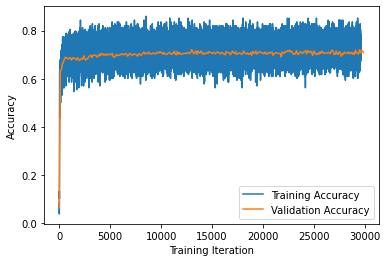

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()